In [18]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import gc
from tqdm import tqdm
import time
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoModel, AutoTokenizer


import pdb


# Defining global parameters

In [69]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": get_available_device(),
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=CONFIG['seed'])

# Read the already preprocessed and split data

In [44]:
train_df = pd.read_pickle('../data/train_split_remove_duplicates_molformer.pkl')
valid_df = pd.read_pickle('../data/valid_split_remove_duplicates_molformer.pkl')

## Wrapping in Pytorch Dataset

In [45]:
class EnvedaDataset(Dataset):
    def __init__(self, dataframe, labels = ['unable_to_assess', 'close_match', 
                                            'near_exact_match', 'exact_match']):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame containing 'ground_truth_embeddings', 
                                       'predicted_embeddings', and output columns.
        """
        self.dataframe = dataframe
        
        # Convert embeddings to tensors
        self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)
        self.predicted_embeddings = torch.tensor(dataframe['predicted_embeddings'].tolist(), dtype=torch.float32)
        
        # Get molecular smiles
        self.ground_truth_smiles = dataframe['ground_truth_smiles'].to_list()
        self.predicted_smiles = dataframe['predicted_smiles'].to_list()

        # Convert labels to tensor
        self.labels = torch.tensor(dataframe[labels].values, dtype=torch.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        #return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]
        return self.ground_truth_smiles[idx], self.predicted_smiles[idx], self.labels[idx]

In [46]:
#---
trainset_unable = EnvedaDataset(dataframe=train_df, labels=['unable_to_assess'])
validset_unable = EnvedaDataset(dataframe=valid_df, labels=['unable_to_assess'])

#---
trainset_not_close = EnvedaDataset(dataframe=train_df, labels=['not_close_match'])
validset_not_close = EnvedaDataset(dataframe=valid_df, labels=['not_close_match'])

#---
trainset_close = EnvedaDataset(dataframe=train_df, labels=['close_match'])
validset_close = EnvedaDataset(dataframe=valid_df, labels=['close_match'])

#--
trainset_near = EnvedaDataset(dataframe=train_df, labels=['near_exact_match'])
validset_near = EnvedaDataset(dataframe=valid_df, labels=['near_exact_match'])

#--
trainset_exact = EnvedaDataset(dataframe=train_df, labels=['exact_match'])
validset_exact = EnvedaDataset(dataframe=valid_df, labels=['exact_match'])

#--
trainset_prioritization = EnvedaDataset(dataframe=train_df, labels=['good_enough_for_prioritization'])
validset_prioritization = EnvedaDataset(dataframe=valid_df, labels=['good_enough_for_prioritization'])


## Wrapping in Pytorch DataLoader

In [47]:
trainloader_unable = DataLoader(trainset_unable, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_unable = DataLoader(validset_unable, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_not_close = DataLoader(trainset_not_close, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_not_close = DataLoader(validset_not_close, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_close = DataLoader(trainset_close, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_close = DataLoader(validset_close, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_near = DataLoader(trainset_near, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_near = DataLoader(validset_near, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_exact = DataLoader(trainset_exact, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_exact = DataLoader(validset_exact, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_prioritization = DataLoader(trainset_prioritization, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_prioritization = DataLoader(validset_prioritization, batch_size=CONFIG['valid_batch_size'], shuffle=False)

In [48]:
gt, pred, labels = next(iter(trainloader_unable))
print(len(gt), len(pred), labels.shape)


16 16 torch.Size([16, 1])


In [49]:
smile_embedder = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True).to(CONFIG['device'])
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [50]:
tokenizer(gt, return_tensors='pt', padding=True, truncation=True)['input_ids'].shape

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([16, 198])

### Use larger Siamese network as in notebook 2.2_feature_aggregation_siamese_multiclass_FP, and integrate molformer and compute embeddings on the go (for purposes of later interpretability analysis)

In [67]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, feature_embedder, input_dim=768, output_dim=4):
        super(SiameseNetwork, self).__init__()
        self.smiler_embedder = feature_embedder 
        # Freeze feature embedder
        for param in self.smiler_embedder.parameters():
            param.requires_grad = False
        
        self.fc = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2))

        self.fc5 = nn.Linear(128, output_dim)

        
    def forward_one(self, x):
        return self.fc(x)

    def forward(self, input1, input2):
        # pdb.set_trace()
        input1, input2 = self.smiler_embedder(**input1, output_hidden_states=True).pooler_output, \
                         self.smiler_embedder(**input2, output_hidden_states=True).pooler_output
        
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        # pdb.set_trace()
        # Combine both outputs by subtraction
        combined = torch.sub(out1, out2)  # maybe torch.abs(out1 - out2)
        output = self.fc5(combined)                  # Outputs raw logits
        return output
    
    
# model(gt, pred)

In [70]:
model = SiameseNetwork(output_dim=1, feature_embedder=smile_embedder)
model.to(CONFIG['device'])
model((tokenizer(gt, return_tensors='pt', padding=True, truncation=True)).to(CONFIG['device']), 
      (tokenizer(pred, return_tensors='pt', padding=True, truncation=True)).to(CONFIG['device']))

NotImplementedError: The operator 'aten::linalg_qr.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

# Training and validation regime

## Training with mixed precision, gradient accumulation, learning with scheduler
## Validation logging loss, AUROC, and F1 metrics

In [53]:
def train_one_epoch(model, optimizer, criterion, scheduler, dataloader, epoch=CONFIG['epochs']):
    model.train()
    
    scaler = GradScaler()
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    running_f1 = 0.0
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds = tokenizer(gt, return_tensors='pt', padding=True, truncation=True)['input_ids'], \
                    tokenizer(preds, return_tensors='pt', padding=True, truncation=True)['input_ids']
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = targets.shape[0]

        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
            
        # Backward pass with scaling
        scaler.scale(loss).backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            # Step the optimizer
            scaler.step(optimizer)

            # Update the scale for next iteration
            scaler.update()
            # optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        # pdb.set_trace()
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        # pdb.set_trace()
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc, Train_F1=epoch_f1,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_f1 = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds = tokenizer(gt, return_tensors='pt', padding=True, truncation=True)['input_ids'], \
                    tokenizer(preds, return_tensors='pt', padding=True, truncation=True)['input_ids']
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = targets.shape[0]
        
        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
        
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                        Valid_F1=epoch_f1,
                        )   
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

## Initializing components
1. Model
2. AdamW optimizer
3. Cosine annealing scheduler
4. Weighted cross entropy loss to handle class imbalance

In [54]:
# Define models, optimizers, and schedulers for each dataset
model_unable = SiameseNetwork(output_dim=1, feature_embedder=smile_embedder).to(CONFIG['device'])
optimizer_unable = optim.AdamW(model_unable.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_unable = lr_scheduler.CosineAnnealingLR(optimizer_unable, T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])

model_close = SiameseNetwork(output_dim=1, feature_embedder=smile_embedder).to(CONFIG['device'])
optimizer_close = optim.AdamW(model_close.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_close = lr_scheduler.CosineAnnealingLR(optimizer_close, T_max=CONFIG['T_max'], 
                                                 eta_min=CONFIG['min_lr'])

model_not_close = SiameseNetwork(output_dim=1, feature_embedder=smile_embedder).to(CONFIG['device'])
optimizer_not_close = optim.AdamW(model_not_close.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_not_close = lr_scheduler.CosineAnnealingLR(optimizer_not_close, T_max=CONFIG['T_max'], 
                                                 eta_min=CONFIG['min_lr'])

model_near = SiameseNetwork(output_dim=1, feature_embedder=smile_embedder).to(CONFIG['device'])
optimizer_near = optim.AdamW(model_near.parameters(), lr=CONFIG['learning_rate'], 
                             weight_decay=CONFIG['weight_decay'])
scheduler_near = lr_scheduler.CosineAnnealingLR(optimizer_near, T_max=CONFIG['T_max'], 
                                                eta_min=CONFIG['min_lr'])

model_exact = SiameseNetwork(output_dim=1, feature_embedder=smile_embedder).to(CONFIG['device'])
optimizer_exact = optim.AdamW(model_exact.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_exact = lr_scheduler.CosineAnnealingLR(optimizer_exact, T_max=CONFIG['T_max'], 
                               eta_min=CONFIG['min_lr'])

model_prioritization = SiameseNetwork(output_dim=1, feature_embedder=smile_embedder).to(CONFIG['device'])
optimizer_prioritization = optim.AdamW(model_prioritization.parameters(), lr=CONFIG['learning_rate'], 
                                       weight_decay=CONFIG['weight_decay'])
scheduler_prioritization = lr_scheduler.CosineAnnealingLR(optimizer_prioritization, T_max=CONFIG['T_max'],
                                                          eta_min=CONFIG['min_lr'])
                          

In [55]:

print(train_df[['unable_to_assess','not_close_match','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']].sum())
class_distribution = {'unable_to_assess': 7,
                      'not_close_match': 87, 
                      'close_match': 99, 
                      'near_exact_match': 48, 
                      'exact_match': 11,
                      'good_enough_for_prioritization': 176}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}
print(class_weights)

# Convert class weights to tensors for each dataset
pos_weights_unable = torch.tensor([class_weights['unable_to_assess']]).to(CONFIG['device'])
pos_weights_not_close = torch.tensor([class_weights['not_close_match']]).to(CONFIG['device'])
pos_weights_close = torch.tensor([class_weights['close_match']]).to(CONFIG['device'])
pos_weights_near = torch.tensor([class_weights['near_exact_match']]).to(CONFIG['device'])
pos_weights_exact = torch.tensor([class_weights['exact_match']]).to(CONFIG['device'])
pos_weights_prioritization = torch.tensor([class_weights['good_enough_for_prioritization']]).to(CONFIG['device'])

# Define the BCEWithLogitsLoss for each dataset
criterion_unable = nn.BCEWithLogitsLoss(pos_weight=pos_weights_unable)
criterion_not_close = nn.BCEWithLogitsLoss(pos_weight=pos_weights_not_close)
criterion_close = nn.BCEWithLogitsLoss(pos_weight=pos_weights_close)
criterion_near = nn.BCEWithLogitsLoss(pos_weight=pos_weights_near)
criterion_exact = nn.BCEWithLogitsLoss(pos_weight=pos_weights_exact)
criterion_prioritization = nn.BCEWithLogitsLoss(pos_weight=pos_weights_prioritization)



unable_to_assess                    7
not_close_match                    87
close_match                        99
near_exact_match                   48
exact_match                        11
good_enough_for_prioritization    176
dtype: int64
{'unable_to_assess': 10.19047619047619, 'not_close_match': 0.8199233716475096, 'close_match': 0.7205387205387206, 'near_exact_match': 1.4861111111111112, 'exact_match': 6.484848484848484, 'good_enough_for_prioritization': 0.4053030303030303}


In [58]:
# train_one_epoch(model=model_exact, optimizer=optimizer_exact, criterion=criterion_exact, scheduler=scheduler_exact, dataloader=trainloader_exact)
# valid_one_epoch(model=model_prioritization, dataloader=trainloader_prioritization, criterion=criterion_prioritization, epoch=CONFIG['epochs'])

## Putting all together into training code
Training code includes:
1. Early stopping
2. Saving best model weights according to supplied name
3. Original code adapted from Kaggle

In [60]:

def run_training(model, optimizer, scheduler, criterion, num_epochs, train_loader, valid_loader, name):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_f1 = -np.inf
    best_valid_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc, train_epoch_f1 = train_one_epoch(model=model, optimizer=optimizer, scheduler=scheduler, 
                                           criterion=criterion, dataloader=train_loader, 
                                           epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, val_epoch_f1 = valid_one_epoch(model=model, dataloader=valid_loader, criterion=criterion, 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['Valid F1'].append(val_epoch_f1)
        history['lr'].append( scheduler.get_lr()[0] )
        if val_epoch_loss <= best_valid_loss:
            print(f"Validation Loss Improved ({best_valid_loss} ---> {val_epoch_loss})")
            best_valid_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_VAL_LOSS_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
        
        if best_epoch_f1 <= val_epoch_f1:
            print(f"Validation F1 Improved ({best_epoch_f1} ---> {val_epoch_f1})")
            best_epoch_f1 = val_epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_F1_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best F1: {:.4f}".format(best_epoch_f1))
    print("Best Loss: {:.4f}".format(best_valid_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [29]:
import concurrent.futures

# Define a function to run the training for a single model
def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, name):
    return run_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        num_epochs=200,
        train_loader=train_loader,
        valid_loader=valid_loader,
        name=name
    )

# Prepare model-specific parameters
model_params = [
    (model_unable, optimizer_unable, scheduler_unable, criterion_unable, trainloader_unable, validloader_unable, 'siamese_unable'),
    (model_not_close, optimizer_not_close, scheduler_not_close, criterion_not_close, trainloader_not_close, validloader_not_close, 'siamese_not_close'),
    (model_close, optimizer_close, scheduler_close, criterion_close, trainloader_close, validloader_close, 'siamese_close'),
    (model_near, optimizer_near, scheduler_near, criterion_near, trainloader_near, validloader_near, 'siamese_near'),
    (model_exact, optimizer_exact, scheduler_exact, criterion_exact, trainloader_exact, validloader_exact, 'siamese_exact'),
    (model_prioritization, optimizer_prioritization, scheduler_prioritization, criterion_prioritization, trainloader_prioritization, validloader_prioritization, 'siamese_prioritization')
]

# Use ThreadPoolExecutor to parallelize the training
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(train_model, *params): name for params, name in zip(model_params, ['siamese_unable', 'siamese_close', 'siamese_near', 'siamese_exact', 'siamese_prioritization'])}
    
    for future in concurrent.futures.as_completed(futures):
        model_name = futures[future]
        try:
            trained_model, history = future.result()
            print(f"Training completed for model: {model_name}")
        except Exception as e:
            print(f"Model {model_name} generated an exception: {e}")


[INFO] Using GPU: GeForce GTX 1650 Ti

[INFO] Using GPU: GeForce GTX 1650 Ti

[INFO] Using GPU: GeForce GTX 1650 Ti

[INFO] Using GPU: GeForce GTX 1650 Ti

[INFO] Using GPU: GeForce GTX 1650 Ti



  0%|          | 0/94 [00:00<?, ?it/s]














  0%|          | 0/94 [00:00<?, ?it/s, Epoch=1, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.907, Train_Loss=0.889]


  1%|          | 1/94 [00:00<00:39,  2.38it/s, Epoch=1, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.907, Train_Loss=0.889]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:30,  3.05it/s, Epoch=1, LR=4.67e-5, Train_Auroc=0.167, Train_F1=0.954, Train_Loss=0.786]











  3%|▎         | 3/94 [00:00<00:27,  3.31it/s, Epoch=1, LR=4.28e-5, Train_Auroc=0.167, Train_F1=0.879, Train_Loss=0.959]









  4%|▍         | 4/94 [00:01<00:23,  3.84it/s, Epoch=1, LR=3.76e-5, Train_Auroc=0.251, Train_F1=0.886, Train_Loss=0.941]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one

Validation Loss Improved (inf ---> 0.7086777769162983)
Model Saved
Validation F1 Improved (-inf ---> 0.6491125856395317)
Model Saved








 94%|█████████▎| 88/94 [00:10<00:00,  6.95it/s, Epoch=1, LR=1.88e-5, Train_Auroc=0.42, Train_F1=0.416, Train_Loss=0.61] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 97%|█████████▋| 91/94 [00:10<00:00,  6.74it/s, Epoch=1, LR=3.76e-5, Train_Auroc=0.115, Train_F1=0.939, Train_Loss=0.81] 



 98%|█████████▊| 92/94 [00:10<00:00,  5.22it/s, Epoch=1, LR=3.76e-5, Train_Auroc=0.115, Train_F1=0.939, Train_Loss=0.81]




 98%|█████████▊| 92/94 [00:10<00:00,  5.22it/s, Epoch=1, LR=4.28e-5, Train_Auroc=0.115, Train_F1=0.939, Train_Loss=0.81]





 99%|█████████▉| 93/94 [00:10<00:00,  5.61it/s, Epoch=1, LR=4.28e-5, Train_Auroc=0.115, Train_F1=0.939, Train_Loss=0.81]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 99%|█████████▉| 93/94 [00:1

Validation Loss Improved (inf ---> 0.5014960514214224)


  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved
Validation F1 Improved (-inf ---> 0.43462544974869166)
Model Saved













 33%|███▎      | 1/3 [00:00<00:00,  8.19it/s, Epoch=1, Valid_Auroc=0.104, Valid_F1=0.884, Valid_Loss=0.926]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 33%|███▎      | 1/3 [00:00<00:00,  8.19it/s, Epoch=1, Valid_Auroc=0.0763, Valid_F1=0.907, Valid_Loss=0.872]





 67%|██████▋   | 2/3 [00:00<00:00,  4.84it/s, Epoch=1, Valid_Auroc=0.0763, Valid_F1=0.907, Valid_Loss=0.872]





100%|██████████| 3/3 [00:00<00:00,  5.16it/s, Epoch=1, Valid_Auroc=0.0875, Valid_F1=0.902, Valid_Loss=0.883]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is se

Validation Loss Improved (inf ---> 0.8834055576495782)
Model Saved
Validation F1 Improved (-inf ---> 0.9023809941093422)


  0%|          | 0/3 [00:00<?, ?it/s]









100%|██████████| 94/94 [00:12<00:00,  7.53it/s, Epoch=1, LR=4.67e-5, Train_Auroc=0.158, Train_F1=0.93, Train_Loss=0.795]


Model Saved







 33%|███▎      | 1/3 [00:00<00:00,  2.36it/s, Epoch=1, Valid_Auroc=0.384, Valid_F1=0.56, Valid_Loss=0.609]











 33%|███▎      | 1/3 [00:00<00:00,  2.36it/s, Epoch=1, Valid_Auroc=0.309, Valid_F1=0.591, Valid_Loss=0.614]

 67%|██████▋   | 2/3 [00:00<00:00,  2.89it/s, Epoch=1, Valid_Auroc=0.309, Valid_F1=0.591, Valid_Loss=0.614]



100%|██████████| 3/3 [00:00<00:00,  3.83it/s, Epoch=1, Valid_Auroc=0.325, Valid_F1=0.563, Valid_Loss=0.61] 
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one

Validation Loss Improved (inf ---> 0.6103441365464719)
Model Saved
Validation F1 Improved (-inf ---> 0.5625111852656763)


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "






Validation Loss Improved (inf ---> 0.6363758455493493)
Model Saved

Model Saved
Validation F1 Improved (-inf ---> 0.9820830779386109)


  0%|          | 0/94 [00:00<?, ?it/s]

Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/94 [00:00<?, ?it/s, Epoch=2, LR=4.92e-5, Train_Auroc=0.387, Train_F1=0.481, Train_Loss=0.599]





  1%|          | 1/94 [00:00<00:24,  3.73it/s, Epoch=2, LR=4.92e-5, Train_Auroc=0.387, Train_F1=0.481, Train_Loss=0.599]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
















  2%|▏         | 2/94 [00:00<00:36,  2.49it/s, Epoch=2, LR=5e-5, Train_Auroc=0.388, Train_F1=0.605, Train_Loss=0.614]   







  2%|▏         | 2/94 [00:00<00:36,  2.49it/s, Epoch=2, LR=4.92e-5, Train_Auroc=0.414, Train_F1=0.538, Train_Loss=0.606]


  3%|▎         | 3/94 [00:01<00:29,  3.04it/s, Epoch=2, LR=4.92e-5, Train_Auroc=0.414, Train_F1=0.538, Train_Loss=0.606]d:\cs\envs\dpl\lib\s

Validation Loss Improved (0.7086777769162983 ---> 0.6728124807694715)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved



 54%|█████▍    | 51/94 [00:10<00:10,  4.02it/s, Epoch=2, LR=4.92e-5, Train_Auroc=0.443, Train_F1=0.498, Train_Loss=0.592]











 54%|█████▍    | 51/94 [00:10<00:10,  4.02it/s, Epoch=2, LR=4.67e-5, Train_Auroc=0.447, Train_F1=0.495, Train_Loss=0.592]








 56%|█████▋    | 53/94 [00:10<00:07,  5.47it/s, Epoch=2, LR=4.28e-5, Train_Auroc=0.45, Train_F1=0.493, Train_Loss=0.592]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 56%|█████▋    | 53/94 [00:10<00:07,  5.47it/s, Epoch=2, LR=3.76e-5, Train_Auroc=0.446, Train_F1=0.494, Train_Loss=0.592]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for a

Validation Loss Improved (0.5014960514214224 ---> 0.48751255477259975)
Model Saved







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 70%|███████   | 66/94 [00:11<00:04,  6.27it/s, Epoch=2, LR=1.29e-5, Train_Auroc=0.442, Train_F1=0.503, Train_Loss=0.59]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 71%|███████▏  | 67/94 [00:11<00:03,  6.96it/s, Epoch=2, LR=1.88e-5, Train_Auroc=0.443, Train_F1=0.502, Train_Loss=0.589]









 72%|███████▏  | 68/94 [00:12<00:03,  7.62it/s, Epoch=2, LR=2.53e-5, Train_Auroc=0.447, Train_F1=0.498, Train_Loss=0.589]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 72%|███████▏  | 68/94 [00:12<00:03,  7.62it/s, Epoch=2, LR=3.17e-5, Train_Auroc=0.446

Validation Loss Improved (0.6103441365464719 ---> 0.5682394722264684)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/94 [00:00<?, ?it/s, Epoch=3, LR=4.28e-5, Train_Auroc=0.46, Train_F1=0.481, Train_Loss=0.569]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:14,  6.25it/s, Epoch=3, LR=4.28e-5, Train_Auroc=0.46, Train_F1=0.481, Train_Loss=0.569]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  2%|▏         | 2/94 [00:00<00:12,  7.18it/s, Epoch=3, LR=4.67e-5, Train_Auroc=0.512, Train_F1=0.407, Train_Loss=0.571]











  3%|▎         | 3/94 [00:00<00:12,  7.41it/s, Epoch=3, LR=4

Validation Loss Improved (0.8834055576495782 ---> 0.8473217080453199)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved










  7%|▋         | 7/94 [00:01<00:18,  4.71it/s, Epoch=3, LR=4.28e-5, Train_Auroc=0.442, Train_F1=0.422, Train_Loss=0.571]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 94/94 [00:16<00:00,  5.57it/s, Epoch=2, LR=3.76e-5, Train_Auroc=0.191, Train_F1=0.93, Train_Loss=0.746]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  9%|▊         | 8/94 [00:01<00:24,  3.56it/s, Epoch=3, LR=3.76e-5, Train_Auroc=0.422, Train_F1=0.439, Train_Loss=0.571]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 3/3 [00:00<00:00,  6.66it/s, Epoch=2, Valid_Auroc=0.0732, Valid_F1=0.98

Validation Loss Improved (0.6363758455493493 ---> 0.5489626482218325)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved














 11%|█         | 10/94 [00:02<00:26,  3.18it/s, Epoch=3, LR=2.53e-5, Train_Auroc=0.439, Train_F1=0.42, Train_Loss=0.571]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 11%|█         | 10/94 [00:02<00:26,  3.18it/s, Epoch=3, LR=1.88e-5, Train_Auroc=0.457, Train_F1=0.433, Train_Loss=0.57]

 12%|█▏        | 11/94 [00:02<00:23,  3.61it/s, Epoch=3, LR=1.88e-5, Train_Auroc=0.457, Train_F1=0.433, Train_Loss=0.57]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fo

Validation Loss Improved (0.6728124807694715 ---> 0.6106329581694688)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved










 53%|█████▎    | 50/94 [00:07<00:05,  8.12it/s, Epoch=3, LR=4.92e-5, Train_Auroc=0.466, Train_F1=0.477, Train_Loss=0.561]


 54%|█████▍    | 51/94 [00:07<00:07,  5.84it/s, Epoch=3, LR=4.92e-5, Train_Auroc=0.466, Train_F1=0.477, Train_Loss=0.561]





 54%|█████▍    | 51/94 [00:07<00:07,  5.84it/s, Epoch=3, LR=5e-5, Train_Auroc=0.466, Train_F1=0.477, Train_Loss=0.561]   


 55%|█████▌    | 52/94 [00:07<00:07,  5.91it/s, Epoch=3, LR=5e-5, Train_Auroc=0.466, Train_F1=0.477, Train_Loss=0.561]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 56%|█████▋    | 53/94 [00:07<00:07,  5.37it/s, Epoch=3, LR=4.92e-5, Train_Auroc=0.467, Train_F1=0.482, Train_Loss=0.56]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-p

Validation Loss Improved (0.48751255477259975 ---> 0.46849147306230965)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 73%|███████▎  | 69/94 [00:10<00:03,  6.61it/s, Epoch=3, LR=2.53e-5, Train_Auroc=0.452, Train_F1=0.503, Train_Loss=0.554]



 74%|███████▍  | 70/94 [00:10<00:05,  4.72it/s, Epoch=3, LR=2.53e-5, Train_Auroc=0.452, Train_F1=0.503, Train_Loss=0.554]













 74%|███████▍  | 70/94 [00:10<00:05,  4.72it/s, Epoch=3, LR=3.17e-5, Train_Auroc=0.453, Train_F1=0.502, Train_Loss=0.554]


 76%|███████▌  | 71/94 [00:10<00:05,  4.13it/s, Epoch=3, LR=3.17e-5, Train_Auroc=0.453, Train_F1=0.502, Train_Loss=0.554]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all t

Validation Loss Improved (0.5682394722264684 ---> 0.5231336009002732)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved




  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  1%|          | 1/94 [00:00<00:14,  6.43it/s, Epoch=4, LR=3.17e-5, Train_Auroc=0.487, Train_F1=0.405, Train_Loss=0.561]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:14,  6.43it/s, Epoch=4, LR=3.76e-5, Train_Auroc=0.533, Train_F1=0.405, Train_Loss=0.557]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  3%|▎         | 3/94 [00:00<00:11,  7.62it/s, Epoch=4, LR=4.28e-5, Train_Auroc=0.517, Train_F1=0.484, Train_Loss=0.539]










  3%|▎         | 3/94 [00:00<00:11,  7.6

Validation Loss Improved (0.5489626482218325 ---> 0.4473552698503711)
Validation Loss Improved (0.8473217080453199 ---> 0.8004374561195602)


 17%|█▋        | 16/94 [00:03<00:25,  3.00it/s, Epoch=4, LR=3.82e-6, Train_Auroc=0.447, Train_F1=0.528, Train_Loss=0.528]

Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved



Model Saved










 17%|█▋        | 16/94 [00:04<00:25,  3.00it/s, Epoch=4, LR=1.34e-6, Train_Auroc=0.441, Train_F1=0.521, Train_Loss=0.531]



 18%|█▊        | 17/94 [00:04<00:29,  2.60it/s, Epoch=4, LR=1.34e-6, Train_Auroc=0.441, Train_F1=0.521, Train_Loss=0.531]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 18%|█▊        | 17/94 [00:04<00:29,  2.60it/s, Epoch=4, LR=5e-7, Train_Auroc=0.425, Train_F1=0.532, Train_Loss=0.528]   





 19%|█▉        | 18/94 [00:04<00:23,  3.21it/s, Epoch=4, LR=5e-7, Train_Auroc=0.425, Train_F1=0.532, Train_Loss=0.528]





100%|██████████| 94/94 [00:14<00:00,  6.65it/s, Epoch=4, LR=1.29e-5, Train_Auroc=0.395, Train_F1=0.699, Train_Loss=0.575]


 20%|██        | 19/94 [00:04<00:23,  

Validation Loss Improved (0.6106329581694688 ---> 0.5835785587390739)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved







 21%|██▏       | 20/94 [00:05<00:20,  3.68it/s, Epoch=4, LR=7.75e-6, Train_Auroc=0.428, Train_F1=0.515, Train_Loss=0.533]



 22%|██▏       | 21/94 [00:05<00:25,  2.81it/s, Epoch=4, LR=7.75e-6, Train_Auroc=0.428, Train_F1=0.515, Train_Loss=0.533]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 22%|██▏       | 21/94 [00:05<00:25,  2.81it/s, Epoch=4, LR=1.29e-5, Train_Auroc=0.42, Train_F1=0.524, Train_Loss=0.53]  


 23%|██▎       | 22/94 [00:06<00:24,  2.93it/s, Epoch=4, LR=1.29e-5, Train_Auroc=0.42, Train_F1=0.524, Train_Loss=0.53]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 23%|██▎       | 22/94 [00:06<00:24,  2.93it/s, Epoch=4, LR=1.88e-5, Train_Auroc=0.422, Train_F1=0.522, Train_Loss=0.53]



 24%|██▍       | 23/94 [0

Validation Loss Improved (0.46849147306230965 ---> 0.4557069088527542)
Model Saved





 44%|████▎     | 41/94 [00:10<00:15,  3.40it/s, Epoch=4, LR=1.34e-6, Train_Auroc=0.455, Train_F1=0.503, Train_Loss=0.534]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 45%|████▍     | 42/94 [00:10<00:12,  4.13it/s, Epoch=4, LR=5e-7, Train_Auroc=0.464, Train_F1=0.496, Train_Loss=0.536]   

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 46%|████▌     | 43/94 [00:10<00:10,  4.82it/s, Epoch=4, LR=1.34e-6, Train_Auroc=0.457, Train_F1=0.501, Train_Loss=0.534]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive clas

Validation Loss Improved (0.5231336009002732 ---> 0.5058764444139903)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]









100%|██████████| 3/3 [00:00<00:00,  8.14it/s, Epoch=5, Valid_Auroc=0.508, Valid_F1=0.649, Valid_Loss=0.582]]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










Validation Loss Improved (0.5835785587390739 ---> 0.5821856303129368)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved



  2%|▏         | 2/94 [00:00<00:18,  5.03it/s, Epoch=5, LR=2.52e-5, Train_Auroc=0.46, Train_F1=0.602, Train_Loss=0.483]9]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  3%|▎         | 3/94 [00:00<00:17,  5.16it/s, Epoch=5, LR=3.17e-5, Train_Auroc=0.529, Train_F1=0.469, Train_Loss=0.535]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  3%|▎         | 3/94 [00:00<00:17,  5.16it/s, Epoch=5, LR=3.76e-5, Train_Auroc=0.526, Train_F1=0.418, Train_Loss=0.558]


  4%|▍         | 4/94 [00:00<00:16,  5.36it/s, Epoch=5, LR=3.76e-5, Train_Auroc=0.526, Train_F1=0.418, Train_Loss=0.558]






  3%|▎         | 3/94 [00:00<00:16,  5.67it/s, Epoch=6, LR=1.88e-5, Train_Auroc=0.634, Train_F1=0.432, Train_Loss=0.793]d:\cs\envs\dpl\lib\site-

Validation Loss Improved (0.4473552698503711 ---> 0.3619494784378006)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 22%|██▏       | 21/94 [00:03<00:12,  6.05it/s, Epoch=5, LR=3.82e-6, Train_Auroc=0.508, Train_F1=0.519, Train_Loss=0.516]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 23%|██▎       | 22/94 [00:03<00:11,  6.08it/s, Epoch=5, LR=3.82e-6, Train_Auroc=0.508, Train_F1=0.519, Train_Loss=0.516]








100%|██████████| 94/94 [00:17<00:00,  5.26it/s, Epoch=4, LR=1.29e-5, Train_Auroc=0.127, Train_F1=0.939, Train_Loss=0.635]




 23%|██▎       | 22/94 [00:03<00:11,  6.08it/s, Epoch=5, LR=7.75e-6, Train_Auroc=0.5, Train_F1=0.514, Train_Loss=0.519]  


 24%|██▍       | 23/94 [00:03<00:13,  5.16it/s, Epoch=5, LR=7.75e-6, Train_Auroc=0.5, Train_F1=0.514, Train_Loss=0.519]










d:\cs\envs\dpl\lib\site-packages

Validation Loss Improved (0.8004374561195602 ---> 0.7785007257661419)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 27%|██▋       | 25/94 [00:04<00:17,  3.95it/s, Epoch=5, LR=1.88e-5, Train_Auroc=0.491, Train_F1=0.502, Train_Loss=0.525]









 28%|██▊       | 26/94 [00:04<00:14,  4.57it/s, Epoch=5, LR=2.53e-5, Train_Auroc=0.483, Train_F1=0.502, Train_Loss=0.526]











 29%|██▊       | 27/94 [00:04<00:13,  4.94it/s, Epoch=5, LR=3.17e-5, Train_Auroc=0.48, Train_F1=0.504, Train_Loss=0.525] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 30%|██▉       | 28/94 [00:04<00:12,  5.13it/s, Epoch=5, LR=3.76e-5, Train_Auroc=0.472, Train_F1=0.506, Train_Loss=0.525]





 31%|███       | 29/94 [00:04<00:11,  5.50it/s, Epoch=5, LR=4.28e-5, Train_Auroc=0.471, Train_F1=0.498, Train_Loss=0.529]





d

Validation Loss Improved (0.4557069088527542 ---> 0.4473778525155461)
Model Saved



 12%|█▏        | 11/94 [00:01<00:11,  7.08it/s, Epoch=5, LR=3.76e-5, Train_Auroc=0.196, Train_F1=0.923, Train_Loss=0.686]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 40%|████      | 38/94 [00:06<00:10,  5.20it/s, Epoch=5, LR=2.53e-5, Train_Auroc=0.461, Train_F1=0.491, Train_Loss=0.532]









 41%|████▏     | 39/94 [00:06<00:10,  5.47it/s, Epoch=5, LR=1.88e-5, Train_Auroc=0.461, Train_F1=0.491, Train_Loss=0.532]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 43%|████▎     | 40/94 [00:06<00:09,  5.70it/s, Epoch=5, LR=1.29e-5, Train_Auroc=0.468, Train_F1=0.487, Train_Loss=0.534]





 44%|████▎     | 41/94 [00:06<00:09,  5.62it/s, Epoch=5, LR=7.75e-6, Train_Auroc=0.473, Train_F1=0.483, Train_Loss=0.535]d:\cs\envs\dpl\l

Validation Loss Improved (0.5058764444139903 ---> 0.5012851721512344)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Validation Loss Improved (0.5821856303129368 ---> 0.5820347873750561)
Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  1%|          | 1/94 [00:00<00:23,  4.00it/s, Epoch=6, LR=7.75e-6, Train_Auroc=0.302, Train_F1=0.56, Train_Loss=0.509]







  1%|          | 1/94 [00:00<00:23,  4.00it/s, Epoch=6, LR=1.29e-5, Train_Auroc=0.223, Train_F1=0.734, Train_Loss=0.441]

  2%|▏         | 2/94 [00:00<00:17,  5.37it/s, Epoch=6, LR=1.29e-5, Train_Auroc=0.223, Train_F1=0.734, Train_Loss=0.441]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  3%|▎         | 3/94 [00:00<00:18,  5.04it/s, Epoch=6, LR=1.88e-5, Train_Auroc=0.33, Train_F1=0.703, Train_Loss=0.448] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all 

Validation Loss Improved (0.3619494784378006 ---> 0.3299846588494535)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved




 28%|██▊       | 26/94 [00:05<00:23,  2.87it/s, Epoch=6, LR=1.29e-5, Train_Auroc=0.431, Train_F1=0.547, Train_Loss=0.507]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 28%|██▊       | 26/94 [00:05<00:23,  2.87it/s, Epoch=6, LR=1.88e-5, Train_Auroc=0.43, Train_F1=0.541, Train_Loss=0.51]  





 29%|██▊       | 27/94 [00:05<00:19,  3.49it/s, Epoch=6, LR=1.88e-5, Train_Auroc=0.43, Train_F1=0.541, Train_Loss=0.51]


 98%|█████████▊| 92/94 [00:13<00:00,  3.72it/s, Epoch=6, LR=1.34e-6, Train_Auroc=0.711, Train_F1=0.258, Train_Loss=0.44]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(















 29%|██▊       | 27/94 [00:06<00:19,  3.49it/s, Epoch=6, LR=2.53e-5, Train_Auroc=0.441, Train_F1=0.529, Train_Loss=0.516]




100%|██████████| 9

Validation Loss Improved (0.4473778525155461 ---> 0.44289864340942064)
Model Saved








 34%|███▍      | 32/94 [00:07<00:13,  4.44it/s, Epoch=6, LR=4.92e-5, Train_Auroc=0.449, Train_F1=0.532, Train_Loss=0.514]





 35%|███▌      | 33/94 [00:07<00:17,  3.44it/s, Epoch=6, LR=4.92e-5, Train_Auroc=0.449, Train_F1=0.532, Train_Loss=0.514]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 3/3 [00:00<00:00,  3.31it/s, Epoch=5, Valid_Auroc=0.144, Valid_F1=0.902, Valid_Loss=0.783]Loss=0.516]   



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

  7%|▋         | 7/94 [00:02<00:24,  3.57it/s, Epoch=6, LR=4.67e-5, Train_Auroc=0.323, Train_F1=0.897, Train_Loss=0.8]  

Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved



 36%|███▌      | 34/94 [00:08<00:15,  3.79it/s, Epoch=6, LR=5e-5, Train_Auroc=0.448, Train_F1=0.528, Train_Loss=0.516]









 37%|███▋      | 35/94 [00:08<00:20,  2.90it/s, Epoch=6, LR=4.92e-5, Train_Auroc=0.443, Train_F1=0.529, Train_Loss=0.515]





 37%|███▋      | 35/94 [00:08<00:20,  2.90it/s, Epoch=6, LR=4.67e-5, Train_Auroc=0.44, Train_F1=0.53, Train_Loss=0.515]  





 38%|███▊      | 36/94 [00:08<00:15,  3.69it/s, Epoch=6, LR=4.67e-5, Train_Auroc=0.44, Train_F1=0.53, Train_Loss=0.515]




 52%|█████▏    | 49/94 [00:08<00:09,  4.88it/s, Epoch=7, LR=1.34e-6, Train_Auroc=0.391, Train_F1=0.722, Train_Loss=0.533]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:08<00:15,  3.69it/s, Epoch=6, LR=4.28e-5, Train_Auroc=0.446, Train_F1=0.525, Train_Loss=0.517]


 39%|███▉      | 37/94 [00:08<00:16,  3.46it/s, Epoch=6, LR=4.28e-5, Train_Au

Validation Loss Improved (0.5820347873750561 ---> 0.5798368011406082)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved






 72%|███████▏  | 68/94 [00:15<00:07,  3.51it/s, Epoch=6, LR=3.82e-6, Train_Auroc=0.468, Train_F1=0.5, Train_Loss=0.527]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 73%|███████▎  | 69/94 [00:16<00:06,  3.88it/s, Epoch=6, LR=1.34e-6, Train_Auroc=0.475, Train_F1=0.496, Train_Loss=0.528]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 74%|███████▍  | 70/94 [00:16<00:05,  4.13it/s, Epoch=6, LR=5e-7, Train_Auroc=0.471, Train_F1=0.498, Train_Loss=0.528]   





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 74%|███████▍  | 70/94 [00:16<00:05,  4.13it/s, Epoch=6, LR=1.34e-6, Train_Auroc=0.476,

Validation Loss Improved (0.5012851721512344 ---> 0.49864916458815156)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:13,  6.69it/s, Epoch=7, LR=1.34e-6, Train_Auroc=0.695, Train_F1=0.405, Train_Loss=0.554]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:14,  6.32it/s, Epoch=7, LR=3.82e-6, Train_Auroc=0.58, Train_F1=0.483, Train_Loss=0.525] 









  3%|▎         | 3/94 [00:00<00:13,  6.51it/s, Epoch=7, LR=7.75e-6, Train_Auroc=0.51, Train_F1=0.565, Train_Loss=0.494]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics



 20%|██        | 19/94 [00:02<00:09,  7.96it/s, Epoch=7, LR=1.29e-5, Train_Auroc=0.524, Train_F1=0.5, Train_Loss=0.523]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 21%|██▏       | 20/94 [00:02<00:11,  6.53it/s, Epoch=7, LR=1.29e-5, Train_Auroc=0.524, Train_F1=0.5, Train_Loss=0.523]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 21%|██▏       | 20/94 [00:02<00:11,  6.53it/s, Epoch=7, LR=7.75e-6, Train_Auroc=0.525, Train_F1=0.492, Train_Loss=0.527]


 22%|██▏       | 21/94 [00:02<00:12,  5.84it/s, Epoch=7, LR=7.75e-6, Train_Auroc=0.525, Train_F1=0.492, Train_Loss=0.527]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  

Validation Loss Improved (0.3299846588494535 ---> 0.3044502976054917)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 38%|███▊      | 36/94 [00:05<00:10,  5.61it/s, Epoch=7, LR=5e-5, Train_Auroc=0.545, Train_F1=0.49, Train_Loss=0.527]    













 38%|███▊      | 36/94 [00:05<00:10,  5.61it/s, Epoch=7, LR=4.92e-5, Train_Auroc=0.546, Train_F1=0.49, Train_Loss=0.527]

 39%|███▉      | 37/94 [00:05<00:09,  5.79it/s, Epoch=7, LR=4.92e-5, Train_Auroc=0.546, Train_F1=0.49, Train_Loss=0.527]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 39%|███▉      | 37/94 [00:05<00:09,  5.79it/s, Epoch=7, LR=4.67e-5, Train_Auroc=0.552, Train_F1=0.482, Train_Loss=0.53]

 40%|████      | 38/94 [00:05<00:08,  6.45it/s, Epoch=7, LR=4.67e-5, Train_Auroc=0.552, Train_F1=0.482, Train_Loss=0.53]








 41%|████▏   

Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 47%|████▋     | 44/94 [00:06<00:08,  5.98it/s, Epoch=7, LR=1.29e-5, Train_Auroc=0.537, Train_F1=0.486, Train_Loss=0.529]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 48%|████▊     | 45/94 [00:06<00:07,  6.21it/s, Epoch=7, LR=7.75e-6, Train_Auroc=0.535, Train_F1=0.491, Train_Loss=0.527]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\m

Validation Loss Improved (0.5798368011406082 ---> 0.5797611849750587)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:12,  7.20it/s, Epoch=9, LR=7.75e-6, Train_Auroc=0.188, Train_F1=0.817, Train_Loss=0.471]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 76%|███████▌  | 71/94 [00:10<00:03,  5.85it/s, Epoch=7, LR=1.34e-6, Train_Auroc=0.523, Train_F1=0.508, Train_Loss=0.521]










 77%|███████▋  | 72/94 [00:10<00:03,

Validation Loss Improved (0.49864916458815156 ---> 0.49680074567566374)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



 32%|███▏      | 30/94 [00:04<00:10,  6.17it/s, Epoch=9, LR=7.75e-6, Train_Auroc=0.436, Train_F1=0.696, Train_Loss=0.556]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  1%|          | 1/94 [00:00<00:11,  7.78it/s, Epoch=8, LR=1.34e-6, Train_Auroc=0.408, Train_F1=0.643, Train_Loss=0.464]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:14,  6.37it/s,

Validation Loss Improved (0.44289864340942064 ---> 0.4411449244993176)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 16%|█▌        | 15/94 [00:03<00:23,  3.33it/s, Epoch=8, LR=4.67e-5, Train_Auroc=0.496, Train_F1=0.525, Train_Loss=0.512]


 17%|█▋        | 16/94 [00:03<00:24,  3.14it/s, Epoch=8, LR=4.67e-5, Train_Auroc=0.496, Train_F1=0.525, Train_Loss=0.512]





 17%|█▋        | 16/94 [00:03<00:24,  3.14it/s, Epoch=8, LR=4.28e-5, Train_Auroc=0.477, Train_F1=0.542, Train_Loss=0.505]




 18%|█▊        | 17/94 [00:03<00:20,  3.77it/s, Epoch=8, LR=4.28e-5, Train_Auroc=0.477, Train_F1=0.542, Train_Loss=0.505]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all threshold

Validation Loss Improved (0.3044502976054917 ---> 0.2911931237953152)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved



 44%|████▎     | 41/94 [00:10<00:15,  3.41it/s, Epoch=8, LR=3.76e-5, Train_Auroc=0.537, Train_F1=0.502, Train_Loss=0.521]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Validation Loss Improved (0.5797611849750587 ---> 0.57964948943989)


 45%|████▍     | 42/94 [00:10<00:21,  2.44it/s, Epoch=8, LR=3.76e-5, Train_Auroc=0.537, Train_F1=0.502, Train_Loss=0.521]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved








 45%|████▍     | 42/94 [00:10<00:21,  2.44it/s, Epoch=8, LR=3.17e-5, Train_Auroc=0.535, Train_F1=0.507, Train_Loss=0.519]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 46%|████▌     | 43/94 [00:10<00:19,  2.63it/s, Epoch=8, LR=3.17e-5, Train_Auroc=0.535, Train_F1=0.507, Train_Loss=0.519]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 46%|████▌     | 43/94 [00:10<00:19,  2.63it/s, Epoch=8, LR=2.53e-5, Train_Auroc=0.535, Train_F1=0.503, Train_Loss=0.52] 


 47%|████▋     | 44/94 [00:10<00:16,  3.00it/s, Epoch=8, LR=2.53e-5, Train_Auroc=0.535, Train_F1=0.503, Train_Loss=0.52]






 48%|████▊     | 45/94 [00:11<00:15,  3.11it/s, Epoch=8, LR=1.88e-5, Train_Auroc=0.543, Train_F1=0.505, Train_Loss=0.52]




d:\cs\envs\dpl\lib\site-packages\skle

Validation Loss Improved (0.7785007257661419 ---> 0.7722998257882581)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved



 59%|█████▊    | 55/94 [00:13<00:10,  3.67it/s, Epoch=8, LR=1.88e-5, Train_Auroc=0.545, Train_F1=0.492, Train_Loss=0.525]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 60%|█████▉    | 56/94 [00:14<00:11,  3.28it/s, Epoch=8, LR=2.52e-5, Train_Auroc=0.545, Train_F1=0.491, Train_Loss=0.525]

















 61%|██████    | 57/94 [00:14<00:10,  3.52it/s, Epoch=8, LR=3.17e-5, Train_Auroc=0.549, Train_F1=0.493, Train_Loss=0.524]













 61%|██████    | 57/94 [00:14<00:10,  3.52it/s, Epoch=8, LR=3.76e-5, Train_Auroc=0.545, Train_F1=0.497, Train_Loss=0.522]




 62%|██████▏   | 58/94 [00:14<00:09,  3.97it/s, Epoch=8, LR=3.76e-5, Train_Auroc=0.545, Train_F1=0.497, Train_Loss=0.522]






 62%|██████▏   | 58/94 [00:14<00:09,  3.97it/s, Epoch=8, LR=4.28e-5, Train_Auroc=0.545, Train_F1=0.499, Train_Loss=0.522]




 63%|██████▎   | 59/94 [00:14<00:07,  4.41i



 93%|█████████▎| 87/94 [00:19<00:01,  5.56it/s, Epoch=8, LR=4.92e-5, Train_Auroc=0.552, Train_F1=0.494, Train_Loss=0.523]









 93%|█████████▎| 87/94 [00:19<00:01,  5.56it/s, Epoch=8, LR=4.67e-5, Train_Auroc=0.551, Train_F1=0.494, Train_Loss=0.523]

 94%|█████████▎| 88/94 [00:19<00:00,  6.09it/s, Epoch=8, LR=4.67e-5, Train_Auroc=0.551, Train_F1=0.494, Train_Loss=0.523]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 94%|█████████▎| 88/94 [00:19<00:00,  6.09it/s, Epoch=8, LR=4.28e-5, Train_Auroc=0.55, Train_F1=0.495, Train_Loss=0.523] 

 95%|█████████▍| 89/94 [00:19<00:00,  6.11it/s, Epoch=8, LR=4.28e-5, Train_Auroc=0.55, Train_F1=0.495, Train_Loss=0.523]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 95%|█████████▍|

Validation Loss Improved (0.49680074567566374 ---> 0.4962007392666297)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=9, LR=7.75e-6, Train_Auroc=0.452, Train_F1=0.56, Train_Loss=0.491]

  1%|          | 1/94 [00:00<00:14,  6.36it/s, Epoch=9, LR=7.75e-6, Train_Auroc=0.452, Train_F1=0.56, Train_Loss=0.491]











  2%|▏         | 2/94 [00:00<00:15,  5.98it/s, Epoch=9, LR=3.82e-6, Train_Auroc=0.577, Train_F1=0.483, Train_Loss=0.52]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: Use

Validation Loss Improved (0.57964948943989 ---> 0.5789515449258382)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved






 29%|██▊       | 27/94 [00:04<00:10,  6.43it/s, Epoch=9, LR=5e-7, Train_Auroc=0.566, Train_F1=0.485, Train_Loss=0.524]   

 30%|██▉       | 28/94 [00:04<00:12,  5.39it/s, Epoch=9, LR=5e-7, Train_Auroc=0.566, Train_F1=0.485, Train_Loss=0.524]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 30%|██▉       | 28/94 [00:04<00:12,  5.39it/s, Epoch=9, LR=1.34e-6, Train_Auroc=0.564, Train_F1=0.488, Train_Loss=0.523]

 31%|███       | 29/94 [00:04<00:12,  5.05it/s, Epoch=9, LR=1.34e-6, Train_Auroc=0.564, Train_F1=0.488, Train_Loss=0.523]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresho

Validation Loss Improved (0.2911931237953152 ---> 0.2827336283144123)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved



 54%|█████▍    | 51/94 [00:08<00:07,  5.53it/s, Epoch=9, LR=1.34e-6, Train_Auroc=0.562, Train_F1=0.491, Train_Loss=0.522]














 55%|█████▌    | 52/94 [00:08<00:07,  5.86it/s, Epoch=9, LR=5e-7, Train_Auroc=0.56, Train_F1=0.489, Train_Loss=0.523]    

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 66%|██████▌   | 62/94 [00:10<00:05,  5.98it/s, Epoch=10, LR=4.28e-5, Train_Auroc=0.726, Train_F1=0.258, Train_Loss=0.438]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 56%|█████▋    | 53/94 [00:08<00:06,  6.06it/s, Epoch=9, LR=1.34e-6, Train_Auroc=0.563, Train_F1=0.484, Train_Loss=0.525]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all

Validation Loss Improved (0.7722998257882581 ---> 0.7639016537609215)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved








 37%|███▋      | 35/94 [00:05<00:10,  5.45it/s, Epoch=11, LR=1.29e-5, Train_Auroc=0.415, Train_F1=0.704, Train_Loss=0.547]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 62%|██████▏   | 58/94 [00:09<00:07,  4.91it/s, Epoch=9, LR=2.53e-5, Train_Auroc=0.563, Train_F1=0.49, Train_Loss=0.522] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 63%|██████▎   | 59/94 [00:09<00:06,  5.13it/s, Epoch=9, LR=3.17e-5, Train_Auroc=0.562, Train_F1=0.49, Train_Loss=0.522]















 63%|██████▎   | 59/94 [00:09<00:06,  5.13it/s, Epoch=9, LR=3.76e-5, Train_Auroc=0.5

Validation Loss Improved (0.4411449244993176 ---> 0.4406152499650053)
Model Saved






 84%|████████▍ | 79/94 [00:14<00:04,  3.47it/s, Epoch=9, LR=7.75e-6, Train_Auroc=0.558, Train_F1=0.495, Train_Loss=0.521]














 84%|████████▍ | 79/94 [00:14<00:04,  3.47it/s, Epoch=9, LR=1.29e-5, Train_Auroc=0.559, Train_F1=0.496, Train_Loss=0.52] 


 85%|████████▌ | 80/94 [00:14<00:04,  3.43it/s, Epoch=9, LR=1.29e-5, Train_Auroc=0.559, Train_F1=0.496, Train_Loss=0.52]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 85%|████████▌ | 80/94 [00:14<00:04,  3.43it/s, Epoch=9, LR=1.88e-5, Train_Auroc=0.559, Train_F1=0.497, Train_Loss=0.52]


 86%|████████▌ | 81/94 [00:14<00:03,  3.91it/s, Epoch=9, LR=1.88e-5, Train_Auroc=0.559, Train_F1=0.497, Train_Loss=0.52]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 87%|████████▋ | 82/94 [00:1

Validation Loss Improved (0.4962007392666297 ---> 0.49441330589934024)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



 67%|██████▋   | 2/3 [00:00<00:00, 10.17it/s, Epoch=11, Valid_Auroc=0.493, Valid_F1=0.649, Valid_Loss=0.576]

100%|██████████| 3/3 [00:00<00:00,  4.83it/s, Epoch=11, Valid_Auroc=0.493, Valid_F1=0.649, Valid_Loss=0.576]

Validation Loss Improved (0.5789515449258382 ---> 0.576427012503504)


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/94 [00:00<?, ?it/s]



Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved



 47%|████▋     | 44/94 [00:10<00:16,  3.04it/s, Epoch=9, LR=3.17e-5, Train_Auroc=0.265, Train_F1=0.943, Train_Loss=0.51] 

 48%|████▊     | 45/94 [00:10<00:20,  2.38it/s, Epoch=9, LR=3.17e-5, Train_Auroc=0.265, Train_F1=0.943, Train_Loss=0.51]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/94 [00:00<?, ?it/s, Epoch=10, LR=1.88e-5, Train_Auroc=0.419, Train_F1=0.56, Train_Loss=0.489]




  1%|          | 1/94 [00:00<00:24,  3.73it/s, Epoch=10, LR=1.88e-5, Train_Auroc=0.419, Train_F1=0.56, Train_Loss=0.489]
















  2%|▏         | 2/94 [00:00<00:26,  3.48it/s, Epoch=10, LR=1.29e-5, Train_Auroc=0.502, Train_F1=0.52, Train_Loss=0.507]


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  3%|▎





 49%|████▉     | 46/94 [00:11<00:15,  3.08it/s, Epoch=10, LR=3.76e-5, Train_Auroc=0.596, Train_F1=0.491, Train_Loss=0.52]














 49%|████▉     | 46/94 [00:11<00:15,  3.08it/s, Epoch=10, LR=3.17e-5, Train_Auroc=0.594, Train_F1=0.495, Train_Loss=0.518]


 50%|█████     | 47/94 [00:11<00:14,  3.19it/s, Epoch=10, LR=3.17e-5, Train_Auroc=0.594, Train_F1=0.495, Train_Loss=0.518]








 50%|█████     | 47/94 [00:11<00:14,  3.19it/s, Epoch=10, LR=2.53e-5, Train_Auroc=0.591, Train_F1=0.493, Train_Loss=0.52] 


 51%|█████     | 48/94 [00:11<00:12,  3.73it/s, Epoch=10, LR=2.53e-5, Train_Auroc=0.591, Train_F1=0.493, Train_Loss=0.52]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Validation Loss Improved (0.2827336283144123 ---> 0.28089219108670055)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved





 61%|██████    | 57/94 [00:13<00:07,  5.10it/s, Epoch=10, LR=1.29e-5, Train_Auroc=0.587, Train_F1=0.498, Train_Loss=0.517]

 62%|██████▏   | 58/94 [00:13<00:07,  4.62it/s, Epoch=10, LR=1.29e-5, Train_Auroc=0.587, Train_F1=0.498, Train_Loss=0.517]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 63%|██████▎   | 59/94 [00:13<00:06,  5.24it/s, Epoch=10, LR=1.88e-5, Train_Auroc=0.584, Train_F1=0.499, Train_Loss=0.517]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 64%|██████▍   | 60/94 [00:14<00:06,  5.33it/s, Epoch=10, LR=2.53e-5, Train_Auroc=0.585, Tr

Validation Loss Improved (0.7639016537609215 ---> 0.7518197283773365)
Validation Loss Improved (0.576427012503504 ---> 0.576234247870074)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved




 67%|██████▋   | 63/94 [00:15<00:10,  3.03it/s, Epoch=10, LR=4.28e-5, Train_Auroc=0.583, Train_F1=0.492, Train_Loss=0.52] 

Model Saved











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 68%|██████▊   | 64/94 [00:15<00:09,  3.33it/s, Epoch=10, LR=4.67e-5, Train_Auroc=0.58, Train_F1=0.493, Train_Loss=0.519]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 69%|██████▉   | 65/94 [00:15<00:07,  3.69it/s, Epoch=10, LR=4.92e-5, Train_Auroc=0.58, Train_F1=0.494, Train_Loss=0.519]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 70%|███████   | 66/94 [00:15<00:07,  3.97it/s, Epoch=10, LR=5e-5, Train_Auroc=0.581, Train_F1=0.493, Train_Loss=0.52]   











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning:

Validation Loss Improved (0.49441330589934024 ---> 0.4942701387548161)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]








  0%|          | 0/94 [00:00<?, ?it/s, Epoch=11, LR=3.17e-5, Train_Auroc=0.607, Train_F1=0.643, Train_Loss=0.458]


  1%|          | 1/94 [00:00<00:12,  7.32it/s, Epoch=11, LR=3.17e-5, Train_Auroc=0.607, Train_F1=0.643, Train_Loss=0.458]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:16,  5.62it/s, Epoch=11, LR=2.52e-5, Train_Auroc=0.406, Train_F1=0.686, Train_Loss=0.451]











  3%|▎         | 3/94 [00:00<00:15,  5.92it/s, Epoch=11, LR=1.88e-5, Train_Auroc=0.373, Train_F1=0.7, Train_Loss=0.443]  











  3%|▎         | 3/94 [00:00<00:15,  5.92it/s, Epoch=11, LR=1.29e-5, Train_Auroc=0.342, Train_

Validation Loss Improved (0.4406152499650053 ---> 0.4386990470086743)
Model Saved



 45%|████▍     | 42/94 [00:05<00:07,  6.84it/s, Epoch=11, LR=4.92e-5, Train_Auroc=0.568, Train_F1=0.491, Train_Loss=0.522]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 46%|████▌     | 43/94 [00:05<00:09,  5.30it/s, Epoch=11, LR=4.92e-5, Train_Auroc=0.568, Train_F1=0.491, Train_Loss=0.522]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 46%|████▌     | 43/94 [00:05<00:09,  5.30it/s, Epoch=11, LR=5e-5, Train_Auroc=0.565, Train_F1=0.49, Train_Loss=0.522]    

 47%|████▋     | 44/94 [00:05<00:08,  6.11it/s, Epoch=11, LR=5e-5, Train_Auroc=0.565, Train_F1=0.49, Train_Loss=0.522]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  

Validation Loss Improved (0.576234247870074 ---> 0.5749409878682233)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 62%|██████▏   | 58/94 [00:08<00:11,  3.23it/s, Epoch=11, LR=3.82e-6, Train_Auroc=0.566, Train_F1=0.49, Train_Loss=0.522] 









 62%|██████▏   | 58/94 [00:08<00:11,  3.23it/s, Epoch=11, LR=7.75e-6, Train_Auroc=0.564, Train_F1=0.491, Train_Loss=0.521]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 63%|██████▎   | 59/94 [00:08<00:09,  3.50it/s, Epoch=11, LR=7.75e-6, Train_Auroc=0.564, Train_F1=0.491, Train_Loss=0.521]


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 63%|██████▎   | 59/94 [00:09<00:09,  3.50it/s, Epoch=11, 

Validation Loss Improved (0.28089219108670055 ---> 0.2759787619649293)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved








 68%|██████▊   | 64/94 [00:10<00:08,  3.74it/s, Epoch=11, LR=4.28e-5, Train_Auroc=0.574, Train_F1=0.496, Train_Loss=0.519]





100%|██████████| 94/94 [00:16<00:00,  5.86it/s, Epoch=10, LR=3.76e-5, Train_Auroc=0.256, Train_F1=0.939, Train_Loss=0.547]












 69%|██████▉   | 65/94 [00:11<00:10,  2.89it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.576, Train_F1=0.494, Train_Loss=0.519]





 70%|███████   | 66/94 [00:11<00:10,  2.78it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.576, Train_F1=0.494, Train_Loss=0.519]













 70%|███████   | 66/94 [00:11<00:10,  2.78it/s, Epoch=11, LR=4.92e-5, Train_Auroc=0.576, Train_F1=0.493, Train_Loss=0.52] 





 71%|███████▏  | 67/94 [00:11<00:09,  2.78it/s, Epoch=11, LR=4.92e-5, Train_Auroc=0.576, Train_F1=0.493, Train_Loss=0.52]





 71%|███████▏  | 67/94 [00:11<00:09,  2.78it/s, Epoch=11, LR=5e-5, Train_Auroc=0.577, Train_F1=0.493, Train_Loss=0.519]  





 72%|███████▏  | 68/94 [00:11<00:08,  3.24it/s, Epoch=11, LR=5e-5, Train_Auroc=0.577, 

Validation Loss Improved (0.7518197283773365 ---> 0.7458862109098606)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)


 38%|███▊      | 36/94 [00:06<00:11,  5.00it/s, Epoch=13, LR=5e-7, Train_Auroc=0.775, Train_F1=0.225, Train_Loss=0.431]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









Model Saved














 73%|███████▎  | 69/94 [00:12<00:07,  3.17it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.571, Train_F1=0.494, Train_Loss=0.519]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 74%|███████▍  | 70/94 [00:12<00:08,  2.71it/s, Epoch=11, LR=4.67e-5, Train_Auroc=0.571, Train_F1=0.494, Train_Loss=0.519]












  5%|▌         | 5/94 [00:01<00:33,  2.68it/s, Epoch=11, LR=3.82e-6, Train_Auroc=0.588, Train_F1=0.877, Train_Loss=0.769]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 74%|███████▍  | 70/94 [00:12<00:08,  2.71it/s, Epoch=11, LR=4.28e-5, Train_Auroc=0.569, Train_F1=0.492, Train_Loss=0.52] 





 76%|███████▌  | 71/94 [00:12<00:07,  2.94it/s, Epoch=11, LR=4.28e-5, Train_Auroc=0.569, Train_F1=0.492, Train_Loss=0.52]















Validation Loss Improved (0.4942701387548161 ---> 0.4941543536985706)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved









  0%|          | 0/94 [00:00<?, ?it/s]















  0%|          | 0/94 [00:00<?, ?it/s, Epoch=12, LR=4.28e-5, Train_Auroc=0.854, Train_F1=0.333, Train_Loss=0.563]

  1%|          | 1/94 [00:00<00:30,  3.01it/s, Epoch=12, LR=4.28e-5, Train_Auroc=0.854, Train_F1=0.333, Train_Loss=0.563]


 87%|████████▋ | 82/94 [00:13<00:01,  6.05it/s, Epoch=13, LR=3.82e-6, Train_Auroc=0.75, Train_F1=0.257, Train_Loss=0.433]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  1%|          | 1/94 [00:00<00:30,  3.01it/s, Epoch=12, LR=3.76e-5, Train_Auroc=0.637, Train_F1=0.369, Train_Loss=0.566]





  2%|▏         | 2/94 [00:00<00:23,  3.93it/s, Epoch=12, LR=3.76e-5, Train_Auroc=0.637, Train_F1=0.369, T

Validation Loss Improved (0.4386990470086743 ---> 0.4375056190761977)
Model Saved















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 11%|█         | 10/94 [00:03<00:29,  2.84it/s, Epoch=12, LR=5e-7, Train_Auroc=0.517, Train_F1=0.441, Train_Loss=0.546]  







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(























 12%|█▏        | 11/94 [00:03<00:28,  2.95it/s, Epoch=12, LR=1.34e-6, Train_Auroc=0.507, Train_F1=0.445, Train_Loss=0.545]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 13%|█▎        | 12/94 [00:03<00:26,  3.04it/s, Epoch=12, LR=3.82e-6, Train_Auroc=0.523, Train_F1=0.455, Train_Loss=0.538]


























 13%|█▎        | 

Validation Loss Improved (0.5749409878682233 ---> 0.5741585819664116)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved



 16%|█▌        | 15/94 [00:05<00:29,  2.70it/s, Epoch=12, LR=2.53e-5, Train_Auroc=0.555, Train_F1=0.425, Train_Loss=0.55] 


 17%|█▋        | 16/94 [00:05<00:37,  2.10it/s, Epoch=12, LR=2.53e-5, Train_Auroc=0.555, Train_F1=0.425, Train_Loss=0.55]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 17%|█▋        | 16/94 [00:05<00:37,  2.10it/s, Epoch=12, LR=3.17e-5, Train_Auroc=0.54, Train_F1=0.433, Train_Loss=0.548]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 17/94 [00:05<00:31,  2.47it/s, Epoch=12, LR=3.17e-5, Train_Auroc=0.54, Train_F1=0.433, Train_Loss=0.548]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 70%|███████   | 66/94 [00:18<00:09,  3.02it/s, Epoch=12, LR=3.76e-5, Train_Auroc=0.562, Train_F1=0.488, Train_Loss=0.522]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 71%|███████▏  | 67/94 [00:18<00:08,  3.22it/s, Epoch=12, LR=4.28e-5, Train_Auroc=0.564, Train_F1=0.486, Train_Loss=0.522]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 71%|███████▏  | 67/94 [00:18<00:08,  3.22it/s, Epoch=12, LR=4.67e-5, Train_Auroc=0.566, Train_F1=0.485, Train_Loss=0.523]





 72%|███████▏  | 68/94 [00:18<00:06,  3.72it/s, Epoch=12, LR=4.67e-5, Train_Au

Validation Loss Improved (0.2759787619649293 ---> 0.26414966494023445)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved



 67%|██████▋   | 2/3 [00:00<00:00,  5.76it/s, Epoch=15, Valid_Auroc=0.443, Valid_F1=0.632, Valid_Loss=0.603]








100%|██████████| 3/3 [00:00<00:00,  3.89it/s, Epoch=11, Valid_Auroc=0.469, Valid_F1=0.902, Valid_Loss=0.725]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
 78%|███████▊  | 73/94 [00:20<00:06,  3.31it/s, Epoch=12, LR=3.76e-5, Train_Auroc=0.562, Train_F1=0.492, Train_Loss=0.52]

100%|██████████| 3/3 [00:00<00:00,  3.21it/s, Epoch=15, Valid_Auroc=0.508, Valid_F1=0.649, Valid_Loss=0.572]in_Loss=0.52]



d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 12%|█▏        | 11/94 [00:02<00:27,  3.07it/s, Epoch=15, LR=1.88e-5, Train_Auroc=0.648, Train_F1=0.325, Train_Loss=0.

Validation Loss Improved (0.7458862109098606 ---> 0.7245721224539294)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Validation Loss Improved (0.5741585819664116 ---> 0.5721196303824465)


Model Saved



Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 79%|███████▊  | 74/94 [00:21<00:09,  2.18it/s, Epoch=12, LR=3.17e-5, Train_Auroc=0.566, Train_F1=0.493, Train_Loss=0.52]





 80%|███████▉  | 75/94 [00:21<00:09,  1.98it/s, Epoch=12, LR=3.17e-5, Train_Auroc=0.566, Train_F1=0.493, Train_Loss=0.52]

















 80%|███████▉  | 75/94 [00:21<00:09,  1.98it/s, Epoch=12, LR=2.53e-5, Train_Auroc=0.568, Train_F1=0.492, Train_Loss=0.52]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 81%|████████  | 76/94 [00:21<00:08,  2.12it/s, Epoch=12, LR=2.53e-5, Train_Auroc=0.

Validation Loss Improved (0.4941543536985706 ---> 0.49174511539721916)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]7.58it/s, Epoch=16, LR=2.53e-5, Train_Auroc=0.492, Train_F1=0.744, Train_Loss=0.498]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  1%|          | 1/94 [00:00<00:15,  5.86it/s, Epoch=13, LR=4.92e-5, Train_Auroc=0.63, Train_F1=0.405, Train_Loss=0.558]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  2%|▏         | 2/94 [00:00<00:16,  5.54it/s, Epoch=13, LR=4.67e-5, Train_Auroc=0.483, Train_F1=0.524, Train_Loss=0.507]











  3%|▎         | 3/94 [00:00<00:16,  5.69it/s, Epoch=13, LR=4.28e-5, Train_Auroc=0.587, Train_F1=0.46, Train_Loss=0.528] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 51%|█████     | 48/94 [00:07<00:08,  5.38it/s, Epoch=13, LR=5e-5, Train_Auroc=0.536, Train_F1=0.512, Train_Loss=0.512]   

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 51%|█████     | 48/94 [00:07<00:08,  5.38it/s, Epoch=13, LR=4.92e-5, Train_Auroc=0.543, Train_F1=0.51, Train_Loss=0.513]


 52%|█████▏    | 49/94 [00:07<00:07,  6.13it/s, Epoch=13, LR=4.92e-5, Train_Auroc=0.543, Train_F1=0.51, Train_Loss=0.513]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 53%|█████▎    | 50/94 [00:07<00:06,  6.30it/s, Epoch=13, LR=4.67e-5, Train_Auroc=0.548,

Validation Loss Improved (0.5721196303824465 ---> 0.5704399607852547)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 62%|██████▏   | 58/94 [00:09<00:07,  5.10it/s, Epoch=13, LR=3.82e-6, Train_Auroc=0.559, Train_F1=0.503, Train_Loss=0.514]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 63%|██████▎   | 59/94 [00:09<00:06,  5.42it/s, Epoch=13, LR=1.34e-6, Train_Auroc=0.555, Train_F1=0.502, Train_Loss=0.515]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▍   | 60/94 [00:09<00:05,  5

Validation Loss Improved (0.7245721224539294 ---> 0.714565089362824)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Validation Loss Improved (0.26414966494023445 ---> 0.2600019985508776)
Model Saved



 86%|████████▌ | 81/94 [00:12<00:03,  3.92it/s, Epoch=13, LR=7.75e-6, Train_Auroc=0.548, Train_F1=0.502, Train_Loss=0.515]

Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved














 87%|████████▋ | 82/94 [00:13<00:03,  3.88it/s, Epoch=13, LR=3.82e-6, Train_Auroc=0.551, Train_F1=0.5, Train_Loss=0.515]  











 88%|████████▊ | 83/94 [00:13<00:02,  4.26it/s, Epoch=13, LR=1.34e-6, Train_Auroc=0.551, Train_F1=0.501, Train_Loss=0.515]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 88%|████████▊ | 83/94 [00:13<00:02,  4.26it/s, Epoch=13, LR=5e-7, Train_Auroc=0.553, Train_F1=0.498, Train_Loss=0.516]   

 89%|████████▉ | 84/94 [00:13<00:02,  4.30it/s, Epoch=13, LR=5e-7, Train_Auroc=0.553, Train_F1=0.498, Train_Loss=0.516]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is se

Validation Loss Improved (0.49174511539721916 ---> 0.4911826210107632)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/94 [00:00<?, ?it/s, Epoch=14, LR=4.92e-5, Train_Auroc=0.55, Train_F1=0.728, Train_Loss=0.417]






  2%|▏         | 2/94 [00:00<00:07, 13.14it/s, Epoch=14, LR=5e-5, Train_Auroc=0.68, Train_F1=0.644, Train_Loss=0.437]








 17%|█▋        | 16/94 [00:04<00:20,  3.83it/s, Epoch=13, LR=1.88e-5, Train_Auroc=0.329, Train_F1=0.93, Train_Loss=0.551]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:07, 13.14it/s, Epoch=14, LR=4.92e-5, Tra







 33%|███▎      | 31/94 [00:05<00:20,  3.08it/s, Epoch=14, LR=2.53e-5, Train_Auroc=0.621, Train_F1=0.469, Train_Loss=0.521]





 34%|███▍      | 32/94 [00:05<00:25,  2.45it/s, Epoch=14, LR=2.53e-5, Train_Auroc=0.621, Train_F1=0.469, Train_Loss=0.521]









 34%|███▍      | 32/94 [00:05<00:25,  2.45it/s, Epoch=14, LR=1.88e-5, Train_Auroc=0.613, Train_F1=0.472, Train_Loss=0.521]





 35%|███▌      | 33/94 [00:05<00:22,  2.74it/s, Epoch=14, LR=1.88e-5, Train_Auroc=0.613, Train_F1=0.472, Train_Loss=0.521]















 36%|███▌      | 34/94 [00:06<00:19,  3.10it/s, Epoch=14, LR=1.29e-5, Train_Auroc=0.609, Train_F1=0.475, Train_Loss=0.52] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warni

Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved








 38%|███▊      | 36/94 [00:07<00:19,  2.91it/s, Epoch=14, LR=1.34e-6, Train_Auroc=0.603, Train_F1=0.484, Train_Loss=0.517]


 39%|███▉      | 37/94 [00:07<00:23,  2.42it/s, Epoch=14, LR=1.34e-6, Train_Auroc=0.603, Train_F1=0.484, Train_Loss=0.517]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 39%|███▉      | 37/94 [00:07<00:23,  2.42it/s, Epoch=14, LR=5e-7, Train_Auroc=0.611, Train_F1=0.482, Train_Loss=0.516]   






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 40%|████      | 38/94 [00:07<00:21,  2.64it/s, Epoch=14, LR=5e-7, Train_Auroc=0.611, Train_F1=0.482, Train

100%|██████████| 3/3 [00:00<00:00,  3.24it/s, Epoch=13, Valid_Auroc=0.492, Valid_F1=0.902, Valid_Loss=0.694]












Validation Loss Improved (0.714565089362824 ---> 0.6943308297031654)


100%|██████████| 94/94 [00:14<00:00,  6.52it/s, Epoch=18, LR=5e-7, Train_Auroc=0.493, Train_F1=0.698, Train_Loss=0.535]19]





Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=18, LR=7.75e-6, Train_Auroc=0.792, Train_F1=0.271, Train_Loss=0.426]



Model Saved











 94%|█████████▎| 88/94 [00:22<00:02,  2.42it/s, Epoch=14, LR=3.82e-6, Train_Auroc=0.577, Train_F1=0.486, Train_Loss=0.519]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 94%|█████████▎| 88/94 [00:22<00:02,  2.42it/s, Epoch=14, LR=7.75e-6, Train_Auroc=0.575, Train_F1=0.488, Train_Loss=0.518]





100%|██████████| 3/3 [00:00<00:00,  5.59it/s, Epoch=18, Valid_Auroc=0.491, Valid_F1=0.649, Valid_Loss=0.568]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Validation Loss Improved (0.5704399607852547 ---> 0.568348870484415)
Model Saved
Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved



 94%|█████████▎| 88/94 [00:22<00:02,  2.42it/s, Epoch=14, LR=1.29e-5, Train_Auroc=0.575, Train_F1=0.491, Train_Loss=0.517]

 96%|█████████▌| 90/94 [00:23<00:01,  2.32it/s, Epoch=14, LR=1.29e-5, Train_Auroc=0.575, Train_F1=0.491, Train_Loss=0.517]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

Model Saved











  0%|          | 0/94 [00:00<?, ?it/s, Epoch=19, LR=1.34e-6, Train_Auroc=1, Train_F1=0.907, Train_Loss=0.308]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 96%|█████████▌| 90/94 [00:23<00:01,  2.32it/s, Epoch=14, LR=1.88e-5, Train_Auroc=0.577, Train_F1=0.491, Train_Loss=0.516]



 97%|█████████▋| 91/94 [00:23<00:01,  2.68it/s, Epoch=14, LR=1.88e-5, Train_Auroc=0.577, Train_F1=0.491, Train_Loss=0.516]







 97%|█████████▋| 91/94 [00:23<00:01,  2.68it/s, Epoch=14, LR=2.53e-5, Train_Auroc=0.574, Train_F1=0.493, Train_Loss=0.516]



 98%|█████████▊| 92/94 [00:23<00:00,  2.95it/s, Epoch=14, LR=2.53e-5, Train_Auroc=0.574, Train_F1=0.493, Train_Loss=0.516]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



















 99%|██

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]5.38it/s, Epoch=18, LR=4.67e-5, Train_Auroc=0.742, Train_F1=0.353, Train_Loss=0.432]




 11%|█         | 10/94 [00:01<00:14,  5.99it/s, Epoch=19, LR=4.67e-5, Train_Auroc=0.595, Train_F1=0.679, Train_Loss=0.559]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











  1%|          | 1/94 [00:00<00:19,  4.87it/s, Epoch=15, LR=4.28e-5, Train_Auroc=0.591, Train_F1=0.405, Train_Loss=0.559]













  1%|          | 1/94 [00:00<00:19,  4.87it/s, Epoch=15, LR=4.67e-5, Train_Auroc=0.614, Train_F1=0.336, Train_Loss=0.597]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  2%|▏         | 2/94 [00:00<00:30,  3.05it/s, Epoch=15, LR=4.67e-5, Train_Auroc=0.614, Train_F1=0.336, Train_Loss=0.597]

















Validation F1 Improved (0.6491125856395317 ---> 0.6491125856395317)
Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 62%|██████▏   | 58/94 [00:12<00:05,  6.34it/s, Epoch=15, LR=2.53e-5, Train_Auroc=0.537, Train_F1=0.506, Train_Loss=0.512]











 63%|██████▎   | 59/94 [00:12<00:05,  5.98it/s, Epoch=15, LR=1.88e-5, Train_Auroc=0.537, Train_F1=0.506, Train_Loss=0.512]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 63%|██████▎   | 59/94 [00:12<00:05,  5.98it/s, Epoch=15, LR=1.29e-5, Train_Auroc=0.541, Train_F1=0.508, Train_Loss=0.511]

100%|██████████| 94/94 [00:15<00:00,  6.01it/s, Epo

Validation F1 Improved (0.43462544974869166 ---> 0.44575443800700393)
Model Saved













 67%|██████▋   | 63/94 [00:13<00:09,  3.27it/s, Epoch=15, LR=1.34e-6, Train_Auroc=0.547, Train_F1=0.506, Train_Loss=0.511]










 67%|██████▋   | 63/94 [00:14<00:09,  3.27it/s, Epoch=15, LR=5e-7, Train_Auroc=0.549, Train_F1=0.508, Train_Loss=0.51]    


 68%|██████▊   | 64/94 [00:14<00:08,  3.33it/s, Epoch=15, LR=5e-7, Train_Auroc=0.549, Train_F1=0.508, Train_Loss=0.51]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 68%|██████▊   | 64/94 [00:14<00:08,  3.33it/s, Epoch=15, LR=1.34e-6, Train_Auroc=0.551, Train_F1=0.504, Train_Loss=0.512]

 69%|██████▉   | 65/94 [00:14<00:08,  3.43it/s, Epoch=15, LR=1.34e-6, Train_Auroc=0.551, Train_F1=0.504, Train_Loss=0.512]













 70%|███████   | 66/94 [00:14<00:07,  3.97it/s, Epoch=15, LR=3.82e-6, Train_Auroc=0.556, Train_F1=0.508, Train_Loss=0.51] 











 71%|███████▏  | 67/94 [00:14<00:05,

Validation Loss Improved (0.4911826210107632 ---> 0.4906425547457027)
Model Saved
Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]





100%|██████████| 94/94 [00:20<00:00,  4.49it/s, Epoch=14, LR=3.76e-5, Train_Auroc=0.281, Train_F1=0.939, Train_Loss=0.516]








  0%|          | 0/94 [00:00<?, ?it/s, Epoch=16, LR=3.17e-5, Train_Auroc=0.613, Train_F1=0.56, Train_Loss=0.492]

  1%|          | 1/94 [00:00<00:16,  5.56it/s, Epoch=16, LR=3.17e-5, Train_Auroc=0.613, Train_F1=0.56, Train_Loss=0.492]













  2%|▏         | 2/94 [00:00<00:17,  5.12it/s, Epoch=16, LR=3.76e-5, Train_Auroc=0.461, Train_F1=0.602, Train_Loss=0.482]





100%|██████████| 3/3 [00:00<00:00,  8.94it/s, Epoch=14, Valid_Auroc=0.471, Valid_F1=0.902, Valid_Loss=0.679]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 94/94 [00:20<00:00,  4.56it/s, Epoch=14, LR=3.76e-5, Train_Auroc=0.302, Train_F1=0

Validation Loss Improved (0.6943308297031654 ---> 0.6790086509224897)


Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved



  3%|▎         | 3/94 [00:00<00:29,  3.09it/s, Epoch=16, LR=4.28e-5, Train_Auroc=0.455, Train_F1=0.588, Train_Loss=0.481]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  3%|▎         | 3/94 [00:01<00:29,  3.09it/s, Epoch=16, LR=4.67e-5, Train_Auroc=0.513, Train_F1=0.524, Train_Loss=0.508]

  4%|▍         | 4/94 [00:01<00:25,  3.59it/s, Epoch=16, LR=4.67e-5, Train_Auroc=0.513, Train_F1=0.524, Train_Loss=0.508]



 47%|████▋     | 44/94 [00:07<00:12,  3.88it/s, Epoch=20, LR=1.88e-5, Train_Auroc=0.518, Train_F1=0.715, Train_Loss=0.526]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.

Validation Loss Improved (0.2600019985508776 ---> 0.25235894599003705)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











  6%|▋         | 6/94 [00:01<00:22,  3.95it/s, Epoch=16, LR=5e-5, Train_Auroc=0.537, Train_F1=0.51, Train_Loss=0.511]  

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  7%|▋         | 7/94 [00:01<00:18,  4.69it/s, Epoch=16, LR=4.92e-5, Train_Auroc=0.542, Train_F1=0.475, Train_Loss=0.526]








  7%|▋         | 7/94 [00:01<00:18,  4.69it/s, Epoch=16, LR=4.67e-5, Train_Auroc=0.513, Train_F1=0.496, Train_Loss=0.519]


  9%|▊         | 8/94 [00:01<00:16,  5.37it/s, Epoch=16, LR=4.67e-5, Train_Auroc=0.513, Train_F1=0.496, Train_Loss=0.519]




 44%|████▎     | 41/94 [00:06<00:09,  5.42it/s, Epoch=19, LR=2.53e-5, Train_Auroc=0.758, Train_F1=0.398, Train_Loss=0.425]d:\cs\envs\

Validation Loss Improved (0.568348870484415 ---> 0.5662004892340677)
Model Saved














 47%|████▋     | 44/94 [00:08<00:17,  2.85it/s, Epoch=16, LR=3.82e-6, Train_Auroc=0.541, Train_F1=0.523, Train_Loss=0.501]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 39%|███▉      | 37/94 [00:07<00:20,  2.80it/s, Epoch=15, LR=3.82e-6, Train_Auroc=0.417, Train_F1=0.91, Train_Loss=0.648]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 48%|████▊     | 45/94 [00:08<00:15,  3.12it/s, Epoch=16, LR=7.75e-6, Train_Auroc=0.542, Train_F1=0.519, Train_Loss=0.503]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning:

Validation Loss Improved (0.4375056190761977 ---> 0.4364808699684943)
Model Saved









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 57%|█████▋    | 54/94 [00:11<00:13,  2.94it/s, Epoch=16, LR=4.92e-5, Train_Auroc=0.559, Train_F1=0.512, Train_Loss=0.506]

 59%|█████▊    | 55/94 [00:12<00:16,  2.31it/s, Epoch=16, LR=4.92e-5, Train_Auroc=0.559, Train_F1=0.512, Train_Loss=0.506]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 60%|█████▉    | 56/94 [00:12<00:16,  2.27it/s, Epoch=16, LR=4.67e-5, Train_Auroc=0.556, Train_F1=0.511, Train_Loss=0.506]








  5%|▌         | 5/94 [00:00<00:14,  6.22it/s, Epoch=20, LR=1.29e-5, Tr

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]






  0%|          | 0/94 [00:00<?, ?it/s, Epoch=17, LR=1.88e-5, Train_Auroc=0.851, Train_F1=0.405, Train_Loss=0.504]



 91%|█████████▏| 86/94 [00:21<00:03,  2.56it/s, Epoch=15, LR=3.82e-6, Train_Auroc=0.296, Train_F1=0.941, Train_Loss=0.499]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:11,  8.34it/s, Epoch=17, LR=1.88e-5, Train_Auroc=0.851, Train_F1=0.405, Train_Loss=0.504]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  1%|          | 1/94 [00:00<00:11,  8.34it/s, Epoch=17, LR=2.52e-5, Train_Auroc=0.605, Train_F1=0.443, Train_Loss=0.523]


  2%|▏         | 2/94 [00:00<00:24,  3.71it/s, Epoch=17, LR=2.52e-5, Train_Auroc=0.605, Train_F1=0.443, Tra





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  5%|▌         | 5/94 [00:01<00:27,  3.23it/s, Epoch=17, LR=4.67e-5, Train_Auroc=0.604, Train_F1=0.474, Train_Loss=0.513]





  6%|▋         | 6/94 [00:01<00:31,  2.81it/s, Epoch=17, LR=4.67e-5, Train_Auroc=0.604, Train_F1=0.474, Train_Loss=0.513]





  6%|▋         | 6/94 [00:01<00:31,  2.81it/s, Epoch=17, LR=4.92e-5, Train_Auroc=0.606, Train_F1=0.464, Train_Loss=0.516]

  7%|▋         | 7/94 [00:02<00:25,  3.39it/s, Epoch=17, LR=4.92e-5, Train_Auroc=0.606, Train_F1=0.464, Train_Loss=0.516]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  7%|▋         | 7/94 [00:02<00:25,  3.39it/s, Epoch=17, LR=5e-5, Train_Auroc=0.631, Train_F1=0.448, Train_Loss=0.522]   





  9%|▊         | 8/94 [00:02<00:21, 

Validation Loss Improved (0.6790086509224897 ---> 0.6643104053543)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved






 14%|█▍        | 13/94 [00:04<00:36,  2.19it/s, Epoch=17, LR=3.17e-5, Train_Auroc=0.667, Train_F1=0.41, Train_Loss=0.534]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████| 3/3 [00:00<00:00,  3.80it/s, Epoch=15, Valid_Auroc=0.575, Valid_F1=0.982, Valid_Loss=0.235]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







Validation Loss Improved (0.25235894599003705 ---> 0.23463457376657132)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved




 15%|█▍        | 14/94 [00:04<00:38,  2.06it/s, Epoch=17, LR=2.52e-5, Train_Auroc=0.64, Train_F1=0.426, Train_Loss=0.53] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 15%|█▍        | 14/94 [00:05<00:38,  2.06it/s, Epoch=17, LR=1.88e-5, Train_Auroc=0.629, Train_F1=0.43, Train_Loss=0.53]


 16%|█▌        | 15/94 [00:05<00:32,  2.42it/s, Epoch=17, LR=1.88e-5, Train_Auroc=0.629, Train_F1=0.43, Train_Loss=0.53]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 17%|█▋        | 16/94 [00:05<00:28,  2.75it/s, Epoch=17, LR=1.29e-5, Train_Auroc=0.626, 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 23%|██▎       | 22/94 [00:07<00:19,  3.70it/s, Epoch=17, LR=7.75e-6, Train_Auroc=0.579, Train_F1=0.453, Train_Loss=0.527]

 24%|██▍       | 23/94 [00:07<00:24,  2.84it/s, Epoch=17, LR=7.75e-6, Train_Auroc=0.579, Train_F1=0.453, Train_Loss=0.527]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 24%|██▍       | 23/94 [00:07<00:24,  2.84it/s, Epoch=17, LR=1.29e-5, Train_Auroc=0.566, Train_F1=0.461, Train_Loss=0.525]





 26%|██▌       | 24/94 [00:07<00:23,  2.94it/s, Epoch=17, LR=1.29e-5, Train_Auroc=0.566, 

Validation F1 Improved (0.6491125856395317 ---> 0.6591814412694392)
Model Saved



 84%|████████▍ | 79/94 [00:17<00:02,  5.84it/s, Epoch=17, LR=4.92e-5, Train_Auroc=0.576, Train_F1=0.489, Train_Loss=0.515]







 84%|████████▍ | 79/94 [00:17<00:02,  5.84it/s, Epoch=17, LR=5e-5, Train_Auroc=0.575, Train_F1=0.489, Train_Loss=0.515]   







 86%|████████▌ | 81/94 [00:17<00:01,  7.35it/s, Epoch=17, LR=4.92e-5, Train_Auroc=0.57, Train_F1=0.492, Train_Loss=0.514]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 87%|████████▋ | 82/94 [00:17<00:01,  7.47it/s, Epoch=17, LR=4.67e-5, Train_Auroc=0.573, Train_F1=0.494, Train_Loss=0.513]










 88%|████████▊ | 83/94 [00:17<00:01,  7.66it/s, Epoch=17, LR=4.28e-5, Train_Auroc=0.573, Train_F1=0.493, Train_Loss=0.514]d:\cs\env

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]











  1%|          | 1/94 [00:00<00:14,  6.31it/s, Epoch=18, LR=7.75e-6, Train_Auroc=0.622, Train_F1=0.266, Train_Loss=0.652]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:15,  6.08it/s, Epoch=18, LR=1.29e-5, Train_Auroc=0.597, Train_F1=0.455, Train_Loss=0.556]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:15,  5.99it/s, Epoch=18, LR=1.88e-5, Train_Auroc=0.581, Train_F1=0.463, Train_Loss=0.548]











  4%|▍         | 4/94 [00:00<00:16,

Validation Loss Improved (0.4364808699684943 ---> 0.43456215986948526)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 13%|█▎        | 12/94 [00:02<00:18,  4.55it/s, Epoch=18, LR=4.67e-5, Train_Auroc=0.618, Train_F1=0.487, Train_Loss=0.516]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 14%|█▍        | 13/94 [00:02<00:17,  4.70it/s, Epoch=18, LR=4.28e-5, Train_Auroc=0.6, Train_F1=0.499, Train_Loss=0.51]   











 15%|█▍        | 14/94 [00:02<00:16,  4.79it/s, Epoch=18, LR=3.76e-5, Train_Auroc=0.607, Train_F1=0.516, Train_Loss=0.503]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_

Validation Loss Improved (0.6643104053543 ---> 0.661491070678848)


Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved



  9%|▊         | 8/94 [00:02<00:24,  3.48it/s, Epoch=22, LR=3.82e-6, Train_Auroc=0.823, Train_F1=0.289, Train_Loss=0.416]




 22%|██▏       | 21/94 [00:04<00:22,  3.25it/s, Epoch=18, LR=1.34e-6, Train_Auroc=0.603, Train_F1=0.495, Train_Loss=0.509]











 23%|██▎       | 22/94 [00:04<00:19,  3.74it/s, Epoch=18, LR=5e-7, Train_Auroc=0.604, Train_F1=0.491, Train_Loss=0.511]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




100%|██████████| 3/3 [00:00<00:00,  5.65it/s, Epoch=16, Valid_Auroc=0.575, Valid_F1=0.982, Valid_Loss=0.242]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()

Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved



 24%|██▍       | 23/94 [00:04<00:22,  3.19it/s, Epoch=18, LR=1.34e-6, Train_Auroc=0.612, Train_F1=0.494, Train_Loss=0.508]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 26%|██▌       | 24/94 [00:05<00:18,  3.73it/s, Epoch=18, LR=3.82e-6, Train_Auroc=0.603, Train_F1=0.493, Train_Loss=0.51] 




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 25/94 [00:05<00:15,  4.38it/s, Epoch=18, LR=7.75e-6, Train_Auroc=0.61, Train_F1=0.487, Train_Loss=0.511]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive 

Validation Loss Improved (0.5662004892340677 ---> 0.562788408494995)
Model Saved
Validation F1 Improved (0.6591814412694392 ---> 0.6653936250861803)
Model Saved








 83%|████████▎ | 78/94 [00:12<00:05,  2.89it/s, Epoch=18, LR=3.76e-5, Train_Auroc=0.598, Train_F1=0.493, Train_Loss=0.509]


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 83%|████████▎ | 78/94 [00:13<00:05,  2.89it/s, Epoch=18, LR=4.28e-5, Train_Auroc=0.599, Train_F1=0.493, Train_Loss=0.509]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 84%|████████▍ | 79/94 [00:13<00:05,  2.88it/s, Epoch=18, LR=4.28e-5, Train_Auroc=0.599, Train_F1=0.493, Train_Loss=0.509]











 85%|████████▌ | 80/94 [00:13<00:04,  3.41it/s, Epoch=18, LR=4.67e-5, Train_Auroc=0.6, Train_F1=0.491, Train_Loss=0.51]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is se

Validation F1 Improved (0.44575443800700393 ---> 0.44792230182520515)
Model Saved



100%|██████████| 3/3 [00:00<00:00,  3.96it/s, Epoch=18, Valid_Auroc=0.453, Valid_F1=0.563, Valid_Loss=0.494]


100%|██████████| 3/3 [00:00<00:00,  3.88it/s, Epoch=18, Valid_Auroc=0.453, Valid_F1=0.563, Valid_Loss=0.494]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







  0%|          | 0/94 [00:00<?, ?it/s, Epoch=23, LR=3.17e-5, Train_Auroc=0.967, Train_F1=0.681, Train_Loss=0.361]

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved











 39%|███▉      | 37/94 [00:06<00:18,  3.17it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.527, Train_F1=0.738, Train_Loss=0.503]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  0%|          | 0/94 [00:00<?, ?it/s]













  1%|          | 1/94 [00:00<00:17,  5.45it/s, Epoch=19, LR=1.34e-6, Train_Auroc=0.503, Train_F1=0.481, Train_Loss=0.517]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 74%|███████▍  | 70/94 [00:14<00:11,  2.09it/s, Epoch=17, LR=7.75e-6, Train_Auroc=0.306, Train_F1=0.934, Train_Loss=0.514]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





















  1%|          | 1/94 [00:00<00:1

Validation Loss Improved (0.661491070678848 ---> 0.6507600228229683)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved








 28%|██▊       | 26/94 [00:05<00:15,  4.40it/s, Epoch=19, LR=3.82e-6, Train_Auroc=0.584, Train_F1=0.521, Train_Loss=0.501]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 3/3 [00:00<00:00,  5.65it/s, Epoch=17, Valid_Auroc=0.575, Valid_F1=0.982, Valid_Loss=0.235]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 28%|██▊       | 26/94 [00:06<00:15,  4.40it/s, Epoch=19, LR=7.75e-6, Train_Auroc=0.583, Train_F1=0.52, Train_Loss=0.501] 





100%|██████████| 3/3 [00:01<00:00,  2.93it/s, Epoch=17, Valid_Auroc=0.575, Valid_F1=0.982, Valid_Loss=0.235]n_Loss=0.501]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr

Validation Loss Improved (0.23463457376657132 ---> 0.23462864801198421)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved



 29%|██▊       | 27/94 [00:07<00:19,  3.45it/s, Epoch=19, LR=1.29e-5, Train_Auroc=0.593, Train_F1=0.516, Train_Loss=0.502]




 30%|██▉       | 28/94 [00:07<00:33,  1.98it/s, Epoch=19, LR=1.29e-5, Train_Auroc=0.593, Train_F1=0.516, Train_Loss=0.502]





 30%|██▉       | 28/94 [00:07<00:33,  1.98it/s, Epoch=19, LR=1.88e-5, Train_Auroc=0.579, Train_F1=0.523, Train_Loss=0.5]  


 31%|███       | 29/94 [00:07<00:25,  2.53it/s, Epoch=19, LR=1.88e-5, Train_Auroc=0.579, Train_F1=0.523, Train_Loss=0.5]











 32%|███▏      | 30/94 [00:07<00:21,  2.94it/s, Epoch=19, LR=2.53e-5, Train_Auroc=0.577, Train_F1=0.519, Train_Loss=0.502]










 32%|███▏      | 30/94 [00:07<00:21,  2.94it/s, Epoch=19, LR=3.17e-5, Train_Auroc=0.579, Train_F1=0.515, Train_Loss=0.503]


 33%|███▎      | 31/94 [00:07<00:19,  3.17it/s, Epoch=19, LR=3.17e-5, Train_Auroc=0.579, Train_F1=0.515, Train_Loss=0.503]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in

Validation Loss Improved (0.562788408494995 ---> 0.561957378944237)
Model Saved
Validation F1 Improved (0.6653936250861803 ---> 0.6653936250861803)
Model Saved







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 41%|████▏     | 39/94 [00:10<00:16,  3.44it/s, Epoch=19, LR=3.76e-5, Train_Auroc=0.585, Train_F1=0.507, Train_Loss=0.505]



 43%|████▎     | 40/94 [00:10<00:20,  2.59it/s, Epoch=19, LR=3.76e-5, Train_Auroc=0.585, Train_F1=0.507, Train_Loss=0.505]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 43%|████▎     | 40/94 [00:10<00:20,  2.59it/s, Epoch=19, LR=3.17e-5, Train_Auroc=0.577, Train_F1=0.515, Train_Loss=0.502]


 44%|████▎     | 41/94 [00:10<00:19,  2.74it/s, Epoch=19, LR=3.17e-5, Train_Auroc=0.577, Train_F1=0.515, Train_Loss=0.502]


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, rec

Validation Loss Improved (0.43456215986948526 ---> 0.4340203838077134)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 33%|███▎      | 31/94 [00:08<00:13,  4.58it/s, Epoch=18, LR=4.28e-5, Train_Auroc=0.287, Train_F1=0.923, Train_Loss=0.598]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 67%|██████▋   | 63/94 [00:16<00:06,  4.80it/s, Epoch=19, LR=4.28e-5, Train_Auroc=0.574, Train_F1=0.496, Train_Loss=0.51]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 68%|██████▊   | 64/94 [00:16<00:06,  4.76it/s, Epoch=19, LR=3.76e-5, Train_Auroc=0.571, Train_F1=0.499, Train_Loss=0.509]











 69%|██████▉   | 65/94 [00:16<00:05,  5.27it/s, Epoch=19, LR=3.17e-5, Train_Auroc

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  1%|          | 1/94 [00:00<00:12,  7.33it/s, Epoch=20, LR=1.34e-6, Train_Auroc=0.716, Train_F1=0.205, Train_Loss=0.698]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














  2%|▏         | 2/94 [00:00<00:16,  5.43it/s, Epoch=20, LR=5e-7, Train_Auroc=0.708, Train_F1=0.466, Train_Loss=0.553]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Validation F1 Improved (0.6653936250861803 ---> 0.6653936250861803)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 14%|█▍        | 13/94 [00:02<00:22,  3.67it/s, Epoch=20, LR=4.92e-5, Train_Auroc=0.529, Train_F1=0.49, Train_Loss=0.527]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 14%|█▍        | 13/94 [00:02<00:22,  3.67it/s, Epoch=20, LR=5e-5, Train_Auroc=0.527, Train_F1=0.489, Train_Loss=0.527]  


 15%|█▍        | 14/94 [00:02<00:20,  3.89it/s, Epoch=20, LR=5e-5, Train_Auroc=0.527, Train_F1=0.489, Train_Loss=0.527]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 16%|█▌        | 15/94 [00:03<00:18,  4.29it/s, Epoch=20, LR=4.92e-5, Train_Auroc=0.53

Validation Loss Improved (0.6507600228229683 ---> 0.6395746294609801)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved










100%|██████████| 94/94 [00:21<00:00,  4.35it/s, Epoch=18, LR=5e-7, Train_Auroc=0.337, Train_F1=0.93, Train_Loss=0.526]516]










 34%|███▍      | 32/94 [00:06<00:12,  4.81it/s, Epoch=20, LR=3.17e-5, Train_Auroc=0.58, Train_F1=0.488, Train_Loss=0.515] 

 35%|███▌      | 33/94 [00:06<00:13,  4.47it/s, Epoch=20, LR=3.17e-5, Train_Auroc=0.58, Train_F1=0.488, Train_Loss=0.515]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 3/3 [00:00<00:00, 11.37it/s, Epoch=18, Valid_Auroc=0.575, Valid_F1=0.982, Valid_Loss=0.226]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_la

Validation Loss Improved (0.23462864801198421 ---> 0.22583174330745628)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 37%|███▋      | 35/94 [00:07<00:14,  4.20it/s, Epoch=20, LR=4.28e-5, Train_Auroc=0.583, Train_F1=0.486, Train_Loss=0.516]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 37%|███▋      | 35/94 [00:07<00:14,  4.20it/s, Epoch=20, LR=4.67e-5, Train_Auroc=0.587, Train_F1=0.479, Train_Loss=0.518]


 38%|███▊      | 36/94 [00:07<00:12,  4.61it/s, Epoch=20, LR=4.67e-5, Train_Auroc=0.587, Train_F1=0.479, Train_Loss=0.518]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 38%|███▊      | 36/94 [00:07<00:12,  4.61it/s, Epoch=20, LR=4.92e-5, Train_Auroc=0.5

Validation F1 Improved (0.44792230182520515 ---> 0.4548364971389889)
Model Saved







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 55%|█████▌    | 52/94 [00:09<00:07,  5.83it/s, Epoch=20, LR=7.75e-6, Train_Auroc=0.587, Train_F1=0.491, Train_Loss=0.508]


 56%|█████▋    | 53/94 [00:09<00:08,  4.67it/s, Epoch=20, LR=7.75e-6, Train_Auroc=0.587, Train_F1=0.491, Train_Loss=0.508]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 56%|█████▋    | 53/94 [00:10<00:08,  4.67it/s, Epoch=20, LR=1.29e-5, Train_Auroc=0.584, Train_F1=0.487, Train_Loss=0.512]





 57%|█████▋    | 54/94 [00:10<00:10,  3.75it/s, Epoch=20, LR=1.29e-5, Train_Auroc=0.584, Train_F1=0.487

Validation F1 Improved (0.6653936250861803 ---> 0.6653936250861803)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 86%|████████▌ | 81/94 [00:18<00:03,  3.57it/s, Epoch=20, LR=3.76e-5, Train_Auroc=0.58, Train_F1=0.493, Train_Loss=0.509] 


 87%|████████▋ | 82/94 [00:18<00:03,  3.01it/s, Epoch=20, LR=3.76e-5, Train_Auroc=0.58, Train_F1=0.493, Train_Loss=0.509]


 52%|█████▏    | 49/94 [00:08<00:10,  4.23it/s, Epoch=25, LR=4.67e-5, Train_Auroc=0.765, Train_F1=0.414, Train_Loss=0.421]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 87%|████████▋ | 82/94 [00:18<00:03,  3.01it/s, Epoch=20, LR=4.28e-5, Train_Auroc=0.579, Train_F1=0.

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved








  0%|          | 0/94 [00:00<?, ?it/s]
















  1%|          | 1/94 [00:00<00:24,  3.73it/s, Epoch=21, LR=7.75e-6, Train_Auroc=0.658, Train_F1=0.333, Train_Loss=0.581]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 80%|███████▉  | 75/94 [00:13<00:03,  5.44it/s, Epoch=25, LR=3.76e-5, Train_Auroc=0.77, Train_F1=0.425, Train_Loss=0.419]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:24,  3.82it/s, Epoch=21, LR=3.82e-6, Train_Auroc=0.725, Train_F1=0.333, Train_Loss=0.56] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  2%|▏         | 2/94 [00:00<00:2

Validation F1 Improved (0.4548364971389889 ---> 0.4854900322987109)
Model Saved










 13%|█▎        | 12/94 [00:03<00:27,  3.00it/s, Epoch=21, LR=4.28e-5, Train_Auroc=0.61, Train_F1=0.452, Train_Loss=0.523]

 14%|█▍        | 13/94 [00:03<00:32,  2.53it/s, Epoch=21, LR=4.28e-5, Train_Auroc=0.61, Train_F1=0.452, Train_Loss=0.523]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 14%|█▍        | 13/94 [00:04<00:32,  2.53it/s, Epoch=21, LR=4.67e-5, Train_Auroc=0.595, Train_F1=0.454, Train_Loss=0.523]


 15%|█▍        | 14/94 [00:04<00:29,  2.75it/s, Epoch=21, LR=4.67e-5, Train_Auroc=0.595, Train_F1=0.454, Train_Loss=0.523]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:08, 10.75it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.848, Train_F1=0.372, Train_Loss=0.391]d:\cs\envs\dpl\lib\s

Validation Loss Improved (0.6395746294609801 ---> 0.6328686629226822)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved






 37%|███▋      | 35/94 [00:11<00:26,  2.19it/s, Epoch=21, LR=3.17e-5, Train_Auroc=0.614, Train_F1=0.452, Train_Loss=0.52] 




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 37%|███▋      | 35/94 [00:11<00:26,  2.19it/s, Epoch=21, LR=3.76e-5, Train_Auroc=0.621, Train_F1=0.455, Train_Loss=0.518]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:11<00:21,  2.65it/s, Epoch=21, LR=3.76e-5, Train_Auroc=0.621, Train_F1=0.455, Train_Loss=0.518]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 38%|███▊      | 36/94 [00:11<00:21,  2.65it/s, Epoch=21, LR=4.28e-5, Train_Auroc=0.618, Tr

Validation F1 Improved (0.9820830779386109 ---> 0.9820830779386109)
Model Saved






 44%|████▎     | 41/94 [00:13<00:20,  2.54it/s, Epoch=21, LR=4.92e-5, Train_Auroc=0.615, Train_F1=0.457, Train_Loss=0.518]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 44%|████▎     | 41/94 [00:13<00:20,  2.54it/s, Epoch=21, LR=4.67e-5, Train_Auroc=0.615, Train_F1=0.457, Train_Loss=0.519]


 45%|████▍     | 42/94 [00:13<00:20,  2.54it/s, Epoch=21, LR=4.67e-5, Train_Auroc=0.615, Train_F1=0.457, Train_Loss=0.519]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 45%|████▍     | 42/94 [00:13<00:20,  2.54it/s, Epoch=21, LR=4.28e-5, Train_Auroc=0.616, Train_F1=0.454, Train_Loss=0.52] 

100%|██████████| 3/3 [00:00<00:00,  5.58it/s, Epoch=27, Valid_Auroc=0.494, Valid_F1=0.665, Valid_Loss=0.564]
d:\cs\envs\dpl\lib\site-packages\to

Validation F1 Improved (0.6653936250861803 ---> 0.6653936250861803)
Model Saved









 47%|████▋     | 44/94 [00:14<00:19,  2.55it/s, Epoch=21, LR=3.76e-5, Train_Auroc=0.613, Train_F1=0.455, Train_Loss=0.52]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 48%|████▊     | 45/94 [00:14<00:16,  2.89it/s, Epoch=21, LR=3.17e-5, Train_Auroc=0.616, Train_F1=0.463, Train_Loss=0.516]






 49%|████▉     | 46/94 [00:14<00:14,  3.26it/s, Epoch=21, LR=2.53e-5, Train_Auroc=0.611, Train_F1=0.467, Train_Loss=0.515]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 50%|█████     | 47/94 [00:14<00:12,  3.70it/s, Epoch=21, LR=1.88e-5, Train_Auro

Validation F1 Improved (0.4854900322987109 ---> 0.4956777894273689)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 82%|████████▏ | 77/94 [00:22<00:02,  5.91it/s, Epoch=21, LR=3.82e-6, Train_Auroc=0.58, Train_F1=0.494, Train_Loss=0.509] 


 83%|████████▎ | 78/94 [00:22<00:03,  4.65it/s, Epoch=21, LR=3.82e-6, Train_Auroc=0.58, Train_F1=0.494, Train_Loss=0.509]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 83%|████████▎ | 78/94 [00:22<00:03,  4.65it/s, Epoch=21, LR=7.75e-6, Train_Auroc=0.581, Train_F1=0.493, Train_Loss=0.509]


 84%|████████▍ | 79/94 [00:22<00:02,  5.36it/s, Epoch=21, LR=7.75e-6, Train_Auroc=0.581, Train_F1=0.49

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]











  1%|          | 1/94 [00:00<00:11,  8.43it/s, Epoch=22, LR=1.88e-5, Train_Auroc=0.474, Train_F1=0.56, Train_Loss=0.475]











  2%|▏         | 2/94 [00:00<00:11,  7.88it/s, Epoch=22, LR=1.29e-5, Train_Auroc=0.404, Train_F1=0.688, Train_Loss=0.431]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  2%|▏         | 2/94 [00:00<00:11,  7.88it/s, Epoch=22, LR=7.75e-6, Train_Auroc=0.41, Train_F1=0.646, Train_Loss=0.457] 

  3%|▎         | 3/94 [00:00<00:11,  7.97it/s, Epoch=22, LR=7.75e-6, Train_Auroc=0.41, Train_F1=0.646, Train_Loss=0.457]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla

Validation Loss Improved (0.561957378944237 ---> 0.5594123689357392)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 20%|██        | 19/94 [00:03<00:11,  6.74it/s, Epoch=22, LR=4.67e-5, Train_Auroc=0.585, Train_F1=0.517, Train_Loss=0.499]


 21%|██▏       | 20/94 [00:03<00:14,  4.96it/s, Epoch=22, LR=4.67e-5, Train_Auroc=0.585, Train_F1=0.517, Train_Loss=0.499]







 41%|████▏     | 39/94 [00:06<00:10,  5.31it/s, Epoch=27, LR=1.34e-6, Train_Auroc=0.793, Train_F1=0.431, Train_Loss=0.414]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 22%|██▏       | 21/94 [00:03<00:13,  5.36it/s, Epoch=22, LR=4.28e-5, Train_Auroc=0.585, Train_F1=0.515, Train_Loss=0.501]













 22%|██▏       | 21/94 [00:03<00:13,  5.36it/s, Epoch=22, LR=3.76e-5, Train_Auroc=0.584, Train_F1=0.513, Train_Loss=0.501]

 23%|██▎       | 

Validation Loss Improved (0.6328686629226822 ---> 0.617860197307107)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 43%|████▎     | 40/94 [00:06<00:11,  4.82it/s, Epoch=22, LR=4.67e-5, Train_Auroc=0.574, Train_F1=0.512, Train_Loss=0.503]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 44%|████▎     | 41/94 [00:06<00:09,  5.39it/s, Epoch=22, LR=4.92e-5, Train_Auroc=0.577, Train_F1=0.511, Train_Loss=0.504]















 45%|████▍     | 42/94 [00:06<00:09,  5.22it/s, Epoch=22, LR=5e-5, Train_Auroc=0.577, Train_F1=0.512, Train_Loss=0.503]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 45%|████▍     | 42/94 [00:06<00:09,  5.22it/s, Epoch=22, LR=4.92e-5, Trai

Validation Loss Improved (0.22583174330745628 ---> 0.22049380125042922)
Model Saved
Validation F1 Improved (0.9820830779386109 ---> 0.9860275669134173)
Model Saved



 50%|█████     | 47/94 [00:07<00:11,  3.99it/s, Epoch=22, LR=3.17e-5, Train_Auroc=0.576, Train_F1=0.507, Train_Loss=0.504]













 51%|█████     | 48/94 [00:08<00:10,  4.31it/s, Epoch=22, LR=2.53e-5, Train_Auroc=0.57, Train_F1=0.514, Train_Loss=0.503] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 52%|█████▏    | 49/94 [00:08<00:10,  4.41it/s, Epoch=22, LR=1.88e-5, Train_Auroc=0.563, Train_F1=0.52, Train_Loss=0.501]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 53%|█████▎    | 50/94 [00:08<00:09,  4.76it/s, Epoch=22, LR=1.29e-5, Train_Auroc=0.566, Train_F1=0.522, Train_Loss=0.499]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is se

Validation F1 Improved (0.4956777894273689 ---> 0.5219172708283032)
Model Saved









 74%|███████▍  | 70/94 [00:13<00:10,  2.33it/s, Epoch=22, LR=3.76e-5, Train_Auroc=0.566, Train_F1=0.504, Train_Loss=0.506]







 32%|███▏      | 30/94 [00:07<00:14,  4.42it/s, Epoch=21, LR=7.75e-6, Train_Auroc=0.307, Train_F1=0.935, Train_Loss=0.472]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 76%|███████▌  | 71/94 [00:13<00:09,  2.49it/s, Epoch=22, LR=3.17e-5, Train_Auroc=0.566, Train_F1=0.502, Train_Loss=0.507]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






















 77%|███████▋  | 72/94 [00:14<00:09,  2.33it/s, Epoch=22, LR=2.53e-5, Train_Auroc=0.569, Train_F1=0.5, Train_Loss=0.507]  



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, 

Validation F1 Improved (0.6653936250861803 ---> 0.6653936250861803)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 90%|█████████ | 85/94 [00:19<00:02,  3.17it/s, Epoch=22, LR=3.76e-5, Train_Auroc=0.58, Train_F1=0.496, Train_Loss=0.507] 

 91%|█████████▏| 86/94 [00:19<00:03,  2.35it/s, Epoch=22, LR=3.76e-5, Train_Auroc=0.58, Train_F1=0.496, Train_Loss=0.507]









 93%|█████████▎| 87/94 [00:19<00:02,  2.66it/s, Epoch=22, LR=4.28e-5, Train_Auroc=0.579, Train_F1=0.495, Train_Loss=0.508]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 93%|█████████▎| 87/94 [00:19<00:02,  2.66it/s, Epoch=22, LR=4.67e-5, Train_Auroc=0.581, Train_F1=0.495, Train_Loss=0.508]





 94%|█████████▎| 88/94 [00:19<00:02,  2.91it/s, Epoch=22, LR=4.67e-5, Train_Auroc=0.581, Train_F1=0.495, Train_Loss=0.508]




d:\cs\env

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]3.99it/s, Epoch=30, LR=7.75e-6, Train_Auroc=0.584, Train_F1=0.766, Train_Loss=0.481]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  1%|          | 1/94 [00:00<00:40,  2.32it/s, Epoch=23, LR=3.17e-5, Train_Auroc=0.6, Train_F1=0.405, Train_Loss=0.529]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:26,  3.46it/s, Epoch=23, LR=2.53e-5, Train_Auroc=0.562, Train_F1=0.524, Train_Loss=0.493]













  2%|▏         | 2/94 [00:00<00:26,  3.46it/s, Epoch=23, LR=1.88e-5, Train_Auroc=

Validation Loss Improved (0.4340203838077134 ---> 0.43291464162443927)
Model Saved







 32%|███▏      | 30/94 [00:10<00:29,  2.16it/s, Epoch=23, LR=3.82e-6, Train_Auroc=0.573, Train_F1=0.466, Train_Loss=0.52]










 33%|███▎      | 31/94 [00:10<00:26,  2.35it/s, Epoch=23, LR=1.34e-6, Train_Auroc=0.572, Train_F1=0.461, Train_Loss=0.522]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 33%|███▎      | 31/94 [00:11<00:26,  2.35it/s, Epoch=23, LR=5e-7, Train_Auroc=0.569, Train_F1=0.467, Train_Loss=0.52]    

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 34%|███▍      | 32/94 [00:11<00:22,  2.73it/s, Epoch=23, LR=5e-7, Train_Auroc=0.569, Train_F1=0.467, Train_Loss=0.52]











 34%|███▍      | 32/94 [00:11<00:22,  2.73it/s, Epoch=23, LR=1.34e-6, Train_Auroc=0.578, Train_F1=0.47, Train_Loss=0.517]



 35%|

Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)


100%|██████████| 94/94 [00:19<00:00,  4.72it/s, Epoch=30, LR=5e-7, Train_Auroc=0.576, Train_F1=0.746, Train_Loss=0.498]

  0%|          | 0/3 [00:00<?, ?it/s]

Model Saved
















100%|██████████| 3/3 [00:00<00:00,  6.23it/s, Epoch=30, Valid_Auroc=0.491, Valid_F1=0.68, Valid_Loss=0.556]_Loss=0.513]   
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







Validation Loss Improved (0.5594123689357392 ---> 0.5555123975890839)
Model Saved
Validation F1 Improved (0.6653936250861803 ---> 0.6796179706359347)
Model Saved



 29%|██▊       | 27/94 [00:06<00:20,  3.25it/s, Epoch=29, LR=3.17e-5, Train_Auroc=0.774, Train_F1=0.404, Train_Loss=0.425]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 48%|████▊     | 45/94 [00:17<00:30,  1.61it/s, Epoch=23, LR=4.92e-5, Train_Auroc=0.577, Train_F1=0.476, Train_Loss=0.514]













 48%|████▊     | 45/94 [00:17<00:30,  1.61it/s, Epoch=23, LR=4.67e-5, Train_Auroc=0.572, Train_F1=0.477, Train_Loss=0.514]





 49%|████▉     | 46/94 [00:18<00:27,  1.73it/s, Epoch=23, LR=4.67e-5, Train_Auroc=0.572, Train_F1=0.477, Train_Loss=0.514]








 50%|█████     | 47/94 [00:18<00:22,  2.06it/s, Epoch=23, LR=4.28e-5, Train_Auroc=0.574, Train_F1=0.476, Train_Loss=0.515]







 50%|█████     | 47/94 [00:18<00:22,  2.06it/s, Epoch=23, LR=3.76e-5, Train_Auroc=0.572, Train_F1=0.476, Train_Loss=0.515]



 51%|█████     | 48/94 [00:18<00:18,  2.48it/s, Epoch=2

Validation Loss Improved (0.22049380125042922 ---> 0.21872938607267278)
Model Saved
Validation F1 Improved (0.9860275669134173 ---> 0.9860275669134173)
Model Saved








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 57%|█████▋    | 54/94 [00:20<00:15,  2.51it/s, Epoch=23, LR=3.82e-6, Train_Auroc=0.561, Train_F1=0.487, Train_Loss=0.511]







 57%|█████▋    | 54/94 [00:20<00:15,  2.51it/s, Epoch=23, LR=1.34e-6, Train_Auroc=0.559, Train_F1=0.488, Train_Loss=0.51] 

 59%|█████▊    | 55/94 [00:21<00:12,  3.03it/s, Epoch=23, LR=1.34e-6, Train_Auroc=0.559, Train_F1=0.488, Train_Loss=0.51]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  1%|          | 1/94 [00:00<00:26,  3.55it/s, Epoch=22, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.173]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  war

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  1%|          | 1/94 [00:00<00:11,  8.27it/s, Epoch=24, LR=4.28e-5, Train_Auroc=0.526, Train_F1=0.481, Train_Loss=0.499]











  2%|▏         | 2/94 [00:00<00:11,  7.68it/s, Epoch=24, LR=3.76e-5, Train_Auroc=0.701, Train_F1=0.443, Train_Loss=0.505]









100%|██████████| 94/94 [00:17<00:00,  5.25it/s, Epoch=29, LR=3.82e-6, Train_Auroc=0.794, Train_F1=0.452, Train_Loss=0.412]




  3%|▎         | 3/94 [00:00<00:17,  5.15it/s, Epoch=24, LR=3.17e-5, Train_Auroc=0.669, Train_F1=0.43, Train_Loss=0.523] 











  3%|▎         | 3/94 [00:00<00:17,  5.15it/s, Epoch=24, LR=2.53e-5, Train_Auroc=0.73, Train_F1=0.443, Train_Loss=0.505]

  4%|▍         | 4/94 [00:00<00:14,  6.01it/s, Epoch=24, LR=2.53e-5, Train_Auroc=0.73, Train_F1=0.443, Train_Loss=0.505]







d:\c

Validation Loss Improved (0.43291464162443927 ---> 0.4315424343782985)
Model Saved















  5%|▌         | 5/94 [00:01<00:19,  4.64it/s, Epoch=24, LR=1.29e-5, Train_Auroc=0.637, Train_F1=0.484, Train_Loss=0.507]




  6%|▋         | 6/94 [00:01<00:17,  4.89it/s, Epoch=24, LR=1.29e-5, Train_Auroc=0.637, Train_F1=0.484, Train_Loss=0.507]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  6%|▋         | 6/94 [00:01<00:17,  4.89it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.614, Train_F1=0.519, Train_Loss=0.498]




  7%|▋         | 7/94 [00:01<00:16,  5.15it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.614, Train_F1=0.519, Train_Loss=0.498]









  7%|▋         | 7/94 [00:01<00:16,  5.15it/s, Epoch=24, LR=3.82e-6, Train_Auroc=0.595, Train_F1=0.524, Train_Loss=0.493]




  9%|▊         | 8/94 [00:01<00:15,  5.51it/s, Epoch=24, LR=3.82e-6, Train_Auroc=0.595, Train_F1=0.524, Train_Loss=0.493]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.











 32%|███▏      | 30/94 [00:04<00:12,  5.04it/s, Epoch=24, LR=1.29e-5, Train_Auroc=0.576, Train_F1=0.492, Train_Loss=0.503]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 33%|███▎      | 31/94 [00:04<00:10,  5.78it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.572, Train_F1=0.5, Train_Loss=0.501]  








 33%|███▎      | 31/94 [00:04<00:10,  5.78it/s, Epoch=24, LR=3.82e-6, Train_Auroc=0.578, Train_F1=0.495, Train_Loss=0.503]


 34%|███▍      | 32/94 [00:04<00:09,  6.49it/s, Epoch=24, LR=3.82e-6, Train_Auroc=0.

Validation Loss Improved (0.617860197307107 ---> 0.6104969724923551)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved




 52%|█████▏    | 49/94 [00:11<00:17,  2.52it/s, Epoch=24, LR=3.76e-5, Train_Auroc=0.571, Train_F1=0.499, Train_Loss=0.503]


 53%|█████▎    | 50/94 [00:11<00:22,  1.96it/s, Epoch=24, LR=3.76e-5, Train_Auroc=0.571, Train_F1=0.499, Train_Loss=0.503]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 53%|█████▎    | 50/94 [00:11<00:22,  1.96it/s, Epoch=24, LR=3.17e-5, Train_Auroc=0.575, Train_F1=0.498, Train_Loss=0.503]


 54%|█████▍    | 51/94 [00:11<00:19,  2.23it/s, Epoch=24, LR=3.17e-5, Train_Auroc=0.575, Train_F1=0.498, Train_Loss=0.503]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 54%|█████▍    | 51/94 [00:12<00:19,  2.23it/s, Epoch=24, LR=2.52e-5, Train_Auroc=0.573, Train_F1=0.499, Train_Loss=0.502]





 55%|█████▌ 

Validation Loss Improved (0.21872938607267278 ---> 0.21643554138209292)
Model Saved
Validation F1 Improved (0.9860275669134173 ---> 0.9949860279441117)
Model Saved



 83%|████████▎ | 78/94 [00:14<00:03,  4.66it/s, Epoch=30, LR=4.28e-5, Train_Auroc=0.788, Train_F1=0.472, Train_Loss=0.409]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▍   | 60/94 [00:15<00:09,  3.41it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.576, Train_F1=0.489, Train_Loss=0.508]




 65%|██████▍   | 61/94 [00:15<00:13,  2.40it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.576, Train_F1=0.489, Train_Loss=0.508]








 66%|██████▌   | 62/94 [00:15<00:11,  2.84it/s, Epoch=24, LR=1.29e-5, Train_Auroc=0.576, Train_F1=0.49, Train_Loss=0.507] 


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 66%|██████▌   | 62/94 [00:15<00:11,  2.84it/s, Epoch=24, LR=1.88e-5, Train_Auroc=0.579, Train_F1=0.487, Train_Loss=0.508]





 67%|██████

Validation F1 Improved (0.5219172708283032 ---> 0.5271824002136839)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 76%|███████▌  | 71/94 [00:18<00:07,  3.02it/s, Epoch=24, LR=4.67e-5, Train_Auroc=0.582, Train_F1=0.487, Train_Loss=0.508]



 77%|███████▋  | 72/94 [00:18<00:08,  2.60it/s, Epoch=24, LR=4.67e-5, Train_Auroc=0.582, Train_F1=0.487, Train_Loss=0.508]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 77%|███████▋  | 72/94 [00:18<00:08,  2.60it/s, Epoch=24, LR=4.28e-5, Train_Auroc=0.578, Train_F1=0.493, Train_Loss=0.506]



 78%|███████▊  | 73/94 [00:18<00:07,  2.98it/s, Epoch=24, LR=4.28e-5, Train_Auroc=0.578, Train_F1=0.493, Train_Loss=0.506]







 79%|███████▊  | 74/94 [00:19<00:05,  3.63it/s, Epoch=24, LR=3.76e-5, Train_Auroc=0.582, Train_F1=0.492, Train_Loss=0.506]





d:\cs\envs\

Validation F1 Improved (0.6796179706359347 ---> 0.6796179706359347)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 87%|████████▋ | 82/94 [00:21<00:03,  3.80it/s, Epoch=24, LR=1.34e-6, Train_Auroc=0.588, Train_F1=0.486, Train_Loss=0.507]

 88%|████████▊ | 83/94 [00:21<00:02,  3.74it/s, Epoch=24, LR=1.34e-6, Train_Auroc=0.588, Train_F1=0.486, Train_Loss=0.507]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 89%|████████▉ | 84/94 [00:21<00:02,  4.22it/s, Epoch=24, LR=3.82e-6, Train_Auroc=0.591, Train_F1=0.485, Train_Loss=0.507]











 90%|█████████ | 85/94 [00:21<00:01,  5.01it/s, Epoch=24, LR=7.75e-6, Train_Auroc=0.589, Train_F1=0.485, Train_Loss=0.508]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to o

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]6.67it/s, Epoch=23, LR=1.34e-6, Train_Auroc=0.456, Train_F1=0.933, Train_Loss=0.615]










  1%|          | 1/94 [00:00<00:14,  6.57it/s, Epoch=25, LR=4.92e-5, Train_Auroc=0.325, Train_F1=0.56, Train_Loss=0.513]











  2%|▏         | 2/94 [00:00<00:13,  6.79it/s, Epoch=25, LR=4.67e-5, Train_Auroc=0.476, Train_F1=0.447, Train_Loss=0.556]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  2%|▏         | 2/94 [00:00<00:13,  6.79it/s, Epoch=25, LR=4.28e-5, Train_Auroc=0.579, Train_F1=0.387, Train_Loss=0.562]

  3%|▎         | 3/94 [00:00<00:12,  7.02it/s, Epoch=25, LR=4.28e-5, Train_Auroc=0.579, Train_F1=0.387, Train_Loss=0.562]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  4%

Validation Loss Improved (0.6104969724923551 ---> 0.603419242147914)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9023809941093422)
Model Saved



 97%|█████████▋| 91/94 [00:14<00:00,  4.92it/s, Epoch=31, LR=1.88e-5, Train_Auroc=0.79, Train_F1=0.489, Train_Loss=0.409]


 61%|██████    | 57/94 [00:09<00:06,  5.31it/s, Epoch=25, LR=7.75e-6, Train_Auroc=0.57, Train_F1=0.493, Train_Loss=0.51] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 61%|██████    | 57/94 [00:09<00:06,  5.31it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0.572, Train_F1=0.492, Train_Loss=0.51]


 62%|██████▏   | 58/94 [00:09<00:05,  6.10it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0.572, Train_F1=0.492, Train_Loss=0.51]











 62%|██████▏   | 58/94 [00:09<00:05,  6.10it/s, Epoch=25, LR=1.34e-6, Train_Auroc=0.572, Train_F1=0.492, Train_Loss=0.51]


 63%|██████▎   | 59/94 [00:09<00:05,  6.37it/s, Epoch=25, LR=1.34e-6, Train_Auroc=0.572, Train_F1=0.492, Train_Loss=0.51]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWar



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 66%|██████▌   | 62/94 [00:10<00:06,  4.78it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0.576, Train_F1=0.494, Train_Loss=0.508]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 66%|██████▌   | 62/94 [00:10<00:06,  4.78it/s, Epoch=25, LR=7.75e-6, Train_Auroc=0.572, Train_F1=0.496, Train_Loss=0.508]


 67%|██████▋   | 63/94 [00:10<00:05,  5.48it/s, Epoch=25, LR=7.75e-6, Train_Auroc=0.572, Train_F1=0.496, Train_Loss=0.508]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c

Validation Loss Improved (0.21643554138209292 ---> 0.21082064803845868)
Model Saved
Validation F1 Improved (0.9949860279441117 ---> 0.9949860279441117)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 72%|███████▏  | 68/94 [00:11<00:05,  4.99it/s, Epoch=25, LR=3.76e-5, Train_Auroc=0.57, Train_F1=0.502, Train_Loss=0.504] 











 73%|███████▎  | 69/94 [00:11<00:04,  5.45it/s, Epoch=25, LR=4.28e-5, Train_Auroc=0.573, Train_F1=0.502, Train_Loss=0.504]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 74%|███████▍  | 70/94 [00:11<00:04,  5.72it/s, Epoch=25, LR=4.67e-5, Train_Auroc=0.573, Train_F1=0.504, Train_Loss=0.503]






 11%|█         | 10/94 [00:01<00:12,  6.83it/s, Epoch=32, LR=3.76e-5, Train_Auroc=0.787, Train_F1=0.466, Train_Loss=0.413]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is se

Validation Loss Improved (0.5555123975890839 ---> 0.5544390232263211)
Model Saved
Validation F1 Improved (0.6796179706359347 ---> 0.6796179706359347)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 85%|████████▌ | 80/94 [00:12<00:02,  5.66it/s, Epoch=25, LR=1.29e-5, Train_Auroc=0.589, Train_F1=0.507, Train_Loss=0.498]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 86%|████████▌ | 81/94 [00:13<00:02,  5.91it/s, Epoch=25, LR=7.75e-6, Train_Auroc=0.589, Train_F1=0.507, Train_Loss=0.498]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 87%|████████▋ | 82/94 [00:13<00:01,  6.11it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0.59, Train_F1=0.507, Train_Loss=0.498] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No po

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s]











  1%|          | 1/94 [00:00<00:20,  4.46it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.59, Train_F1=0.56, Train_Loss=0.467]











  2%|▏         | 2/94 [00:00<00:19,  4.72it/s, Epoch=26, LR=5e-5, Train_Auroc=0.62, Train_F1=0.447, Train_Loss=0.522]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  3%|▎         | 3/94 [00:00<00:21,  4.23it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.625, Train_F1=0.458, Train_Loss=0.512]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  4%|▍         | 4/94 [00:01<00

Validation F1 Improved (0.5271824002136839 ---> 0.532434906127918)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 37%|███▋      | 35/94 [00:09<00:25,  2.32it/s, Epoch=26, LR=7.75e-6, Train_Auroc=0.63, Train_F1=0.465, Train_Loss=0.51]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 37%|███▋      | 35/94 [00:09<00:25,  2.32it/s, Epoch=26, LR=3.82e-6, Train_Auroc=0.635, Train_F1=0.465, Train_Loss=0.508]

 38%|███▊      | 36/94 [00:09<00:21,  2.64it/s, Epoch=26, LR=3.82e-6, Train_Auroc=0.635, Train_F1=0.465, Train_Loss=0.508]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 38%|███▊      | 36/94 [00:10<00:21,  2.64it/s, Epoch=26, LR=1.34e-6, Train_Auroc=0.62

Validation F1 Improved (0.6796179706359347 ---> 0.6796179706359347)
Model Saved







 45%|████▍     | 42/94 [00:11<00:20,  2.54it/s, Epoch=26, LR=1.29e-5, Train_Auroc=0.617, Train_F1=0.472, Train_Loss=0.507]











 46%|████▌     | 43/94 [00:12<00:17,  2.93it/s, Epoch=26, LR=1.88e-5, Train_Auroc=0.613, Train_F1=0.476, Train_Loss=0.507]











 47%|████▋     | 44/94 [00:12<00:15,  3.30it/s, Epoch=26, LR=2.53e-5, Train_Auroc=0.618, Train_F1=0.47, Train_Loss=0.51]  











 48%|████▊     | 45/94 [00:12<00:13,  3.72it/s, Epoch=26, LR=3.17e-5, Train_Auroc=0.615, Train_F1=0.47, Train_Loss=0.511]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 48%|████▊     | 45/94 [00:12<00:13,  3.72it/s, Epoch=26, LR=3.76e-5, Train_Auroc=0.611, Train_F1=0.47, Train_Loss=0.511]

 49%|████▉     | 46/94 [00:12<00:13,  3.46it/s, Epoch=26, LR=3.76e-5, Train_Auroc=0.611, Train_F1=0.47, Train_Loss=0.511]

d:\cs\envs\dpl\lib\site-packages\sklearn\me

Validation Loss Improved (0.603419242147914 ---> 0.5992855029905627)
Model Saved










 66%|██████▌   | 62/94 [00:17<00:13,  2.45it/s, Epoch=26, LR=5e-7, Train_Auroc=0.605, Train_F1=0.483, Train_Loss=0.506]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 67%|██████▋   | 63/94 [00:18<00:11,  2.80it/s, Epoch=26, LR=1.34e-6, Train_Auroc=0.606, Train_F1=0.481, Train_Loss=0.506]















 68%|██████▊   | 64/94 [00:18<00:10,  2.99it/s, Epoch=26, LR=3.82e-6, Train_Auroc=0.608, Train_F1=0.478, Train_Loss=0.507]











 69%|██████▉   | 65/94 [00:18<00:08,  3.33it/s, Epoch=26, LR=7.75e-6, Train_Auroc=0.604, Train_F1=0.481, Train_Loss=0.506]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 69%|██████▉   | 65/94 [00:18<00:08,  3.33it/s, Epoch=26, LR=1.29e-5, Train_Auroc=0.598, Train_F1=0.484, Tr

Validation F1 Improved (0.9949860279441117 ---> 0.9949860279441117)
Model Saved













 78%|███████▊  | 73/94 [00:21<00:06,  3.40it/s, Epoch=26, LR=5e-5, Train_Auroc=0.592, Train_F1=0.485, Train_Loss=0.506]   




 79%|███████▊  | 74/94 [00:21<00:08,  2.46it/s, Epoch=26, LR=5e-5, Train_Auroc=0.592, Train_F1=0.485, Train_Loss=0.506]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 14%|█▍        | 13/94 [00:03<00:27,  2.95it/s, Epoch=25, LR=3.82e-6, Train_Auroc=0.571, Train_F1=0.974, Train_Loss=0.299]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 79%|███████▊  | 74/94 [00:21<00:08,  2.46it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.587, Train_F1=0.489, Train_Loss=0.504]


 80%|███████▉  | 75/94 [00:21<00:07,  2.67it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.587, Train_F1=0.489, Train_Loss=0.504]

d:\cs\envs\dpl

Validation F1 Improved (0.532434906127918 ---> 0.5367818829301143)
Model Saved

















 98%|█████████▊| 92/94 [00:26<00:00,  2.63it/s, Epoch=26, LR=2.52e-5, Train_Auroc=0.576, Train_F1=0.496, Train_Loss=0.503]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 99%|█████████▉| 93/94 [00:26<00:00,  2.95it/s, Epoch=26, LR=3.17e-5, Train_Auroc=0.576, Train_F1=0.498, Train_Loss=0.502]








 99%|█████████▉| 93/94 [00:26<00:00,  2.95it/s, Epoch=26, LR=3.76e-5, Train_Auroc=0.577, Train_F1=0.497, Train_Loss=0.502]





100%|██████████| 94/94 [00:26<00:00,  3.38it/s, Epoch=26, LR=3.76e-5, Train_Auroc=0.577, Train_F1=0.497, Train_Loss=0.502]


  0%|          | 0/3 [00:00<?, ?it/s]



 67%|██████▋   | 2/3 [00:00<00:00, 19.79it/s, Epoch=35, Valid_Auroc=0.486, Valid_F1=0.692, Valid_Loss=0.555]

100%|██████████| 3/3 [00:00<00:00, 15.95it/s, Epoch=35, Valid_Auroc=0.486, Valid_F1=0.692, Valid_Loss=0.555]
d:\cs\envs\dpl\lib\site-packages

Validation F1 Improved (0.6796179706359347 ---> 0.6924928661195383)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s]







  0%|          | 0/94 [00:00<?, ?it/s, Epoch=36, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.248]



  2%|▏         | 2/94 [00:00<00:09,  9.42it/s, Epoch=36, LR=3.76e-5, Train_Auroc=0.775, Train_F1=0.859, Train_Loss=0.404]

  2%|▏         | 2/94 [00:00<00:09,  9.42it/s, Epoch=36, LR=3.17e-5, Train_Auroc=0.77, Train_F1=0.787, Train_Loss=0.436] 







100%|██████████| 3/3 [00:00<00:00,  3.47it/s, Epoch=26, Valid_Auroc=0.414, Valid_F1=0.563, Valid_Loss=0.493]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  2%|▏         | 2/94 [00:00<00:09,  9.42it/s, Epoch=36, LR=2.53e-5, Tra

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved







  4%|▍         | 4/94 [00:00<00:13,  6.70it/s, Epoch=36, LR=1.88e-5, Train_Auroc=0.628, Train_F1=0.805, Train_Loss=0.437]

  5%|▌         | 5/94 [00:00<00:17,  5.17it/s, Epoch=36, LR=1.88e-5, Train_Auroc=0.628, Train_F1=0.805, Train_Loss=0.437]







  5%|▌         | 5/94 [00:01<00:17,  5.17it/s, Epoch=36, LR=1.29e-5, Train_Auroc=0.536, Train_F1=0.817, Train_Loss=0.433]


  6%|▋         | 6/94 [00:01<00:16,  5.31it/s, Epoch=36, LR=1.29e-5, Train_Auroc=0.536, Train_F1=0.817, Train_Loss=0.433]


  7%|▋         | 7/94 [00:01<00:16,  5.37it/s, Epoch=36, LR=7.75e-6, Train_Auroc=0.559, Train_F1=0.817, Train_Loss=0.425]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  9%|▊         | 8/94 [00:01<00:15,  5.62it/s, Epoch=36, LR=3.82e-6, Train_Auroc=0.588, Train_F1=0.831, Train_Loss=0.419]



  9%|▊         | 8/94 [00:01<00:15,  5.62it/s, Epoch=36, LR=1.34e-6

Validation Loss Improved (0.5544390232263211 ---> 0.5497799190932405)
Model Saved
Validation F1 Improved (0.6924928661195383 ---> 0.6999079809448328)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]


 97%|█████████▋| 91/94 [00:14<00:00,  4.86it/s, Epoch=34, LR=4.67e-5, Train_Auroc=0.798, Train_F1=0.498, Train_Loss=0.407]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/94 [00:00<?, ?it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0.81, Train_F1=0.848, Train_Loss=0.347]



  1%|          | 1/94 [00:00<00:15,  6.04it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0.81, Train_F1=0.848, Train_Loss=0.347]



  2%|▏         | 2/94 [00:00<00:12,  7.12it/s, Epoch=37, LR=4.67e-5, Train_Auroc=0.755, Train_F1=0.862, Train_Loss=0.359]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:12,  7.12it/s, Epoch=37, LR=4.28e-5, Train_Auroc=0.587, Train_F1=0.877, Train_Loss=0.345]

d:\

  6%|▋         | 6/94 [00:01<00:12,  6.78it/s, Epoch=37, LR=1.88e-5, Train_Auroc=0.525, Train_F1=0.817, Train_Loss=0.406]

  7%|▋         | 7/94 [00:01<00:20,  4.34it/s, Epoch=37, LR=1.88e-5, Train_Auroc=0.525, Train_F1=0.817, Train_Loss=0.406]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  7%|▋         | 7/94 [00:01<00:20,  4.34it/s, Epoch=37, LR=1.29e-5, Train_Auroc=0.538, Train_F1=0.821, Train_Loss=0.408]


  9%|▊         | 8/94 [00:01<00:16,  5.07it/s, Epoch=37, LR=1.29e-5, Train_Auroc=0.538, Train_F1=0.821, Train_Loss=0.408]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  9%|▊         | 8/94 [00:01<00:16,  5.07it/s, Epoch=37, LR=7.75e-6, Train_Auroc=0.575, Train_F1=0.833, Train_Loss=0.396]


 10%|▉         | 9/94 [00:01<00:16

Validation Loss Improved (0.5992855029905627 ---> 0.5955958908903385)
Model Saved






 28%|██▊       | 26/94 [00:04<00:10,  6.80it/s, Epoch=37, LR=3.76e-5, Train_Auroc=0.601, Train_F1=0.779, Train_Loss=0.478]

 30%|██▉       | 28/94 [00:04<00:13,  5.05it/s, Epoch=37, LR=3.76e-5, Train_Auroc=0.601, Train_F1=0.779, Train_Loss=0.478]



 31%|███       | 29/94 [00:04<00:11,  5.70it/s, Epoch=37, LR=3.17e-5, Train_Auroc=0.599, Train_F1=0.769, Train_Loss=0.489]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 32%|███▏      | 30/94 [00:04<00:10,  6.02it/s, Epoch=37, LR=2.53e-5, Train_Auroc=0.605, Train_F1=0.762, Train_Loss=0.493]










 33%|███▎      | 31/94 [00:04<00:10,  6.24it/s, Epoch=37, LR=1.88e-5, Train_Auroc=0.61, Train_F1=0.765, Train_Loss=0.492] 





 34%|███▍      | 32/94 [00:05<00:09,  6.48it/s, Epoch=37, LR=1.29e-5, Train_Auroc=0.622, Train_F1=0.768, Train_Loss=0.489]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:8

Validation Loss Improved (0.21082064803845868 ---> 0.2095229305371553)
Model Saved
Validation F1 Improved (0.9949860279441117 ---> 0.9949860279441117)
Model Saved




 67%|██████▋   | 63/94 [00:09<00:06,  4.92it/s, Epoch=37, LR=7.75e-6, Train_Auroc=0.629, Train_F1=0.778, Train_Loss=0.476]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 67%|██████▋   | 63/94 [00:09<00:06,  4.92it/s, Epoch=37, LR=1.29e-5, Train_Auroc=0.632, Train_F1=0.779, Train_Loss=0.474]





 68%|██████▊   | 64/94 [00:09<00:05,  5.43it/s, Epoch=37, LR=1.29e-5, Train_Auroc=0.632, Train_F1=0.779, Train_Loss=0.474]


 68%|██████▊   | 64/94 [00:09<00:05,  5.43it/s, Epoch=37, LR=1.88e-5, Train_Auroc=0.635, Train_F1=0.781, Train_Loss=0.473]



 70%|███████   | 66/94 [00:09<00:04,  6.93it/s, Epoch=37, LR=2.53e-5, Train_Auroc=0.634, Train_F1=0.782, Train_Loss=0.473]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 70%|███████   | 66/9

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/94 [00:00<?, ?it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.727, Train_F1=0.56, Train_Loss=0.622]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=38, LR=5e-5, Train_Auroc=0.69, Train_F1=0.56, Train_Loss=0.612]    


  2%|▏         | 2/94 [00:00<00:11,  8.00it/s, Epoch=38, LR=5e-5, Train_Auroc=0.69, Train_F1=0.56, Train_Loss=0.612]


100%|██████████| 94/94 [00:25<00:00,  3.64it/s, Epoch=27, LR=2.53e-5, Train_Auroc=0.589, Train_F1=0.497, Train_Loss=0.502]


  2%|▏         | 2/94 [00:00<00:11,  8.00it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.711, Train_F1=0.635, Train_Loss=0.58]

  3%|▎         | 3/94 [00:00<

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



  5%|▌         | 5/94 [00:01<00:17,  4.95it/s, Epoch=38, LR=3.76e-5, Train_Auroc=0.693, Train_F1=0.646, Train_Loss=0.646]


 85%|████████▌ | 80/94 [00:13<00:03,  4.20it/s, Epoch=35, LR=1.34e-6, Train_Auroc=0.791, Train_F1=0.519, Train_Loss=0.406]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  6%|▋         | 6/94 [00:01<00:25,  3.46it/s, Epoch=38, LR=3.76e-5, Train_Auroc=0.693, Train_F1=0.646, Train_Loss=0.646]









  6%|▋         | 6/94 [00:01<00:25,  3.46it/s, Epoch=38, LR=3.17e-5, Train_Auroc=0.672, Train_F1=0.649, Train_Loss=0.628]

  7%|▋         | 7/94 [00:01<00:22,  3.81it/s, Epoch=38, LR=3.17e-5, Train_Auroc=0.672, Train_F1=0.649, Train_Loss=0.628]

  7%|▋         | 7/94 [00:01<00:2



 26%|██▌       | 24/94 [00:04<00:15,  4.48it/s, Epoch=38, LR=4.67e-5, Train_Auroc=0.605, Train_F1=0.756, Train_Loss=0.505]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 26%|██▌       | 24/94 [00:04<00:15,  4.48it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.595, Train_F1=0.757, Train_Loss=0.503]






 26%|██▌       | 24/94 [00:04<00:15,  4.48it/s, Epoch=38, LR=5e-5, Train_Auroc=0.604, Train_F1=0.762, Train_Loss=0.495]   





 28%|██▊       | 26/94 [00:04<00:11,  5.81it/s, Epoch=38, LR=5e-5, Train_Auroc=0.604, Train_F1=0.762, Train_Loss=0.495]








 28%|██▊       | 26/94 [00:04<00:11,  5.81it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.614, Train_F1=0.756, Train_Loss=0.5]


 29%|██▊       | 27/94 [00:04<00:11,  5.69it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.614, Train_F1=0.756, Train_Loss=0.5]




 29%|██▊       | 27/94 [00:04<00:11,  5.69it/s, Epoch=38, LR=4.67e

  0%|          | 0/94 [00:00<?, ?it/s]






 78%|███████▊  | 73/94 [00:21<00:08,  2.54it/s, Epoch=26, LR=4.92e-5, Train_Auroc=0.311, Train_F1=0.955, Train_Loss=0.414]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=39, LR=4.28e-5, Train_Auroc=0.783, Train_F1=0.635, Train_Loss=0.721]




  2%|▏         | 2/94 [00:00<00:09, 10.16it/s, Epoch=39, LR=4.67e-5, Train_Auroc=0.537, Train_F1=0.726, Train_Loss=0.566]









  2%|▏         | 2/94 [00:00<00:09, 10.16it/s, Epoch=39, LR=4.92e-5, Train_Auroc=0.477, Train_F1=0.698, Train_Loss=0.586]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  2%|▏         | 2/94 [00:00<00:09, 10.16it/s, Epoch=39, LR=5e-5, Train_Auroc=0.587, Train_F1=0.757, Train_Loss=0.



 47%|████▋     | 44/94 [00:05<00:09,  5.16it/s, Epoch=39, LR=1.88e-5, Train_Auroc=0.595, Train_F1=0.768, Train_Loss=0.494]

 49%|████▉     | 46/94 [00:05<00:06,  6.95it/s, Epoch=39, LR=3.17e-5, Train_Auroc=0.605, Train_F1=0.766, Train_Loss=0.494]









 51%|█████     | 48/94 [00:05<00:05,  8.16it/s, Epoch=39, LR=3.76e-5, Train_Auroc=0.608, Train_F1=0.766, Train_Loss=0.495]







100%|██████████| 94/94 [00:27<00:00,  3.47it/s, Epoch=26, LR=3.76e-5, Train_Auroc=0.328, Train_F1=0.949, Train_Loss=0.451]



 51%|█████     | 48/94 [00:06<00:05,  8.16it/s, Epoch=39, LR=4.28e-5, Train_Auroc=0.616, Train_F1=0.771, Train_Loss=0.489]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 51%|█████     | 48/94 [00:06<00:05,  8.16it/s, Epoch=39, LR=4.67e-5, Train_Auroc=0.604, Train_F1=0.775, Train_Loss=0.484]


 53%|█████▎    | 50/94 [00:06<00:07,  5.79it/s, Epoch=39, LR=4.67e-5, Trai

 66%|██████▌   | 62/94 [00:18<00:11,  2.89it/s, Epoch=28, LR=7.75e-6, Train_Auroc=0.608, Train_F1=0.475, Train_Loss=0.507]





 55%|█████▌    | 52/94 [00:07<00:07,  5.97it/s, Epoch=39, LR=4.92e-5, Train_Auroc=0.593, Train_F1=0.772, Train_Loss=0.489]


 56%|█████▋    | 53/94 [00:07<00:09,  4.12it/s, Epoch=39, LR=4.92e-5, Train_Auroc=0.593, Train_F1=0.772, Train_Loss=0.489]

 56%|█████▋    | 53/94 [00:07<00:09,  4.12it/s, Epoch=39, LR=4.67e-5, Train_Auroc=0.596, Train_F1=0.77, Train_Loss=0.489] 

 57%|█████▋    | 54/94 [00:07<00:08,  4.62it/s, Epoch=39, LR=4.67e-5, Train_Auroc=0.596, Train_F1=0.77, Train_Loss=0.489]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 57%|█████▋    | 54/94 [00:07<00:08,  4.62it/s, Epoch=39, LR=4.28e-5, Train_Auroc=0.6, Train_F1=0.773, Train_Loss=0.485] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No

Validation F1 Improved (0.9949860279441117 ---> 0.9949860279441117)





  0%|          | 0/94 [00:00<?, ?it/s]




  0%|          | 0/94 [00:00<?, ?it/s, Epoch=40, LR=3.17e-5, Train_Auroc=0.405, Train_F1=0.696, Train_Loss=0.545]

Model Saved








  1%|          | 1/94 [00:00<00:38,  2.40it/s, Epoch=40, LR=3.17e-5, Train_Auroc=0.405, Train_F1=0.696, Train_Loss=0.545]


  1%|          | 1/94 [00:00<00:38,  2.40it/s, Epoch=40, LR=3.76e-5, Train_Auroc=0.558, Train_F1=0.702, Train_Loss=0.592]


  2%|▏         | 2/94 [00:00<00:21,  4.22it/s, Epoch=40, LR=3.76e-5, Train_Auroc=0.558, Train_F1=0.702, Train_Loss=0.592]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  3%|▎         | 3/94 [00:00<00:16,  5.52it/s, Epoch=40, LR=4.28e-5, Train_Auroc=0.7, Train_F1=0.759, Train_Loss=0.546]




  4%|▍         | 4/94 [00:00<00:13,  6.65it/s, Epoch=40, LR=4.92e-5, Train_Auroc=0.699, Train_F1=0.775, Train_Loss=0.488]









  6%|▋         | 6/94 [00:00<00:09,  9.54it/s, Epoch=40, LR=5e-5, Train_Auroc=0.685, Train_F1=0.734, Train_Loss=0.52]    



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: U

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved






 71%|███████▏  | 67/94 [00:11<00:04,  5.49it/s, Epoch=37, LR=3.76e-5, Train_Auroc=0.81, Train_F1=0.51, Train_Loss=0.402] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 32%|███▏      | 30/94 [00:04<00:13,  4.90it/s, Epoch=40, LR=4.92e-5, Train_Auroc=0.59, Train_F1=0.768, Train_Loss=0.478]





 33%|███▎      | 31/94 [00:04<00:13,  4.53it/s, Epoch=40, LR=4.92e-5, Train_Auroc=0.59, Train_F1=0.768, Train_Loss=0.478]


 34%|███▍      | 32/94 [00:04<00:11,  5.25it/s, Epoch=40, LR=4.67e-5, Train_Auroc=0.575, Train_F1=0.771, Train_Loss=0.475]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 34%|███▍      | 32/94 [00:04<00:11,  5.25it/s, Epoch=40, LR=4.28e-5, Train_Auroc=0.578, Train_F1=0.771, Train_Loss=0.479]

 35%|███▌      | 3



 69%|██████▉   | 65/94 [00:08<00:06,  4.54it/s, Epoch=40, LR=1.34e-6, Train_Auroc=0.588, Train_F1=0.77, Train_Loss=0.476]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 51%|█████     | 48/94 [00:14<00:19,  2.36it/s, Epoch=27, LR=3.76e-5, Train_Auroc=0.299, Train_F1=0.959, Train_Loss=0.417]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 69%|██████▉   | 65/94 [00:08<00:06,  4.54it/s, Epoch=40, LR=5e-7, Train_Auroc=0.594, Train_F1=0.774, Train_Loss=0.474]  


 70%|███████   | 66/94 [00:09<00:05,  5.01it/s, Epoch=40, LR=5e-7, Train_Auroc=0.594, Train_F1=0.774, Train_Loss=0.474]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.


Validation F1 Improved (0.6999079809448328 ---> 0.6999079809448328)
Model Saved










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=41, LR=1.88e-5, Train_Auroc=0.771, Train_F1=0.784, Train_Loss=0.535]



  2%|▏         | 2/94 [00:00<00:06, 14.31it/s, Epoch=41, LR=2.53e-5, Train_Auroc=0.727, Train_F1=0.784, Train_Loss=0.54]







  2%|▏         | 2/94 [00:00<00:06, 14.31it/s, Epoch=41, LR=3.17e-5, Train_Auroc=0.798, Train_F1=0.734, Train_Loss=0.558]

  4%|▍         | 4/94 [00:00<00:07, 12.56it/s, Epoch=41, LR=3.76e-5, Train_Auroc=0.723, Train_F1=0.787, Train_Loss=0.486]





  4%|▍         | 4/94 [00:00<00:07, 12.56it/s, Epoch=41, LR=4.28e-5, Train_Auroc=0.71, Train_F1=0.791, Train_Loss=0.484] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warni

 93%|█████████▎| 87/94 [00:10<00:01,  4.06it/s, Epoch=41, LR=1.88e-5, Train_Auroc=0.605, Train_F1=0.776, Train_Loss=0.474]







 93%|█████████▎| 87/94 [00:10<00:01,  4.06it/s, Epoch=41, LR=1.29e-5, Train_Auroc=0.604, Train_F1=0.775, Train_Loss=0.475]

 94%|█████████▎| 88/94 [00:10<00:01,  4.73it/s, Epoch=41, LR=1.29e-5, Train_Auroc=0.604, Train_F1=0.775, Train_Loss=0.475]









 94%|█████████▎| 88/94 [00:11<00:01,  4.73it/s, Epoch=41, LR=7.75e-6, Train_Auroc=0.604, Train_F1=0.775, Train_Loss=0.475]

 95%|█████████▍| 89/94 [00:11<00:00,  5.09it/s, Epoch=41, LR=7.75e-6, Train_Auroc=0.604, Train_F1=0.775, Train_Loss=0.475]





100%|██████████| 3/3 [00:00<00:00,  3.68it/s, Epoch=27, Valid_Auroc=0.526, Valid_F1=0.899, Valid_Loss=0.601]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







 95%|█████████▍| 89/94 [00:11<00:00,  5.09it/s, Epoch=41, LR=3.82e-6, Train_Auroc=0.609, Train_F1=0.778, Train_Loss=0.472]

 96%|█████████▌| 90/94 [00:11<00:01,  3.65it/s, Epoch=41, LR=3.82e-6, Train_Auroc=0.609, Train_F1=0.778, Train_Loss=0.472]

 97%|█████████▋| 91/94 [00:11<00:00,  4.42it/s, Epoch=41, LR=1.34e-6, Train_Auroc=0.603, Train_F1=0.779, Train_Loss=0.47] 



 97%|█████████▋| 91/94 [00:11<00:00,  4.42it/s, Epoch=41, LR=5e-7, Train_Auroc=0.603, Train_F1=0.781, Train_Loss=0.47]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 97%|█████████▋| 91/94 [00:11<00:00,  4.42it/s, Epoch=41, LR=1.34e-6, Train_Auroc=0.6, Train_F1=0.781, Train_Loss=0.47]


 99%|█████████▉| 93/94 [00:11<00:00,  5.91it/s, Epoch=41, LR=1.34e-6, Train_Auroc=0.6, Train_F1=0.781, Train_Loss=0.47]

  0%|          | 0/3 [00:00<?, ?it/s, Epoch=41, Valid_Auroc=0.391, Valid_F1=0.

Validation Loss Improved (0.5497799190932405 ---> 0.5428659132497753)
Model Saved
Validation F1 Improved (0.6999079809448328 ---> 0.7127661303299283)
Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=42, LR=7.75e-6, Train_Auroc=0.643, Train_F1=0.875, Train_Loss=0.36]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  2%|▏         | 2/94 [00:00<00:07, 13.00it/s, Epoch=42, LR=1.29e-5, Train_Auroc=0.621, Train_F1=0.836, Train_Loss=0.404]



  2%|▏         | 2/94 [00:00<00:07, 13.00it/s, Epoch=42, LR=1.88e-5, Train_Auroc=0.712, Train_F1=0.772, Train_Loss=0.424]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  4%|▍         | 4/94 [00:00<00:09,  9.67it/s, Epoch=42, LR=3.17e-5, Train_Auroc=0.686, Train_F1=0.78, Train_Loss=0.435] 











  6%|▋         | 6/94 [00:00<00:09,  9.30it/s, Epoch=42, LR=3.76e-5, Train_Auroc=0.697, Train_F1=0.78


 39%|███▉      | 37/94 [00:04<00:13,  4.09it/s, Epoch=42, LR=4.28e-5, Train_Auroc=0.642, Train_F1=0.782, Train_Loss=0.454]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 40%|████      | 38/94 [00:05<00:11,  4.95it/s, Epoch=42, LR=3.76e-5, Train_Auroc=0.645, Train_F1=0.786, Train_Loss=0.454]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 41%|████▏     | 39/94 [00:05<00:09,  5.57it/s, Epoch=42, LR=3.17e-5, Train_Auroc=0.638, Train_F1=0.786, Train_Loss=0.453]









 43%|████▎     | 40/94 [00:05<00:09,  5.92it/s, Epoch=42, LR=2.53e-5, Train_Auroc=0.647, Train_F1=0.79, Train_Loss=0.449] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one 

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved






 63%|██████▎   | 59/94 [00:08<00:06,  5.77it/s, Epoch=42, LR=4.67e-5, Train_Auroc=0.647, Train_F1=0.789, Train_Loss=0.449]


 64%|██████▍   | 60/94 [00:08<00:09,  3.75it/s, Epoch=42, LR=4.67e-5, Train_Auroc=0.647, Train_F1=0.789, Train_Loss=0.449]




 65%|██████▍   | 61/94 [00:08<00:07,  4.46it/s, Epoch=42, LR=4.28e-5, Train_Auroc=0.647, Train_F1=0.785, Train_Loss=0.455]

 65%|██████▍   | 61/94 [00:08<00:07,  4.46it/s, Epoch=42, LR=3.76e-5, Train_Auroc=0.641, Train_F1=0.785, Train_Loss=0.454]




 65%|██████▍   | 61/94 [00:08<00:07,  4.46it/s, Epoch=42, LR=3.17e-5, Train_Auroc=0.64, Train_F1=0.785, Train_Loss=0.455] 


 67%|██████▋   | 63/94 [00:09<00:05,  5.79it/s, Epoch=42, LR=3.17e-5, Train_Auroc=0.64, Train_F1=0.785, Train_Loss=0.455]





 68%|██████▊   | 64/94 [00:09<00:04,  6.15it/s, Epoch=42, LR=2.53e-5, Train_Auroc=0.635, Train_F1=0.785, Train_Loss=0.454]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall

Validation F1 Improved (0.7127661303299283 ---> 0.7245443151773296)
Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:11,  8.29it/s, Epoch=43, LR=1.34e-6, Train_Auroc=0.236, Train_F1=0.784, Train_Loss=0.482]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:12,  7.22it/s, Epoch=43, LR=3.82e-6, Train_Auroc=0.261, Train_F1=0.756, Train_Loss=0.496]



100%|██████████| 94/94 [00:16<00:00,  5.84it/s, Epoch=39, LR=2.53e-5, Train_Auroc=0.793, Train_F1=0.505, Train_Loss=0.402]








  3%|▎         | 3/94 [00:00<00:20,  4.39it/s, Epoch=43, LR=7.75e-6, Train_Auroc=0.366, Train_F1=0.754, Train_Loss=0.532]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found



  6%|▋         | 6/94 [00:01<00:22,  3.98it/s, Epoch=43, LR=2.53e-5, Train_Auroc=0.415, Train_F1=0.775, Train_Loss=0.523]

  6%|▋         | 6/94 [00:01<00:22,  3.98it/s, Epoch=43, LR=3.17e-5, Train_Auroc=0.41, Train_F1=0.781, Train_Loss=0.509] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  6%|▋         | 6/94 [00:01<00:22,  3.98it/s, Epoch=43, LR=3.76e-5, Train_Auroc=0.431, Train_F1=0.786, Train_Loss=0.492]





  9%|▊         | 8/94 [00:01<00:14,  5.93it/s, Epoch=43, LR=3.76e-5, Train_Auroc=0.431, Train_F1=0.786, Train_Loss=0.492]






  2%|▏         | 2/94 [00:00<00:09, 10.02it/s, Epoch=40, LR=4.28e-5, Train_Auroc=0.812, Train_F1=0.586, Train_Loss=0.388]d:\cs\envs\dpl\lib\site-packages

Validation Loss Improved (0.5428659132497753 ---> 0.5420211162752734)
Model Saved



 67%|██████▋   | 2/3 [00:00<00:00,  4.38it/s, Epoch=28, Valid_Auroc=0.491, Valid_F1=0.903, Valid_Loss=0.586]






100%|██████████| 3/3 [00:00<00:00,  4.12it/s, Epoch=28, Valid_Auroc=0.532, Valid_F1=0.899, Valid_Loss=0.592]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Validation Loss Improved (0.5955958908903385 ---> 0.5920899428293377)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=29, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.125]

  1%|          | 1/94 [00:00<00:22,  4.06it/s, Epoch=29, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.125]
















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  2%|▏         | 2/94 [00:00<00:24,  3.71it/s, Epoch=29, LR=2.53e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.137]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:20,  4.33it/s, Epoch=29, LR=3

Validation F1 Improved (0.5367818829301143 ---> 0.541876588575476)
Model Saved











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 10%|▉         | 9/94 [00:03<00:25,  3.35it/s, Epoch=29, LR=4.67e-5, Train_Auroc=0.291, Train_F1=0.964, Train_Loss=0.412]


 11%|█         | 10/94 [00:03<00:31,  2.68it/s, Epoch=29, LR=4.67e-5, Train_Auroc=0.291, Train_F1=0.964, Train_Loss=0.412]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 12%|█▏        | 11/94 [00:03<00:26,  3.09it/s, Epoch=29, LR=4.28e-5, Train_Auroc=0.265, Train_F1=0.967, Train_Loss=0.386]






 22%|██▏       | 21/94 [00:03<00:11,  6.19it/s, Epoch=44, LR=1.88e-5, Train_Auroc=0.6





 19%|█▉        | 18/94 [00:05<00:24,  3.16it/s, Epoch=29, LR=1.34e-6, Train_Auroc=0.304, Train_F1=0.958, Train_Loss=0.411]




 20%|██        | 19/94 [00:05<00:29,  2.52it/s, Epoch=29, LR=1.34e-6, Train_Auroc=0.304, Train_F1=0.958, Train_Loss=0.411]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 21%|██▏       | 20/94 [00:06<00:26,  2.77it/s, Epoch=29, LR=5e-7, Train_Auroc=0.289, Train_F1=0.96, Train_Loss=0.398]    















 21%|██▏       | 20/94 [00:06<00:26,  2.77it/s, Epoch=29, LR=1.34e-6, Train_Auroc=0.323, Train_F1=0.958, Train_Loss=0.422]





 22%|██▏       | 21/94 [00:06<00:22,  3.18it/s, Epoch=29, LR=1.34e-6, Train_Auroc=0.323, Train_F1=0.958, Train_Loss=0.422

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved














 59%|█████▊    | 55/94 [00:09<00:08,  4.42it/s, Epoch=44, LR=1.88e-5, Train_Auroc=0.613, Train_F1=0.787, Train_Loss=0.457]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 33%|███▎      | 31/94 [00:09<00:23,  2.73it/s, Epoch=29, LR=4.92e-5, Train_Auroc=0.325, Train_F1=0.96, Train_Loss=0.421] 















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 34%|███▍      | 32/94 [00:09<00:20,  3.01it/s, Epoch=29, LR=5e-5, Train_Auroc=0.314, Train_F1=0.961, Train_Loss=0.414]  















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 35%|███▌      | 33/94 [00:09<00:18,  3.37it/s, Epoch=29, LR=4.92e-5

Validation Loss Improved (0.5420211162752734 ---> 0.5411123976022184)
Model Saved



 78%|███████▊  | 73/94 [00:12<00:04,  4.65it/s, Epoch=41, LR=2.53e-5, Train_Auroc=0.799, Train_F1=0.545, Train_Loss=0.402]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▊    | 55/94 [00:15<00:12,  3.03it/s, Epoch=29, LR=4.92e-5, Train_Auroc=0.259, Train_F1=0.958, Train_Loss=0.415]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
















 59%|█████▊    | 55/94 [00:16<00:12,  3.03it/s, Epoch=29, LR=5e-5, Train_Auroc=0.273, Train_F1=0.956, Train_Loss=0.424]   


 60%|█████▉    | 56/94 [00:16<00:13,  2.91it/s, Epoch=29, LR=5e-5, Train_Auroc=0.273, Train_F1=0.956, Train_Loss=0.424]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to o



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 72%|███████▏  | 68/94 [00:19<00:09,  2.67it/s, Epoch=29, LR=5e-7, Train_Auroc=0.265, Train_F1=0.961, Train_Loss=0.396]










 38%|███▊      | 36/94 [00:10<00:17,  3.25it/s, Epoch=31, LR=4.92e-5, Train_Auroc=0.604, Train_F1=0.521, Train_Loss=0.483]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 72%|███████▏  | 68/94 [00:19<00:09,  2.67it/s, Epoch=29, LR=1.34e-6, Train_Auroc=0.265, Train_F1=0.959, Train_Loss=0.4]

 73%|███████▎  | 69/94 [00:19<00:08,  3.02it/s, Epoch=29, LR=1.34e-6, Train_Auroc=0.265, Train_F1=0.959, Train_Loss=0.4]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for al

 72%|███████▏  | 68/94 [00:11<00:04,  5.71it/s, Epoch=45, LR=2.53e-5, Train_Auroc=0.64, Train_F1=0.797, Train_Loss=0.442]


  0%|          | 0/94 [00:00<?, ?it/s]















  1%|          | 1/94 [00:00<00:20,  4.61it/s, Epoch=30, LR=7.75e-6, Train_Auroc=1, Train_F1=0.907, Train_Loss=0.479]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  2%|▏         | 2/94 [00:00<00:20,  4.48it/s, Epoch=30, LR=1.29e-5, Train_Auroc=0.6, Train_F1=0.907, Train_Loss=0.583]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  3%|▎         | 3/94 [00:00<00:23,  3.90it/s, Epoch=30, LR=1.88e-5, Train_Auroc=0.65, Train_F1=0.914, Train_Loss=0.672]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarn

Validation Loss Improved (0.5411123976022184 ---> 0.5398789399755215)
Model Saved















 73%|███████▎  | 69/94 [00:11<00:07,  3.34it/s, Epoch=42, LR=5e-7, Train_Auroc=0.796, Train_F1=0.52, Train_Loss=0.402]    d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 16%|█▌        | 15/94 [00:04<00:27,  2.82it/s, Epoch=30, LR=2.52e-5, Train_Auroc=0.275, Train_F1=0.972, Train_Loss=0.359]

 17%|█▋        | 16/94 [00:04<00:28,  2.76it/s, Epoch=30, LR=2.52e-5, Train_Auroc=0.275, Train_F1=0.972, Train_Loss=0.359]







 17%|█▋        | 16/94 [00:04<00:28,  2.76it/s, Epoch=30, LR=1.88e-5, Train_Auroc=0.318, Train_F1=0.974, Train_Loss=0.359]

 18%|█▊        | 17/94 [00:04<00:24,  3.16it/s, Epoch=30, LR=1.88e-5, Train_Auroc=0.318, Train_F1=0.974, Train_Loss=0.359]

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 












 28%|██▊       | 26/94 [00:07<00:24,  2.77it/s, Epoch=30, LR=1.29e-5, Train_Auroc=0.254, Train_F1=0.973, Train_Loss=0.357]











 29%|██▊       | 27/94 [00:07<00:20,  3.28it/s, Epoch=30, LR=1.88e-5, Train_Auroc=0.281, Train_F1=0.971, Train_Loss=0.361]












 93%|█████████▎| 87/94 [00:14<00:01,  4.77it/s, Epoch=42, LR=2.53e-5, Train_Auroc=0.802, Train_F1=0.513, Train_Loss=0.401]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 29%|██▊       | 27/94 [00:07<00:20,  3.28it/s, Epoch=30, LR=2.53e-5, Train_Auroc=0.271, Train_F1=0.972, Train_Loss=0.354]



 30%|██▉       | 28/94 [00:07<00:18,  3.60it/s, Epoch=30, LR=2.53e-5, Train_Auroc=0.271, Train_F1=0.972, Train_Loss=0.354]




 31%|███       | 29/94 [00:07<00:15,  4.15it/s, Epoch=30, LR=3.17e-5, Train_Auroc=0.273, Train_F1=0.966, Train_Loss=0.39] 

















d:\cs\envs\dpl\lib\site-pack







 30%|██▉       | 28/94 [00:05<00:13,  5.07it/s, Epoch=46, LR=1.34e-6, Train_Auroc=0.647, Train_F1=0.77, Train_Loss=0.481] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 36%|███▌      | 34/94 [00:09<00:22,  2.73it/s, Epoch=30, LR=5e-5, Train_Auroc=0.301, Train_F1=0.961, Train_Loss=0.439]















 32%|███▏      | 30/94 [00:05<00:14,  4.33it/s, Epoch=46, LR=1.34e-6, Train_Auroc=0.648, Train_F1=0.773, Train_Loss=0.483]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 36%|███▌      | 34/94 [00:09<00:22,  2.73it/s, Epoch=30, LR=4.92e-5, Train_Auroc=0.308, Train_F1=0.956, Train_Loss=0.465]



 37%|███▋      | 35/94 [00:09<00:20,  2.86it/s, Epoch=30, LR=4.92e-5, Train_Auroc=0.308, Train_F1=0.956, Train_Loss=0.465]













d:\

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 41%|████▏     | 39/94 [00:11<00:17,  3.11it/s, Epoch=30, LR=2.53e-5, Train_Auroc=0.295, Train_F1=0.96, Train_Loss=0.43]  




 43%|████▎     | 40/94 [00:11<00:21,  2.47it/s, Epoch=30, LR=2.53e-5, Train_Auroc=0.295, Train_F1=0.96, Train_Loss=0.43]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 43%|████▎     | 40/94 [00:12<00:21,  2.47it/s, Epoch=30, LR=1.88e-5, Train_Auroc=0.308, Train_F1=0.956, Train_Loss=0.441]


 44%|████▎     | 41/94 [00:12<00:19,  2.67it/s, Epoch=30, LR=1.88e-5, Train_Auroc=0.308, Train_F1=0.956, Train_Loss=0.441]


















 45%|████▍     | 42/94 [00:12<00:17,  2.96it/s, Epoch=30, LR=1.29e-5, Train_Auroc=0.324, Train_F1=0.955, Train_Loss=0.442

 69%|██████▉   | 65/94 [00:11<00:08,  3.46it/s, Epoch=43, LR=3.17e-5, Train_Auroc=0.817, Train_F1=0.528, Train_Loss=0.398]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 79%|███████▊  | 74/94 [00:20<00:07,  2.63it/s, Epoch=30, LR=1.29e-5, Train_Auroc=0.343, Train_F1=0.951, Train_Loss=0.451]




 69%|██████▉   | 65/94 [00:11<00:08,  3.46it/s, Epoch=43, LR=2.53e-5, Train_Auroc=0.815, Train_F1=0.525, Train_Loss=0.398]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 79%|███████▊  | 74/94 [00:20<00:07,  2.63it/s, Epoch=30, LR=1.88e-5, Train_Auroc=0.338, Train_F1=0.

 66%|██████▌   | 62/94 [00:18<00:09,  3.28it/s, Epoch=30, LR=3.17e-5, Train_Auroc=0.372, Train_F1=0.969, Train_Loss=0.423]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 99%|█████████▉| 93/94 [00:25<00:00,  2.73it/s, Epoch=30, LR=1.34e-6, Train_Auroc=0.314, Train_F1=0.954, Train_Loss=0.436]





















 99%|█████████▉| 93/94 [00:26<00:00,  2.73it/s, Epoch=30, LR=5e-7, Train_Auroc=0.314, Train_F1=0.953, Train_Loss=0.439]   


100%|██████████| 94/94 [00:26<00:00,  2.80it/s, Epoch=30, LR=5e-7, Train_Auroc=0.314, Train_F1=0.953, Train_Loss=0.439]






100%|██████████| 94/94 [00:26<00:00,  3.58it/s, Epoch=30, LR=5e-7, Train_Auroc=0.314, Train_F1=0.953, Train_Loss=0.439]



  0%|          | 0/3 [00:00<?, ?it/s]



 39%|███▉      | 37/94 [00:06<00:13,  4.24it/s, Epoch=47, LR=1.88e-5, Train_Auroc=0.653, Train_F1=0.801, Train_Loss=0.428]d:\cs\envs\dpl\lib\sit

  0%|          | 0/94 [00:00<?, ?it/s]

























  1%|          | 1/94 [00:00<00:26,  3.46it/s, Epoch=31, LR=1.34e-6, Train_Auroc=1, Train_F1=0.907, Train_Loss=0.484]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  1%|          | 1/94 [00:00<00:26,  3.46it/s, Epoch=31, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.954, Train_Loss=0.301]




  2%|▏         | 2/94 [00:00<00:22,  4.12it/s, Epoch=31, LR=3.82e-6, Train_Auroc=0.5, Train_F1=0.954, Train_Loss=0.301]











  3%|▎         | 3/94 [00:00<00:21,  4.28it/s, Epoch=31, LR=7.75e-6, Train_Auroc=0.583, Train_F1=0.908, Train_Loss=0.509]













  3%|▎         | 3/94 [00:00<00:21,  4.28it/s, Epoch=31, LR=1.29e-5, Train_Auroc=0.688, Train_F1=0.931, Train_Loss=0.473]




  4%|▍         | 4/94 [00:00<00:20,  4.38it/s, Epoch=31, LR=1.29e-5, Train_Auroc=0.688, Train_F1=0.931, Train_Loss=0.4











 57%|█████▋    | 54/94 [00:09<00:07,  5.36it/s, Epoch=44, LR=1.88e-5, Train_Auroc=0.795, Train_F1=0.517, Train_Loss=0.404]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 34%|███▍      | 32/94 [00:08<00:23,  2.62it/s, Epoch=31, LR=3.76e-5, Train_Auroc=0.188, Train_F1=0.962, Train_Loss=0.335]











 35%|███▌      | 33/94 [00:08<00:20,  3.05it/s, Epoch=31, LR=4.28e-5, Train_Auroc=0.212, Train_F1=0.964, Train_Loss=0.337]





100%|██████████| 94/94 [00:15<00:00,  6.17it/s, Epoch=47, LR=4.67e-5, Train_Auroc=0.646, Train_F1=0.78, Train_Loss=0.457]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set

Validation Loss Improved (0.5398789399755215 ---> 0.5365445233747631)
Model Saved










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  0%|          | 0/94 [00:00<?, ?it/s, Epoch=48, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.211]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 37%|███▋      | 35/94 [00:09<00:25,  2.29it/s, Epoch=31, LR=4.92e-5, Train_Auroc=0.2, Train_F1=0.966, Train_Loss=0.326]  















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:09<00:21,  2.65it/s, Epoch=31, LR=5e-5, Train_Auroc=0.195, Train_F1=0.967, Train_Loss=0.318] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 47%|████▋     | 44/94 [00:12<00:14,  3.42it/s, Epoch=31, LR=7.75e-6, Train_Auroc=0.2, Train_F1=0.962, Train_Loss=0.349]  

 48%|████▊     | 45/94 [00:12<00:19,  2.53it/s, Epoch=31, LR=7.75e-6, Train_Auroc=0.2, Train_F1=0.962, Train_Loss=0.349]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 48%|████▊     | 45/94 [00:12<00:19,  2.53it/s, Epoch=31, LR=3.82e-6, Train_Auroc=0.196, Train_F1=0.962, Train_Loss=0.344]




 49%|████▉     | 46/94 [00:12<00:17,  2.80it/s, Epoch=31, LR=3.82e-6, Train_Auroc=0.196, Tr





 60%|█████▉    | 56/94 [00:15<00:14,  2.56it/s, Epoch=31, LR=3.76e-5, Train_Auroc=0.239, Train_F1=0.956, Train_Loss=0.393]














 60%|█████▉    | 56/94 [00:16<00:14,  2.56it/s, Epoch=31, LR=4.28e-5, Train_Auroc=0.244, Train_F1=0.955, Train_Loss=0.396]




 61%|██████    | 57/94 [00:16<00:12,  2.95it/s, Epoch=31, LR=4.28e-5, Train_Auroc=0.244, Train_F1=0.955, Train_Loss=0.396]





















 62%|██████▏   | 58/94 [00:16<00:11,  3.02it/s, Epoch=31, LR=4.67e-5, Train_Auroc=0.25, Train_F1=0.955, Train_Loss=0.406] 



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 62%|██████▏   | 58/94 [00:16<00:11,  3.02it/s, Epoch=31, LR=4.92e-5, Train_Auroc=0.246, Train_F1=0.955, Train_Loss=0.402]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all threshold





 96%|█████████▌| 90/94 [00:24<00:01,  2.55it/s, Epoch=31, LR=2.52e-5, Train_Auroc=0.268, Train_F1=0.953, Train_Loss=0.433]











 97%|█████████▋| 91/94 [00:25<00:00,  3.01it/s, Epoch=31, LR=1.88e-5, Train_Auroc=0.276, Train_F1=0.954, Train_Loss=0.432]











 98%|█████████▊| 92/94 [00:25<00:00,  3.55it/s, Epoch=31, LR=1.29e-5, Train_Auroc=0.283, Train_F1=0.952, Train_Loss=0.441]





















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 99%|█████████▉| 93/94 [00:25<00:00,  3.61it/s, Epoch=31, LR=7.75e-6, Train_Auroc=0.28, Train_F1=0.952, Train_Loss=0.438] 














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  0%|          | 0/3 [00:00<?, ?it/s]









 33%|███▎      | 1/3 [00:00<00:00,  7.89it/s, Epoch=31,

Validation Loss Improved (0.5920899428293377 ---> 0.5839530076095444)
Model Saved
Validation F1 Improved (0.9023809941093422 ---> 0.9111431802862474)
Model Saved






  0%|          | 0/94 [00:00<?, ?it/s]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  1%|          | 1/94 [00:00<00:30,  3.08it/s, Epoch=32, LR=1.34e-6, Train_Auroc=0.591, Train_F1=0.928, Train_Loss=1.2]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  1%|          | 1/94 [00:00<00:30,  3.08it/s, Epoch=32, LR=5e-7, Train_Auroc=0.295, Train_F1=0.964, Train_Loss=0.691] 



  2%|▏         | 2/94 [00:00<00:26,  3.45it/s, Epoch=32, LR=5e-7, Train_Auroc=0.295, Train_F1=0.964, Train_Loss=0.691]














  3%|▎         | 3/94 [00:00<00:2






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 22%|██▏       | 21/94 [00:05<00:16,  4.31it/s, Epoch=32, LR=1.88e-5, Train_Auroc=0.384, Train_F1=0.957, Train_Loss=0.437]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 22%|██▏       | 21/94 [00:05<00:16,  4.31it/s, Epoch=32, LR=1.29e-5, Train_Auroc=0.366, Train_F1=0.959, Train_Loss=0.423]


 23%|██▎       | 22/94 [00:05<00:15,  4.79it/s, Epoch=32, LR=1.29e-5, Train_Auroc=0.366, Train_F1=0.959, Train_Loss=0.423]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class f

Validation Loss Improved (0.2095229305371553 ---> 0.19040028822279262)
Model Saved















 43%|████▎     | 40/94 [00:08<00:09,  5.53it/s, Epoch=32, LR=4.67e-5, Train_Auroc=0.313, Train_F1=0.959, Train_Loss=0.411]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 43%|████▎     | 40/94 [00:08<00:09,  5.53it/s, Epoch=32, LR=4.28e-5, Train_Auroc=0.305, Train_F1=0.96, Train_Loss=0.405] 

 44%|████▎     | 41/94 [00:08<00:09,  5.69it/s, Epoch=32, LR=4.28e-5, Train_Auroc=0.305, Train_F1=0.96, Train_Loss=0.405]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 45%|████▍     | 42/94 [00:08<00:09,  5.39it/s, Epoch=32, LR=3.76e-5, Train_A

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 50%|█████     | 47/94 [00:09<00:07,  5.98it/s, Epoch=32, LR=3.82e-6, Train_Auroc=0.296, Train_F1=0.958, Train_Loss=0.427]

 51%|█████     | 48/94 [00:09<00:09,  4.95it/s, Epoch=32, LR=3.82e-6, Train_Auroc=0.296, Train_F1=0.958, Train_Loss=0.427]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 51%|█████     | 48/94 [00:09<00:09,  4.95it/s, Epoch=32, LR=1.34e-6, Train_Auroc=0.29, Train_F1=0.959, Train_Loss=0.42]  

 52%|█████▏    | 49/94 [00:09<00:08,  5.41it/s, Epoch=32, LR=1.34e-6, Train_Auroc=0.29, Train_F1=0.959, Train_




 78%|███████▊  | 73/94 [00:12<00:04,  5.01it/s, Epoch=32, LR=1.34e-6, Train_Auroc=0.313, Train_F1=0.952, Train_Loss=0.435]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 79%|███████▊  | 74/94 [00:13<00:03,  5.75it/s, Epoch=32, LR=5e-7, Train_Auroc=0.316, Train_F1=0.951, Train_Loss=0.436]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 57%|█████▋    | 54/94 [00:08<00:07,  5.23it/s, Epoch=46, LR=1.34e-6, Train_Auroc=0.82, Train_F1=0.543, Train_Loss=0.394]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 79%|███████▊  | 74/94 [00:13<00:03,  5.75it/s, Epoch=32, LR=1.34e-6, Train_Auroc=0.312, Train

Validation F1 Improved (0.9111431802862474 ---> 0.9111431802862474)
Model Saved






  0%|          | 0/94 [00:00<?, ?it/s]


















  0%|          | 0/94 [00:00<?, ?it/s, Epoch=33, LR=7.75e-6, Train_Auroc=0.5, Train_F1=0.907, Train_Loss=0.556]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





  1%|          | 1/94 [00:00<00:22,  4.05it/s, Epoch=33, LR=7.75e-6, Train_Auroc=0.5, Train_F1=0.907, Train_Loss=0.556]







 39%|███▉      | 37/94 [00:06<00:11,  5.05it/s, Epoch=50, LR=5e-7, Train_Auroc=0.686, Train_F1=0.753, Train_Loss=0.471]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  1%|          | 1/94 [00:00<00:22,  4.05it/s, Epoch=33, LR=3.82e-6, Train_Auroc=0.25, Train_F1=0.954, Train_Loss=0.348]




  2%|▏         | 2/94 [00:00<00:19,  4.69it/s, Epoch=33, LR=3.82e-6, Train_Auroc=0.25, Train_F1=0.954, Tr









  7%|▋         | 7/94 [00:02<00:35,  2.47it/s, Epoch=33, LR=7.75e-6, Train_Auroc=0.435, Train_F1=0.89, Train_Loss=0.654] 





















  9%|▊         | 8/94 [00:02<00:30,  2.80it/s, Epoch=33, LR=1.29e-5, Train_Auroc=0.443, Train_F1=0.892, Train_Loss=0.652]








  9%|▊         | 8/94 [00:02<00:30,  2.80it/s, Epoch=33, LR=1.88e-5, Train_Auroc=0.458, Train_F1=0.884, Train_Loss=0.738]




 10%|▉         | 9/94 [00:02<00:24,  3.45it/s, Epoch=33, LR=1.88e-5, Train_Auroc=0.458, Train_F1=0.884, Train_Loss=0.738]























 11%|█         | 10/94 [00:02<00:24,  3.46it/s, Epoch=33, LR=2.53e-5, Train_Auroc=0.475, Train_F1=0.888, Train_Loss=0.776]









 12%|█▏        | 11/94 [00:03<00:21,  3.93it/s, Epoch=33, LR=3.17e-5, Train_Auroc=0.523, Train_F1=0.898, Train_Loss=0.743]




















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d

 84%|████████▍ | 79/94 [00:19<00:04,  3.35it/s, Epoch=34, LR=3.82e-6, Train_Auroc=0.633, Train_F1=0.493, Train_Loss=0.496]










 38%|███▊      | 36/94 [00:10<00:24,  2.36it/s, Epoch=33, LR=3.76e-5, Train_Auroc=0.426, Train_F1=0.927, Train_Loss=0.579]





















 39%|███▉      | 37/94 [00:10<00:22,  2.57it/s, Epoch=33, LR=4.28e-5, Train_Auroc=0.417, Train_F1=0.926, Train_Loss=0.59] 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 40%|████      | 38/94 [00:10<00:20,  2.74it/s, Epoch=33, LR=4.67e-5, Train_Auroc=0.432, Train_F1=0.928, Train_Loss=0.584]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fou

















 48%|████▊     | 45/94 [00:13<00:12,  3.86it/s, Epoch=33, LR=2.53e-5, Train_Auroc=0.414, Train_F1=0.934, Train_Loss=0.549]

 49%|████▉     | 46/94 [00:13<00:17,  2.82it/s, Epoch=33, LR=2.53e-5, Train_Auroc=0.414, Train_F1=0.934, Train_Loss=0.549]








 49%|████▉     | 46/94 [00:13<00:17,  2.82it/s, Epoch=33, LR=1.88e-5, Train_Auroc=0.427, Train_F1=0.935, Train_Loss=0.546]


 50%|█████     | 47/94 [00:13<00:14,  3.27it/s, Epoch=33, LR=1.88e-5, Train_Auroc=0.427, Train_F1=0.935, Train_Loss=0.546]






















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 51%|█████     | 48/94 [00:13<00:13,  3.34it/s, Epoch=33, LR=1.29e-5, Train_Auroc=0.418, Train_F1=0.936, Train_Loss=0.538]





















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  war

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved










 57%|█████▋    | 54/94 [00:15<00:15,  2.57it/s, Epoch=33, LR=3.82e-6, Train_Auroc=0.411, Train_F1=0.94, Train_Loss=0.515]








 86%|████████▌ | 81/94 [00:13<00:03,  3.82it/s, Epoch=47, LR=3.82e-6, Train_Auroc=0.811, Train_F1=0.548, Train_Loss=0.395]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  1%|          | 1/94 [00:00<00:28,  3.22it/s, Epoch=35, LR=3.17e-5, Train_Auroc=0.766, Train_F1=0.405, Train_Loss=0.524]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 57%|█████▋    | 54/94 [00:15<00:15,  2.57it/s, Epoch=33, LR=7.75e-6, Train_Auroc=0.404, Train_F1=0.941, Train_Loss=0.51]



 59%|█████▊    | 55/94 [00:16<00:14,  2.64it/s, Epoch=33, LR=7.75e-6, Train_Auroc=0.404, Train_F1=0.941, Train_Loss=0.51]



























 67%|██████▋   | 63/94 [00:18<00:11,  2.73it/s, Epoch=33, LR=4.92e-5, Train_Auroc=0.423, Train_F1=0.942, Train_Loss=0.502]














 68%|██████▊   | 64/94 [00:18<00:09,  3.15it/s, Epoch=33, LR=5e-5, Train_Auroc=0.419, Train_F1=0.942, Train_Loss=0.506]   









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 69%|██████▉   | 65/94 [00:18<00:08,  3.61it/s, Epoch=33, LR=4.92e-5, Train_Auroc=0.413, Train_F1=0.943, Train_Loss=0.5]




















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 70%|███████   | 66/94 [00:19<00:07,  3.79it/s, Epoch=33, LR=4.67e-5, Train




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 94%|█████████▎| 88/94 [00:25<00:01,  3.27it/s, Epoch=33, LR=4.92e-5, Train_Auroc=0.34, Train_F1=0.95, Train_Loss=0.441]


 95%|█████████▍| 89/94 [00:25<00:01,  2.50it/s, Epoch=33, LR=4.92e-5, Train_Auroc=0.34, Train_F1=0.95, Train_Loss=0.441]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 95%|█████████▍| 89/94 [00:25<00:01,  2.50it/s, Epoch=33, LR=4.67e-5, Train_Auroc=0.336, Train_F1=0.951, Train_Loss=0.438]




 96%|█████████▌| 90/94 [00:25<00:01,  2.88it/s, Epoch=33, LR=4.67e-5, Train_Auroc=0.336, Train_F1=0.951, Train_Loss=0.438]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one 

Validation F1 Improved (0.9111431802862474 ---> 0.9111431802862474)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]
























d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  1%|          | 1/94 [00:00<00:29,  3.18it/s, Epoch=34, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.148]









  2%|▏         | 2/94 [00:00<00:21,  4.36it/s, Epoch=34, LR=1.29e-5, Train_Auroc=0.328, Train_F1=0.864, Train_Loss=1.05]






















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  3%|▎         | 3/94 [00:00<00:21,  4.22it/s, Epoch=34, LR=7.75e-6, Train_Auroc=0.219, Train_F1=0.909, Train_Loss=0.734]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:8













 22%|██▏       | 21/94 [00:06<00:30,  2.40it/s, Epoch=34, LR=4.28e-5, Train_Auroc=0.368, Train_F1=0.927, Train_Loss=0.593]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
























 22%|██▏       | 21/94 [00:06<00:30,  2.40it/s, Epoch=34, LR=3.76e-5, Train_Auroc=0.396, Train_F1=0.93, Train_Loss=0.583] 

 23%|██▎       | 22/94 [00:06<00:29,  2.44it/s, Epoch=34, LR=3.76e-5, Train_Auroc=0.396, Train_F1=0.93, Train_Loss=0.583]

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 24%|██▍       | 23/94 [00:06<00:25,  2.76it/s, Epoch=34, LR=3.17e-5, Train_Auroc=0.379, Train_F1=0.933, Train_Loss=0.565]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class 








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 49%|████▉     | 46/94 [00:13<00:19,  2.50it/s, Epoch=34, LR=3.76e-5, Train_Auroc=0.379, Train_F1=0.948, Train_Loss=0.456]

















 50%|█████     | 47/94 [00:13<00:15,  2.97it/s, Epoch=34, LR=3.17e-5, Train_Auroc=0.386, Train_F1=0.946, Train_Loss=0.479]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 50%|█████     | 47/94 [00:13<00:15,  2.97it/s, Epoch=34, LR=2.53e-5, Train_Auroc=0.378, Train_F1=0.947, Train_Loss=0.473]


 51%|█████     | 48/94 [00:13<00:15,  3.06it/s, Epoch=34, LR=2.53e-5, Train_Auroc=0.378

Validation Loss Improved (0.19040028822279262 ---> 0.18224746069151485)
Model Saved









 53%|█████▎    | 50/94 [00:15<00:15,  2.92it/s, Epoch=34, LR=7.75e-6, Train_Auroc=0.39, Train_F1=0.944, Train_Loss=0.482] 


 54%|█████▍    | 51/94 [00:15<00:19,  2.19it/s, Epoch=34, LR=7.75e-6, Train_Auroc=0.39, Train_F1=0.944, Train_Loss=0.482]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 55%|█████▌    | 52/94 [00:15<00:15,  2.69it/s, Epoch=34, LR=3.82e-6, Train_Auroc=0.383, Train_F1=0.945, Train_Loss=0.475]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▌    | 52/94 [00:15<00:15,  2.69it/s, Epoch=34, LR=1.34e-6, Train_Auroc=0.375, Train_F1=0.9

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved






 73%|███████▎  | 69/94 [00:12<00:06,  3.88it/s, Epoch=49, LR=4.67e-5, Train_Auroc=0.809, Train_F1=0.547, Train_Loss=0.396]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 67%|██████▋   | 63/94 [00:18<00:11,  2.73it/s, Epoch=34, LR=4.28e-5, Train_Auroc=0.363, Train_F1=0.947, Train_Loss=0.462]















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 64/94 [00:18<00:09,  3.07it/s, Epoch=34, LR=4.67e-5, Train_Auroc=0.357, Train_F1=0.948, Train_Loss=0.457]


 76%|███████▌  | 71/94 [00:12<00:05,  4.34it/s, Epoch=49, LR=5e-5, Train_Auroc=0.811, Train_

Validation F1 Improved (0.541876588575476 ---> 0.5448893594282561)
Model Saved






 16%|█▌        | 15/94 [00:04<00:26,  3.03it/s, Epoch=36, LR=2.53e-5, Train_Auroc=0.682, Train_F1=0.443, Train_Loss=0.503]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 85%|████████▌ | 80/94 [00:23<00:05,  2.62it/s, Epoch=34, LR=3.82e-6, Train_Auroc=0.36, Train_F1=0.951, Train_Loss=0.44] 










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 85%|████████▌ | 80/94 [00:23<00:05,  2.62it/s, Epoch=34, LR=7.75e-6, Train_Auroc=0.36, Train_F1=0.95, Train_Loss=0.443]

 86%|████████▌ | 81/94 [00:23<00:04,  2.93it/s, Epoch=34, LR=7.75e-6, Train_Auroc=0.36, Train_F1=0.95, Train_Loss=0.443]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is 

Validation F1 Improved (0.9111431802862474 ---> 0.9111431802862474)
Model Saved










  0%|          | 0/94 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











  0%|          | 0/94 [00:00<?, ?it/s, Epoch=35, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.101]

  1%|          | 1/94 [00:00<00:21,  4.32it/s, Epoch=35, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.101]

















  1%|          | 1/94 [00:00<00:21,  4.32it/s, Epoch=35, LR=2.53e-5, Train_Auroc=0.0833, Train_F1=0.954, Train_Loss=0.48]

  2%|▏         | 2/94 [00:00<00:24,  3.78it/s, Epoch=35, LR=2.53e-5, Train_Auroc=0.0833, Train_F1=0.954, Train_Loss=0.48]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cla














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▊         | 8/94 [00:02<00:35,  2.44it/s, Epoch=35, LR=5e-7, Train_Auroc=0.0417, Train_F1=0.977, Train_Loss=0.303]   





















 10%|▉         | 9/94 [00:02<00:31,  2.73it/s, Epoch=35, LR=1.34e-6, Train_Auroc=0.0926, Train_F1=0.969, Train_Loss=0.328]



















 50%|█████     | 47/94 [00:08<00:08,  5.59it/s, Epoch=50, LR=4.28e-5, Train_Auroc=0.801, Train_F1=0.565, Train_Loss=0.397]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 11%|█         | 10/94 [00:03<00:27,  3.00it/s, Epoch=35, LR=3.82e-6, Train_Auroc=0.0833, Train_F1=0.972, Train_Loss=0.305]

















 12%|█▏        | 11/94 [00:03<00:26,  3.19it/s, Epoch=35, LR=7.75e-6, Train_Auroc=0.167, Tr










 40%|████      | 38/94 [00:11<00:20,  2.74it/s, Epoch=35, LR=2.53e-5, Train_Auroc=0.311, Train_F1=0.948, Train_Loss=0.447]



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 41%|████▏     | 39/94 [00:11<00:18,  2.91it/s, Epoch=35, LR=3.17e-5, Train_Auroc=0.324, Train_F1=0.948, Train_Loss=0.457]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████▏     | 39/94 [00:11<00:18,  2.91it/s, Epoch=35, LR=3.76e-5, Train_Auroc=0.316, Train_F1=0.949, Train_Loss=0.45] 

 43%|████▎     | 40/94 [00:11<00:17,  3.08it/s, Epoch=35, LR=3.76e-



 95%|█████████▍| 89/94 [00:25<00:01,  3.15it/s, Epoch=36, LR=3.76e-5, Train_Auroc=0.635, Train_F1=0.495, Train_Loss=0.491]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 59%|█████▊    | 55/94 [00:16<00:10,  3.68it/s, Epoch=35, LR=5e-7, Train_Auroc=0.303, Train_F1=0.957, Train_Loss=0.391]   


 60%|█████▉    | 56/94 [00:16<00:15,  2.46it/s, Epoch=35, LR=5e-7, Train_Auroc=0.303, Train_F1=0.957, Train_Loss=0.391]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 61%|██████    | 57/94 [00:16<00:13,  2.76it/s, Epoch=35, LR=1.34e-6, Train_Auroc=0.3, Train_F1=0.956, Train_Loss=0.404]



















 62%|██████▏   | 58/94 [00:16<00:11,  3.00it/s, Epoch=35, LR=3.82e-6, Train_Auroc=0.312, Train_F1=0.956, Train_Loss=0.405]








Validation Loss Improved (0.5365445233747631 ---> 0.5306467283628657)
Model Saved











 99%|█████████▉| 93/94 [00:27<00:00,  2.73it/s, Epoch=36, LR=5e-5, Train_Auroc=0.633, Train_F1=0.498, Train_Loss=0.491]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▍   | 60/94 [00:18<00:17,  1.90it/s, Epoch=35, LR=1.29e-5, Train_Auroc=0.318, Train_F1=0.955, Train_Loss=0.402]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 65%|██████▍   | 61/94 [00:18<00:14,  2.31it/s, Epoch=35, LR=1.88e-5, Train_Auroc=0.313, Train_F1=0.956, Train_Loss=0.398]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
















100%|██████████| 3/3 [00:00<00:00,  7.50it/s, Epoch=36, Valid_Auroc=0.405, Va

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved














 66%|██████▌   | 62/94 [00:19<00:14,  2.23it/s, Epoch=35, LR=3.17e-5, Train_Auroc=0.319, Train_F1=0.956, Train_Loss=0.393]


 67%|██████▋   | 63/94 [00:19<00:12,  2.40it/s, Epoch=35, LR=3.17e-5, Train_Auroc=0.319, Train_F1=0.956, Train_Loss=0.393]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 64/94 [00:19<00:10,  2.79it/s, Epoch=35, LR=3.76e-5, Train_Auroc=0.314, Train_F1=0.957, Train_Loss=0.389]





















 69%|██████▉   | 65/94 [00:19<00:09,  3.06it/s, Epoch=35, LR=4.28e-5, Train_Auroc=0.324, Train_F1=0.956, Train_Loss=0.389]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 70%|███████   | 66/94 [00:19<00:08,  3.47it/s, Epoch=35, LR=4.67e-5, Train_Auroc=0.334, Train_F1=0.955, Tra

  0%|          | 0/3 [00:00<?, ?it/s, Epoch=35, Valid_Auroc=0.421, Valid_F1=0.884, Valid_Loss=0.733]




 33%|███▎      | 1/3 [00:00<00:00,  2.31it/s, Epoch=35, Valid_Auroc=0.421, Valid_F1=0.884, Valid_Loss=0.733]







 67%|██████▋   | 2/3 [00:00<00:00,  3.83it/s, Epoch=35, Valid_Auroc=0.419, Valid_F1=0.903, Valid_Loss=0.584]



100%|██████████| 3/3 [00:00<00:00,  4.39it/s, Epoch=35, Valid_Auroc=0.516, Valid_F1=0.911, Valid_Loss=0.586]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "








Validation F1 Improved (0.9111431802862474 ---> 0.9111431802862474)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:17,  5.31it/s, Epoch=36, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.159]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:18,  4.89it/s, Epoch=36, LR=3.76e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.122]










  5%|▌   









 63%|██████▎   | 59/94 [00:17<00:13,  2.56it/s, Epoch=35, LR=7.75e-6, Train_Auroc=0.385, Train_F1=0.969, Train_Loss=0.383]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 22%|██▏       | 21/94 [00:05<00:21,  3.44it/s, Epoch=36, LR=5e-5, Train_Auroc=0.305, Train_F1=0.952, Train_Loss=0.435]   


 23%|██▎       | 22/94 [00:05<00:26,  2.68it/s, Epoch=36, LR=5e-5, Train_Auroc=0.305, Train_F1=0.952, Train_Loss=0.435]



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 24%|██▍       | 23/94 [00:05<00:24,  2.85it/s, Epoch=36, LR=4.92e-5, Train_Auroc=0.29









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 61%|██████    | 57/94 [00:15<00:10,  3.54it/s, Epoch=36, LR=5e-7, Train_Auroc=0.296, Train_F1=0.952, Train_Loss=0.425]   

 62%|██████▏   | 58/94 [00:15<00:13,  2.58it/s, Epoch=36, LR=5e-7, Train_Auroc=0.296, Train_F1=0.952, Train_Loss=0.425]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 63%|██████▎   | 59/94 [00:15<00:13,  2.65it/s, Epoch=36, LR=1.34e-6, Train_Auroc=0.291, Train_F1=0.953, Train_Loss=0.42]

100%|██████████| 94/94 [00:28<00:00,  3.36it/s, Epoch=35, LR=4.67e-5, Train_Auroc


 66%|██████▌   | 62/94 [00:16<00:14,  2.23it/s, Epoch=36, LR=1.29e-5, Train_Auroc=0.293, Train_F1=0.955, Train_Loss=0.411]

















 95%|█████████▍| 89/94 [00:26<00:02,  2.28it/s, Epoch=37, LR=1.88e-5, Train_Auroc=0.634, Train_F1=0.493, Train_Loss=0.49]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 67%|██████▋   | 63/94 [00:17<00:12,  2.53it/s, Epoch=36, LR=1.88e-5, Train_Auroc=0.288, Train_F1=0.956, Train_Loss=0.406]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 67%|██████▋   | 63/94 [00:17<00:12,  2.53it/s, Epoch=36, LR=2.52e-5, Train_Auroc=0.299, Train_F1=0.955, Train_Loss=0.405]


 68%|██████▊   | 64/94 [00:17<00:10,  3.00it/s, Epoch=36, LR=2.52e-5, Train_Auroc=0.299, Train_F1=0.955, Train_Loss=0.405]


d:\cs\

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved












 76%|███████▌  | 71/94 [00:19<00:08,  2.81it/s, Epoch=36, LR=4.92e-5, Train_Auroc=0.303, Train_F1=0.955, Train_Loss=0.409]





















 77%|███████▋  | 72/94 [00:19<00:07,  2.97it/s, Epoch=36, LR=4.67e-5, Train_Auroc=0.312, Train_F1=0.956, Train_Loss=0.411]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 77%|███████▋  | 72/94 [00:19<00:07,  2.97it/s, Epoch=36, LR=4.28e-5, Train_Auroc=0.308, Train_F1=0.957, Train_Loss=0.407]


 78%|███████▊  | 73/94 [00:19<00:06,  3.42it/s, Epoch=36, LR=4.28e-5, Train_Auroc=0.308, Train_F1=0.957, Train_Loss=0.407]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 79%|███████▊  | 74/94 [00:20<00:04,  4.11it/s, Epoch=36, LR=3.76e-5, Train_Auroc=0.306, Train_F1=0.955, Train_Los








 82%|████████▏ | 77/94 [00:21<00:06,  2.69it/s, Epoch=36, LR=1.88e-5, Train_Auroc=0.301, Train_F1=0.955, Train_Loss=0.419]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 83%|████████▎ | 78/94 [00:21<00:05,  3.06it/s, Epoch=36, LR=1.29e-5, Train_Auroc=0.297, Train_F1=0.956, Train_Loss=0.416]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 83%|████████▎ | 78/94 [00:21<00:05,  3.06it/s, Epoch=36, LR=7.75e-6, Train_Auroc=0.293, Train_F1=0.956, Train_Loss=0.413]




 84%|████████▍ | 79/94 [00:21<00:04,  3.41it/s, Epoch=36, LR=7.75e-6, Train_Auroc=0.293, Train_F1=0.956, Train_Loss=0.413]











 84%|████████▍ | 79/94 [00:21<00:04,  3.41it/s, Epoch=36, LR=3.82e-6, Train_Auroc=0.302, Train_F1=0.956, Tra

Validation F1 Improved (0.9111431802862474 ---> 0.9111431802862474)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]












 24%|██▍       | 23/94 [00:07<00:24,  2.85it/s, Epoch=38, LR=4.67e-5, Train_Auroc=0.673, Train_F1=0.432, Train_Loss=0.51] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.233]




  1%|          | 1/94 [00:00<00:19,  4.74it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.233]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 37%|███▋      | 35/94 [00:05<00:13,  4.29it/s, Epoch=57, LR=4.28e-5, Train_Auroc=0.654, Train_F1=0.793, Train_Loss=0.433]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true

Validation F1 Improved (0.5448893594282561 ---> 0.5508581536862994)
Model Saved



 49%|████▉     | 46/94 [00:13<00:14,  3.29it/s, Epoch=38, LR=4.28e-5, Train_Auroc=0.637, Train_F1=0.489, Train_Loss=0.494]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 26%|██▌       | 24/94 [00:06<00:21,  3.32it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0.321, Train_F1=0.968, Train_Loss=0.328]

 27%|██▋       | 25/94 [00:06<00:26,  2.65it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0.321, Train_F1=0.968, Train_Loss=0.328]























 28%|██▊       | 26/94 [00:06<00:24,  2.72it/s, Epoch=37, LR=4.67e-5, Train_Auroc=0.347, Train_F1=0.966, Train_Loss=0.329]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 29%|██▊       | 27/94 [00:06<00:19,  3.43it/s, Epoch=37, LR=4.28e-5, Train_Auroc=0.363, Train_F1=0.961, Train_Loss=0.




 64%|██████▍   | 60/94 [00:16<00:14,  2.38it/s, Epoch=38, LR=3.82e-6, Train_Auroc=0.643, Train_F1=0.481, Train_Loss=0.496]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 40%|████      | 38/94 [00:10<00:22,  2.44it/s, Epoch=37, LR=3.82e-6, Train_Auroc=0.426, Train_F1=0.955, Train_Loss=0.43]























 40%|████      | 38/94 [00:10<00:22,  2.44it/s, Epoch=37, LR=7.75e-6, Train_Auroc=0.441, Train_F1=0.954, Train_Loss=0.429]


 41%|████▏     | 39/94 [00:10<00:21,  2.61it/s, Epoch=37, LR=7.75e-6, Train_Auroc=0.441, Train_F1=0.954, Train_Loss=0.429]











 43%|████▎     | 40/94 [00:10<00:18,  2.99it/s, Epoch=37, LR=1.29e-5, Train_Auroc=0.432, Train_F1=0.952, Train_Loss=0.447]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings

Validation Loss Improved (0.18224746069151485 ---> 0.1776469657699505)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 71%|███████▏  | 67/94 [00:19<00:09,  2.73it/s, Epoch=37, LR=3.76e-5, Train_Auroc=0.38, Train_F1=0.955, Train_Loss=0.418] 


 72%|███████▏  | 68/94 [00:19<00:11,  2.19it/s, Epoch=37, LR=3.76e-5, Train_Auroc=0.38, Train_F1=0.955, Train_Loss=0.418]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 73%|███████▎  | 69/94 [00:19<00:10,  2.47it/s, Epoch=37, LR=4.28e-5, Train_Auroc=0.389, Train_F1=0.956, Train_Loss=0.417]























 65%|██████▍   | 61/94 [00:10<00:06,  4.86it/s, Epoch=58, LR=3.76e-5, Train_Auroc=0.627, Train_F1=0.798, Train_Loss=0.428]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall i

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 81%|████████  | 76/94 [00:22<00:08,  2.22it/s, Epoch=37, LR=3.76e-5, Train_Auroc=0.357, Train_F1=0.957, Train_Loss=0.411]

























d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 81%|████████  | 76/94 [00:23<00:08,  2.22it/s, Epoch=37, LR=3.17e-5, Train_Auroc=0.352, Train_F1=0.958, Train_Loss=0.408]




 82%|████████▏ | 77/94 [00:23<00:07,  2.34it/s, Epoch=37, LR=3.17e-5, Train_Auroc=0.352, Train_F1=0.958, Train_Loss=0.408]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












100%|██████████| 94/94 [00:17<00:00,  5.51it/s, Epoch=54, LR=5e-7, Trai











 86%|████████▌ | 81/94 [00:24<00:05,  2.47it/s, Epoch=37, LR=7.75e-6, Train_Auroc=0.349, Train_F1=0.958, Train_Loss=0.407]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 86%|████████▌ | 81/94 [00:24<00:05,  2.47it/s, Epoch=37, LR=3.82e-6, Train_Auroc=0.347, Train_F1=0.957, Train_Loss=0.414]


 87%|████████▋ | 82/94 [00:24<00:04,  2.80it/s, Epoch=37, LR=3.82e-6, Train_Auroc=0.347, Train_F1=0.957, Train_Loss=0.414]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 87%|████████▋ | 82/94 [00:24<00:04,  2.80it/s, Epoch=37, LR=1.34e-6, Train_Auroc=0.354, Train_F1=0.956, Train_Loss=0.415]



 88%|████████▊ | 83/94 [00:25<00:03,  3.01it/s, Epoch=37, LR=1.34e-6, Train_Auroc=0.354, Train_F1=0.956, Train_Loss=0.








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 97%|█████████▋| 91/94 [00:27<00:01,  2.53it/s, Epoch=37, LR=3.17e-5, Train_Auroc=0.355, Train_F1=0.954, Train_Loss=0.426]

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 98%|█████████▊| 92/94 [00:27<00:00,  2.82it/s, Epoch=37, LR=3.76e-5, Train_Auroc=0.351, Train_F1=0.954, Train_Loss=0.423]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 99%|█████████▉| 93/94 [00:28<00:00,  3.22it/s, Epoch=37, LR=4.28e-5, Train_Auroc=0.348, Train_F1=0.955, Train_Loss=0.42] 





















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.p

Validation F1 Improved (0.9111431802862474 ---> 0.9111431802862474)
Model Saved











  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












  1%|          | 1/94 [00:00<00:26,  3.50it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.5, Train_F1=0.907, Train_Loss=0.624]















  1%|          | 1/94 [00:00<00:26,  3.50it/s, Epoch=38, LR=5e-5, Train_Auroc=0.75, Train_F1=0.907, Train_Loss=0.531]  


  2%|▏         | 2/94 [00:00<00:24,  3.75it/s, Epoch=38, LR=5e-5, Train_Auroc=0.75, Train_F1=0.907, Train_Loss=0.531]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<0

 70%|███████   | 66/94 [00:20<00:09,  2.93it/s, Epoch=37, LR=3.17e-5, Train_Auroc=0.4, Train_F1=0.959, Train_Loss=0.431]  









 88%|████████▊ | 83/94 [00:13<00:02,  3.76it/s, Epoch=59, LR=7.75e-6, Train_Auroc=0.677, Train_F1=0.793, Train_Loss=0.428]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 46%|████▌     | 43/94 [00:11<00:20,  2.50it/s, Epoch=38, LR=1.88e-5, Train_Auroc=0.287, Train_F1=0.965, Train_Loss=0.377]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 47%|████▋     | 44/94 [00:11<00:16,  2.99it/s, Epoch=38, LR=2.53e-5, Train_Auroc=0.281, Train_F1=0.966, Train_Loss=0.371]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to 

Validation Loss Improved (0.5306467283628657 ---> 0.5301210853510988)
Model Saved
Validation F1 Improved (0.7245443151773296 ---> 0.7246094751334271)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 54%|█████▍    | 51/94 [00:13<00:16,  2.66it/s, Epoch=38, LR=4.92e-5, Train_Auroc=0.242, Train_F1=0.971, Train_Loss=0.334]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 55%|█████▌    | 52/94 [00:13<00:13,  3.01it/s, Epoch=38, LR=4.67e-5, Train_Auroc=0.241, Train_F1=0.97, Train_Loss=0.346] 









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 56%|█████▋    | 53/94 [00:13<00:12, 












 80%|███████▉  | 75/94 [00:20<00:05,  3.64it/s, Epoch=38, LR=4.67e-5, Train_Auroc=0.287, Train_F1=0.963, Train_Loss=0.376]

 81%|████████  | 76/94 [00:20<00:06,  2.65it/s, Epoch=38, LR=4.67e-5, Train_Auroc=0.287, Train_F1=0.963, Train_Loss=0.376]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 82%|████████▏ | 77/94 [00:20<00:05,  2.99it/s, Epoch=38, LR=4.28e-5, Train_Auroc=0.283, Train_F1=0.963, Train_Loss=0.372]















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 82%|████████▏ | 77/94 [00:20<00:05,  2.99it/s, Epoch=38, LR=3.76

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved











 86%|████████▌ | 81/94 [00:22<00:05,  2.31it/s, Epoch=38, LR=1.88e-5, Train_Auroc=0.299, Train_F1=0.959, Train_Loss=0.402]




 65%|██████▍   | 61/94 [00:10<00:09,  3.49it/s, Epoch=56, LR=4.92e-5, Train_Auroc=0.806, Train_F1=0.542, Train_Loss=0.39]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 87%|████████▋ | 82/94 [00:22<00:04,  2.67it/s, Epoch=38, LR=1.29e-5, Train_Auroc=0.296, Train_F1=0.96, Train_Loss=0.399] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 88%|████████▊ | 83/94 [00:22<00:03,  3.12it/s, Epoch=38, LR=7.75e-6, Train_Auroc=0

Validation F1 Improved (0.9111431802862474 ---> 0.9111431802862474)
Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:16,  5.56it/s, Epoch=39, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0737]





















  2%|▏         | 2/94 [00:00<00:20,  4.40it/s, Epoch=39, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.22]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  2%|▏         | 2/94 [00:00<00:20,  4.40it/s, Epoch=39, LR=4.92e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.185]


  3%|▎         | 3/94 [00:00<00:20,  4.52it/s, 

Validation F1 Improved (0.5508581536862994 ---> 0.5694559193315208)
Model Saved











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 10%|▉         | 9/94 [00:02<00:31,  2.69it/s, Epoch=39, LR=3.17e-5, Train_Auroc=0.269, Train_F1=0.966, Train_Loss=0.33] 
























d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 11%|█         | 10/94 [00:02<00:29,  2.84it/s, Epoch=39, LR=2.53e-5, Train_Auroc=0.242, Train_F1=0.97, Train_Loss=0.31]


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 12%|█▏        | 11/94 [00:03<00:26,  3.17it/s, Epoch

Validation Loss Improved (0.5301210853510988 ---> 0.5290069608631248)
Model Saved
Validation F1 Improved (0.7246094751334271 ---> 0.7246094751334271)
Model Saved



 35%|███▌      | 33/94 [00:10<00:24,  2.47it/s, Epoch=38, LR=1.88e-5, Train_Auroc=0.289, Train_F1=0.964, Train_Loss=0.423]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 15%|█▍        | 14/94 [00:04<00:25,  3.14it/s, Epoch=39, LR=1.34e-6, Train_Auroc=0.311, Train_F1=0.963, Train_Loss=0.35]

 16%|█▌        | 15/94 [00:04<00:33,  2.33it/s, Epoch=39, LR=1.34e-6, Train_Auroc=0.311, Train_F1=0.963, Train_Loss=0.35]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 17%|█▋        | 16/94 [00:04<00:29,  2.61it/s, Epoch=39, LR=5e-7, Train_Auroc=0.292, Train_F1=











 70%|███████   | 66/94 [00:17<00:10,  2.63it/s, Epoch=39, LR=3.82e-6, Train_Auroc=0.344, Train_F1=0.957, Train_Loss=0.399]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 70%|███████   | 66/94 [00:17<00:10,  2.63it/s, Epoch=39, LR=7.75e-6, Train_Auroc=0.353, Train_F1=0.956, Train_Loss=0.399]


 71%|███████▏  | 67/94 [00:17<00:09,  2.90it/s, Epoch=39, LR=7.75e-6, Train_Auroc=0.353, Train_F1=0.956, Train_Loss=0.399]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 72%|███████▏  | 68/94 [00:18<00:07,  3.30it/s, Epoch=39, LR=1.29e-5, Train_Auroc=0.348, Train_F1=0.957, Train_Loss=0.395]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_tr

Validation F1 Improved (0.7246094751334271 ---> 0.7246094751334271)
Model Saved













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 78%|███████▊  | 73/94 [00:20<00:09,  2.29it/s, Epoch=39, LR=4.28e-5, Train_Auroc=0.352, Train_F1=0.958, Train_Loss=0.388]













 78%|███████▊  | 73/94 [00:20<00:09,  2.29it/s, Epoch=39, LR=4.67e-5, Train_Auroc=0.355, Train_F1=0.957, Train_Loss=0.402]




 79%|███████▊  | 74/94 [00:20<00:07,  2.75it/s, Epoch=39, LR=4.67e-5, Train_Auroc=0.355, Train_F1=0.957, Train_Loss=0.402]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 80%|███████▉  | 75/94 [00:20<00:06,  3.05it/s, Epoch=39, LR=4.92e-

Validation Loss Improved (0.1776469657699505 ---> 0.17198221510398887)
Model Saved














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 85%|████████▌ | 80/94 [00:22<00:06,  2.24it/s, Epoch=39, LR=3.76e-5, Train_Auroc=0.355, Train_F1=0.955, Train_Loss=0.412]
















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 85%|████████▌ | 80/94 [00:22<00:06,  2.24it/s, Epoch=39, LR=3.17e-5, Train_Auroc=0.351, Train_F1=0.955, Train_Loss=0.409]


 86%|████████▌ | 81/94 [00:22<00:04,  2.66it/s, Epoch=39, LR=3.17e-5, Train_Auroc=0.351, Train_F1=0.955, Train_Loss=0.409]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positiv

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved














 91%|█████████▏| 86/94 [00:24<00:03,  2.66it/s, Epoch=39, LR=1.34e-6, Train_Auroc=0.336, Train_F1=0.956, Train_Loss=0.409]

 93%|█████████▎| 87/94 [00:24<00:02,  2.68it/s, Epoch=39, LR=1.34e-6, Train_Auroc=0.336, Train_F1=0.956, Train_Loss=0.409]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



















 93%|█████████▎| 87/94 [00:25<00:02,  2.68it/s, Epoch=39, LR=5e-7, Train_Auroc=0.333, Train_F1=0.955, Train_Loss=0.417]   


 94%|█████████▎| 88/94 [00:25<00:02,  2.78it/s, Epoch=39, LR=5e-7, Train_Auroc=0.333, Train_F1=0.955, Train_Loss=0.417]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_

Validation Loss Improved (0.5839530076095444 ---> 0.5696748313075768)
Model Saved
Validation F1 Improved (0.9111431802862474 ---> 0.9214355989508698)
Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]











  1%|          | 1/94 [00:00<00:18,  4.90it/s, Epoch=40, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.362]

















  2%|▏         | 2/94 [00:00<00:19,  4.67it/s, Epoch=40, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.476]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








  3%|▎         | 3/94 [00:00<00:21,  4.14it/s, Epoch=40, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.433]













  4%|▍         | 4/94 [00:00<00:20,  4.45it/s, Epoch=40, LR=4.67e-5, Train_Auroc=0.875, Train_F1=0.969, Train_Loss=0.459]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning:

Validation F1 Improved (0.5694559193315208 ---> 0.5694559193315208)
Model Saved











 31%|███       | 29/94 [00:07<00:26,  2.48it/s, Epoch=40, LR=4.92e-5, Train_Auroc=0.327, Train_F1=0.967, Train_Loss=0.325]











 32%|███▏      | 30/94 [00:07<00:20,  3.10it/s, Epoch=40, LR=5e-5, Train_Auroc=0.319, Train_F1=0.965, Train_Loss=0.352]   










  2%|▏         | 2/94 [00:00<00:13,  6.92it/s, Epoch=59, LR=1.88e-5, Train_Auroc=0.758, Train_F1=0.567, Train_Loss=0.382]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 32%|███▏      | 30/94 [00:07<00:20,  3.10it/s, Epoch=40, LR=4.92e-5, Train_Auroc=0.309, Train_F1=0.966, Train_Loss=0.344]

 33%|███▎      | 31/94 [00:07<00:18,  3.46it/s, Epoch=40, LR=4.92e-5, Train_Auroc=0.309, Train_F1=0.966, Train_Loss=0.344]










  4%|▍         | 4/94 [00:00<00:13,  6.51it/s, Epoch=59, LR=1.29e-5, Train_Auroc=0.771, Train_F1=0.534, Train_Loss=0.388]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_r

Validation F1 Improved (0.7246094751334271 ---> 0.7323982496900023)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:09<00:22,  2.58it/s, Epoch=40, LR=2.52e-5, Train_Auroc=0.275, Train_F1=0.968, Train_Loss=0.334]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:09<00:22,  2.58it/s, Epoch=40, LR=1.88e-5, Train_Auroc=0.268, Train_F1=0.969, Train_Loss=0.328]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 39%|███▉      | 37/94 [00:09<00:19,  2.89it/s, E




 94%|█████████▎| 88/94 [00:22<00:02,  2.60it/s, Epoch=40, LR=3.82e-6, Train_Auroc=0.335, Train_F1=0.956, Train_Loss=0.395]















100%|██████████| 3/3 [00:00<00:00, 11.67it/s, Epoch=59, Valid_Auroc=0.613, Valid_F1=0.534, Valid_Loss=0.441]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "













 95%|█████████▍| 89/94 [00:23<00:02,  2.14it/s, Epoch=40, LR=1.34e-6, Train_Auroc=0.333, Train_F1=0.956, Train_Loss=0.399]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 95%|█████████▍| 89/94 [00:23<00:02,  2.14it/s, Epoch=40, LR=5e-7, Train_Auroc=0.329, Train_F1=0.956, Train_Loss=0.396]   

 96%|█████████▌| 90/94 [00:23<00:01,  2.55it/s, Epoch=40, LR=5e-7, Train_Auroc=0.329, Train_F1=0.956, Train_Loss=0.396]







 96%|█████████▌| 90/94 [00:23<00:01,  2.55it/s, Epoch=40, LR=1.34e-6, Train_Auroc=0.331, Train_F1=0.954, Train_Loss=0.414]


 97%|█████████▋| 91/94 [00:23<00:00,  3.09it/s, Epoch=40, LR=1.34e-6, Train_Auroc=0.331, Train_F1=0.954, Train_Loss=0.414]
















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 98%|█




100%|██████████| 94/94 [00:25<00:00,  3.73it/s, Epoch=40, LR=1.29e-5, Train_Auroc=0.329, Train_F1=0.955, Train_Loss=0.408]












  0%|          | 0/3 [00:00<?, ?it/s, Epoch=40, Valid_Auroc=0.412, Valid_F1=0.885, Valid_Loss=0.733]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/3 [00:00<?, ?it/s, Epoch=40, Valid_Auroc=0.411, Valid_F1=0.904, Valid_Loss=0.577]



 67%|██████▋   | 2/3 [00:00<00:00,  8.69it/s, Epoch=40, Valid_Auroc=0.411, Valid_F1=0.904, Valid_Loss=0.577]


100%|██████████| 3/3 [00:01<00:00,  2.95it/s, Epoch=41, Valid_Auroc=0.407, Valid_F1=0.563, Valid_Loss=0.507]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



100%|██████████| 3/3 [00:00<00:00,  4.69it/s, Epoch=40, Valid_Auroc=0.51, Valid_F1=0.911, Valid_Loss=0.575] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



  0%|          | 0/94 [00:00<?, ?it/s]























 10%|▉         | 9/94 [00:04<00:39,  2.15it/s, Epoch=40, LR=4.28e-5, Train_Auroc=0.453, Train_F1=0.966, Train_Loss=0.441]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:26,  3.47it/s, Epoch=41, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.14]











 10%|▉         | 9/94 [00:04<00:39,  2.15it/s, Epoch=40, LR=3.76e-5, Train_Auroc=0.508, Train_F1=0.969, Train_Loss=0.421]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:22,  4.12it/s, Epoch=41, LR=2.53e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.133]










  3%|▎         | 3/94 [00:00<00:20,  4.50it/s, Epoch=41, LR=3.17e-5, Train_Auroc=0.333, Train_F1=0.97

Validation F1 Improved (0.5694559193315208 ---> 0.5763878239848355)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▊    | 55/94 [00:13<00:12,  3.03it/s, Epoch=41, LR=4.92e-5, Train_Auroc=0.351, Train_F1=0.949, Train_Loss=0.418]

















 60%|█████▉    | 56/94 [00:13<00:10,  3.46it/s, Epoch=41, LR=5e-5, Train_Auroc=0.354, Train_F1=0.948, Train_Loss=0.418]   











100%|██████████| 94/94 [00:15<00:00,  6.26it/s, Epoch=64, LR=1.29e-5, Train_Auroc=0.678, Train_F1=0.797, Train_Loss=0.419]








 60%|█████▉    | 56/94 [00:13<00:10,  3.46it/s, Epoch=41, LR=4.92e-5, Train_Auroc=0.35, Train_F1=0.947, Train_Loss=0.429]

 61%|██████    | 57/94 [00:13<00:11,  3.13it/s, Epoch=41, LR=4.92e-5, Train_Auroc=0.35, Train_F1=0.947, Train_Loss=0.429]







Validation F1 Improved (0.7323982496900023 ---> 0.7323982496900023)
Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 63%|██████▎   | 59/94 [00:14<00:11,  3.07it/s, Epoch=41, LR=4.28e-5, Train_Auroc=0.338, Train_F1=0.949, Train_Loss=0.42] 













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 63%|██████▎   | 59/94 [00:14<00:11,  3.07it/s, Epoch=41, LR=3.76e-5, Train_Auroc=0.332, Train_F1=0.949, Train_Loss=0.416]



 64%|██████▍   | 60/94 [00:14<00:09,  3.40it/s, Epoch=41, LR=3.76e-5, Train_Auroc=0.332, Train_F1=0.949, Train_Loss=0.416]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 65%|██████▍   | 61/94 [00:14<00:09,  3.52it/s, Epoch=41, LR=3.17e-5, Train_Aur


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 96%|█████████▌| 90/94 [00:21<00:01,  3.25it/s, Epoch=41, LR=3.82e-6, Train_Auroc=0.326, Train_F1=0.958, Train_Loss=0.391]











 97%|█████████▋| 91/94 [00:22<00:00,  3.64it/s, Epoch=41, LR=1.34e-6, Train_Auroc=0.329, Train_F1=0.955, Train_Loss=0.41] 












 98%|█████████▊| 92/94 [00:22<00:00,  4.02it/s, Epoch=41, LR=5e-7, Train_Auroc=0.325, Train_F1=0.956, Train_Loss=0.408]  











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 99%|█████████▉| 93/94 [00:22<00:00,  4.52it/s, Epoch=41, LR=1.34e-6, Train_Auroc=0.322, Train_F1=0.956, Train_Loss=0.404]














  0%|          | 0/3 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranki

  0%|          | 0/94 [00:00<?, ?it/s]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/94 [00:00<?, ?it/s, Epoch=42, LR=7.75e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.352]


100%|██████████| 3/3 [00:00<00:00,  4.26it/s, Epoch=42, Valid_Auroc=0.402, Valid_F1=0.563, Valid_Loss=0.504].352]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "





Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  7%|▋         | 7/94 [00:02<00:35,  2.42it/s, Epoch=41, LR=5e-5, Train_Auroc=0.333, Train_F1=0.968, Train_Loss=0.365]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  2%|▏         | 2/94 [00:00<00:44,  2.06it/s, Epoch=42, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.27]

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:01<00:33,  2.72it/s, Epoch=42, LR=1.88e-5, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.23]




  3%|▎         | 3/94 [00:01<00:33,  2.72it/s, Epoch=42, LR=2.53e-5, Train_Auroc=0.278, Trai








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 26%|██▌       | 24/94 [00:06<00:24,  2.86it/s, Epoch=42, LR=3.82e-6, Train_Auroc=0.289, Train_F1=0.971, Train_Loss=0.362]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 27%|██▋       | 25/94 [00:06<00:20,  3.30it/s, Epoch=42, LR=7.75e-6, Train_Auroc=0.318, Train_F1=0.969, Train_Loss=0.365]



 99%|█████████▉| 93/94 [00:15<00:00,  5.00it/s, Epoch=65, LR=3.82e-6, Train_Auroc=0.686, Train_F1=0.807, Train_Loss=0.421]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 94/94 [00:15<00:00,  5.92it/s, Epoch=65, LR=3.82e-6, Train_Auro






 29%|██▊       | 27/94 [00:07<00:26,  2.55it/s, Epoch=42, LR=1.88e-5, Train_Auroc=0.353, Train_F1=0.964, Train_Loss=0.394]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 30%|██▉       | 28/94 [00:07<00:22,  2.93it/s, Epoch=42, LR=2.53e-5, Train_Auroc=0.341, Train_F1=0.966, Train_Loss=0.384]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 31%|███       | 29/94 [00:07<00:18,  3.55it/s, E





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 89%|████████▉ | 84/94 [00:21<00:04,  2.45it/s, Epoch=42, LR=4.67e-5, Train_Auroc=0.376, Train_F1=0.952, Train_Loss=0.418]








100%|██████████| 3/3 [00:00<00:00, 12.19it/s, Epoch=66, Valid_Auroc=0.546, Valid_F1=0.712, Valid_Loss=0.535]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 90%|█████████ | 85/94 [00:21<00:04,  2.20it/s, Epoch=42, LR=4.28e-5, Train_Auroc=0.372, Train_F1=0.953, Train_Loss=0.415]








  3%|▎         | 3/94 [00:00<00:23,  3.87it/s, Epoch=63, LR=4.92e-5, Train_Auroc=0.897, Train_F1=0.54, Train_Loss=0.382]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 91%|█████████▏| 86/94 [00:22<00:03,  2.50it/s, Epoch=42, LR=3.76e-5, Train_Auroc=0.379, Train_F1=0.952, Train_Loss=0.416]























 91%|█████████▏| 86/94 [00:22<00:03,  2.50it/s, Epoch=42, LR=3.17e-5, Train_Auroc=0.375, Train_F1=0.953, Train_Loss=0.413]


 93%|█████████▎| 87/94 [00:22<00:02,  2.74it/s, Epoch=42, LR=3.17e-5, Train_Auroc=0.375, Train_F1=0.953, Train_Loss=0.



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 99%|█████████▉| 93/94 [00:24<00:00,  2.62it/s, Epoch=42, LR=1.34e-6, Train_Auroc=0.358, Train_F1=0.955, Train_Loss=0.406]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]








  0%|          | 0/3 [00:00<?, ?it/s, Epoch=42, Valid_Auroc=0.412, Valid_F1=0.885, Valid_Loss=0.727]


 33%|███▎      | 1/3 [00:00<00:00,  7.15it/s, Epoch=42, Valid_Auroc=0.412, Valid_F1=0.885, Valid_Loss=0.727]





 67%|██████▋   | 2/3 [00:00<00:00,  7.93it/s, Epoch=42, Valid_Auroc=0.394, Valid_F1=0.917, Valid_Loss=0.573]







100%|██████████| 3/3 [00:00<00:00,  6.99it/s, Epoch=42, Valid_Auroc=0.497, Valid_F1=0.921, Valid_Loss=0.569]
d:\cs\envs\dpl\lib\site-packag

Validation Loss Improved (0.5696748313075768 ---> 0.5685560257135037)
Model Saved
Validation F1 Improved (0.9214355989508698 ---> 0.9214355989508698)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]













  4%|▍         | 4/94 [00:01<00:37,  2.37it/s, Epoch=42, LR=2.53e-5, Train_Auroc=0.74, Train_F1=0.918, Train_Loss=0.885]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  0%|          | 0/94 [00:00<?, ?it/s, Epoch=43, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.171]



  1%|          | 1/94 [00:00<00:24,  3.84it/s, Epoch=43, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.171]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  1%|          | 1/94 [00:00<00:24,  3.84it/s, Epoch=43, LR=3.82e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.175]


  2%|▏         | 2/94 [00:00<00:21,  4.21it/s, Epoch=43, LR=7.75e-6, Train_Auroc=0.0417, Train_F1=0.969, Train_Loss=0.478]







Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  6%|▋         | 6/94 [00:01<00:31,  2.75it/s, Epoch=43, LR=2.53e-5, Train_Auroc=0.292, Train_F1=0.957, Train_Loss=0.506]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













  7%|▋         | 7/94 [00:02<00:29,  3.00it/s, Epoch=43, LR=3.17e-5, Train_Auroc=0.393, Train_F1=0.95, Train_Loss=0.489]














  7%|▋         | 7/94 [00:02<00:29,  3.00it/s, Epoch=43, LR=3.76e-5, Train_Auroc=0.406, Train_F1=0.945, Train_Loss=0.495]


  9%|▊         | 8/94 [00:02<00:26,  3.25it/s, Epoch=43, LR=3.76e-5, Train_Auroc=0.406, Train_F1=0.945, Train_Loss=0.495]



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_tr

Validation Loss Improved (0.5290069608631248 ---> 0.5287979584254191)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 46%|████▌     | 43/94 [00:11<00:13,  3.90it/s, Epoch=43, LR=1.29e-5, Train_Auroc=0.427, Train_F1=0.954, Train_Loss=0.397]


 47%|████▋     | 44/94 [00:11<00:18,  2.73it/s, Epoch=43, LR=1.29e-5, Train_Auroc=0.427, Train_F1=0.954, Train_Loss=0.397]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 48%|████▊     | 45/94 [00:11<00:14,  3.35it/s, Epoch=43, LR=7.75e-6, Train_Auroc=0.417, Train_F1=0.955, Train_Loss=0.39] 








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No 

Validation F1 Improved (0.5763878239848355 ---> 0.5819063095675827)
Model Saved












 51%|█████     | 48/94 [00:12<00:13,  3.46it/s, Epoch=43, LR=1.34e-6, Train_Auroc=0.398, Train_F1=0.953, Train_Loss=0.397]


 52%|█████▏    | 49/94 [00:12<00:15,  2.92it/s, Epoch=43, LR=1.34e-6, Train_Auroc=0.398, Train_F1=0.953, Train_Loss=0.397]




















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 53%|█████▎    | 50/94 [00:13<00:14,  2.94it/s, Epoch=43, LR=3.82e-6, Train_Auroc=0.39, Train_F1=0.954, Train_Loss=0.392] 


















 54%|█████▍    | 51/94 [00:13<00:13,  3.24it/s, Epoch=43, LR=7.75e-6, Train_Auroc=0.402, Train_F1=0.954, Train_Loss=0.394]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class

Validation Loss Improved (0.17198221510398887 ---> 0.17173225999235392)


Model Saved




  0%|          | 0/3 [00:00<?, ?it/s]





  0%|          | 0/3 [00:00<?, ?it/s, Epoch=43, Valid_Auroc=0.278, Valid_F1=0.885, Valid_Loss=0.749]



 33%|███▎      | 1/3 [00:00<00:00,  5.81it/s, Epoch=43, Valid_Auroc=0.278, Valid_F1=0.885, Valid_Loss=0.749]










 67%|██████▋   | 2/3 [00:00<00:00,  5.93it/s, Epoch=43, Valid_Auroc=0.328, Valid_F1=0.917, Valid_Loss=0.586]

100%|██████████| 94/94 [00:14<00:00,  6.59it/s, Epoch=68, LR=1.29e-5, Train_Auroc=0.71, Train_F1=0.803, Train_Loss=0.413]












 67%|██████▋   | 2/3 [00:00<00:00,  5.93it/s, Epoch=43, Valid_Auroc=0.446, Valid_F1=0.921, Valid_Loss=0.584]





100%|██████████| 3/3 [00:00<00:00,  3.65it/s, Epoch=43, Valid_Auroc=0.446, Valid_F1=0.921, Valid_Loss=0.584]


100%|██████████| 3/3 [00:00<00:00,  3.58it/s, Epoch=43, Valid_Auroc=0.446, Valid_F1=0.921, Valid_Loss=0.584]

d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_la

Validation F1 Improved (0.9214355989508698 ---> 0.9214355989508698)



 84%|████████▍ | 79/94 [00:13<00:03,  4.30it/s, Epoch=64, LR=4.67e-5, Train_Auroc=0.824, Train_F1=0.59, Train_Loss=0.385]


  0%|          | 0/94 [00:00<?, ?it/s]

Model Saved




  0%|          | 0/94 [00:00<?, ?it/s, Epoch=69, LR=7.75e-6, Train_Auroc=1, Train_F1=0.928, Train_Loss=0.228]



 85%|████████▌ | 80/94 [00:14<00:04,  2.93it/s, Epoch=64, LR=4.28e-5, Train_Auroc=0.822, Train_F1=0.591, Train_Loss=0.385]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/94 [00:00<?, ?it/s, Epoch=69, LR=3.82e-6, Train_Auroc=0.903, Train_F1=0.902, Train_Loss=0.272]

  2%|▏         | 2/94 [00:00<00:07, 11.63it/s, Epoch=69, LR=3.82e-6, Train_Auroc=0.903, Train_F1=0.902, Train_Loss=0.272]





  2%|▏         | 2/94 [00:00<00:07, 11.63it/s, Epoch=69, LR=1.34e-6, Train_Auroc=0.907, Train_F1=0.857, Train_Loss=0.319]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









  4%|▍         | 4/94 [00:00<00:10,  8.24

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



 14%|█▍        | 13/94 [00:02<00:18,  4.47it/s, Epoch=69, LR=4.67e-5, Train_Auroc=0.727, Train_F1=0.836, Train_Loss=0.358]


 15%|█▍        | 14/94 [00:02<00:18,  4.23it/s, Epoch=69, LR=4.67e-5, Train_Auroc=0.727, Train_F1=0.836, Train_Loss=0.358]


 15%|█▍        | 14/94 [00:02<00:18,  4.23it/s, Epoch=69, LR=4.92e-5, Train_Auroc=0.712, Train_F1=0.839, Train_Loss=0.352]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 15%|█▍        | 14/94 [00:02<00:18,  4.23it/s, Epoch=69, LR=5e-5, Train_Auroc=0.723, Train_F1=0.831, Train_Loss=0.368]   


100%|██████████| 94/94 [00:16<00:00,  5.70it/s, Epoch=64, LR=1.29e-5, Train_Auroc=0.82, Train_F1=0.576, Train_Loss=0.386]








 18%|█▊        | 17/94 [00:02<00:14,  5.16it/s, Epoch=69, LR=4.92e-5, Train_Auroc=0.711, Train_F1=0.825, Train_Loss=0.377]










 19%|█▉        | 18/94 [00:03<00:12,  5.86it/s, Epoch=69, LR=




 20%|██        | 19/94 [00:03<00:18,  4.01it/s, Epoch=69, LR=4.28e-5, Train_Auroc=0.711, Train_F1=0.812, Train_Loss=0.389]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 20%|██        | 19/94 [00:03<00:18,  4.01it/s, Epoch=69, LR=3.76e-5, Train_Auroc=0.713, Train_F1=0.812, Train_Loss=0.391]



 21%|██▏       | 20/94 [00:03<00:16,  4.55it/s, Epoch=69, LR=3.76e-5, Train_Auroc=0.713, Train_F1=0.812, Train_Loss=0.391]






 22%|██▏       | 21/94 [00:03<00:14,  5.19it/s, Epoch=69, LR=3.17e-5, Train_Auroc=0.7, Train_F1=0.801, Train_Loss=0.402]  




 22%|██▏       | 21/94 [00:03<00:14,  5.19it/s, Epoch=69, LR=2.53e-5, Train_Auroc=0.679, Train_F1=0.802, Train_Loss=0.402]







 22%|██▏   

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=70, LR=1.88e-5, Train_Auroc=0.917, Train_F1=0.934, Train_Loss=0.264]








  0%|          | 0/94 [00:00<?, ?it/s, Epoch=70, LR=1.29e-5, Train_Auroc=0.806, Train_F1=0.826, Train_Loss=0.404]





  2%|▏         | 2/94 [00:00<00:09,  9.49it/s, Epoch=70, LR=1.29e-5, Train_Auroc=0.806, Train_F1=0.826, Train_Loss=0.404]



  2%|▏         | 2/94 [00:00<00:09,  9.49it/s, Epoch=70, LR=7.75e-6, Train_Auroc=0.648, Train_F1=0.827, Train_Loss=0.442]


  3%|▎         | 3/94 [00:00<00:10,  9.05it/s, Epoch=70, LR=7.75e-6, Train_Auroc=0.648, Train_F1=0.827, Train_Loss=0.442]


  3%|▎         | 3/94 [00:00<00:10,  9.05it/s, Epoch=70, LR=3.82e-6, Train_Auroc=0.633, Train_F1=0.761, Train_Loss=0.509]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  5%|▌         | 5/94 [00:00<00:09,  9.78it/s, Epoch=70, LR=1.34e-6, Train_Auroc=

Validation F1 Improved (0.5819063095675827 ---> 0.5847443574389681)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 31%|███       | 29/94 [00:04<00:11,  5.82it/s, Epoch=70, LR=5e-7, Train_Auroc=0.658, Train_F1=0.801, Train_Loss=0.42]    


 32%|███▏      | 30/94 [00:04<00:16,  3.81it/s, Epoch=70, LR=5e-7, Train_Auroc=0.658, Train_F1=0.801, Train_Loss=0.42]



 32%|███▏      | 30/94 [00:04<00:16,  3.81it/s, Epoch=70, LR=1.34e-6, Train_Auroc=0.666, Train_F1=0.801, Train_Loss=0.422]


 33%|███▎      | 31/94 [00:04<00:14,  4.47it/s, Epoch=70, LR=1.34e-6, Train_Auroc=0.666, Train_F1=0.801, Train_Loss=0.422]

 33%|███▎      | 31/94 [00:04<00:14,  4.47it/s, Epoch=70, LR=3.82e-6, Train_Auroc=0.667, Train_F1=0.798, Train_Loss=0.421]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 34%|███▍      | 32/94 [00:0

Validation Loss Improved (0.17173225999235392 ---> 0.17097466755769924)


 94%|█████████▎| 88/94 [00:24<00:01,  3.15it/s, Epoch=45, LR=4.92e-5, Train_Auroc=0.654, Train_F1=0.502, Train_Loss=0.478]





100%|██████████| 94/94 [00:13<00:00,  7.20it/s, Epoch=70, LR=3.76e-5, Train_Auroc=0.694, Train_F1=0.802, Train_Loss=0.412]


Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]











  0%|          | 0/94 [00:00<?, ?it/s, Epoch=44, LR=1.34e-6, Train_Auroc=0.643, Train_F1=0.928, Train_Loss=0.936]

  1%|          | 1/94 [00:00<00:27,  3.36it/s, Epoch=44, LR=1.34e-6, Train_Auroc=0.643, Train_F1=0.928, Train_Loss=0.936]











100%|██████████| 3/3 [00:00<00:00,  5.80it/s, Epoch=70, Valid_Auroc=0.547, Valid_F1=0.728, Valid_Loss=0.53]




d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 97%|█████████▋| 91/94 [00:25<00:01,  2.54it/s, Epoch=45, LR=3.76e-5, Train_Auroc=0.654, Train_F1=0.503, Train_Loss=0.478]

100%|██████████| 3/3 [00:01<00:00,  2.74it/s, Epoch=44, Valid_Auroc=0.497, Valid_F1=0.917, Valid_Loss=0.571]


  3%|▎         | 3/94 [00:01<00:28,  3.17it/s, Epoch=44, LR=1.34e-6, Train_Auroc=0.251, Train_F1=0.934, Train_Loss=0.709]d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:01<00:39,  2.29it/s, Epoch=44, LR=3.82e-6, Train_Auroc=0.188, Train_F1=0.951, Train_Loss=0.554]












  4%|▍         | 4/94 [00:01<00:39,  2.29it/s, Epoch=44, LR=7.75e-6, Train_Auroc=0.317, Train_F1=0.949, Train_Loss=0.528]





  5%|▌         | 5/94 [00:01<00:32,  2.74it/s, Epoch=44, LR=7.75e-6, Train_Auroc=0.317, Train_F1=0.949, Train_Loss=0.528]







100%|██████████| 94/94 [00:26<00:00,  3.53it/s, Epoch=45, LR=2.53e

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 10%|▉         | 9/94 [00:03<00:21,  3.88it/s, Epoch=44, LR=3.76e-5, Train_Auroc=0.52, Train_F1=0.962, Train_Loss=0.467] 





 11%|█         | 10/94 [00:03<00:32,  2.61it/s, Epoch=44, LR=3.76e-5, Train_Auroc=0.52, Train_F1=0.962, Train_Loss=0.467]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 12%|█▏        | 11/94 [00:03<00:28,  2.90it/s, Epoch=44, LR=4.28e-5, Train_Auroc=0.473, Train_F1=0.966, Train_Loss=0.436]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: Us








 31%|███       | 29/94 [00:08<00:19,  3.40it/s, Epoch=44, LR=1.29e-5, Train_Auroc=0.445, Train_F1=0.958, Train_Loss=0.454]




 32%|███▏      | 30/94 [00:08<00:24,  2.63it/s, Epoch=44, LR=1.29e-5, Train_Auroc=0.445, Train_F1=0.958, Train_Loss=0.454]







 27%|██▋       | 25/94 [00:07<00:23,  2.94it/s, Epoch=45, LR=3.82e-6, Train_Auroc=0.409, Train_F1=0.963, Train_Loss=0.4]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 32%|███▏      | 30/94 [00:08<00:24,  2.63it/s, Epoch=44, LR=1.88e-5, Train_Auroc=0.431, Train_F1=0.959, Train_Loss=0.443]





 33%|███▎      | 31/94 [00:09<00:20,  3.01it/s, Epoch=44, LR=1.88e-5, Train_Auroc=0.431, Train_F1=0.959, Train_Loss=0.443]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 34%|

Validation F1 Improved (0.7323982496900023 ---> 0.7323982496900023)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▍   | 60/94 [00:16<00:12,  2.75it/s, Epoch=44, LR=4.67e-5, Train_Auroc=0.425, Train_F1=0.969, Train_Loss=0.356]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 64%|██████▍   | 60/94 [00:16<00:12,  2.75it/s, Epoch=44, LR=4.92e-5, Train_Auroc=0.434, Train_F1=0.97, Train_Loss=0.354] 





 65%|██████▍   | 61/94 [00:16<00:10,  3.25it/s, Epoch=44, LR=4.92e-5, Train_Auroc=0.434, Train_F1=0.97, Train_Loss=0.354]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 60%|█████▉    | 56/94 [00:15<00:11,  3.27it/s, Epoch=45, LR=1.29e-5, Train_Auroc=0.387, T




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 95%|█████████▍| 89/94 [00:23<00:01,  2.69it/s, Epoch=44, LR=3.76e-5, Train_Auroc=0.36, Train_F1=0.964, Train_Loss=0.391] 


 96%|█████████▌| 90/94 [00:23<00:01,  3.06it/s, Epoch=44, LR=3.76e-5, Train_Auroc=0.36, Train_F1=0.964, Train_Loss=0.391]
















 96%|█████████▌| 90/94 [00:24<00:01,  3.06it/s, Epoch=44, LR=3.17e-5, Train_Auroc=0.365, Train_F1=0.964, Train_Loss=0.395]


 97%|█████████▋| 91/94 [00:24<00:00,  3.38it/s, Epoch=44, LR=3.17e-5, Train_Auroc=0.365, Train_F1=0.964, Train_Loss=0.395]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 98%|█████████▊| 92/94 [00:24<00:00,  3.64it/s, Epoch=44, LR=2.53e-5, Train_Auroc=0.372, Train_F1=0.964, Train_Loss=0.393

  0%|          | 0/94 [00:00<?, ?it/s]











  1%|          | 1/94 [00:00<00:15,  6.20it/s, Epoch=45, LR=7.75e-6, Train_Auroc=0.643, Train_F1=0.928, Train_Loss=1.1]












  1%|          | 1/94 [00:00<00:15,  6.20it/s, Epoch=45, LR=3.82e-6, Train_Auroc=0.821, Train_F1=0.938, Train_Loss=0.666]



  2%|▏         | 2/94 [00:00<00:17,  5.35it/s, Epoch=45, LR=3.82e-6, Train_Auroc=0.821, Train_F1=0.938, Train_Loss=0.666]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

















  3%|▎         | 3/94 [00:00<00:21,  4.24it/s, Epoch=45, LR=1.34e-6, Train_Auroc=0.881, Train_F1=0.941, Train_Loss=0.532]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarn

Validation F1 Improved (0.9214355989508698 ---> 0.9214355989508698)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  9%|▊         | 8/94 [00:02<00:31,  2.72it/s, Epoch=45, LR=1.29e-5, Train_Auroc=0.455, Train_F1=0.978, Train_Loss=0.297]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  9%|▊         | 8/94 [00:02<00:31,  2.72it/s, Epoch=45, LR=1.88e-5, Train_Auroc=0.405, Train_F1=0.977, Train_Loss=0.281]



 10%|▉         | 9/94 [00:02<00:27,  3.13it/s, Epoch=45, LR=1.88e-5, Train_Auroc=0.405, Train_F1=0.977, Train_Loss=0.281]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 11%|█         | 10/94 [00:02<00:24,  3.45it/s, Epoch=45, LR=2.53e-5, Train_Auroc=0.364, Train_F1=0.979, Tr

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



 15%|█▍        | 14/94 [00:04<00:23,  3.33it/s, Epoch=45, LR=4.92e-5, Train_Auroc=0.315, Train_F1=0.978, Train_Loss=0.297]





 16%|█▌        | 15/94 [00:04<00:23,  3.37it/s, Epoch=45, LR=4.92e-5, Train_Auroc=0.315, Train_F1=0.978, Train_Loss=0.297]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 16%|█▌        | 15/94 [00:04<00:23,  3.37it/s, Epoch=45, LR=5e-5, Train_Auroc=0.295, Train_F1=0.979, Train_Loss=0.285]   

 17%|█▋        | 16/94 [00:04<00:22,  3.47it/s, Epoch=45, LR=5e-5, Train_Auroc=0.295, Train_F1=0.979, Train_Loss=0.285]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 17%|█▋        | 16/94 [00:04<00:22,  3.47it/s, Epoch=45, LR=4.92e-5, Train_Auroc=0.278, Train_F1=0.98, Train_Loss=0.275]



 18%|█▊        | 








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 24%|██▍       | 23/94 [00:06<00:19,  3.59it/s, Epoch=45, LR=1.29e-5, Train_Auroc=0.294, Train_F1=0.978, Train_Loss=0.279]


 26%|██▌       | 24/94 [00:06<00:26,  2.69it/s, Epoch=45, LR=1.29e-5, Train_Auroc=0.294, Train_F1=0.978, Train_Loss=0.279]













 27%|██▋       | 25/94 [00:07<00:22,  3.03it/s, Epoch=45, LR=7.75e-6, Train_Auroc=0.322, Train_F1=0.979, Train_Loss=0.279]

















 27%|██▋       | 25/94 [00:07<00:22,  3.03it/s, Epoch=45, LR=3.82e-6, Train_Auroc=0.332, Train_F1=0.971, Train_Loss=0.304]





 28%|██▊       | 26/94 [00:07<00:20,  3.34it/s, Epoch=45, LR=3.82e-6, Train_Auroc=0.332, Train_F1=0.971, Train_Loss=0.304]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thr






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 61%|██████    | 57/94 [00:15<00:10,  3.53it/s, Epoch=45, LR=2.53e-5, Train_Auroc=0.44, Train_F1=0.959, Train_Loss=0.418] 





 62%|██████▏   | 58/94 [00:15<00:12,  2.87it/s, Epoch=45, LR=2.53e-5, Train_Auroc=0.44, Train_F1=0.959, Train_Loss=0.418]







 63%|██████▎   | 59/94 [00:15<00:11,  3.08it/s, Epoch=45, LR=3.17e-5, Train_Auroc=0.449, Train_F1=0.959, Train_Loss=0.416]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 64%|██████▍   | 60/94 [00:15<00:09,  3.64it/s, Epoch=45, LR=3.76e-5, Train_Auroc=0.45, Train_F1=0.958, Train_Loss=0.42]  





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is se

Validation Loss Improved (0.5287979584254191 ---> 0.5253836856987661)
Model Saved
Validation F1 Improved (0.7323982496900023 ---> 0.748888816569759)
Model Saved








 66%|██████▌   | 62/94 [00:16<00:10,  3.02it/s, Epoch=47, LR=3.17e-5, Train_Auroc=0.654, Train_F1=0.513, Train_Loss=0.474]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 83%|████████▎ | 78/94 [00:21<00:04,  3.39it/s, Epoch=45, LR=7.75e-6, Train_Auroc=0.459, Train_F1=0.958, Train_Loss=0.411]

 84%|████████▍ | 79/94 [00:21<00:05,  2.71it/s, Epoch=45, LR=7.75e-6, Train_Auroc=0.459, Train_F1=0.958, Train_Loss=0.411]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 85%|████████▌ | 80/94 [00:21<00:04,  2.95it/s, Epoch=45, LR=1.29e-5, Train_Auroc=0.453, Train_F1

  0%|          | 0/94 [00:00<?, ?it/s]


















  0%|          | 0/94 [00:00<?, ?it/s, Epoch=46, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.226]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  1%|          | 1/94 [00:00<00:25,  3.58it/s, Epoch=46, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.226]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:25,  3.58it/s, Epoch=46, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.181]

  2%|▏         | 2/94 [00:00<00:21,  4.21it/s, Epoch=46, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.181]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, reca

Validation F1 Improved (0.9214355989508698 ---> 0.9214355989508698)
Model Saved



 11%|█         | 10/94 [00:03<00:24,  3.50it/s, Epoch=46, LR=1.88e-5, Train_Auroc=0.377, Train_F1=0.956, Train_Loss=0.295]


 12%|█▏        | 11/94 [00:03<00:34,  2.44it/s, Epoch=46, LR=1.88e-5, Train_Auroc=0.377, Train_F1=0.956, Train_Loss=0.295]






 12%|█▏        | 11/94 [00:03<00:34,  2.44it/s, Epoch=46, LR=2.53e-5, Train_Auroc=0.405, Train_F1=0.947, Train_Loss=0.389]



 13%|█▎        | 12/94 [00:03<00:28,  2.86it/s, Epoch=46, LR=2.53e-5, Train_Auroc=0.405, Train_F1=0.947, Train_Loss=0.389]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▍        | 13/94 [00:03<00:26,  3.10it/s, Epoch=46, LR=3.17e-5, Train_Auroc=0.374, Train_F1=0.949, Train_Loss=0.376]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 15%|█▍

Validation F1 Improved (0.5625111852656763 ---> 0.5625111852656763)
Model Saved



 19%|█▉        | 18/94 [00:05<00:28,  2.71it/s, Epoch=46, LR=5e-5, Train_Auroc=0.405, Train_F1=0.944, Train_Loss=0.46]   


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




















 20%|██        | 19/94 [00:05<00:25,  2.89it/s, Epoch=46, LR=4.92e-5, Train_Auroc=0.437, Train_F1=0.947, Train_Loss=0.448]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 21%|██▏       | 20/94 [00:05<00:22,  3.25it/s, Epoch=46, LR=4.67e-5, Train_Auroc=0.415, Train_F1=0.949, Train_Loss=0.434]








 67%|██████▋   | 63/94 [00:10<00:05,  5.83it/s, Epoch=74, LR=1.34e-6, Train_Auroc=0.733, Train_F1=0.803, Train_Loss=0.411]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 23%|██▎       | 22/94 [00:06<00:21,  3.39it/s, Epoch=46, LR=3.17e-5, Train_Auroc=0.404, Train_F1=0.943, Train_Loss=0.471]

 24%|██▍       | 23/94 [00:06<00:26,  2.72it/s, Epoch=46, LR=3.17e-5, Train_Auroc=0.404, Train_F1=0.943, Train_Loss=0.471]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 24%|██▍       | 23/94 [00:07<00:26,  2.72it/s, Epoch=46, LR=2.53e-5, Train_Auroc=0.387, Train_F1=0.944, Train_Loss=0.458]




 26%|██▌       | 24/94 [00:07<00:23,  3.00it/s, Epoch=46, LR=2.53e-5, Train_Auroc=0.387, Train_F1=0.944, T


 45%|████▍     | 42/94 [00:11<00:18,  2.79it/s, Epoch=46, LR=5e-5, Train_Auroc=0.424, Train_F1=0.954, Train_Loss=0.416]   



















 46%|████▌     | 43/94 [00:12<00:17,  2.99it/s, Epoch=46, LR=4.92e-5, Train_Auroc=0.438, Train_F1=0.955, Train_Loss=0.411]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 47%|████▋     | 44/94 [00:12<00:14,  3.49it/s, Epoch=46, LR=4.67e-5, Train_Auroc=0.428, Train_F1=0.955, Train_Loss=0.406]


















 47%|████▋     | 44/94 [00:12<00:14,  3.49it/s, Epoch=46, LR=4.28e-5, Train_Auroc=0.424, Train_F1=0.954, Train_Loss=0.414]





 48%|████▊     | 45/94 [00:12<00:13,  3.52it/s, Epoch=46, LR=4.28e-5, Train_Auroc=0.424, Train_F1=0.954, Train_Lo






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████▏| 86/94 [00:21<00:01,  4.74it/s, Epoch=46, LR=3.76e-5, Train_Auroc=0.436, Train_F1=0.959, Train_Loss=0.385]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 93%|█████████▎| 87/94 [00:21<00:01,  5.17it/s, Epoch=46, LR=4.28e-5, Train_Auroc=0.443, Train_F1=0.96, Train_Loss=0.383] 







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sk

  0%|          | 0/94 [00:00<?, ?it/s]6.23it/s, Epoch=48, LR=4.28e-5, Train_Auroc=0.666, Train_F1=0.5, Train_Loss=0.478]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  1%|          | 1/94 [00:00<00:11,  8.06it/s, Epoch=47, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.117]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:10,  8.84it/s, Epoch=47, LR=2.53e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.102]





  2%|▏         | 2/94 [00:00<00:10,  8.84it/s, Epoch=47, LR=1.88e-5, Train_Auroc=0.122, Train_F1=0.939, Tra

Validation Loss Improved (0.5253836856987661 ---> 0.5252767952973257)
Validation F1 Improved (0.9214355989508698 ---> 0.9214355989508698)
Model Saved
Validation F1 Improved (0.748888816569759 ---> 0.7593892220782792)
Model Saved



 30%|██▉       | 28/94 [00:04<00:14,  4.62it/s, Epoch=71, LR=1.29e-5, Train_Auroc=0.839, Train_F1=0.609, Train_Loss=0.379]

Model Saved






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 21%|██▏       | 20/94 [00:02<00:18,  3.95it/s, Epoch=47, LR=5e-5, Train_Auroc=0.321, Train_F1=0.938, Train_Loss=0.55]    











 22%|██▏       | 21/94 [00:03<00:17,  4.12it/s, Epoch=47, LR=4.92e-5, Train_Auroc=0.338, Train_F1=0.935, Train_Loss=0.576]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 23%|██▎       | 22/94 [00:03<00:16,  4.30it/s, Epoch=47, LR=4.67e-5, Train_Auroc=0.322, Train_F1=0.938, Train_Loss=0.555]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No



 27%|██▋       | 25/94 [00:04<00:18,  3.66it/s, Epoch=47, LR=2.52e-5, Train_Auroc=0.388, Train_F1=0.944, Train_Loss=0.509]

 28%|██▊       | 26/94 [00:04<00:19,  3.40it/s, Epoch=47, LR=2.52e-5, Train_Auroc=0.388, Train_F1=0.944, Train_Loss=0.509]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 29%|██▊       | 27/94 [00:04<00:18,  3.66it/s, Epoch=47, LR=1.88e-5, Train_Auroc=0.411, Train_F1=0.944, Train_Loss=0.51] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 30%|██▉       | 28/94 [00:04<00:15,  4.20it/s, Epoch=47, LR=1.29e-5, Train_Auroc=0.396, Train_F1=0.946, Train_Loss=0.497]












  3%|▎         | 3/94 [00:00<00:15,  5.73it/s, Epoch=49, LR=4.28e-5, Train_Auroc=0.613, Train_F1=0.59, Train_Loss=0.462]d:\cs\e




 97%|█████████▋| 91/94 [00:11<00:00,  7.59it/s, Epoch=47, LR=4.92e-5, Train_Auroc=0.425, Train_F1=0.962, Train_Loss=0.381]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 98%|█████████▊| 92/94 [00:11<00:00,  7.85it/s, Epoch=47, LR=5e-5, Train_Auroc=0.42, Train_F1=0.962, Train_Loss=0.379]    





 99%|█████████▉| 93/94 [00:11<00:00,  8.17it/s, Epoch=47, LR=4.92e-5, Train_Auroc=0.426, Train_F1=0.962, Train_Loss=0.378]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 99%|█████████▉| 93/94 [00:11<00:00,  8.17it/s, Epoch=47, LR=4.67e-5, Train_Auroc=0.424, Train_F1=0.961, Train_Loss=0.384]




  0%|          | 0/3 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c

Validation Loss Improved (0.17097466755769924 ---> 0.16868612910816055)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:12,  7.52it/s, Epoch=48, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.114]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:12,  7.58it/s, Epoch=48, LR=3.76e-5, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.123]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\en

Validation Loss Improved (0.5252767952973257 ---> 0.523146504948953)
Model Saved
Validation F1 Improved (0.7593892220782792 ---> 0.7633046870553167)
Model Saved















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▍        | 13/94 [00:03<00:21,  3.74it/s, Epoch=48, LR=1.29e-5, Train_Auroc=0.351, Train_F1=0.978, Train_Loss=0.215]



 15%|█▍        | 14/94 [00:03<00:31,  2.56it/s, Epoch=48, LR=1.29e-5, Train_Auroc=0.351, Train_F1=0.978, Train_Loss=0.215]


























d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 16%|█▌        | 15/94 [00:03<00:30,  2.56it/s, Epoch=48, LR=1.88e-5, Train_Auroc=0.328, Train_F1=0.98, Train_Loss=0.209] 















  5%|▌         | 5/94 [00:00<00:13,  6.65it/s, Epoch=77, LR=4.67e-5, Train_Auroc=0.876, Train_F1=0.851, Train_Loss=0.339]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y

Validation F1 Improved (0.9214355989508698 ---> 0.9214355989508698)
Model Saved














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 26%|██▌       | 24/94 [00:06<00:27,  2.55it/s, Epoch=48, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.97, Train_Loss=0.298] 











 27%|██▋       | 25/94 [00:06<00:22,  3.06it/s, Epoch=48, LR=4.28e-5, Train_Auroc=0.36, Train_F1=0.972, Train_Loss=0.302]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




















 27%|██▋       | 25/94 [00:07<00:22,  3.06it/s, Epoch=48, LR=3.76e-5, Train_Auroc=0.366, Train_F1=0.968, Train_Loss=0.31]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 28%|██▊       | 26/94 [00:07<00:22,  2.99it/s, Epoch=48, LR=3.76

 34%|███▍      | 32/94 [00:09<00:23,  2.60it/s, Epoch=48, LR=3.82e-6, Train_Auroc=0.328, Train_F1=0.972, Train_Loss=0.274]










 34%|███▍      | 32/94 [00:09<00:23,  2.60it/s, Epoch=48, LR=1.34e-6, Train_Auroc=0.349, Train_F1=0.97, Train_Loss=0.284] 



 35%|███▌      | 33/94 [00:09<00:20,  3.00it/s, Epoch=48, LR=1.34e-6, Train_Auroc=0.349, Train_F1=0.97, Train_Loss=0.284]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 43%|████▎     | 40/94 [00:06<00:10,  5.11it/s, Epoch=77, LR=7.75e-6, Train_Auroc=0.653, Train_F1=0.832, Train_Loss=0.379]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 35%|███▌      | 33/94 [00:09<00:20,  3.00it/s, Epoch=48, LR=5e-7, Train_Auroc=0.338, Train_F1=0.971, Train_Loss=0.279]  

 36%|███▌     




 59%|█████▊    | 55/94 [00:15<00:14,  2.66it/s, Epoch=48, LR=7.75e-6, Train_Auroc=0.366, Train_F1=0.964, Train_Loss=0.348]







  0%|          | 0/94 [00:00<?, ?it/s, Epoch=73, LR=4.92e-5, Train_Auroc=0.96, Train_F1=0.669, Train_Loss=0.312]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 60%|█████▉    | 56/94 [00:15<00:12,  3.05it/s, Epoch=48, LR=3.82e-6, Train_Auroc=0.359, Train_F1=0.965, Train_Loss=0.344]












 83%|████████▎ | 78/94 [00:12<00:02,  5.34it/s, Epoch=77, LR=4.92e-5, Train_Auroc=0.677, Train_F1=0.813, Train_Loss=0.406]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for 



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 70%|███████   | 66/94 [00:18<00:11,  2.49it/s, Epoch=48, LR=3.76e-5, Train_Auroc=0.372, Train_F1=0.958, Train_Loss=0.395]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 70%|███████   | 66/94 [00:18<00:11,  2.49it/s, Epoch=48, LR=4.28e-5, Train_Auroc=0.366, Train_F1=0.958, Train_Loss=0.392]

 71%|███████▏  | 67/94 [00:18<00:09,  2.74it/s, Epoch=48, LR=4.28e-5, Train_Auroc=0.366, Train_F1=0.958, Train_Loss=0.392]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 71%|███████▏  | 67/94 [00:19<00:09,  2.74it/s, Epoch=48, LR=4.67e-5, Train_Aur


  0%|          | 0/94 [00:00<?, ?it/s]








  0%|          | 0/94 [00:00<?, ?it/s, Epoch=49, LR=4.92e-5, Train_Auroc=0.25, Train_F1=0.875, Train_Loss=0.685]

  1%|          | 1/94 [00:00<00:11,  8.16it/s, Epoch=49, LR=4.92e-5, Train_Auroc=0.25, Train_F1=0.875, Train_Loss=0.685]





















  2%|▏         | 2/94 [00:00<00:23,  3.96it/s, Epoch=49, LR=4.67e-5, Train_Auroc=0.625, Train_F1=0.938, Train_Loss=0.444]



















  3%|▎         | 3/94 [00:00<00:25,  3.59it/s, Epoch=49, LR=4.28e-5, Train_Auroc=0.75, Train_F1=0.927, Train_Loss=0.433] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:01<00:25,  3.58it/s, Epoch=49, LR=3.76e-

 16%|█▌        | 15/94 [00:04<00:23,  3.34it/s, Epoch=49, LR=1.29e-5, Train_Auroc=0.438, Train_F1=0.956, Train_Loss=0.324][A





 17%|█▋        | 16/94 [00:04<00:26,  2.94it/s, Epoch=49, LR=1.29e-5, Train_Auroc=0.438, Train_F1=0.956, Train_Loss=0.324]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 17%|█▋        | 16/94 [00:04<00:26,  2.94it/s, Epoch=49, LR=1.88e-5, Train_Auroc=0.412, Train_F1=0.957, Train_Loss=0.315]


 18%|█▊        | 17/94 [00:04<00:23,  3.29it/s, Epoch=49, LR=1.88e-5, Train_Auroc=0.412, Train_F1=0.957, Train_Loss=0.315]


 87%|████████▋ | 82/94 [00:12<00:02,  5.76it/s, Epoch=78, LR=4.92e-5, Train_Auroc=0.726, Train_F1=0.813, Train_Loss=0.401]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














d:\cs\






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 86%|████████▌ | 81/94 [00:23<00:05,  2.24it/s, Epoch=50, LR=1.88e-5, Train_Auroc=0.661, Train_F1=0.527, Train_Loss=0.472]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 24%|██▍       | 23/94 [00:06<00:22,  3.20it/s, Epoch=49, LR=5e-5, Train_Auroc=0.367, Train_F1=0.954, Train_Loss=0.369]  

 26%|██▌       | 24/94 [00:06<00:26,  2.59it/s, Epoch=49, LR=5e-5, Train_Auroc=0.367, Train_F1=0.954, Train_Loss=0.369]




















 27%|██▋       | 25/94 [00:07<00:24,  2.86it/s, Epoch=49, LR=4.92e-5, Train_Auroc=0.393, Train_F1=0.956, Train_Loss=0.362]



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recal

Validation F1 Improved (0.9214355989508698 ---> 0.9214355989508698)
Model Saved





















 31%|███       | 29/94 [00:04<00:14,  4.45it/s, Epoch=74, LR=4.28e-5, Train_Auroc=0.814, Train_F1=0.578, Train_Loss=0.386]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 31%|███       | 29/94 [00:08<00:23,  2.79it/s, Epoch=49, LR=2.53e-5, Train_Auroc=0.377, Train_F1=0.959, Train_Loss=0.337]

 32%|███▏      | 30/94 [00:09<00:24,  2.58it/s, Epoch=49, LR=2.53e-5, Train_Auroc=0.377, Train_F1=0.959, Train_Loss=0.337]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


















 33%|███▎      | 31/94 [00:09<00:21,  2.96it/s, Epoch=49, LR=1.88e-5, Train_Auroc=0.397, Train_F1=0.957, Train_Loss=0.341]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set

















 36%|███▌      | 34/94 [00:05<00:15,  3.83it/s, Epoch=79, LR=4.92e-5, Train_Auroc=0.732, Train_F1=0.82, Train_Loss=0.388] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 41%|████▏     | 39/94 [00:12<00:23,  2.35it/s, Epoch=49, LR=1.29e-5, Train_Auroc=0.354, Train_F1=0.96, Train_Loss=0.342] 


 43%|████▎     | 40/94 [00:12<00:21,  2.53it/s, Epoch=49, LR=1.29e-5, Train_Auroc=0.354, Train_F1=0.96, Train_Loss=0.342]










 52%|█████▏    | 49/94 [00:07<00:09,  4.74it/s, Epoch=74, LR=5e-5, Train_Auroc=0.823, Train_F1=0.581, Train_Loss=0.382]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 68%|██████▊   | 64/94 [00:18<00:11,  2.50it/s, Epoch=49, LR=1.29e-5, Train_Auroc=0.368, Train_F1=0.959, Train_Loss=0.372]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 69%|██████▉   | 65/94 [00:18<00:09,  2.99it/s, Epoch=49, LR=1.88e-5, Train_Auroc=0.362, Train_F1=0.959, Train_Loss=0.369]























 69%|██████▉   | 65/94 [00:19<00:09,  2.99it/s, Epoch=49, LR=2.53e-5, Train_Auroc=0.372, Train_F1=0.958, Train_Loss=0.37] 




 70%|███████   | 66/94 [00:19<00:08,  3.20it/s, Epoch=49, LR=2.53e-5, Train_Auroc=0.372, Train_F1=0.958, Train_Loss=0.37]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class 

 14%|█▍        | 13/94 [00:02<00:14,  5.49it/s, Epoch=75, LR=3.82e-6, Train_Auroc=0.822, Train_F1=0.557, Train_Loss=0.381]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 76%|███████▌  | 71/94 [00:21<00:06,  3.37it/s, Epoch=49, LR=5e-5, Train_Auroc=0.379, Train_F1=0.958, Train_Loss=0.384]   

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 72/94 [00:21<00:08,  2.58it/s, Epoch=49, LR=5e-5, Train_Auroc=0.379, Train_F1=0.958, Train_Loss=0.384]



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 78%|███████▊  | 73/94 [00:21<00:07,  2.88it/s, Epoch=49, LR=4.92e-5, Train_Auroc=0.

  0%|          | 0/94 [00:00<?, ?it/s]3.24it/s, Epoch=50, LR=7.75e-6, Train_Auroc=0.316, Train_F1=0.958, Train_Loss=0.405]
















  0%|          | 0/94 [00:00<?, ?it/s, Epoch=50, LR=4.92e-5, Train_Auroc=0.5, Train_F1=0.907, Train_Loss=0.674]





  1%|          | 1/94 [00:00<00:19,  4.67it/s, Epoch=50, LR=4.92e-5, Train_Auroc=0.5, Train_F1=0.907, Train_Loss=0.674]










 53%|█████▎    | 50/94 [00:06<00:09,  4.66it/s, Epoch=80, LR=3.82e-6, Train_Auroc=0.709, Train_F1=0.832, Train_Loss=0.381]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 70%|███████   | 66/94 [00:18<00:09,  2.84it/s, Epoch=50, LR=1.88e-5, Train_Auroc=0.321, Train_F1=0.958, Train_Loss=0.401]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







  2%|▏         |

Validation F1 Improved (0.5847443574389681 ---> 0.5849801749994471)
Model Saved







 19%|█▉        | 18/94 [00:05<00:29,  2.55it/s, Epoch=50, LR=1.29e-5, Train_Auroc=0.437, Train_F1=0.963, Train_Loss=0.327]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 20%|██        | 19/94 [00:05<00:26,  2.84it/s, Epoch=50, LR=1.88e-5, Train_Auroc=0.414, Train_F1=0.965, Train_Loss=0.319]


















 21%|██▏       | 20/94 [00:06<00:24,  3.05it/s, Epoch=50, LR=2.52e-5, Train_Auroc=0.425, Train_F1=0.963, Train_Loss=0.347]









100%|██████████| 94/94 [00:12<00:00,  7.39it/s, Epoch=80, LR=1.29e-5, Train_Auroc=0.702, Train_F1=0.82, Train_Loss=0.394]



  0%|          | 0/3 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarnin




 80%|███████▉  | 75/94 [00:22<00:07,  2.47it/s, Epoch=51, LR=5e-5, Train_Auroc=0.648, Train_F1=0.519, Train_Loss=0.476]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 22%|██▏       | 21/94 [00:07<00:25,  2.87it/s, Epoch=50, LR=3.76e-5, Train_Auroc=0.44, Train_F1=0.959, Train_Loss=0.362]





 23%|██▎       | 22/94 [00:07<00:33,  2.16it/s, Epoch=50, LR=3.76e-5, Train_Auroc=0.44, Train_F1=0.959, Train_Loss=0.362]







 23%|██▎       | 22/94 [00:07<00:33,  2.16it/s, Epoch=50, LR=4.28e-5, Train_Auroc=0.427, Train_F1=0.957, Train_Loss=0.386]





 24%|██▍       | 23/94 [00:07<00:27,  2.57it/s, Epoch=50, LR=4.28e-5, Train_Auroc=0.427, Train_F1=0.957, Train_Loss=0.386]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 24%|██▍

 29%|██▊       | 27/94 [00:05<00:16,  3.99it/s, Epoch=76, LR=4.28e-5, Train_Auroc=0.862, Train_F1=0.575, Train_Loss=0.371]










 35%|███▌      | 33/94 [00:11<00:26,  2.29it/s, Epoch=50, LR=1.88e-5, Train_Auroc=0.465, Train_F1=0.958, Train_Loss=0.387]























 36%|███▌      | 34/94 [00:11<00:23,  2.58it/s, Epoch=50, LR=1.29e-5, Train_Auroc=0.48, Train_F1=0.957, Train_Loss=0.391] 

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 37%|███▋      | 35/94 [00:11<00:20,  2.94it/s, Epoch=50, LR=7.75e-6, Train_Auroc=0.467, Train_F1=0.957, Train_Loss=0.384]


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class

Validation F1 Improved (0.5625111852656763 ---> 0.5654667931124364)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 47%|████▋     | 44/94 [00:14<00:16,  3.01it/s, Epoch=50, LR=2.53e-5, Train_Auroc=0.451, Train_F1=0.961, Train_Loss=0.361]






















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 48%|████▊     | 45/94 [00:14<00:14,  3.27it/s, Epoch=50, LR=3.17e-5, Train_Auroc=0.441, Train_F1=0.961, Train_Loss=0.359]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
















  1%|          | 1/94 [00

Validation Loss Improved (0.523146504948953 ---> 0.5219588916815684)
Model Saved
Validation F1 Improved (0.7633046870553167 ---> 0.7833589029704224)
Model Saved





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








100%|██████████| 3/3 [00:00<00:00,  5.24it/s, Epoch=76, Valid_Auroc=0.618, Valid_F1=0.53, Valid_Loss=0.44]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 76%|███████▌  | 71/94 [00:21<00:10,  2.16it/s, Epoch=50, LR=4.28e-5, Train_Auroc=0.438, Train_F1=0.961, Train_Loss=0.374]























 77%|███████▋  | 72/94 [00:21<00:09,  2.40it/s, Epoch=50, LR=4.67e-5, Train_Auroc=0.446, Train_F1=0.96, Train_Loss=0.377] 











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 78%|███████▊  | 73/94 [00:21<00:07,  2.92it/s, Epoch=50, LR=4.92e-5, Train_Auroc=0.439, Train_F1=0.96, Train_Loss=0.374]













 79%|███████▊  | 74/94 [00:21<00:05,  3.40it/s, Epoch=50, LR=5e-5, Train_Auroc=0.436, Train_F1=0.96, Train_Loss=0.378]   

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive c

 48%|████▊     | 45/94 [00:06<00:10,  4.47it/s, Epoch=77, LR=1.34e-6, Train_Auroc=0.813, Train_F1=0.57, Train_Loss=0.383]


  0%|          | 0/94 [00:00<?, ?it/s]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














  1%|          | 1/94 [00:00<00:26,  3.53it/s, Epoch=51, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.182]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



  1%|          | 1/94 [00:00<00:26,  3.53it/s, Epoch=51, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.984, Train_Loss=0.194]




  2%|▏         | 2/94 [00:00<00:23,  3.88it/s, 






















 34%|███▍      | 32/94 [00:07<00:25,  2.46it/s, Epoch=51, LR=3.76e-5, Train_Auroc=0.424, Train_F1=0.968, Train_Loss=0.334]



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 35%|███▌      | 33/94 [00:08<00:22,  2.71it/s, Epoch=51, LR=3.17e-5, Train_Auroc=0.411, Train_F1=0.969, Train_Loss=0.329]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▌      | 34/94 [00:08<00:18,  3.27it/s, Epoch=51, LR=2.53e-5, Train_Auroc=0.399, Train_F1=0.97, Train_Loss=0.322] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 43%|████▎     | 40/94 [00:09<00:16,  3.35it/s, Epoch=51, LR=5e-7, Train_Auroc=0.348, Train_F1=0.971, Train_Loss=0.308]   







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 17%|█▋        | 16/94 [00:02<00:16,  4.72it/s, Epoch=83, LR=4.67e-5, Train_Auroc=0.704, Train_F1=0.826, Train_Loss=0.353]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 44%|████▎     | 41/94 [00:10<00:13,  3.80it/s, Epoch=51, LR=1.34e-6, Train_Auroc=0.354, Train_F1=0.97, Train_Loss=0.322]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No 

Validation F1 Improved (0.5654667931124364 ---> 0.5654667931124364)
Model Saved












 54%|█████▍    | 51/94 [00:13<00:10,  4.04it/s, Epoch=51, LR=5e-5, Train_Auroc=0.354, Train_F1=0.968, Train_Loss=0.316]   


 55%|█████▌    | 52/94 [00:13<00:15,  2.77it/s, Epoch=51, LR=5e-5, Train_Auroc=0.354, Train_F1=0.968, Train_Loss=0.316]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






















 56%|█████▋    | 53/94 [00:13<00:15,  2.63it/s, Epoch=51, LR=4.92e-5, Train_Auroc=0.366, Train_F1=0.967, Train_Loss=0.322]









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 57%|█████▋    | 54/94 [00:14<00:14,  2.77it/s, Epoch



 85%|████████▌ | 80/94 [00:20<00:05,  2.66it/s, Epoch=51, LR=3.76e-5, Train_Auroc=0.393, Train_F1=0.96, Train_Loss=0.366] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 86%|████████▌ | 81/94 [00:21<00:04,  3.15it/s, Epoch=51, LR=3.17e-5, Train_Auroc=0.4, Train_F1=0.96, Train_Loss=0.365]  





















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 87%|████████▋ | 82/94 [00:21<00:03,  3.36it/s, Epoch=51, LR=2.53e-5, Train_Auroc=0.395, Train_F1=0.96, Train_Loss=0.363]























100%|██████████| 94/94 [00:13<00:00,  6.73it/s, Epoch=78, LR=5e-7, Train_Auroc=0.829, Train_F1=0.607, Train_Loss=0.377]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found 

Validation F1 Improved (0.5849801749994471 ---> 0.5903977691110621)
Model Saved
















 10%|▉         | 9/94 [00:01<00:20,  4.06it/s, Epoch=84, LR=5e-7, Train_Auroc=0.783, Train_F1=0.813, Train_Loss=0.418]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 90%|█████████ | 85/94 [00:22<00:03,  2.73it/s, Epoch=51, LR=7.75e-6, Train_Auroc=0.388, Train_F1=0.96, Train_Loss=0.369]

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 90%|█████████ | 85/94 [00:22<00:03,  2.73it/s, Epoch=51, LR=3.82e-6, Train_Auroc=0.384, Train_F1=0.961, Train_Loss=0.367]


 91%|█████████▏| 86/94 [00:22<00:02,  3.05it/s, Epoch=51, LR=3.82e-6, Train_Auroc

  0%|          | 0/94 [00:00<?, ?it/s]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














  1%|          | 1/94 [00:00<00:21,  4.35it/s, Epoch=52, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.187]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:20,  4.58it/s, Epoch=52, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.967, Train_Loss=0.229]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.war



 37%|███▋      | 35/94 [00:08<00:21,  2.77it/s, Epoch=52, LR=3.17e-5, Train_Auroc=0.427, Train_F1=0.959, Train_Loss=0.353]














 37%|███▋      | 35/94 [00:08<00:21,  2.77it/s, Epoch=52, LR=2.52e-5, Train_Auroc=0.438, Train_F1=0.958, Train_Loss=0.356]




 38%|███▊      | 36/94 [00:08<00:18,  3.11it/s, Epoch=52, LR=2.52e-5, Train_Auroc=0.438, Train_F1=0.958, Train_Loss=0.356]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 39%|███▉      | 37/94 [00:08<00:16,  3.41it/s, Epoch=52, LR=1.88e-5, Train_Auroc=0.427, Train_F1=0.96, Train_Loss=0.349] 















 39%|███▉      | 37/94 [00:09<00:16,  3.41it/s, Epoch=52, LR=1.29e-5, Train_Auroc=0.442, Train_F1=0.958, Train_Loss=

 33%|███▎      | 1/3 [00:00<00:00,  5.35it/s, Epoch=52, Valid_Auroc=0.386, Valid_F1=0.906, Valid_Loss=0.588]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 47%|████▋     | 44/94 [00:11<00:13,  3.72it/s, Epoch=52, LR=7.75e-6, Train_Auroc=0.426, Train_F1=0.959, Train_Loss=0.365]


 48%|████▊     | 45/94 [00:11<00:16,  2.91it/s, Epoch=52, LR=7.75e-6, Train_Auroc=0.426, Train_F1=0.959, Train_Loss=0.365]




100%|██████████| 3/3 [00:00<00:00,  3.50it/s, Epoch=52, Valid_Auroc=0.491, Valid_F1=0.913, Valid_Loss=0.579]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 49%|████▉     | 46/94 [00:11<00:18,  2.66it/s, Epoch=52, LR=1.29e-5, Train_Auroc=0.416, Train_F1=0.96, Train_Loss=0.359] 















 49%|████▉     | 46/94 [00:11<00:18,  2.66it/s, Epoch=52, LR=1.88e-5, Train_Auroc=0.42, Train_F1=0.956, Train_Loss=0.375]


 50%|█████     | 47/94 [00:11<00:15,  3.05it/s, Epoch=52, LR=1.88e-5, Train_Auroc=0.42, Train_F1=0.956, Train_Loss=0.375]













 50%|█████     | 47/94 [00:12<00:15,  3.05it/s, Epoch=52, LR=2.53e-5, Train_Auroc=0.432, Train_F1=0.955, Train_Loss=0.372]


 51%|█████     | 48/94 [00:12<00:13,  3.37it/s, Epoch=52, LR=2.53e-5, Train_Auroc=0.432, Train_F1=0.955, Train_Loss=0.372]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 40%|████      | 38/94 [00:06<00:14,  3.93it/s, Epoch=85, LR=3.82e-6, Train_Auroc=0.673, Train_F1=0.816, Train_Loss=0.397]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 63%|██████▎   | 59/94 [00:15<00:13,  2.65it/s, Epoch=52, LR=3.17e-5, Train_Auroc=0.459, Train_F1=0.96, Train_Loss=0.353] 






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 64%|██████▍   | 60/94 [00:15<00:11,  2.88it/s, Epoch=52, LR=2.53e-5, Train_Auroc=0.46, Train_F1=0.959, Train_Loss=0.353]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 64%|██████▍   | 60/94 [00:15<00:11,  2.88it/s, Epoch=52, LR=1.88e-5, Train_




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 87%|████████▋ | 82/94 [00:22<00:03,  3.21it/s, Epoch=52, LR=3.17e-5, Train_Auroc=0.393, Train_F1=0.961, Train_Loss=0.35] 





 88%|████████▊ | 83/94 [00:22<00:04,  2.52it/s, Epoch=52, LR=3.17e-5, Train_Auroc=0.393, Train_F1=0.961, Train_Loss=0.35]










 89%|████████▉ | 84/94 [00:22<00:03,  2.69it/s, Epoch=52, LR=2.52e-5, Train_Auroc=0.391, Train_F1=0.96, Train_Loss=0.354]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 89%|████████▉ | 84/94 [00:22<00:03,  2.69it/s, Epoch=52, LR=1.88e-5, Train_Auroc=0.386, Train_F1=0.961, Train_Loss=0.352]

 90%|█████████ | 85/94 [00:22<00:02,  3.16it/s, Epoch=52, LR=1.88e-5, Train_Auroc=0.386, Train_F1=0.961, Train_Loss=0.352]


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













 98%|█████████▊| 92/94 [00:25<00:00,  2.56it/s, Epoch=52, LR=3.82e-6, Train_Auroc=0.385, Train_F1=0.961, Train_Loss=0.357]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 99%|█████████▉| 93/94 [00:25<00:00,  2.90it/s, Epoch=52, LR=7.75e-6, Train_Auroc=0.381, Train_F1=0.961, Train_Loss=0.355]







 99%|█████████▉| 93/94 [00:25<00:00,  2.90it/s, Epoch=52, LR=1.29e-5, Train_Auroc=0.385, Train_F1=0.96, Train_Loss=0.364] 





100%|██████████| 94/94 [00:25<00:00,  3.42it/s, Epoch=52, LR=1.29e-5,

Validation Loss Improved (0.16868612910816055 ---> 0.16297328507828857)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:20,  4.55it/s, Epoch=53, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.112]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










  2%|▏         | 2/94 [00:00<00:21,  4.33it/s, Epoch=53, LR=2.53e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.126]























  2%|▏         | 2/94 [00:00<00:21,  4.33it/s, Epoch=53, LR=3.17e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.152]

  3%|▎         | 3/94 [00:00<00:26,  3.45it/s, Epoch=53, LR=3.17e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.152]





  3%|▎         | 3/94 [00:00<00:26,  3.45it/s, Epoch=53, LR=3.76e-5, Train_Auroc=0.583, Train








  0%|          | 0/94 [00:00<?, ?it/s, Epoch=87, LR=4.28e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.179]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 40%|████      | 38/94 [00:09<00:14,  3.90it/s, Epoch=53, LR=1.88e-5, Train_Auroc=0.496, Train_F1=0.952, Train_Loss=0.39] 





 41%|████▏     | 39/94 [00:09<00:19,  2.85it/s, Epoch=53, LR=1.88e-5, Train_Auroc=0.496, Train_F1=0.952, Train_Loss=0.39]













 41%|████▏     | 39/94 [00:09<00:19,  2.85it/s, Epoch=53, LR=1.29e-5, Train_Auroc=0.492, Train_F1=0.949, Train_Loss=0.412]

 43%|████▎     | 40/94 [00:09<00:17,  3.06it/s, Epoch=53, LR=1.29e-5, Train_Auroc=0.492, Train_F1=0.949, Train_Loss=0.412]



















 44%|████▎     | 41/94 [00:09<00:17,  3.05it/s, Epoch=53, LR=7.75e-6, Train_Auroc=0.505, Train_F1=0.948, Train_Loss=0.411]
















d:\cs\envs\dpl\lib\site-packages\sklearn\me












100%|██████████| 3/3 [00:00<00:00,  6.97it/s, Epoch=81, Valid_Auroc=0.617, Valid_F1=0.549, Valid_Loss=0.448]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 51%|█████     | 48/94 [00:13<00:15,  2.89it/s, Epoch=53, LR=1.88e-5, Train_Auroc=0.468, Train_F1=0.954, Train_Loss=0.382]


 52%|█████▏    | 49/94 [00:13<00:22,  1.97it/s, Epoch=53, LR=1.88e-5, Train_Auroc=0.468, Train_F1=0.954, Train_Loss=0.382]












 53%|█████▎    | 50/94 [00:13<00:18,  2.34it/s, Epoch=53, LR=2.53e-5, Train_Auroc=0.479, Train_F1=0.955, Train_Loss=0.377]






 95%|█████████▍| 89/94 [00:25<00:01,  2.57it/s, Epoch=54, LR=1.88e-5, Train_Auroc=0.668, Train_F1=0.527, Train_Loss=0.464]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set t




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 61%|██████    | 57/94 [00:15<00:14,  2.54it/s, Epoch=53, LR=4.92e-5, Train_Auroc=0.426, Train_F1=0.958, Train_Loss=0.369]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 61%|██████    | 57/94 [00:15<00:14,  2.54it/s, Epoch=53, LR=4.67e-5, Train_Auroc=0.419, Train_F1=0.958, Train_Loss=0.364]

 62%|██████▏   | 58/94 [00:15<00:1










 96%|█████████▌| 90/94 [00:23<00:01,  2.84it/s, Epoch=53, LR=3.82e-6, Train_Auroc=0.43, Train_F1=0.959, Train_Loss=0.352]












 97%|█████████▋| 91/94 [00:23<00:00,  3.23it/s, Epoch=53, LR=1.34e-6, Train_Auroc=0.433, Train_F1=0.958, Train_Loss=0.36]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 98%|█████████▊| 92/94 [00:23<00:00,  3.47it/s, Epoch=53, LR=5e-7, Train_Auroc=0.439, Train_F1=0.959, Train_Loss=0.358]  




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 98%|█████████▊| 92/94 [00:23<00:00,  3.47it/s, Epoch=53, LR=1.34e-6, Train_Auroc=0.443, Train_F1=0.958, Train_Loss=0.363]




 99%|█████████▉| 93/94 [00:23<00:00,  4.12it/s, Epoch=53, LR=1.34e-6, Train_Auroc=0.443, Train_F1=0.958, Train_Loss=0.363]













d:\c

Validation Loss Improved (0.16297328507828857 ---> 0.15890832432729754)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=54, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.079]



  1%|          | 1/94 [00:00<00:11,  8.30it/s, Epoch=54, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.079]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:18,  5.10it/s, Epoch=54, LR=1.29e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.103]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive

Validation F1 Improved (0.5903977691110621 ---> 0.5993265647712851)
Model Saved





  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 11%|█         | 10/94 [00:02<00:24,  3.50it/s, Epoch=54, LR=4.92e-5, Train_Auroc=0.455, Train_F1=0.967, Train_Loss=0.296]




 12%|█▏        | 11/94 [00:02<00:27,  2.97it/s, Epoch=54, LR=4.92e-5, Train_Auroc=0.455, Train_F1=0.967, Train_Loss=0.296]





 13%|█▎        | 12/94 [00:03<00:23,  3.43it/s, Epoch=54, LR=4.67e-5, Train_Auroc=0.444, Train_F1=0.962, Train_Loss=0.331]




















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▍        | 13/94 [00:03<00:24,  3.34











 47%|████▋     | 44/94 [00:11<00:12,  3.89it/s, Epoch=54, LR=1.34e-6, Train_Auroc=0.384, Train_F1=0.962, Train_Loss=0.328]

 48%|████▊     | 45/94 [00:11<00:16,  2.95it/s, Epoch=54, LR=1.34e-6, Train_Auroc=0.384, Train_F1=0.962, Train_Loss=0.328]














 68%|██████▊   | 64/94 [00:08<00:05,  5.30it/s, Epoch=83, LR=3.76e-5, Train_Auroc=0.822, Train_F1=0.591, Train_Loss=0.376]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 48%|████▊     | 45/94 [00:11<00:16,  2.95it/s, Epoch=54, LR=5e-7, Train_Auroc=0.376, Train_F1=0.961, Train_Loss=0.325]   

 49%|████▉     | 46/94 [00:11<00:14,  3.25it/s, Epoch=54, LR=5e-7, Train_Auroc=0.376, Train_F1=0.961, Train_Loss=0.325]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 49%|██









 59%|█████▊    | 55/94 [00:14<00:12,  3.01it/s, Epoch=54, LR=4.28e-5, Train_Auroc=0.425, Train_F1=0.957, Train_Loss=0.353]



 94%|█████████▎| 88/94 [00:23<00:02,  2.83it/s, Epoch=55, LR=3.76e-5, Train_Auroc=0.657, Train_F1=0.543, Train_Loss=0.468]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▊    | 55/94 [00:14<00:12,  3.01it/s, Epoch=54, LR=4.67e-5, Train_Auroc=0.435, Train_F1=0.958, Train_Loss=0.35] 


 60%|█████▉    | 56/94 [00:14<00:11,  3.41it/s, Epoch=54, LR=4.67e-5, Train_Auroc=0.435, Train_F1=0.958, Train_Loss=0.35]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 60%|█████▉    | 56/94 [00:14<00:11,  3.41it/s, Epoch=54, LR=4.92e-5, Train_Auroc=0.433, Train_F1=0.957, Train_Loss=0.357]





 61%|█

100%|██████████| 94/94 [00:14<00:00,  6.68it/s, Epoch=83, LR=4.67e-5, Train_Auroc=0.832, Train_F1=0.605, Train_Loss=0.373]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 64/94 [00:17<00:10,  2.75it/s, Epoch=54, LR=1.88e-5, Train_Auroc=0.408, Train_F1=0.958, Train_Loss=0.356]


 69%|██████▉   | 65/94 [00:17<00:11,  2.61it/s, Epoch=54, LR=1.88e-5, Train_Auroc=0.408, Train_F1=0.958, Train_Loss=0.356]

100%|██████████| 3/3 [00:00<00:00, 13.12it/s, Epoch=83, Valid_Auroc=0.613, Valid_F1=0.569, Valid_Loss=0.457]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()




















 70%|███████   | 66/94 [00:17<00:13,  2.14it/s, Epoch=54, LR=1.29e-5, Train_Auroc=0.402, Train_F1=0.959, Train_Loss=0.353]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














 71%|███████▏  | 67/94 [00:18<00:10,  2.53it/s, Epoch=54, LR=7.75e-6, Train_Auroc=0.411, Train_F1=0.959, Train_Loss=0.35] 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 71%|███████▏  | 67/94 [00:18<00:10,  2.53it/s, Epoch=54, LR=3.82e-6, Train_Auroc=0.405, Train_F1=0.96, Train_Loss=0.346]

 72%|███████▏  | 68/94 [00:18<00:09,  2.88it/s, Epoch=54, LR=3.8

  0%|          | 0/94 [00:00<?, ?it/s]4.22it/s, Epoch=84, LR=3.17e-5, Train_Auroc=0.847, Train_F1=0.603, Train_Loss=0.363]





100%|██████████| 94/94 [00:13<00:00,  6.86it/s, Epoch=89, LR=3.82e-6, Train_Auroc=0.715, Train_F1=0.823, Train_Loss=0.382]








  1%|          | 1/94 [00:00<00:31,  2.99it/s, Epoch=55, LR=1.34e-6, Train_Auroc=0.0769, Train_F1=0.907, Train_Loss=1.14]










100%|██████████| 3/3 [00:00<00:00, 13.95it/s, Epoch=89, Valid_Auroc=0.576, Valid_F1=0.738, Valid_Loss=0.54]


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  1%|          | 1/94 [00:00<00:31,  2.99it/s, Epoch=55, LR=3.82e-6, Train_Auroc=0.538, Train_F1=0.927, Train_Loss=0.687]






  2%|▏         | 2/94 [00:00<00:38,  2.36it/s, Epoch=55, LR=3.82e-6, Train_Auroc=0.538, Train_F1=0.927, Train_Loss=0.687]












  0%|          | 0/94 [00:00<?, ?it/s, Epoch=90, LR=1.29e-5, Train_Auroc=0.444, Train_F1=0.767, Train_Loss=0.465]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  3%|▎         | 3/94 [00:01<00:32,  2.83it/s, Epoch=55, LR=7.75e-6, Train_Auroc=0.359, Train_F1=0.951, Train_Loss=0.502]






 61%|██████    | 57/94 [00:08<00:07,  4.94it/s, Epoch=84, LR=1.34e-6, Train_Auroc=0.846, Train_F1=0.603, Train_Loss=0.364]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  3%|▎         | 3/94 [00:01<00:32,  2.83it/s, Epoch=55, LR=1.29e-5, Train_Auroc=0.394, Train_F1=0.939, Train_Loss=0.479]


  4%|▍         | 4/94 





 50%|█████     | 47/94 [00:06<00:08,  5.83it/s, Epoch=90, LR=3.82e-6, Train_Auroc=0.755, Train_F1=0.818, Train_Loss=0.379]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 28%|██▊       | 26/94 [00:07<00:16,  4.03it/s, Epoch=55, LR=7.75e-6, Train_Auroc=0.379, Train_F1=0.966, Train_Loss=0.311]




 29%|██▊       | 27/94 [00:07<00:22,  3.02it/s, Epoch=55, LR=7.75e-6, Train_Auroc=0.379, Train_F1=0.966, Train_Loss=0.311]








d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 30%|██▉       | 28/94 [00:07<00:18,  3.51it/s, Epoch=55, LR=1.29e-5, Train_Auroc=0.366, Train_F1=0.968, Train_Loss=0.307]















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to on

Validation F1 Improved (0.7833589029704224 ---> 0.7833589029704224)
Model Saved



 90%|█████████ | 85/94 [00:21<00:02,  3.25it/s, Epoch=56, LR=5e-5, Train_Auroc=0.688, Train_F1=0.549, Train_Loss=0.464]   



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 63%|██████▎   | 59/94 [00:14<00:11,  3.01it/s, Epoch=55, LR=4.92e-5, Train_Auroc=0.372, Train_F1=0.965, Train_Loss=0.353]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 64%|██████▍   | 60/94 [00:14<00:10,  3.21it/s, Epoch=55, LR=5e-5, Train_Auroc=0.383, Train_F1=0.965, Train_Loss=0.352]   

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No p

 61%|██████    | 57/94 [00:08<00:07,  4.97it/s, Epoch=85, LR=3.82e-6, Train_Auroc=0.813, Train_F1=0.597, Train_Loss=0.377]













 68%|██████▊   | 64/94 [00:16<00:10,  2.76it/s, Epoch=55, LR=3.17e-5, Train_Auroc=0.372, Train_F1=0.964, Train_Loss=0.347]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 69%|██████▉   | 65/94 [00:16<00:09,  3.03it/s, Epoch=55, LR=3.17e-5, Train_Auroc=0.372, Train_F1=0.964, Train_Loss=0.347]








 70%|███████   | 66/94 [00:16<00:07,  3.55it/s, Epoch=55, LR=2.53e-5, Train_Auroc=0.373, Train_F1=0.962, Train_Loss=0.356]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

100%|██████████| 94/94 [00:24<00:00,  3.84it/s, Epoch=56, LR=1.29e-5, Train_Auroc=0.686, Train_F1=0.544, Train_Loss=0.465]





Validation F1 Improved (0.5654667931124364 ---> 0.5826332941655972)
Model Saved







 74%|███████▍  | 70/94 [00:17<00:09,  2.63it/s, Epoch=55, LR=3.82e-6, Train_Auroc=0.393, Train_F1=0.96, Train_Loss=0.366] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 74%|███████▍  | 70/94 [00:17<00:09,  2.63it/s, Epoch=55, LR=1.34e-6, Train_Auroc=0.394, Train_F1=0.959, Train_Loss=0.366]


 76%|███████▌  | 71/94 [00:18<00:07,  3.17it/s, Epoch=55, LR=1.34e-6, Train_Auroc=0.394, Train_F1=0.959, Train_Loss=0.366]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 77%|███████▋  | 72/94 [00:18<00:06,  3.29it/s, Epoch=55, LR=5e-7, Train_Auroc=0.














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 95%|█████████▍| 89/94 [00:22<00:01,  3.30it/s, Epoch=55, LR=2.53e-5, Train_Auroc=0.377, Train_F1=0.96, Train_Loss=0.356] 


 96%|█████████▌| 90/94 [00:22<00:01,  2.72it/s, Epoch=55, LR=2.53e-5, Train_Auroc=0.377, Train_F1=0.96, Train_Loss=0.356]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 97%|█████████▋| 91/94 [00:23<00:01,  2.95it/s, Epoch=55, LR=1.88e-5, Train_Auroc=0.372, Train_F1=0.96, Train_Loss=0.354]
















 98%|█████████▊| 92/94 [00:23<00:00,  3.29it/s, Epoch=55, LR=1.29e-5, 

  0%|          | 0/94 [00:00<?, ?it/s]



















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:28,  3.21it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.194]









  2%|▏         | 2/94 [00:00<00:17,  5.32it/s, Epoch=56, LR=5e-7, Train_Auroc=0.183, Train_F1=0.892, Train_Loss=0.691]












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:17,  5.32it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0.122, Train_F1=0.906, Train_Loss=0.535]

  3%|▎         | 3/94 [00:00<00:21,  4.23it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0.122, Train_F1=0.906, Train_Loss=0.535]













  4%|▍         | 4/94 [00:00<00:19,  4.53it/s, Epoch=56, LR=3.82e-6, Train_Auroc=0.











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 21%|██▏       | 20/94 [00:05<00:25,  2.95it/s, Epoch=56, LR=2.53e-5, Train_Auroc=0.297, Train_F1=0.946, Train_Loss=0.368]











 22%|██▏       | 21/94 [00:05<00:21,  3.40it/s, Epoch=56, LR=1.88e-5, Train_Auroc=0.312, Train_F1=0.945, Train_Loss=0.396]















 23%|██▎       | 22/94 [00:05<00:20,  3.47it/s, Epoch=56, LR=1.29e-5, Train_Auroc=0.343, Train_F1=0.944, Train_Loss=0.401]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 23%|██▎       | 22/94 [00:05<00:20,  3.47it/s, Epoch=56, LR=7.

Validation F1 Improved (0.5993265647712851 ---> 0.5993669425221431)
Model Saved










 59%|█████▊    | 55/94 [00:13<00:11,  3.44it/s, Epoch=56, LR=1.88e-5, Train_Auroc=0.369, Train_F1=0.955, Train_Loss=0.38]





















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 59%|█████▊    | 55/94 [00:13<00:11,  3.44it/s, Epoch=56, LR=2.53e-5, Train_Auroc=0.363, Train_F1=0.955, Train_Loss=0.374]

 60%|█████▉    | 56/94 [00:13<00:13,  2.91it/s, Epoch=56, LR=2.53e-5, Train_Auroc=0.363, Train_F1=0.955, Train_Loss=0.374]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 61%|██████    | 57/94 [00:13<00:11,  3.25it/s, Epoch=56, LR=3.17e-5, T

 86%|████████▌ | 81/94 [00:11<00:01,  6.93it/s, Epoch=92, LR=3.76e-5, Train_Auroc=0.748, Train_F1=0.826, Train_Loss=0.369]




 70%|███████   | 66/94 [00:16<00:09,  3.04it/s, Epoch=56, LR=3.76e-5, Train_Auroc=0.367, Train_F1=0.956, Train_Loss=0.375]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(











 70%|███████   | 66/94 [00:16<00:09,  3.04it/s, Epoch=56, LR=3.17e-5, Train_Auroc=0.374, Train_F1=0.956, Train_Loss=0.382]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 71%|███████▏  | 67/94 [00:16<00:08,  3.24it/s, Epoch=56, LR=3.17e-5, Train_Auroc=0.374, Train_F1=0.956, Train_Loss=0.382]















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to

Validation F1 Improved (0.5826332941655972 ---> 0.5957799971036656)
Model Saved



 99%|█████████▉| 93/94 [00:13<00:00,  5.54it/s, Epoch=92, LR=1.29e-5, Train_Auroc=0.746, Train_F1=0.82, Train_Loss=0.379] 



100%|██████████| 94/94 [00:13<00:00,  7.07it/s, Epoch=92, LR=1.29e-5, Train_Auroc=0.746, Train_F1=0.82, Train_Loss=0.379]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 78%|███████▊  | 73/94 [00:18<00:08,  2.50it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0.377, Train_F1=0.958, Train_Loss=0.371]

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 3/3 [00:00<00:00, 10.35it/s, Epoch=92, Valid_Auroc=0.573, Valid_F1=0.747, Valid_Loss=0.548]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings












 79%|███████▊  | 74/94 [00:19<00:08,  2.25it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0.381, Train_F1=0.959, Train_Loss=0.364]


 80%|███████▉  | 75/94 [00:19<00:07,  2.56it/s, Epoch=56, LR=1.34e-6, Train_Auroc=0.381, Train_F1=0.959, Train_Loss=0.364]














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 81%|████████  | 76/94 [00:19<00:06,  2.67it/s, Epoch=56, LR=3.82e-6, Train_Auroc=0.376, Train_F1=0.96, Train_Loss=0.361]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 82%|████████▏ | 77/94 [00:19<00:05,  3.27it/s, Epoch=56, LR=7.75e-6, Train_Auroc=0.384, Train_F1=0.96, Train_Loss=0.36]









  5%|▌         | 5/94 [00:00<00:12,  7.02it/s, Epoch=93, LR=3.82e-6, Train_Auroc=0.61, Train_F1=0.83, Train_Loss=0.356

  0%|          | 0/94 [00:00<?, ?it/s]



 77%|███████▋  | 72/94 [00:11<00:04,  4.88it/s, Epoch=87, LR=4.28e-5, Train_Auroc=0.823, Train_F1=0.586, Train_Loss=0.367]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  0%|          | 0/94 [00:00<?, ?it/s, Epoch=57, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.136]


  1%|          | 1/94 [00:00<00:14,  6.22it/s, Epoch=57, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.136]















  2%|▏         | 2/94 [00:00<00:18,  5.01it/s, Epoch=57, LR=3.82e-6, Train_Auroc=0.25, Train_F1=0.951, Train_Loss=0.265]









 46%|████▌     | 43/94 [00:05<00:07,  6.57it/s, Epoch=93, LR=3.76e-5, Train_Auroc=0.704, Train_F1=0.821, Train_Loss=0.39


















 17%|█▋        | 16/94 [00:04<00:28,  2.78it/s, Epoch=57, LR=5e-5, Train_Auroc=0.55, Train_F1=0.958, Train_Loss=0.359]   


















 18%|█▊        | 17/94 [00:04<00:24,  3.11it/s, Epoch=57, LR=4.92e-5, Train_Auroc=0.518, Train_F1=0.961, Train_Loss=0.343]















 19%|█▉        | 18/94 [00:04<00:22,  3.42it/s, Epoch=57, LR=4.67e-5, Train_Auroc=0.544, Train_F1=0.959, Train_Loss=0.365]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














 20%|██        | 19/94 [00:04<00:19,  3.79it/s, Epoch=57, LR=4.28e-5, Train_Auroc=0.526, Train_F1=0.955, Train_Loss=0.39] 










 21%|██▏       | 20/94 [00:04<00:16,  4.52it/s, Epoch=57, LR=3.76e-5, Train_Auroc=0.55, Train_F1=0.952, Train_Loss=0.387]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one fo









 37%|███▋      | 35/94 [00:08<00:19,  2.96it/s, Epoch=57, LR=3.17e-5, Train_Auroc=0.552, Train_F1=0.958, Train_Loss=0.397]






 37%|███▋      | 35/94 [00:08<00:19,  2.96it/s, Epoch=57, LR=3.76e-5, Train_Auroc=0.56, Train_F1=0.957, Train_Loss=0.409] 




 38%|███▊      | 36/94 [00:08<00:15,  3.68it/s, Epoch=57, LR=3.76e-5, Train_Auroc=0.56, Train_F1=0.957, Train_Loss=0.409]









 69%|██████▉   | 65/94 [00:17<00:08,  3.55it/s, Epoch=57, LR=4.67e-5, Train_Auroc=0.333, Train_F1=0.957, Train_Loss=0.404]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









 39%|███▉      | 37/94 [00:08<00:16,  3.54it/s, Epoch=57, LR=4.28e-5, Train_Auroc=0.559, Train_F1=0.956, Train_Loss=0.413]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 74%|███████▍  | 70/94 [00:16<00:07,  3.17it/s, Epoch=57, LR=2.52e-5, Train_Auroc=0.437, Train_F1=0.955, Train_Loss=0.382]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 76%|███████▌  | 71/94 [00:16<00:06,  3.47it/s, Epoch=57, LR=1.88e-5, Train_Auroc=0.43, Train_F1=0.956, Train_Loss=0.379] 













 93%|█████████▎| 87/94 [00:13<00:01,  6.92it/s, Epoch=88, LR=3.82e-6, Train_Auroc=0.841, Train_F1=0.624, Train_Loss=0.371]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive 





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 80%|███████▉  | 75/94 [00:18<00:04,  4.04it/s, Epoch=57, LR=5e-7, Train_Auroc=0.424, Train_F1=0.958, Train_Loss=0.374]  


 81%|████████  | 76/94 [00:18<00:05,  3.04it/s, Epoch=57, LR=5e-7, Train_Auroc=0.424, Train_F1=0.958, Train_Loss=0.374]

100%|██████████| 94/94 [00:14<00:00,  6.48it/s, Epoch=88, LR=1.29e-5, Train_Auroc=0.842, Train_F1=0.618, Train_Loss=0.371]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 81%|████████  | 76/94 [00:18<00:05,  3.04it/s, Epoch=57, LR=1.34e-6, Train_Auroc=0.419, Train_F1=0.958, Tr






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 85%|████████▌ | 80/94 [00:19<00:04,  3.32it/s, Epoch=57, LR=1.29e-5, Train_Auroc=0.415, Train_F1=0.96, Train_Loss=0.361] 
















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 85%|████████▌ | 80/94 [00:19<00:04,  3.32it/s, Epoch=57, LR=1.88e-5, Train_Auroc=0.41, Train_F1=0.96, Train_Loss=0.358] 

 86%|████████▌ | 81/94 [00:19<00:03,  3.44it/s, Epoch=57, LR=1.88e-5, Train_Auroc=0.41, Train_F1=0.96, Train_Loss=0.358]















 87%|████████▋ | 82/94 [00:19<00:03,  3.67it/s, Epoch=57, LR=2.53e-5, Train_Auroc=0.417, Train_F1=0.96, Train_Loss=0.358]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is 













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


100%|██████████| 94/94 [00:22<00:00,  2.98it/s, Epoch=57, LR=2.53e-5, Train_Auroc=0.418, Train_F1=0.959, Train_Loss=0.352]










  0%|          | 0/3 [00:00<?, ?it/s]




  2%|▏         | 2/94 [00:00<00:10,  8.69it/s, Epoch=95, LR=1.88e-5, Train_Auroc=0.747, Train_F1=0.938, Train_Loss=0.319]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




  0%|          | 0/3 [00:00<?, ?it/s, Epoch=57, Valid_Auroc=0.333, Valid_F1=0.976, Valid_Loss=0.206]


 33%|███▎      | 1/3 [00:00<00:00,  9.34it/s, Epoch=57, Valid_Auroc=0.333, Valid_F1=0.976, Valid_Loss=0.206]





 33%|███▎      | 1/3 [00:00<00:00,  9.34it/s, Epoch=57, Valid_Auroc=0.667, Valid_F1=0.988, Valid_Loss=0.159]


 67%|██████▋  

Validation Loss Improved (0.15890832432729754 ---> 0.14880997924033754)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:15,  5.88it/s, Epoch=58, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.107]













  2%|▏         | 2/94 [00:00<00:16,  5.55it/s, Epoch=58, LR=1.29e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.141]















  3%|▎         | 3/94 [00:00<00:17,  5.24it/s, Epoch=58, LR=7.75e-6, Train_Auroc=0.667, Train_F1=0.969, Train_Loss=0.198]


 33%|███▎      | 31/94 [00:05<00:10,  6.24it/s, Epoch=89, LR=4.92e-5, Train_Auroc=0.822, Train_F1=0.597, Train_Loss=0.375]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found






 51%|█████     | 48/94 [00:10<00:13,  3.30it/s, Epoch=58, LR=2.53e-5, Train_Auroc=0.461, Train_F1=0.969, Train_Loss=0.278]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 51%|█████     | 48/94 [00:10<00:13,  3.30it/s, Epoch=58, LR=1.88e-5, Train_Auroc=0.472, Train_F1=0.968, Train_Loss=0.281]


 52%|█████▏    | 49/94 [00:10<00:12,  3.65it/s, Epoch=58, LR=1.88e-5, Train_Auroc=0.472, Train_F1=0.968, Train_Loss=0.281]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 53%|█████▎    | 50/94 [00:10<00:11,  3.96it/s, Epoch=58, LR=1.29e-5, Train_Auroc=0.48, Train_F1=0.967, Train_Loss=0.298] 






  4%|▍         | 4/94 [00:00<00:11,  8.14it/s, Epoch=90, LR=2.53e-5, Train_Auroc=0.836, Train_F1=0.622, Train_Loss=0.379]d:\cs\en

 17%|█▋        | 16/94 [00:02<00:20,  3.75it/s, Epoch=90, LR=2.53e-5, Train_Auroc=0.786, Train_F1=0.58, Train_Loss=0.398]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 63%|██████▎   | 59/94 [00:13<00:12,  2.85it/s, Epoch=58, LR=1.88e-5, Train_Auroc=0.453, Train_F1=0.963, Train_Loss=0.324]











 64%|██████▍   | 60/94 [00:13<00:10,  3.40it/s, Epoch=58, LR=2.53e-5, Train_Auroc=0.462, Train_F1=0.964, Train_Loss=0.321]













 65%|██████▍   | 61/94 [00:13<00:08,  3.79it/s, Epoch=58, LR=3.17e-5, Train_Auroc=0.471, Train_F1=0.965, Train_Loss=0.319]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 66%|██████▌   | 62/94 [00:13<00:07,  4.06it/s, Epoch=58, LR=3.76e-5, Train_Auroc=0.463, Train_F1=0.965, Train_Loss=0.315]
















 78%|███████▊  | 73/94 [00:16<00:07,  2.93it/s, Epoch=58, LR=1.88e-5, Train_Auroc=0.434, Train_F1=0.96, Train_Loss=0.353]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 78%|███████▊  | 73/94 [00:17<00:07,  2.93it/s, Epoch=58, LR=1.29e-5, Train_Auroc=0.429, Train_F1=0.96, Train_Loss=0.351]



 79%|███████▊  | 74/94 [00:17<00:06,  3.32it/s, Epoch=58, LR=1.29e-5, Train_Auroc=0.429, Train_F1=0.96, Train_Loss=0.351]









 97%|█████████▋| 91/94 [00:22<00:00,  3.09it/s, Epoch=59, LR=5e-5, Train_Auroc=0.692, Train_F1=0.571, Train_Loss=0.46]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all th













 85%|████████▌ | 80/94 [00:19<00:04,  2.85it/s, Epoch=58, LR=3.82e-6, Train_Auroc=0.451, Train_F1=0.956, Train_Loss=0.361]


  1%|          | 1/94 [00:00<00:21,  4.38it/s, Epoch=60, LR=4.28e-5, Train_Auroc=0.707, Train_F1=0.767, Train_Loss=0.393]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












 86%|████████▌ | 81/94 [00:19<00:03,  3.25it/s, Epoch=58, LR=7.75e-6, Train_Auroc=0.454, Train_F1=0.955, Train_Loss=0.366]






 51%|█████     | 48/94 [00:08<00:08,  5.30it/s, Epoch=90, LR=3.82e-6, Train_Auroc=0.848, Train_F1=0.616, Train_Loss=0.374]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 38%|███▊      | 36/94 [00:06<00:10,  5.56it/s, Epoch=96, LR=7.75e-6, Train_Auroc=0.634, Train_F1=0.813, Train_Loss=0.399]d:\cs\envs

  0%|          | 0/94 [00:00<?, ?it/s]












 23%|██▎       | 22/94 [00:06<00:23,  3.06it/s, Epoch=59, LR=4.67e-5, Train_Auroc=0.472, Train_F1=0.955, Train_Loss=0.426]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=59, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.132]


  1%|          | 1/94 [00:00<00:14,  6.23it/s, Epoch=59, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.132]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  2%|▏         | 2/94 [00:00<00:13,  6.80it/s, Epoch=59, LR=2.53e-5, Train_Auroc=0.5, Train_F1=0.954, Train_Loss=0.319]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall i


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 17%|█▋        | 16/94 [00:03<00:18,  4.27it/s, Epoch=59, LR=4.28e-5, Train_Auroc=0.35, Train_F1=0.95, Train_Loss=0.315] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 18%|█▊        | 17/94 [00:04<00:25,  2.97it/s, Epoch=59, LR=4.28e-5, Train_Auroc=0.35, Train_F1=0.95, Train_Loss=0.315]













 19%|█▉        | 18/94 [00:04<00:22,  3.41it/s, Epoch=59, LR=4.67e-5, Train_Auroc=0.386, Train_F1=0.953, Train_Loss=0.307]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






 20%|██        | 19/94 [00:04<00:19,  3.88it/s, Epoch=59, LR=4.92e-5, Train_Auroc=0.392, Tra



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 24%|██▍       | 23/94 [00:05<00:18,  3.76it/s, Epoch=59, LR=3.76e-5, Train_Auroc=0.372, Train_F1=0.949, Train_Loss=0.338]

 26%|██▌       | 24/94 [00:05<00:23,  2.92it/s, Epoch=59, LR=3.76e-5, Train_Auroc=0.372, Train_F1=0.949, Train_Loss=0.338]
















 27%|██▋       | 25/94 [00:06<00:21,  3.28it/s, Epoch=59, LR=3.17e-5, Train_Auroc=0.397, Train_F1=0.951, Train_Loss=0.333]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 28%|██▊       | 26/94 [00:06<00:17,  3.78it/s, Epoch=59, LR=2.52e-5, Train_Aur




 82%|████████▏ | 77/94 [00:14<00:03,  5.05it/s, Epoch=59, LR=7.75e-6, Train_Auroc=0.442, Train_F1=0.958, Train_Loss=0.359]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 83%|████████▎ | 78/94 [00:14<00:02,  5.64it/s, Epoch=59, LR=3.82e-6, Train_Auroc=0.437, Train_F1=0.958, Train_Loss=0.357]








100%|██████████| 94/94 [00:18<00:00,  5.35it/s, Epoch=60, LR=5e-5, Train_Auroc=0.693, Train_F1=0.555, Train_Loss=0.461]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



100%|██████████| 94/94 [00:18<00:00,  4.97it/s, Epoch=60, LR=5e-5, Train_Auroc=0.693, Train_F1=0.555













 87%|████████▋ | 82/94 [00:15<00:02,  4.85it/s, Epoch=59, LR=3.82e-6, Train_Auroc=0.432, Train_F1=0.958, Train_Loss=0.351]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 87%|████████▋ | 82/94 [00:15<00:02,  4.85it/s, Epoch=59, LR=7.75e-6, Train_Auroc=0.426, Train_F1=0.958, Train_Loss=0.348]

 88%|████████▊ | 83/94 [00:15<00:01,  5.62it/s, Epoch=59, LR=7.75e-6, Train_Auroc=0.426, Train_F1=0.958, Train_Loss=0.348]


  1%|          | 1/94 [00:00<00:14,  6.57it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.855, Train_F1=0.816, Train_Loss=0.303]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all t

  0%|          | 0/94 [00:00<?, ?it/s]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:13,  6.96it/s, Epoch=60, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.129]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






  2%|▏         | 2/94 [00:00<00:13,  6.61it/s, Epoch=60, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.964, Train_Loss=0.322]



  2%|▏         | 2/94 [00:00<00:13,  6.61it/s, Epoch=60, LR=3.17e-5, Train_Auroc=0.581, Train_F1=0.954, Train_Loss=0.7]







100%|██████████| 94/94 [00:13<00:00,  6.80it/s, Epoch=91, LR=3.82e-6, Train_Auroc=0.834, Train_F1=0.612, Train_Loss=0.369]










  2%|▏         | 2/94 [00:00<00:13,  6.61it/s, Epoch=60, LR=2.53e-5, Train_Auroc=0.519, Train_F1=0





 96%|█████████▌| 90/94 [00:12<00:00,  6.25it/s, Epoch=97, LR=3.17e-5, Train_Auroc=0.738, Train_F1=0.839, Train_Loss=0.374]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  6%|▋         | 6/94 [00:00<00:15,  5.55it/s, Epoch=60, LR=1.29e-5, Train_Auroc=0.513, Train_F1=0.945, Train_Loss=0.519]








  6%|▋         | 6/94 [00:01<00:15,  5.55it/s, Epoch=60, LR=7.75e-6, Train_Auroc=0.511, Train_F1=0.935, Train_Loss=0.527]


  7%|▋         | 7/94 [00:01<00:13,  6.37it/s, Epoch=60, LR=7.75e-6, Train_Auroc=0.511, Train_F1=0.935, Train_Loss=0.527]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all 

 11%|█         | 10/94 [00:01<00:13,  6.42it/s, Epoch=60, LR=1.34e-6, Train_Auroc=0.416, Train_F1=0.95, Train_Loss=0.406]

 12%|█▏        | 11/94 [00:01<00:16,  5.18it/s, Epoch=60, LR=1.34e-6, Train_Auroc=0.416, Train_F1=0.95, Train_Loss=0.406]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 12%|█▏        | 11/94 [00:01<00:16,  5.18it/s, Epoch=60, LR=3.82e-6, Train_Auroc=0.444, Train_F1=0.948, Train_Loss=0.428]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 13%|█▎        | 12/94 [00:01<00:13,  5.91it/s, Epoch=60, LR=3.82e-6, Train_Auroc=0.444, Train_F1=0.948, Train_Loss=0.428]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all t

Validation F1 Improved (0.7833589029704224 ---> 0.7842480525349693)



Model Saved







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 83%|████████▎ | 78/94 [00:14<00:05,  3.14it/s, Epoch=60, LR=7.75e-6, Train_Auroc=0.407, Train_F1=0.957, Train_Loss=0.336]

 84%|████████▍ | 79/94 [00:14<00:07,  1.90it/s, Epoch=60, LR=7.75e-6, Train_Auroc=0.407, Train_F1=0.957, Train_Loss=0.336]













d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 84%|████████▍ | 79/94 [00:14<00:07,  1.90it/s, Epoch=60, LR=3.82e-6, Train_Auroc=0.402, Train_F1=0.958, Train_Loss=0.334]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 85%|████████▌ | 80/94 [00:14<00:06,  2.24it/s, Epoch=60, LR=3.82e-6, Train_Auroc=0.402, Train_










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 89%|████████▉ | 84/94 [00:16<00:02,  3.57it/s, Epoch=60, LR=7.75e-6, Train_Auroc=0.426, Train_F1=0.958, Train_Loss=0.334]





 90%|█████████ | 85/94 [00:16<00:03,  2.70it/s, Epoch=60, LR=7.75e-6, Train_Auroc=0.426, Train_F1=0.958, Train_Loss=0.334]













  1%|          | 1/94 [00:00<00:19,  4.67it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.204]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 90%|█████████ | 85/94 [00:16<00:03,  2.70it/s, Epoch=60, LR=1.29e-5, Train_Auroc=0.421, Train_F1=0.958, Train_Loss=0.331]



 91%|█████████▏| 86/94 [00:16<00:02,  3.05it/s, Epoch=60, LR=1.29e-5, Train_Auroc=0.421, Train_F1=0.958, Train_Loss=0.331]









d:\cs\env

 21%|██▏       | 20/94 [00:03<00:12,  6.10it/s, Epoch=99, LR=1.88e-5, Train_Auroc=0.716, Train_F1=0.819, Train_Loss=0.39] 





 22%|██▏       | 21/94 [00:03<00:19,  3.66it/s, Epoch=99, LR=2.53e-5, Train_Auroc=0.729, Train_F1=0.825, Train_Loss=0.383]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 21%|██▏       | 20/94 [00:04<00:20,  3.69it/s, Epoch=93, LR=3.76e-5, Train_Auroc=0.825, Train_F1=0.543, Train_Loss=0.379]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




 96%|█████████▌| 90/94 [00:18<00:01,  3.53it/s, Epoch=60, LR=4.28e-5, Train_Auroc=0.411, Train_F1=0.959, Tr

  0%|          | 0/94 [00:00<?, ?it/s]

















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:23,  3.94it/s, Epoch=61, LR=4.92e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.12]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(












d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:20,  4.49it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0961]


 34%|███▍      | 32/94 [00:06<00:11,  5.23it/s, Epoch=93, LR=1.29e-5, Train_Auroc=0.837, Train_F1=0.595, Train_Loss=0.371]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 47%|████▋     | 44/94 [00:09<00:11,  4.34it/s, Epoch=61, LR=4.28e-5, Train_Auroc=0.416, Train_F1=0.962, Train_Loss=0.327]

 48%|████▊     | 45/94 [00:09<00:15,  3.19it/s, Epoch=61, LR=4.28e-5, Train_Auroc=0.416, Train_F1=0.962, Train_Loss=0.327]











 49%|████▉     | 46/94 [00:09<00:13,  3.58it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.411, Train_F1=0.96, Train_Loss=0.337] 













 50%|█████     | 47/94 [00:09<00:11,  3.92it/s, Epoch=61, LR=4.92e-5, Train_Auroc=0.424, Train_F1=0.961, Train_Loss=0.333]





100%|██████████| 94/94 [00:15<00:00,  6.02it/s, Epoch=93, LR=2.53e-5, Train_Auroc=0.837, Train_F1=0.619, Train_Loss=0.368]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(








 51%|█████     | 48/94 [00:10<00:13,  3.35it/s, Epoch=61, LR=4.92e-5, Train_Auroc=0.428, Train_F1=0.961, Train_Loss=0.351]


 52%|█████▏    | 49/94 [00:10<00:17,  2.61it/s, Epoch=61, LR=4.92e-5, Train_Auroc=0.428, Train_F1=0.961, Train_Loss=0.351]



  7%|▋         | 7/94 [00:01<00:24,  3.57it/s, Epoch=100, LR=4.67e-5, Train_Auroc=0.722, Train_F1=0.839, Train_Loss=0.386]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 53%|█████▎    | 50/94 [00:10<00:14,  3.00it/s, Epoch=61, LR=4.67e-5, Train_Auroc=0.42, Train









 97%|█████████▋| 91/94 [00:19<00:00,  3.12it/s, Epoch=61, LR=3.17e-5, Train_Auroc=0.442, Train_F1=0.958, Train_Loss=0.34]











d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 98%|█████████▊| 92/94 [00:20<00:00,  3.53it/s, Epoch=61, LR=3.76e-5, Train_Auroc=0.437, Train_F1=0.958, Train_Loss=0.338]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(










 99%|█████████▉| 93/94 [00:20<00:00,  3.85it/s, Epoch=61, LR=4.28e-5, Train_Auroc=0.443, Train_F1=0.959, Train_Loss=0.336]










d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\


Validation F1 Improved (0.5957799971036656 ---> 0.6029891009123477)


  0%|          | 0/94 [00:00<?, ?it/s]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




Model Saved



 87%|████████▋ | 82/94 [00:12<00:04,  2.79it/s, Epoch=100, LR=3.76e-5, Train_Auroc=0.739, Train_F1=0.838, Train_Loss=0.366]












  1%|          | 1/94 [00:00<00:37,  2.48it/s, Epoch=62, LR=4.92e-5, Train_Auroc=1, Train_F1=0.943, Train_Loss=0.256]



  2%|▏         | 2/94 [00:00<00:21,  4.36it/s, Epoch=62, LR=5e-5, Train_Auroc=0.75, Train_F1=0.925, Train_Loss=0.494]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(














d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:20,  4.43it/s, Epoch=62, LR=4.92e-5, Train_Auroc=0.5, Train_F1=0.95, Train_Loss=0.363]
















d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to on


Training complete in 0h 24m 47s
Best F1: 0.7842
Best Loss: 0.5220
Training completed for model: siamese_near


 10%|▉         | 9/94 [00:02<00:20,  4.11it/s, Epoch=63, LR=3.17e-5, Train_Auroc=0.701, Train_F1=0.524, Train_Loss=0.475]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 11%|█         | 10/94 [00:02<00:21,  3.99it/s, Epoch=62, LR=1.29e-5, Train_Auroc=0.367, Train_F1=0.972, Train_Loss=0.277]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 12%|█▏        | 11/94 [00:02<00:19,  4.26it/s, Epoch=62, LR=7.75e-6, Train_Auroc=0.417, Train_F1=0.961, Train_Loss=0.342]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive cl



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 14%|█▍        | 13/94 [00:03<00:18,  4.39it/s, Epoch=62, LR=5e-7, Train_Auroc=0.373, Train_F1=0.945, Train_Loss=0.439]   


 15%|█▍        | 14/94 [00:03<00:23,  3.37it/s, Epoch=62, LR=5e-7, Train_Auroc=0.373, Train_F1=0.945, Train_Loss=0.439]





 16%|█▌        | 15/94 [00:03<00:19,  3.96it/s, Epoch=62, LR=1.34e-6, Train_Auroc=0.414, Train_F1=0.943, Train_Loss=0.444]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(









d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 17%|█▋        | 16/94 [00:03<00:17,  4.57it/s, Epoch=62, LR=3.82e-6, Train_Auroc=0.388, Train_F1=0.9


 77%|███████▋  | 72/94 [00:12<00:05,  3.76it/s, Epoch=62, LR=4.67e-5, Train_Auroc=0.348, Train_F1=0.958, Train_Loss=0.344]








 78%|███████▊  | 73/94 [00:13<00:04,  4.20it/s, Epoch=62, LR=4.92e-5, Train_Auroc=0.357, Train_F1=0.959, Train_Loss=0.344]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







 79%|███████▊  | 74/94 [00:13<00:04,  4.73it/s, Epoch=62, LR=5e-5, Train_Auroc=0.366, Train_F1=0.959, Train_Loss=0.344]   







 80%|███████▉  | 75/94 [00:13<00:03,  5.30it/s, Epoch=62, LR=4.92e-5, Train_Auroc=0.368, Train_F1=0.958, Train_Loss=0.349]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to 



 33%|███▎      | 1/3 [00:00<00:00,  2.60it/s, Epoch=62, Valid_Auroc=0.5, Valid_F1=0.948, Valid_Loss=0.256]

 33%|███▎      | 1/3 [00:00<00:00,  2.60it/s, Epoch=62, Valid_Auroc=0.75, Valid_F1=0.974, Valid_Loss=0.198]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 33%|███▎      | 1/3 [00:00<00:00,  2.60it/s, Epoch=62, Valid_Auroc=0.575, Valid_F1=0.977, Valid_Loss=0.189]

100%|██████████| 3/3 [00:00<00:00,  5.46it/s, Epoch=62, Valid_Auroc=0.575, Valid_F1=0.977, Valid_Loss=0.189]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=63, LR=4.28e-5, Train_Auroc=0.111, Train_F1=0.907, Train_Loss=1.17]

  1%|          | 1/94 [00:00<00:27,  3.42it/s, Epoch=63, LR=4.28e-5, Train_Auroc=0.111, Train_F1=0.907, Train_Loss=1.17]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:19,  4.76it/s, Epoch=63, LR=4.67e-5, Train_Auroc=0.0556, Train_F1=0.954, Train_Loss=0.674]

100%|██████████| 3/3 [00:00<00:00, 15.15it/s, Epoch=63, Valid_Auroc=0.404, Valid_F1=0.557, Valid_Loss=0.513]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:30,  3.01it/s, Epoch=63, LR=4.92e-5, Train_Auroc=0.037, Train_F1=0.969, Train_Loss=0.486] 
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:01<00:23,  3.80it/s, Epoch=63, LR=5e-5, Train_Auroc=0.0278, Train_F1=0.977, Train_Loss=0.386]  





  5%|▌         | 5/94 [00:01<00:19,  4.67it/s, Epo


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 37%|███▋      | 35/94 [00:06<00:13,  4.25it/s, Epoch=63, LR=1.29e-5, Train_Auroc=0.405, Train_F1=0.963, Train_Loss=0.329]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 39%|███▉      | 37/94 [00:06<00:10,  5.26it/s, Epoch=63, LR=7.75e-6, Train_Auroc=0.394, Train_F1=0.964, Train_Loss=0.323]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 40%|████      | 38/94 [00:06<00:10,  5.60it/s, Epoch=63, LR=3.82e-6, Train_Auroc=0.384, Train_F1=0.965, Train_Loss=0.317]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found i


 33%|███▎      | 1/3 [00:00<00:00,  2.65it/s, Epoch=63, Valid_Auroc=0.5, Valid_F1=0.948, Valid_Loss=0.26]





 33%|███▎      | 1/3 [00:00<00:00,  2.65it/s, Epoch=63, Valid_Auroc=0.75, Valid_F1=0.974, Valid_Loss=0.201]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 3/3 [00:00<00:00,  5.67it/s, Epoch=63, Valid_Auroc=0.575, Valid_F1=0.977, Valid_Loss=0.192]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s]






  1%|          | 1/94 [00:00<00:14,  6.48it/s, Epoch=64, LR=3.17e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.2]





  2%|▏         | 2/94 [00:00<00:14,  6.31it/s, Epoch=64, LR=3.76e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.199]





100%|██████████| 94/94 [00:15<00:00,  6.00it/s, Epoch=64, LR=1.29e-5, Train_Auroc=0.679, Train_F1=0.596, Train_Loss=0.455]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:20,  4.34it/s, Epoch=64, LR=4.28e-5, Train_Auroc=0.667, Train_F1=1, Train_Loss=0.173]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to 

  4%|▍         | 4/94 [00:01<00:18,  4.89it/s, Epoch=64, LR=4.92e-5, Train_Auroc=0.761, Train_F1=0.964, Train_Loss=0.316]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  5%|▌         | 5/94 [00:01<00:23,  3.76it/s, Epoch=64, LR=4.92e-5, Train_Auroc=0.761, Train_F1=0.964, Train_Loss=0.316]





100%|██████████| 94/94 [00:17<00:00,  5.28it/s, Epoch=63, LR=2.53e-5, Train_Auroc=0.385, Train_F1=0.959, Train_Loss=0.363]




  5%|▌         | 5/94 [00:01<00:23,  3.76it/s, Epoch=64, LR=5e-5, Train_Auroc=0.759, Train_F1=0.949, Train_Loss=0.365]   

  6%|▋         | 6/94 [00:01<00:24,  3.53it/s, Epoch=64, LR=5e-5, Train_Auroc=0.759, Train_F1=0.949, Train_Loss=0.365]








  7%|▋         | 7/94 [00:01<00:22,  3.92it/s, Epoch=64, LR=4.92e-5, Train_Auroc=0.794, Train_F1=0.956, Train_Loss=0.355]





100%|██████████| 3/3 [00:00<00:00,  8.69it/s, Epoch=63, Valid_Auroc=0.495, V





  9%|▊         | 8/94 [00:02<00:29,  2.88it/s, Epoch=64, LR=4.67e-5, Train_Auroc=0.819, Train_F1=0.95, Train_Loss=0.379] 

 10%|▉         | 9/94 [00:02<00:22,  3.71it/s, Epoch=64, LR=4.28e-5, Train_Auroc=0.84, Train_F1=0.956, Train_Loss=0.371]




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 11%|█         | 10/94 [00:02<00:19,  4.33it/s, Epoch=64, LR=3.76e-5, Train_Auroc=0.756, Train_F1=0.96, Train_Loss=0.347]





 12%|█▏        | 11/94 [00:02<00:16,  4.91it/s, Epoch=64, LR=3.17e-5, Train_Auroc=0.778, Train_F1=0.964, Train_Loss=0.333]






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 13%|█▎        | 12/94 [00:02<00:16,  4.92it/s, Epoch=64, LR=2.53e-5, Train_Auroc=0.713, Train_F1=0.964, Train_Loss=0.317]






 14%|█▍        | 1


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▊    | 55/94 [00:09<00:10,  3.59it/s, Epoch=64, LR=4.92e-5, Train_Auroc=0.416, Train_F1=0.963, Train_Loss=0.312]





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 60%|█████▉    | 56/94 [00:09<00:08,  4.25it/s, Epoch=64, LR=4.67e-5, Train_Auroc=0.408, Train_F1=0.963, Train_Loss=0.309]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





 61%|██████    | 57/94 [00:10<00:08,  4.59it/s, Epoch=64, LR=4.28e-5, Train_Auroc=0.419, Train_F1=0.964, Train_Loss=0.307]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found 

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=65, LR=1.88e-5, Train_Auroc=0.333, Train_F1=0.907, Train_Loss=0.74]

 90%|█████████ | 85/94 [00:15<00:01,  5.06it/s, Epoch=65, LR=2.52e-5, Train_Auroc=0.684, Train_F1=0.593, Train_Loss=0.452]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=65, LR=2.53e-5, Train_Auroc=0.167, Train_F1=0.954, Train_Loss=0.419]

  2%|▏         | 2/94 [00:00<00:12,  7.38it/s, Epoch=65, LR=2.53e-5, Train_Auroc=0.167, Train_F1=0.954, Train_Loss=0.419]







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set 







 13%|█▎        | 12/94 [00:02<00:31,  2.61it/s, Epoch=65, LR=3.76e-5, Train_Auroc=0.255, Train_F1=0.944, Train_Loss=0.396]





 13%|█▎        | 12/94 [00:03<00:31,  2.61it/s, Epoch=65, LR=3.17e-5, Train_Auroc=0.312, Train_F1=0.941, Train_Loss=0.397]

100%|██████████| 3/3 [00:00<00:00, 10.89it/s, Epoch=64, Valid_Auroc=0.436, Valid_F1=0.917, Valid_Loss=0.628]in_Loss=0.397]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 99%|█████████▉| 93/94 [00:10<00:00,  4.48it/s, Epoch=99, LR=2.52e-5, Train_Auroc=0.845, Train_F1=0.613, Train_Loss=0.367]




100%|██████████| 94/94 [00:10<00:00,  9.09it/s, Epoch=99, LR=2.52e-5, Train_Auroc=0.845, Train_F1=0.613, Train_Loss=0.367]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 15%|█▍        | 14/94 [00:03<00:36,  2.17it/s, Epoch=65, LR=2.53e-5, Train_Auroc=0.29, Train_F1=0.945, Train_Loss=0.377] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





100%|██████████| 3/3 [00:00<00:00, 16.14it/s, Epoch=99, Valid_Auroc=0.633, Valid_F1=0.555, Valid_Loss=0.451]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 15%|█▍        | 14/94 [00:04<00:36,  2.17it/s, Epoch=65, LR=1.88e-5, Train_Auroc=0.271, Train_F1=0.949, Train_Loss=0.36]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 16%|█▌        | 15/94 [00:04<00:38,  2.05it/s, Epoch=65, LR=1.88e-5, Train_Auroc=0.271, Train_F1=0.949, Train_Loss=0.36]






 17%|█▋        | 16/94 [00:04<00:31,  2.50it/s, Epoch=65, LR=1.29e-5, Train_Auroc=0.316, Train_F1=0.946, Train_Loss=0.362]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(







d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found


Training complete in 0h 25m 47s
Best F1: 0.5994
Best Loss: 0.4315
Training completed for model: siamese_prioritization


 66%|██████▌   | 62/94 [00:12<00:06,  4.64it/s, Epoch=65, LR=1.88e-5, Train_Auroc=0.378, Train_F1=0.956, Train_Loss=0.362]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 64/94 [00:12<00:04,  6.29it/s, Epoch=65, LR=1.29e-5, Train_Auroc=0.372, Train_F1=0.957, Train_Loss=0.358]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 69%|██████▉   | 65/94 [00:13<00:04,  6.83it/s, Epoch=65, LR

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  1%|          | 1/94 [00:00<00:09,  9.66it/s, Epoch=66, LR=7.75e-6, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.12]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:09,  9.66it/s, Epoch=66, LR=1.29e-5, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.102]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:07, 11.64it/s, Ep

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 20%|██        | 19/94 [00:02<00:12,  5.83it/s, Epoch=66, LR=7.75e-6, Train_Auroc=0.263, Train_F1=0.974, Train_Loss=0.212]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:10,  9.08it/s, Epoch=67, LR=1.34e-6, Train_Auroc=0.707, Train_F1=0.607, Train_Loss=0.519]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 20%|██        | 19/94 [00:02<00:12,  5.83it/s, Epoch=66, LR=3.


 27%|██▋       | 25/94 [00:03<00:15,  4.47it/s, Epoch=66, LR=7.75e-6, Train_Auroc=0.333, Train_F1=0.97, Train_Loss=0.245] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 27%|██▋       | 25/94 [00:03<00:15,  4.47it/s, Epoch=66, LR=1.29e-5, Train_Auroc=0.359, Train_F1=0.969, Train_Loss=0.245]

 29%|██▊       | 27/94 [00:03<00:10,  6.10it/s, Epoch=66, LR=1.88e-5, Train_Auroc=0.369, Train_F1=0.96, Train_Loss=0.29]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 29%|██▊       | 27/94 [00:03<00:10,  6.10it/s, Epoch=66, LR=2.53e-5, Train_Auroc=0.386, Train_F1=0.96, Train_Loss=0.291]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 31%|█

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:11,  8.16it/s, Epoch=67, LR=7.75e-6, Train_Auroc=0.696, Train_F1=0.91, Train_Loss=0.525]

  4%|▍         | 4/94 [00:00<00:09,  9.97it/s, Epoch=67, LR=1.29e-5, Train_Auroc=0.585, Train_F1=0.909, Train_Loss=0.554]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:00<00:09,  9.97it/s, Epoch=67, LR=1.88e-5, Train_Auroc=0.468, Train_F1=0.927, Train_Loss=0.475]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  6%|▋         | 6/94 [00:00<00:07, 11.77it/s, Epoch=67, LR=2.53e-5, Train_Auro

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 25/94 [00:03<00:13,  5.16it/s, Epoch=67, LR=1.34e-6, Train_Auroc=0.484, Train_F1=0.962, Train_Loss=0.282]

 27%|██▋       | 25/94 [00:03<00:13,  5.16it/s, Epoch=67, LR=3.82e-6, Train_Auroc=0.478, Train_F1=0.96, Train_Loss=0.292] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 29%|██▊       | 27/94 [00:03<00:10,  6.20it/s, Epoch=67, LR=7.75e-6, Train_Auroc=0.46, Train_F1=0.961, Train_Loss=0.287]


 30%|██▉       | 28/94 [00:03<00:09,  6.66it/s, Epoch=67, LR=1.29e-5, Train_Auroc=0.444, Train_F1=0.961, Train_L


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 39%|███▉      | 37/94 [00:04<00:10,  5.36it/s, Epoch=67, LR=4.92e-5, Train_Auroc=0.449, Train_F1=0.959, Train_Loss=0.312]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 39%|███▉      | 37/94 [00:04<00:10,  5.36it/s, Epoch=67, LR=4.67e-5, Train_Auroc=0.437, Train_F1=0.96, Train_Loss=0.306] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████▏     | 39/94 [00:04<00:08,  6.50it/s, Epoch=67, LR=4.28e-5, Train_Auroc

  0%|          | 0/94 [00:00<?, ?it/s]0.65it/s, Epoch=68, LR=2.52e-5, Train_Auroc=0.678, Train_F1=0.615, Train_Loss=0.448]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=68, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.179]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:08, 10.86it/s, Epoch=68, LR=5e-7, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.147]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:08, 10.86it/s, Epoch=68, LR=1.34e-6, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.138]d:\cs\envs\dpl\lib\site-p

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 33%|███▎      | 31/94 [00:03<00:11,  5.31it/s, Epoch=68, LR=1.88e-5, Train_Auroc=0.354, Train_F1=0.962, Train_Loss=0.348]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 33%|███▎      | 31/94 [00:03<00:11,  5.31it/s, Epoch=68, LR=2.53e-5, Train_Auroc=0.343, Train_F1=0.964, Train_Loss=0.339]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 35%|███▌      | 33/94 [00:03<00:09,  6.48it/s, Epoch=68, LR=3.17e-5, Train_Auroc=0.363, Train_F1=0.963, Train_Loss=0.334]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, r


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 53%|█████▎    | 50/94 [00:05<00:07,  5.72it/s, Epoch=68, LR=5e-7, Train_Auroc=0.331, Train_F1=0.965, Train_Loss=0.296] 
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 55%|█████▌    | 52/94 [00:06<00:05,  7.13it/s, Epoch=68, LR=3.82e-6, Train_Auroc=0.357, Train_F1=0.966, Train_Loss=0.292]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 56%|█████▋    | 53/94 [00:06<00:05,  7.32it/s, Epoch=68, LR=7.75

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:05, 15.86it/s, Epoch=69, LR=1.34e-6, Train_Auroc=0.5, Train_F1=0.929, Train_Loss=0.377]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:00<00:06, 14.60it/s, Epoch=69, LR=5e-7, Train_Auroc=0.375, Train_F1=0.947, Train_Loss=0.313] d:\cs\envs\dpl\lib\site-packages


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▌      | 34/94 [00:03<00:13,  4.43it/s, Epoch=69, LR=3.17e-5, Train_Auroc=0.441, Train_F1=0.955, Train_Loss=0.346]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:04<00:09,  5.96it/s, Epoch=69, LR=3.76e-5, Train_Auroc=0.429, Train_F1=0.954, Train_Loss=0.344]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891:


 66%|██████▌   | 62/94 [00:06<00:04,  6.68it/s, Epoch=69, LR=4.67e-5, Train_Auroc=0.455, Train_F1=0.956, Train_Loss=0.331]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 68%|██████▊   | 64/94 [00:06<00:03,  7.98it/s, Epoch=69, LR=5e-5, Train_Auroc=0.456, Train_F1=0.955, Train_Loss=0.331]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 31%|███       | 29/94 [00:03<00:08,  7.37it/s, Epoch=70, LR=1.34e-6, Train_Auroc=0.71, Train_F1=0.626, Train_Loss=0.445]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, 

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:10,  8.88it/s, Epoch=70, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.187]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:10,  8.98it/s, Epoch=70, LR=7.75e-6, Train_Auroc=1, Train_F1=0.938, Train_Loss=0.355]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:00<00:08, 10

Validation F1 Improved (0.6029891009123477 ---> 0.6042793549804012)
Model Saved



 40%|████      | 38/94 [00:03<00:08,  6.28it/s, Epoch=70, LR=3.76e-5, Train_Auroc=0.513, Train_F1=0.948, Train_Loss=0.416]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████▏     | 39/94 [00:03<00:08,  6.57it/s, Epoch=70, LR=4.28e-5, Train_Auroc=0.5, Train_F1=0.949, Train_Loss=0.409]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 41%|████▏     | 39/94 [00:04<00:08,  6.57it/s, Epoch=70, LR=4.67e-5, Train_Auroc=0.512, Train_F1=0.948, Train_Loss=0.403]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, 


 77%|███████▋  | 72/94 [00:07<00:03,  5.66it/s, Epoch=70, LR=2.53e-5, Train_Auroc=0.477, Train_F1=0.958, Train_Loss=0.323]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 78%|███████▊  | 73/94 [00:07<00:03,  6.09it/s, Epoch=70, LR=1.88e-5, Train_Auroc=0.47, Train_F1=0.959, Train_Loss=0.32]  

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 79%|███████▊  | 74/94 [00:07<00:03,  6.45it/s, Epoch=70, LR=1.29e-5, Train_Auroc=0.464, Train_F1=0.958, Train_Loss=0.319]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 79%|███████▊  | 74/94 [00:07<00:03,  6.45it/s, Epoch=70, LR=7.75e-6, Train_Auroc=0.458, Train_F1=0.958, Train_Loss=0.317]

d:\c

Validation Loss Improved (0.14880997924033754 ---> 0.14580972421312047)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s, Epoch=71, LR=3.17e-5, Train_Auroc=0.833, Train_F1=0.928, Train_Loss=0.804]

  2%|▏         | 2/94 [00:00<00:08, 11.19it/s, Epoch=71, LR=2.53e-5, Train_Auroc=0.917, Train_F1=0.918, Train_Loss=0.723]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:08, 11.19it/s, Epoch=71, LR=1.88e-5, Train_Auroc=0.944, Train_F1=0.927, Train_Loss=0.573]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall i



 48%|████▊     | 45/94 [00:04<00:09,  4.91it/s, Epoch=71, LR=4.92e-5, Train_Auroc=0.477, Train_F1=0.965, Train_Loss=0.307]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 48%|████▊     | 45/94 [00:05<00:09,  4.91it/s, Epoch=71, LR=4.67e-5, Train_Auroc=0.466, Train_F1=0.965, Train_Loss=0.305]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 47/94 [00:05<00:07,  6.10it/s, Epoch=71, LR=4.28e-5, Train_Auroc=0.463, Train_F1=0.963, Train_Loss=0.311]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true,


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 89%|████████▉ | 84/94 [00:09<00:01,  5.92it/s, Epoch=71, LR=1.29e-5, Train_Auroc=0.465, Train_F1=0.962, Train_Loss=0.308]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 91%|█████████▏| 86/94 [00:09<00:01,  7.07it/s, Epoch=71, LR=2.53e-5, Train_Auroc=0.477, Train_F1=0.961, Train_Loss=0.308]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 94%|█████████▎| 88/94 [00:09<00:00,  8.20it/s, Epoch=71, LR=3.76e-5, Train_Auroc=0.483, Train_F1=0.96, Train_Loss=0.31] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, 

  0%|          | 0/94 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:13,  6.84it/s, Epoch=72, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0594]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:12,  7.56it/s, Epoch=72, LR=3.17e-5, Train_Auroc=0.167, Train_F1=0.972, Train_Loss=0.224]

  4%|▍         | 4/94 [00:00<00:08, 10.56it/s, Epoch=72, LR=2.52e-5, Train_Auroc=0.375, Train_F1=0.965, Train_Loss=0.212]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No po

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 52%|█████▏    | 49/94 [00:05<00:09,  4.77it/s, Epoch=72, LR=4.28e-5, Train_Auroc=0.447, Train_F1=0.961, Train_Loss=0.297]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 52%|█████▏    | 49/94 [00:05<00:09,  4.77it/s, Epoch=72, LR=3.76e-5, Train_Auroc=0.438, Train_F1=0.961, Train_Loss=0.294]

 54%|█████▍    | 51/94 [00:05<00:06,  6.47it/s, Epoch=72, LR=2.5


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 3/3 [00:00<00:00,  7.18it/s, Epoch=72, Valid_Auroc=0.511, Valid_F1=0.971, Valid_Loss=0.165]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:13,  6.89it/s, Epoch=73, LR=4.92e-5, Train_Auroc=0.75, Train_F1=0.891, Train_Loss=0.5]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  1%|          | 1/94 [00:00<00:13,  6.89it/s, Epoch=73, LR=4.67e-5, Train_Auroc=0.542, Train_F1=0.866, Train_Loss=0.526]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:09,  9.62it/s, Epoch=73, LR=4.28e-5, Train_Auroc=0.361, Train_F1=0.9, Train_Loss=0.448]  


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning:

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 60%|█████▉    | 56/94 [00:06<00:08,  4.47it/s, Epoch=73, LR=1.29e-5, Train_Auroc=0.388, Train_F1=0.968, Train_Loss=0.275]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 60%|█████▉    | 56/94 [00:06<00:08,  4.47it/s, Epoch=73, LR=7.75e-6, Train_Auroc=0.381, Train_F1=0.969, Train_Loss=0.272]

 62%|██████▏   | 58/94 [00:06<00:06,  5.34it/s, Epoch=73, LR=3.82e-6, Train_Auroc=0.392, Train_F1=0.969, Train_Loss=0.269]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true

  0%|          | 0/94 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:15,  5.97it/s, Epoch=74, LR=4.92e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.158]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  3%|▎         | 3/94 [00:00<00:08, 10.41it/s, Epoch=74, LR=4.92e-5, Train_Auroc=0.611, Train_F1=0.965, Train_Loss=0.359]

  3%|▎         | 3/94 [00:00<00:08, 10.41it/s, Epoch=74, LR=4.67e-5, Train_Auroc=0.708, Train_F1=0.974, Train_Loss=0.3]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: 


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 13%|█▎        | 12/94 [00:01<00:17,  4.68it/s, Epoch=74, LR=3.82e-6, Train_Auroc=0.479, Train_F1=0.968, Train_Loss=0.289]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 13%|█▎        | 12/94 [00:01<00:17,  4.68it/s, Epoch=74, LR=1.34e-6, Train_Auroc=0.442, Train_F1=0.968, Train_Loss=0.282]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 15%|█▍        | 14/94 [00:01<00:12,  6.34it/s, Epoch=74, LR=5e-7

 65%|██████▍   | 61/94 [00:06<00:05,  5.81it/s, Epoch=74, LR=5e-7, Train_Auroc=0.466, Train_F1=0.96, Train_Loss=0.281]   

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 67%|██████▋   | 63/94 [00:06<00:04,  6.99it/s, Epoch=74, LR=3.82e-6, Train_Auroc=0.459, Train_F1=0.96, Train_Loss=0.285] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 69%|██████▉   | 65/94 [00:06<00:03,  7.75it/s, Epoch=74, LR=7.75e-6, Train_Auroc=0.467, Train_F1=0.961, Train_Loss=0.282]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 71%|███████▏  | 67/94 [00:07<00:03,  8.46it/s, Epoch=74, LR=2.53e-5, Train_Auroc=0.488, Train_F1=0.959, Train_Los

  0%|          | 0/94 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  1%|          | 1/94 [00:00<00:09,  9.61it/s, Epoch=75, LR=4.28e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.185]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:09,  9.61it/s, Epoch=75, LR=4.67e-5, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.131]


  3%|▎         | 3/94 [00:00<00:09,  9.68it/s, Epoch=75, LR=5e-5, Train_Auroc=0.375, Train_F1=0.942, Train_Loss=0.307]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class foun

 29%|██▊       | 27/94 [00:02<00:10,  6.34it/s, Epoch=75, LR=4.92e-5, Train_Auroc=0.459, Train_F1=0.951, Train_Loss=0.309]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 30%|██▉       | 28/94 [00:03<00:09,  6.70it/s, Epoch=75, LR=5e-5, Train_Auroc=0.442, Train_F1=0.953, Train_Loss=0.301]   


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 31%|███       | 29/94 [00:03<00:09,  7.10it/s, Epoch=75, LR=4.92e-5, Train_Auroc=0.427, Train_F1=0.954, Train_Loss=0.296]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set t



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 71%|███████▏  | 67/94 [00:07<00:04,  5.81it/s, Epoch=75, LR=7.75e-6, Train_Auroc=0.403, Train_F1=0.951, Train_Loss=0.326]

 71%|███████▏  | 67/94 [00:07<00:04,  5.81it/s, Epoch=75, LR=1.29e-5, Train_Auroc=0.412, Train_F1=0.951, Train_Loss=0.325]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 73%|███████▎  | 69/94 [00:07<00:03,  7.33it/s, Epoch=75, LR=1.88e-5, Train_Auroc=0.406, Train_F1=0.952, Train_Loss=0.321]

 74%|███████▍  | 70/94 [00:07<00:03,  7.64it/s, Epoch=75, LR=2.53e-5, Train_Auroc=0.412, Train_F1=0.951, Train_Loss=0.328]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  6%

  0%|          | 0/94 [00:00<?, ?it/s]0.49it/s, Epoch=76, LR=5e-5, Train_Auroc=0.701, Train_F1=0.581, Train_Loss=0.445] 

  1%|          | 1/94 [00:00<00:10,  8.84it/s, Epoch=76, LR=3.17e-5, Train_Auroc=1, Train_F1=0.907, Train_Loss=0.464]

  3%|▎         | 3/94 [00:00<00:07, 11.95it/s, Epoch=76, LR=4.28e-5, Train_Auroc=0.667, Train_F1=0.958, Train_Loss=0.225]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  3%|▎         | 3/94 [00:00<00:07, 11.95it/s, Epoch=76, LR=4.67e-5, Train_Auroc=0.75, Train_F1=0.955, Train_Loss=0.221] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.wa


 40%|████      | 38/94 [00:04<00:12,  4.43it/s, Epoch=76, LR=1.29e-5, Train_Auroc=0.485, Train_F1=0.96, Train_Loss=0.316]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████▏     | 39/94 [00:04<00:10,  5.07it/s, Epoch=76, LR=7.75e-6, Train_Auroc=0.485, Train_F1=0.96, Train_Loss=0.313]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 41%|████▏     | 39/94 [00:04<00:10,  5.07it/s, Epoch=76, LR=3.82e-6, Train_Auroc=0.473, Train_F1=0.96, Train_Loss=0.308]

 44%|████▎     | 41/94 [00:04<00:08,  6.54it/s, Epoch=76, LR=1.34e-6, Train_Auroc=0.486, Train_F1=0.961, Train_Loss=0.305]


 45%|████▍     | 42/94 [00:05<00:07,  6.54it/s, Epoch=76, LR=5e-7, Train_Auroc=0.498, Train_F1=0.958, Train_Loss=0.322]   d:\cs\envs\dpl\lib\site-packages\sklearn\

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 74%|███████▍  | 70/94 [00:08<00:04,  5.07it/s, Epoch=76, LR=1.29e-5, Train_Auroc=0.48, Train_F1=0.953, Train_Loss=0.331] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 74%|███████▍  | 70/94 [00:08<00:04,  5.07it/s, Epoch=76, LR=1.88e-5, Train_Auroc=0.474, Train_F1=0.953, Train_Loss=0.328]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 78%|███████▊  | 73/94 [00:09<00:03,  6.64it/s, Epoch=76, LR=3.17

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=77, LR=1.88e-5, Train_Auroc=1, Train_F1=1, Train_Loss=0.0733]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:07, 12.23it/s, Epoch=77, LR=2.52e-5, Train_Auroc=0.75, Train_F1=0.954, Train_Loss=0.301]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:07, 12.23it/s, Epoch=77, LR=3.17e-5, Train_Auroc=0.5, Train_F1=0.958, Train_Loss=0.243] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:00<00:07, 11.66it/s, Epoch=77, LR=3.76e-5, Train_Auroc=0.375, Train_


 82%|████████▏ | 77/94 [00:08<00:03,  5.35it/s, Epoch=77, LR=4.28e-5, Train_Auroc=0.715, Train_F1=0.621, Train_Loss=0.443]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 56%|█████▋    | 53/94 [00:05<00:06,  6.41it/s, Epoch=77, LR=4.28e-5, Train_Auroc=0.478, Train_F1=0.961, Train_Loss=0.291]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 57%|█████▋    | 54/94 [00:05<00:05,  6.81it/s, Epoch=77, LR=4.67e-5, Train_Auroc=0.469, Train_F1=0.962, Train_Loss=0.288]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, 




 20%|██        | 19/94 [00:02<00:13,  5.53it/s, Epoch=76, LR=1.34e-6, Train_Auroc=0.403, Train_F1=0.95, Train_Loss=0.387]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 77%|███████▋  | 72/94 [00:07<00:03,  5.73it/s, Epoch=77, LR=1.29e-5, Train_Auroc=0.422, Train_F1=0.965, Train_Loss=0.269]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 79%|███████▊  | 74/94 [00:07<00:02,  7.01it/s, Epoch=77, LR=2.53e-5, Train_Auroc=0.425, Train_F1=0.966, Train_Loss=0.267]

 81%|████████  | 76/94 [00:07<00:02,  8.50it/s, Epoch=77, LR=3.76e-5, Train_Auroc=0.433, Train_F1=0.964, Train_Lo

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=78, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.0559]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnin

 66%|██████▌   | 62/94 [00:05<00:04,  6.72it/s, Epoch=78, LR=3.76e-5, Train_Auroc=0.497, Train_F1=0.961, Train_Loss=0.297]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 66%|██████▌   | 62/94 [00:05<00:04,  6.72it/s, Epoch=78, LR=3.17e-5, Train_Auroc=0.489, Train_F1=0.962, Train_Loss=0.294]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 68%|██████▊   | 64/94 [00:05<00:04,  7.25it/s, Epoch=78, LR=2.53e-5, Train_Auroc=0.497, Train_F1=0.962, Train_Loss=0.291]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 69%|██████▉   | 65/94 [00:06<00:03,  7.67it/s, Epoch=78, LR=1.88e-5, Train_Auroc=0.489, Train_F1=0.963, Train_Loss=0.289]
d:\cs\en


 80%|███████▉  | 75/94 [00:07<00:03,  6.30it/s, Epoch=78, LR=2.52e-5, Train_Auroc=0.473, Train_F1=0.961, Train_Loss=0.29] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 82%|████████▏ | 77/94 [00:07<00:02,  7.73it/s, Epoch=78, LR=3.17e-5, Train_Auroc=0.467, Train_F1=0.961, Train_Loss=0.289]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 77/94 [00:07<00:02,  7.73it/s, Epoch=78, LR=3.76e-5, Train_Auroc=0.461, Train_F1=0.962, Train_Loss=0.286]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to

  0%|          | 0/94 [00:00<?, ?it/s]


  1%|          | 1/94 [00:00<00:10,  8.51it/s, Epoch=79, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.198]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:10,  8.51it/s, Epoch=79, LR=3.82e-6, Train_Auroc=0.5, Train_F1=1, Train_Loss=0.129]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  3%|▎         | 3/94 [00:00<00:07, 11.60it/s, Epoch=79, LR=1.29e-5, Train_Auroc=0.583, Train_F1=0.969, Train_Loss=0.197]

  7%|▋         | 7/94 [00:00<00:06, 13.96it/s, Epoch=79, LR=3.17e-5, Train_Auroc=0.635, Train_F1=0.961, Train_Loss=0.354]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for


 76%|███████▌  | 71/94 [00:06<00:02,  9.33it/s, Epoch=79, LR=5e-7, Train_Auroc=0.504, Train_F1=0.96, Train_Loss=0.302]    d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 78%|███████▊  | 73/94 [00:06<00:03,  6.88it/s, Epoch=79, LR=1.34e-6, Train_Auroc=0.497, Train_F1=0.96, Train_Loss=0.299]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 79%|███████▊  | 74/94 [00:06<00:02,  7.10it/s, Epoch=79, LR=3.82e-6, Train_Auroc=0.491, Train_F1=0.961, Train_Loss=0.298]

 79%|███████▊  | 74/94 [00:06<00:02,  7.10it/s, Epoch=79, LR=7.75e-6, Train_Auroc=0.491, Train_F1=0.96, Train_Loss=0.298] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 85%|████████▌ | 80/94 [00:07<00:02,  6.23it/s, Epoch=79, LR=3.76e-5, Train_Auroc=0.483, Train_F1=0.959, Train_Loss=0.301]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 87%|████████▋ | 82/94 [00:07<00:01,  7.37it/s, Epoch=79, LR=4.67e-5, Train_Auroc=0.483, Train_F1=0.959, Train_Loss=0.302]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 87%|████████▋ | 82/94 [00:07<00:01,  7.37it/s, Epoch=79, LR=4.9

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=80, LR=1.34e-6, Train_Auroc=1, Train_F1=1, Train_Loss=0.0812]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:05, 15.93it/s, Epoch=80, LR=5e-7, Train_Auroc=0.5, Train_F1=0.984, Train_Loss=0.133]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:05, 15.93it/s, Epoch=80, LR=1.34e-6, Train_Auroc=0.667, Train_F1=0.965, Train_Loss=0.201]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  4%|▍         | 4/94 [00:00<00:06, 12.88it/s, Epoch=80, LR=7.75e-6, Train_Auroc=0.7, Train_F1=0.



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 86%|████████▌ | 81/94 [00:07<00:02,  6.41it/s, Epoch=80, LR=3.17e-5, Train_Auroc=0.446, Train_F1=0.962, Train_Loss=0.296]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 86%|████████▌ | 81/94 [00:07<00:02,  6.41it/s, Epoch=80, LR=3.76e-5, Train_Auroc=0.453, Train_F1=0.962, Train_Loss=0.298]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 88%|████████▊ | 83/94 [00:07<00:01,  7.64it/s, Epoch=80, LR=4.28e-5, Train_Auroc=

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████▏| 86/94 [00:08<00:01,  5.69it/s, Epoch=80, LR=5e-5, Train_Auroc=0.443, Train_F1=0.961, Train_Loss=0.3]     
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 91%|█████████▏| 86/94 [00:08<00:01,  5.69it/s, Epoch=80, LR=4.92e-5, Train_Auroc=0.45, Train_F1=0.962, Train_Loss=0.298]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 94%|█████████▎| 88/94 [00:08<00:00,  6.91it/s, Epoch=80, LR=4.67e-5, Train_Auroc=0.445, Train_F1=0.962, Train_Loss=0.297]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, rec

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=81, LR=7.75e-6, Train_Auroc=0, Train_F1=1, Train_Loss=0.137]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:06, 13.65it/s, Epoch=81, LR=3.82e-6, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.178]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metri

 99%|█████████▉| 93/94 [00:09<00:00,  6.23it/s, Epoch=81, LR=3.17e-5, Train_Auroc=0.412, Train_F1=0.959, Train_Loss=0.3]  



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  0%|          | 0/3 [00:00<?, ?it/s, Epoch=81, Valid_Auroc=0.333, Valid_F1=0.93, Valid_Loss=0.255]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 94/94 [00:11<00:00,  8.09it/s, Epoch=79, LR=3.82e-6, Train_Auroc=0.352, Train_F1=0.959, Train_Loss=0.338]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 3/3 [00:00<00:00,  9.98it/s, Epoch=81, Valid_Auroc=0.511, Valid_F1=0.967, Valid_Loss=0.17] 
d:\cs\envs\dpl\lib\site-packages\torch\o


  0%|          | 0/94 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=82, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0475]


100%|██████████| 3/3 [00:00<00:00,  6.24it/s, Epoch=79, Valid_Auroc=0.458, Valid_F1=0.917, Valid_Loss=0.632]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:22,  4.02it/s, Epoch=82, LR=1.29e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0811]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:22,  4.02it/s, Epoch=82, LR=7.75e-6, Train_Auroc=0.333, Train_F1=1, Train_Loss=0.0982]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:00<00:13,  6.52it/s, Epoch=82, LR=3.82e-6, Train_A


  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 33%|███▎      | 1/3 [00:00<00:00,  2.50it/s, Epoch=82, Valid_Auroc=0.667, Valid_F1=0.96, Valid_Loss=0.21]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 3/3 [00:00<00:00,  5.87it/s, Epoch=82, Valid_Auroc=0.511, Valid_F1=0.96, Valid_Loss=0.203]
d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "




  0%|          | 0/94 [00:00<?, ?it/s, Epoch=83, LR=3.17e-5, Train_Auroc=1, Train_F1=0.928, Train_Loss=0.621]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:07, 12.35it/s, Epoch=83, LR=2.53e-5, Train_Auroc=0.5, Train_F1=0.948, Train_Loss=0.421]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:07, 12.35it/s, Epoch=83, LR=1.88e-5, Train_Auroc=0.333, Train_F1=0.943, Train_Loss=0.355]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:00<00:07, 12.32it/s, Epoch=83, LR=1.29e-5, Train_Auroc=0.25, Train_F1=0.957, Train_Loss=0.295] d:\cs\envs


 17%|█▋        | 16/94 [00:01<00:14,  5.54it/s, Epoch=83, LR=3.76e-5, Train_Auroc=0.422, Train_F1=0.956, Train_Loss=0.3]  

 18%|█▊        | 17/94 [00:02<00:13,  5.88it/s, Epoch=83, LR=4.67e-5, Train_Auroc=0.486, Train_F1=0.953, Train_Loss=0.301]

 20%|██        | 19/94 [00:02<00:09,  8.17it/s, Epoch=83, LR=4.92e-5, Train_Auroc=0.513, Train_F1=0.955, Train_Loss=0.293]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 20%|██        | 19/94 [00:02<00:09,  8.17it/s, Epoch=83, LR=5e-5, Train_Auroc=0.487, Train_F1=0.956, Train_Loss=0.284]   

 22%|██▏       | 21/94 [00:02<00:07,  9.17it/s, Epoch=83, LR=4.67e-5, Train_Auroc=0.494, Train_F1=0.946, Train_Loss=0.347]d:\cs\envs\dpl\lib\site-packages\sklea

Validation Loss Improved (0.14580972421312047 ---> 0.14572416295013027)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=84, LR=4.28e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.114]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:09, 10.17it/s, Epoch=84, LR=3.76e-5, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.0867]

d:\cs\envs\dpl\lib\site-packages\sklearn\m



  9%|▊         | 8/94 [00:01<00:13,  6.36it/s, Epoch=84, LR=3.82e-6, Train_Auroc=0.431, Train_F1=0.942, Train_Loss=0.409]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  9%|▊         | 8/94 [00:01<00:13,  6.36it/s, Epoch=84, LR=1.34e-6, Train_Auroc=0.383, Train_F1=0.945, Train_Loss=0.386]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 11%|█         | 10/94 [00:01<00:10,  7.76it/s, Epoch=84, LR=1.34e-6, Train_Auroc=0.435, Train_F1=0.943, Train_Loss=0.41]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, re




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 28%|██▊       | 26/94 [00:03<00:12,  5.53it/s, Epoch=84, LR=3.76e-5, Train_Auroc=0.392, Train_F1=0.961, Train_Loss=0.285]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 28%|██▊       | 26/94 [00:03<00:12,  5.53it/s, Epoch=84, LR=3.17e-5, Train_Auroc=0.378, Train_F1=0.962, Train_Loss=0.28] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 30%|██▉       | 28/94 [00:03<00:09,  6.92it/s, Epoch=84, LR=2.53e-5, Train_Auroc=0.4, Train_F1=0.96, Train_Loss=0.282]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to 

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=85, LR=4.92e-5, Train_Auroc=0.5, Train_F1=0.947, Train_Loss=0.402]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:06, 15.23it/s, Epoch=85, LR=4.67e-5, Train_Auroc=0.25, Train_F1=0.957, Train_Loss=0.239]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:06, 15.23it/s, Epoch=85, LR=4.28e-5, Train_Auroc=0.167, Train_F1=0.961, Train_Loss=0.224]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 15%|█▍        | 14/94 [00:01<00:08,  9.22it/s, Epoch=85, LR=7.75e-6, Train_Auroc=0.457, Train_F1=0.966, Train_Loss=0.342]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 17%|█▋        | 16/94 [00:01<00:11,  6.96it/s, Epoch=85, LR=1.29e-5, Train_Auroc=0.428, Train_F1=0.966, Train_Loss=0.329]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  1%|          | 1/94 [00:00<00:09,  9.42it/s, Epoch=85, LR=4.92e-5, Train_Auroc=0.907, Train_F1=0.6, Train_Loss=0.376]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, reca

Validation F1 Improved (0.9214355989508698 ---> 0.9241114802187014)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:04<00:09,  6.32it/s, Epoch=85, LR=5e-7, Train_Auroc=0.345, Train_F1=0.968, Train_Loss=0.267]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:04<00:09,  6.32it/s, Epoch=85, LR=1.34e-6, Train_Auroc=0.336, Train_F1=0.969, Train_Loss=0.261]

 40%|████      | 38/94 [00:04<00:07,  7.19it/s, Epoch=85, LR=3.82e-6, Train_Auroc=0.354, Train_F1=0.97, Train_Loss=0.257] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 40%|████      | 38/94 [00:04<00:07,  7.19it/s, Epoch=85, LR=7.75e-6, Train_Auroc=0.35, Train_F1=0.968, Train_Loss=0.

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=86, LR=4.92e-5, Train_Auroc=0.5, Train_F1=0.947, Train_Loss=0.357]

  2%|▏         | 2/94 [00:00<00:07, 12.96it/s, Epoch=86, LR=5e-5, Train_Auroc=0.75, Train_F1=0.947, Train_Loss=0.257]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:07, 12.96it/s, Epoch=86, LR=4.92e-5, Train_Auroc=0.5, Train_F1=0.965, Train_Loss=0.188]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive clas

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 26%|██▌       | 24/94 [00:02<00:10,  6.71it/s, Epoch=86, LR=4.67e-5, Train_Auroc=0.505, Train_F1=0.954, Train_Loss=0.248]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 26%|██▌       | 24/94 [00:02<00:10,  6.71it/s, Epoch=86, LR=4.92e-5, Train_Auroc=0.484, Train_F1=0.956, Train_Loss=0.241]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 28%|██▊       | 26/94 [00:02<00:09,  7.42it/s, Epoch=86, LR=5e-5, 


 49%|████▉     | 46/94 [00:04<00:05,  9.15it/s, Epoch=86, LR=4.28e-5, Train_Auroc=0.508, Train_F1=0.96, Train_Loss=0.262] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 51%|█████     | 48/94 [00:05<00:07,  6.43it/s, Epoch=86, LR=4.92e-5, Train_Auroc=0.508, Train_F1=0.959, Train_Loss=0.256]

 53%|█████▎    | 50/94 [00:05<00:05,  7.52it/s, Epoch=86, LR=5e-5, Train_Auroc=0.518, Train_F1=0.956, Train_Loss=0.278]   
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 53%|█████▎    | 50/94 [00:05<00:05,  7.52it/s, Epoch=86, LR=4.92e-5, Train_Auroc=0.507, Train_F1=0.957, Train_L

  0%|          | 0/94 [00:00<?, ?it/s]

 71%|███████▏  | 67/94 [00:06<00:04,  6.41it/s, Epoch=86, LR=2.53e-5, Train_Auroc=0.725, Train_F1=0.639, Train_Loss=0.436]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:07, 12.62it/s, Epoch=87, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.984, Train_Loss=0.152]

  2%|▏         | 2/94 [00:00<00:07, 12.62it/s, Epoch=87, LR=4.92e-5, Train_Auroc=0.611, Train_F1=0.965, Train_Loss=0.321]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  4%|▍         | 4/94 [00:00<00:07, 12.30it/s, Epoch=87, LR=5e-5, Train_Auroc=

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 34%|███▍      | 32/94 [00:03<00:10,  6.16it/s, Epoch=87, LR=3.17e-5, Train_Auroc=0.542, Train_F1=0.958, Train_Loss=0.27] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 36%|███▌      | 34/94 [00:03<00:08,  7.26it/s, Epoch=87, LR=2.53e-5, Train_Auroc=0.536, Train_F1=0.955, Train_Loss=0.277]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▌      | 34/94 [00:03<00:08,  7.26it/s, Epoch=87, LR=1.


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 60%|█████▉    | 56/94 [00:05<00:04,  9.10it/s, Epoch=87, LR=3.17e-5, Train_Auroc=0.504, Train_F1=0.959, Train_Loss=0.284]

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=85, LR=4.92e-5, Train_Auroc=0.325, Train_F1=0.817, Train_Loss=1.68]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 62%|██████▏   | 58/94 [00:05<00:05,  6.74it/s, Epoch=87, LR=2.52e-5, Train_Auroc=0.495, Train_F1=0.959, Train_Loss=0.281]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 62%|██████▏   | 58/94 [00:05<00:05,  6.74it/s, Epoch=87, LR=1.88e-5, Train_Auroc=0.487, Train_F1=0.96, Train_Loss=0.277] d


 64%|██████▍   | 60/94 [00:06<00:03,  9.34it/s, Epoch=87, LR=3.82e-6, Train_Auroc=0.702, Train_F1=0.643, Train_Loss=0.446]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=88, LR=3.17e-5, Train_Auroc=0.75, Train_F1=0.928, Train_Loss=0.756]

  2%|▏         | 2/94 [00:00<00:08, 10.79it/s, Epoch=88, LR=4.28e-5, Train_Auroc=0.917, Train_F1=0.958, Train_Loss=0.373]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:00<00:07, 11.90it/s, Epoch=88, LR=4.92e-5, Train_Auroc=0.7

Validation F1 Improved (0.6042793549804012 ---> 0.6106568280043112)
Model Saved



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 43%|████▎     | 40/94 [00:03<00:07,  7.50it/s, Epoch=88, LR=3.82e-6, Train_Auroc=0.494, Train_F1=0.961, Train_Loss=0.234]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 44%|████▎     | 41/94 [00:03<00:06,  7.80it/s, Epoch=88, LR=1.34e-6, Train_Auroc=0.482, Train_F1=0.961, Train_Loss=0.233]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 44%|████▎     | 41/94 [00:03<00:06,  7.80it/s, Epoch=88, LR=5e-

Validation F1 Improved (0.9241114802187014 ---> 0.9241114802187014)
Model Saved




 65%|██████▍   | 61/94 [00:06<00:03,  8.44it/s, Epoch=88, LR=1.29e-5, Train_Auroc=0.497, Train_F1=0.955, Train_Loss=0.26] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 67%|██████▋   | 63/94 [00:06<00:04,  6.39it/s, Epoch=88, LR=3.82e-6, Train_Auroc=0.497, Train_F1=0.955, Train_Loss=0.257]

 69%|██████▉   | 65/94 [00:06<00:03,  7.59it/s, Epoch=88, LR=1.34e-6, Train_Auroc=0.505, Train_F1=0.955, Train_Loss=0.255]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set t

  0%|          | 0/94 [00:00<?, ?it/s]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=89, LR=1.88e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.158]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:07, 12.71it/s, Epoch=89, LR=2.53e-5, Train_Auroc=0, Train_F1=0.948, Train_Loss=0.246]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:07, 12.71it/s, 

 47%|████▋     | 44/94 [00:04<00:05,  8.90it/s, Epoch=89, LR=1.34e-6, Train_Auroc=0.512, Train_F1=0.966, Train_Loss=0.258]

 49%|████▉     | 46/94 [00:04<00:07,  6.43it/s, Epoch=89, LR=3.82e-6, Train_Auroc=0.506, Train_F1=0.964, Train_Loss=0.27] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 50%|█████     | 47/94 [00:04<00:07,  6.35it/s, Epoch=89, LR=7.75e-6, Train_Auroc=0.5, Train_F1=0.963, Train_Loss=0.28]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 51%|█████     | 48/94 [00:04<00:06,  6.81it/s, Epoch=89, LR=1.88e-5, Train_Auroc=0.507, Train_F1=0.962, Train_Loss=0.284]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnin


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 78%|███████▊  | 73/94 [00:07<00:03,  6.75it/s, Epoch=89, LR=1.88e-5, Train_Auroc=0.475, Train_F1=0.961, Train_Loss=0.278]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 78%|███████▊  | 73/94 [00:07<00:03,  6.75it/s, Epoch=89, LR=2.52e-5, Train_Auroc=0.48, Train_F1=0.959, Train_Loss=0.287] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 80%|███████▉  | 75/94 [00:07<00:02,  7.99it/s, Epoch=89, LR=3.76e-5, Train_Auroc=0.472, Train_F1=0.958, Train_Loss=0.291]

 82%|████████▏ | 77/94 [00:07<00:01,  8.63it/s, Epoch=89, LR=4.28e-5, Train_Auroc=0.478, Train_F1=0.957, Train_L

  0%|          | 0/94 [00:00<?, ?it/s]

  1%|          | 1/94 [00:00<00:12,  7.53it/s, Epoch=90, LR=1.29e-5, Train_Auroc=0.75, Train_F1=0.945, Train_Loss=0.231]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:08, 10.70it/s, Epoch=90, LR=2.53e-5, Train_Auroc=0.625, Train_F1=0.958, Train_Loss=0.225]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▌         | 5/94 [00:00<00:07, 11.22it/s, Epoch=90, LR=3.17e-5, Train_Auroc=0.55, Train_F1=0.948, Train_Loss=0.289] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarnin


  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 56%|█████▋    | 53/94 [00:04<00:06,  6.72it/s, Epoch=90, LR=3.17e-5, Train_Auroc=0.399, Train_F1=0.953, Train_Loss=0.291]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 56%|█████▋    | 53/94 [00:04<00:06,  6.72it/s, Epoch=90, LR=3.76e-5, Train_Auroc=0.391, Train_F1=0.954, Train_Loss=0.287]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 59%|█████▊    | 55/94 [00:05<00:05,  7.78it/s, Epoch=90, LR=4.28e-5, Train_Auroc=0.384, Train_F1=0.955, Train_Loss=0.283]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarni



 84%|████████▍ | 79/94 [00:07<00:02,  5.46it/s, Epoch=90, LR=4.28e-5, Train_Auroc=0.42, Train_F1=0.956, Train_Loss=0.271] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 84%|████████▍ | 79/94 [00:07<00:02,  5.46it/s, Epoch=90, LR=4.67e-5, Train_Auroc=0.415, Train_F1=0.956, Train_Loss=0.269]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



 28%|██▊       | 26/94 [00:02<00:09,  7.07it/s, Epoch=90, LR=1.29e-5, Train_Auroc=0.742, Train_F1=0.649, Train_Loss=0.41]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 86%|████████▌ | 81/94 [00:07<00:01,  6.89it/s, Epoch=90, LR=5e-5, Train_Auroc=0.417, Train_F1=0.957, Train_Loss=0

Validation Loss Improved (0.14572416295013027 ---> 0.14469625024559968)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s, Epoch=91, LR=1.34e-6, Train_Auroc=1, Train_F1=0.932, Train_Loss=0.423]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:07, 13.05it/s, Epoch=91, LR=3.82e-6, Train_Auroc=1, Train_F1=0.966, Train_Loss=0.231]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  4%|▍         | 4/94 [00:00<00:05, 16.40it/s, Epoch=91, LR=1.29e-5, Train_Auroc=0.75, Train_F1=0.959, Train_Loss=0.188] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  6%|▋         | 6/94 [00:00<00:06, 14.63it/s, Epoch=91, LR=2.53e-5, Train_Auroc=0.833, Train_F1=0.941, Train_Loss=0.283]d:\cs\envs\dpl\lib\site-pac

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 64%|██████▍   | 60/94 [00:05<00:03,  9.47it/s, Epoch=91, LR=4.92e-5, Train_Auroc=0.425, Train_F1=0.962, Train_Loss=0.258]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 66%|██████▌   | 62/94 [00:05<00:04,  6.65it/s, Epoch=91, LR=4.67e-5, Train_Auroc=0.418, Train_F1=0.963, Train_Loss=0.254]

 68%|██████▊   | 64/94 [00:05<00:03,  7.75it/s, Epoch=91, LR=3.

Validation F1 Improved (0.9241114802187014 ---> 0.9241114802187014)
Model Saved




 94%|█████████▎| 88/94 [00:08<00:00,  6.51it/s, Epoch=91, LR=3.76e-5, Train_Auroc=0.468, Train_F1=0.957, Train_Loss=0.283]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 96%|█████████▌| 90/94 [00:08<00:00,  6.84it/s, Epoch=91, LR=1.88e-5, Train_Auroc=0.475, Train_F1=0.958, Train_Loss=0.279]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 98%|█████████▊| 92/94 [00:08<00:00,  8.33it/s, Epoch=91, LR=1

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=92, LR=1.34e-6, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.207]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:07, 12.39it/s, Epoch=92, LR=5e-7, Train_Auroc=0, Train_F1=0.984, Train_Loss=0.16]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 38%|███▊      | 36/94 [00:04<00:09,  6.23it/s,

 77%|███████▋  | 72/94 [00:06<00:02, 10.32it/s, Epoch=92, LR=1.34e-6, Train_Auroc=0.469, Train_F1=0.956, Train_Loss=0.284]



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 79%|███████▊  | 74/94 [00:06<00:02,  6.86it/s, Epoch=92, LR=5e-7, Train_Auroc=0.463, Train_F1=0.956, Train_Loss=0.283]   
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 79%|███████▊  | 74/94 [00:06<00:02,  6.86it/s, Epoch=92, LR=1.34e-6, Train_Auroc=0.457, Train_F1=0.957, Train_Loss=0.28]

 81%|████████  | 76/94 [00:06<00:02,  7.97it/s, Epoch=92, LR=3.82e-6, Train_Auroc=0.464, Train_F1=0.957, Train_Loss=0.277]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warni

Validation Loss Improved (0.14469625024559968 ---> 0.14045714823428743)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 26%|██▌       | 24/94 [00:02<00:07,  8.97it/s, Epoch=92, LR=1.34e-6, Train_Auroc=0.699, Train_F1=0.64, Train_Loss=0.442] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
100%|██████████| 94/94 [00:10<00:00,  8.86it/s, Epoch=89, LR=3.82e-6, Train_Auroc=0.368, Train_F1=0.959, Train_Loss=0.324]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:04, 19.21it/s


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  4%|▍         | 4/94 [00:00<00:19,  4.54it/s, Epoch=93, LR=1.34e-6, Train_Auroc=0.0667, Train_F1=0.962, Train_Loss=0.255]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 29%|██▊       | 27/94 [00:03<00:17,  3.88it/s, Epoch=92, LR=3.82e-6, Train_Auroc=0.712, Train_F1=0.636, Train_Loss=0.438]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  6%|▋         | 6/94 [00:00<00:13,  6.60it/s, Epoch=93, LR=7.75e-6, Train_Auroc=0.19, Train_F1=0.968, Train_Loss=0.211] 
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, r

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 87%|████████▋ | 82/94 [00:08<00:01,  9.05it/s, Epoch=93, LR=3.17e-5, Train_Auroc=0.434, Train_F1=0.96, Train_Loss=0.268] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 89%|████████▉ | 84/94 [00:08<00:01,  6.39it/s, Epoch=93, LR=4.28e-5, Train_Auroc=0.445, Train_F1=0.959, Train_Loss=0.274]


 91%|█████████▏| 86/94 [00:08<00:01,  7.63it/s, Epoch=93, LR=4.67e-5, Train_Auroc=0.451, Train_F1=0.959, Train_Loss=0.278]


 78%|███████▊  | 73/94 [00:07<00:02,  7.12it/s, Epoch=90, LR=7.75e-6, Train_Auroc=0.368, Train_F1=0.962, Train_

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:06, 13.86it/s, Epoch=94, LR=7.75e-6, Train_Auroc=0.667, Train_F1=0.96, Train_Loss=0.233]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 13%|█▎        | 12/94 [00:01<00:16,  5.05it/s, Epoch=93, LR=4.67e-5, Train_Auroc=0.693, Train_F1=0.606, Train_Loss=0.433]d:\cs\envs\dpl\lib\site-pack


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 19%|█▉        | 18/94 [00:02<00:12,  6.09it/s, Epoch=94, LR=5e-5, Train_Auroc=0.367, Train_F1=0.971, Train_Loss=0.271]   d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 19%|█▉        | 18/94 [00:02<00:12,  6.09it/s, Epoch=94, LR=4.92e-5, Train_Auroc=0.348, Train_F1=0.97, Train_Loss=0.265]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 21%|██▏       | 20/94 [00:02<00:10,  7.01it/s, Epoch=94, LR=4.28e

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 98%|█████████▊| 92/94 [00:08<00:00,  6.94it/s, Epoch=94, LR=4.67e-5, Train_Auroc=0.457, Train_F1=0.959, Train_Loss=0.273]

  0%|          | 0/3 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 67%|██████▋   | 2/3 [00:00<00:00, 17.54it/s, Epoch=94, Valid_Auroc=0.667, Valid_F1=0.965, Valid_Loss=0.186]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 67%|██████▋   | 2/3 [00:00<00:00, 17.5

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=95, LR=3.17e-5, Train_Auroc=0, Train_F1=0.968, Train_Loss=0.17]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:05, 16.90it/s, Epoch=95, LR=1.29e-5, Train_Auroc=0.225, Train_F1=0.895, Train_Loss=0.446] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  4%|▍         | 4/94 [00:00<00:05, 16.38it/s, Epoch=95, LR=1.29e-5, Train_Auroc=0.225, Train_F1=0.895, Train_Loss=0.446]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive 

Validation F1 Improved (0.9241114802187014 ---> 0.9241114802187014)
Model Saved





 38%|███▊      | 36/94 [00:04<00:06,  9.57it/s, Epoch=94, LR=3.76e-5, Train_Auroc=0.755, Train_F1=0.637, Train_Loss=0.442]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 34%|███▍      | 32/94 [00:03<00:09,  6.83it/s, Epoch=95, LR=1.34e-6, Train_Auroc=0.489, Train_F1=0.946, Train_Loss=0.313]

 36%|███▌      | 34/94 [00:03<00:07,  8.27it/s, Epoch=95, LR=3.82e-6, Train_Auroc=0.504, Train_F1=0.946, Train_Loss=0.309]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 36%|███▌      | 34/94 [00:03<00:07,  8.27it/s, Epoch=95, LR=7.75e-6, Train_Auroc=0.518, Train_F1=0.945, Train_Loss=0.31] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnin

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=96, LR=4.28e-5, Train_Auroc=0.2, Train_F1=0.841, Train_Loss=0.802]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  2%|▏         | 2/94 [00:00<00:07, 12.34it/s, Epoch=96, LR=3.76e-5, Train_Auroc=0.1, Train_F1=0.92, Train_Loss=0.434]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:07, 12.34it/s, Epoch=96, LR=3.17e-5, Train_Auroc=0.0667, Train_F1=0.947, Train_Loss=0.313]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in 

Validation F1 Improved (0.9241114802187014 ---> 0.9241114802187014)
Model Saved




 47%|████▋     | 44/94 [00:04<00:05,  8.79it/s, Epoch=96, LR=4.92e-5, Train_Auroc=0.475, Train_F1=0.956, Train_Loss=0.275]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
 49%|████▉     | 46/94 [00:04<00:07,  6.60it/s, Epoch=96, LR=5e-5, Train_Auroc=0.464, Train_F1=0.957, Train_Loss=0.272]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 49%|████▉     | 46/94 [00:04<00:07,  6.60it/s, Epoch=96, LR=4.92e-5, Train_Auroc=0.455, Train_F1=0.958, Train_Loss=0.267]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

 51%|█████     | 48/94 [00:04<00:06,  7.65it/s, Epoch=96, LR=4.67e-5, Train_Auroc=0.457, Train_F1=0.956, Train_Loss=0.275]


 52%|████

  0%|          | 0/94 [00:00<?, ?it/s]


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  1%|          | 1/94 [00:00<00:10,  8.69it/s, Epoch=97, LR=4.92e-5, Train_Auroc=0, Train_F1=0.933, Train_Loss=0.208]

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  1%|          | 1/94 [00:00<00:10,  8.69it/s, Epoch=97, LR=4.67e-5, Train_Auroc=0, Train_F1=0.967, Train_Loss=0.14] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  3%|▎         | 3/94 [00:00<00:08, 11.23it/s, Epoch=97, LR=4.28e-5, Train_Auroc=0.278, Train_F1=0.959, Train_Loss=0.219]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fou

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  6%|▋         | 6/94 [00:00<00:17,  5.14it/s, Epoch=97, LR=2.53e-5, Train_Auroc=0.139, Train_F1=0.974, Train_Loss=0.153]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  6%|▋         | 6/94 [00:01<00:17,  5.14it/s, Epoch=97, LR=1.88e-5, Train_Auroc=0.119, Train_F1=0.978, Train_Loss=0.134]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No p


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 57%|█████▋    | 54/94 [00:05<00:04,  9.43it/s, Epoch=97, LR=1.88e-5, Train_Auroc=0.463, Train_F1=0.96, Train_Loss=0.26]  
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 60%|█████▉    | 56/94 [00:05<00:05,  6.73it/s, Epoch=97, LR=1.29e-5, Train_Auroc=0.454, Train_F1=0.96, Train_Loss=0.259]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 62%|██████▏   | 58/94 [00:05<00:04,  7.71it/s, Epoch=97, LR=3.82

  0%|          | 0/94 [00:00<?, ?it/s]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 88%|████████▊ | 83/94 [00:08<00:01,  6.13it/s, Epoch=96, LR=3.82e-6, Train_Auroc=0.722, Train_F1=0.656, Train_Loss=0.427]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:05, 16.64it/s, Epoch=98, LR=5e-5, Train_Auroc=0, Train_F1=0.948, Train_Loss=0.211]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  2%|▏         | 2/94 [00:00<00:05,

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 16%|█▌        | 15/94 [00:01<00:12,  6.17it/s, Epoch=98, LR=1.34e-6, Train_Auroc=0.472, Train_F1=0.96, Train_Loss=0.23]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 17%|█▋        | 16/94 [00:01<00:11,  6.61it/s, Epoch=98, LR=3.82e-6, Train_Auroc=0.443, Train_F1=0.963, Train_Loss=0.219]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 17%|█▋        | 16/94 [00:01<00:11,  6.61it/s, Epoch=98, LR=7.75e

Validation F1 Improved (0.9241114802187014 ---> 0.9264076745722151)
Model Saved




d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 69%|██████▉   | 65/94 [00:06<00:04,  7.07it/s, Epoch=98, LR=7.75e-6, Train_Auroc=0.472, Train_F1=0.961, Train_Loss=0.292]
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 69%|██████▉   | 65/94 [00:06<00:04,  7.07it/s, Epoch=98, LR=1.29e-5, Train_Auroc=0.465, Train_F1=0.961, Train_Loss=0.289]

 72%|███████▏  | 68/94 [00:06<00:03,  8.25it/s, Epoch=98, LR=2.52e-5, Train_Auroc=0.48, Train_F1=0.961, Train_Loss=0.287]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true,

 79%|███████▊  | 74/94 [00:07<00:02,  8.17it/s, Epoch=97, LR=4.28e-5, Train_Auroc=0.743, Train_F1=0.665, Train_Loss=0.428]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  3%|▎         | 3/94 [00:00<00:05, 17.59it/s, Epoch=99, LR=4.92e-5, Train_Auroc=1, Train_F1=0.901, Train_Loss=0.452]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:05, 17.59it/s, Epoch=99, LR=5e-5, Train_Auroc=0.75, Train_F1=0.909, Train_Loss=0.43] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▌         | 5/94 [00:00<00:05, 15.80it/s, Epoch=99, LR=4.92e-5, Train_Auroc=0.8, Train_F1=0.927, Train_Loss=0.364]d:\cs\

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 27%|██▋       | 25/94 [00:02<00:07,  9.80it/s, Epoch=99, LR=4.67e-5, Train_Auroc=0.539, Train_F1=0.944, Train_Loss=0.354]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 29%|██▊       | 27/94 [00:02<00:09,  6.92it/s, Epoch=99, LR=4.92e-5, Train_Auroc=0.52, Train_F1=0.946, Train_Loss=0.342] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 31%|███       | 29/94 [00:02<00:08,  8.10it/s, Epoch=99, LR=4.9


 49%|████▉     | 46/94 [00:04<00:06,  7.40it/s, Epoch=98, LR=4.28e-5, Train_Auroc=0.721, Train_F1=0.664, Train_Loss=0.411]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 77/94 [00:06<00:01,  8.79it/s, Epoch=99, LR=4.92e-5, Train_Auroc=0.455, Train_F1=0.951, Train_Loss=0.282]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 82%|████████▏ | 77/94 [00:06<00:01,  8.79it/s, Epoch=99, LR=4.67e-5, Train_Auroc=0.449, Train_F1=0.952, Train_Loss=0.279]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, re

Validation Loss Improved (0.14045714823428743 ---> 0.1252297580599071)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=100, LR=3.17e-5, Train_Auroc=1, Train_F1=0.907, Train_Loss=0.706]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:08, 11.19it/s, Epoch=100, LR=3.76e-5, Train_Auroc=0.5, Train_F1=0.938, Train_Loss=0.48]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  4%|▍         | 4/94 [00:00<00:06, 13.17it/s, Epoch=100, LR=4.67e-5, Train_Auroc=0.5, Train_F1=0.961, Train_Loss=0.294]  
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive



 34%|███▍      | 32/94 [00:03<00:06,  9.13it/s, Epoch=100, LR=4.28e-5, Train_Auroc=0.616, Train_F1=0.962, Train_Loss=0.263]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 34%|███▍      | 32/94 [00:03<00:06,  9.13it/s, Epoch=100, LR=3.76e-5, Train_Auroc=0.598, Train_F1=0.963, Train_Loss=0.257]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 36%|███▌      | 34/94 [00:03<00:08,  6.89it/s, Epoch=100, LR=3.76e-5, Train_Auroc=0.598, Train_F1=0.963, Train_Loss=0.257]

 36%|███▌      | 34/94 [00:03<00:08,  6.89it/s, Epoch=100, LR=3.17e-5, Train_Auroc=0.595, Train_F1=0.96, Train_Loss=0.265] 

 38%|███▊      | 36/94 [00:03<00:07,  7.84it/s, Epoch=100, LR=2.53e-5, Train_Auroc=0.606, Train_F1=0.96, Train_Loss=0.263]
d:\cs\envs\dpl\lib\site-packages\sk

Validation F1 Improved (0.9264076745722151 ---> 0.9264076745722151)
Model Saved




 95%|█████████▍| 89/94 [00:08<00:00,  6.36it/s, Epoch=100, LR=1.34e-6, Train_Auroc=0.49, Train_F1=0.957, Train_Loss=0.27] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 96%|█████████▌| 90/94 [00:08<00:00,  6.78it/s, Epoch=100, LR=5e-7, Train_Auroc=0.485, Train_F1=0.956, Train_Loss=0.269] 

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 96%|█████████▌| 90/94 [00:08<00:00,  6.78it/s, Epoch=100, LR=1.34e-6, Train_Auroc=0.479, Train_F1=0.956, Train_Loss=0.268]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 98%|█████████▊| 92/94 [00:08<00:00,  8.48it/s, Epoch=100, LR=3.82e-6, Train_Auroc=0.485, Train_F1=0.957, Train_Los


Training complete in 0h 31m 34s
Best F1: 0.9950
Best Loss: 0.1252
Training completed for model: siamese_exact


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(






d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(





d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is 

  0%|          | 0/94 [00:00<?, ?it/s, Epoch=100, LR=3.17e-5, Train_Auroc=0.594, Train_F1=0.481, Train_Loss=0.438]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  2%|▏         | 2/94 [00:00<00:04, 19.89it/s, Epoch=100, LR=4.28e-5, Train_Auroc=0.608, Train_F1=0.523, Train_Loss=0.426]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(

  2%|▏         | 2/94 [00:00<00:04, 19.89it/s, Epoch=100, LR=4.67e-5, Train_Auroc=0.585, Train_F1=0.545, Train_Loss=0.408]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


  5%|▌         | 5/94 [00:00<00:03, 22.92it/s, Epoch=100, LR=4.92e-5, Train_Auroc=0.541, Train_F1=0.617, Train_Loss=0.394

 69%|██████▉   | 65/94 [00:03<00:02, 10.51it/s, Epoch=100, LR=1.34e-6, Train_Auroc=0.71, Train_F1=0.656, Train_Loss=0.429] d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 72%|███████▏  | 68/94 [00:03<00:02, 12.61it/s, Epoch=100, LR=3.82e-6, Train_Auroc=0.712, Train_F1=0.654, Train_Loss=0.428]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 74%|███████▍  | 70/94 [00:03<00:01, 13.70it/s, Epoch=100, LR=1.29e-5, Train_Auroc=0.718, Train_F1=0.652, Train_Loss=0.428]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
 74%|███████▍  | 70/94 [00:03<00:01, 13.70it/s, Epoch=100, LR=1.88e-5, Train_Auroc=0.721, Train_F1=0.65, Train_Loss


Training complete in 0h 31m 42s
Best F1: 0.6107
Best Loss: 0.4906
Training completed for model: siamese_close


d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for a

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=99, LR=4.28e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.096]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:03, 27.38it/s, Epoch=99, LR=4.92e-5, Train_Auroc=0.333, Train_F1=0.972, Train_Loss=0.189]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:03, 27.38it/s, Epoch=99, LR=4.92e-5, Train_Auroc=0.4, Train_F1=0.962, Train_Loss=0.216]  d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class fo

  0%|          | 0/94 [00:00<?, ?it/s]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=100, LR=3.17e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0371]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=100, LR=3.76e-5, Train_Auroc=0, Train_F1=1, Train_Loss=0.0389]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  3%|▎         | 3/94 [00:00<00:03, 28.26it/s, Epoch=100, LR=4.67e-5, Train_Auroc=0.25, Train_F1=1, Train_Loss=0.0993]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, 

Validation F1 Improved (0.9264076745722151 ---> 0.9264076745722151)
Model Saved

Training complete in 0h 31m 51s
Best F1: 0.9264
Best Loss: 0.5686
Training completed for model: siamese_unable


d:\cs\envs\dpl\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


In [64]:
model_unable.load_state_dict(torch.load('../results/best_F1_model_siamese_unable.bin', map_location=torch.device(CONFIG['device'])), strict=False)
model_near.load_state_dict(torch.load('../results/best_F1_model_siamese_near.bin', map_location=torch.device(CONFIG['device'])))
model_close.load_state_dict(torch.load('../results/best_F1_model_siamese_close.bin', map_location=torch.device(CONFIG['device'])))
model_exact.load_state_dict(torch.load('../results/best_F1_model_siamese_exact.bin', map_location=torch.device(CONFIG['device'])))
model_prioritization.load_state_dict(torch.load('../results/best_F1_model_siamese_prioritization.bin', map_location=torch.device(CONFIG['device'])))

RuntimeError: Error(s) in loading state_dict for SiameseNetwork:
	size mismatch for fc5.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([1, 128]).

In [48]:
models = [model_unable.eval(), model_close.eval(), model_near.eval(), model_exact.eval()]


In [47]:
trainset = EnvedaDataset(dataframe=train_df)
validset = EnvedaDataset(dataframe=valid_df)

trainloader = DataLoader(trainset, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader = DataLoader(validset, batch_size=CONFIG['valid_batch_size'], shuffle=False)

criterion = nn.BCEWithLogitsLoss()


In [53]:
    
# Initialize metrics
dataset_size = 0
running_loss = 0.0
running_auroc = 0.0
running_f1 = 0.0 

bar = tqdm(enumerate(validloader), total=len(validloader))
for step, data in bar:
    
    gt, preds, targets = data
    gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
    batch_size = gt.shape[0]
    
    # Initialize outputs for all models
    all_outputs = []

    with autocast():
        for model in models:
            outputs = model(gt, preds)  # Forward pass through each model
            
            # Store outputs for each model
            all_outputs.append(outputs)

        # Stack outputs from all models
        combined_outputs = torch.cat(all_outputs, dim=1)  # Shape: (num_models, batch_size, num_classes)
        
        # Apply sigmoid or softmax based on the output shape
        if combined_outputs.shape[1] > 1:
            probabilities = torch.softmax(combined_outputs, dim=1)  # Average over models
        else:
            probabilities = torch.sigmoid(combined_outputs).mean(dim=0)  # Average over models
        
        # Convert probabilities to predictions
        preds = np.eye(probabilities.shape[1])[np.argmax(probabilities.detach().cpu().numpy(), axis=1)] if probabilities.shape[1] > 1 else (probabilities > 0.5).float()
        # pdb.set_trace()
        # Calculate loss (assuming you have a criterion defined)
        loss = criterion(probabilities, targets)
        loss = loss / CONFIG['n_accumulate']
    
    # Compute metrics
    auroc = average_precision_score(targets.cpu().numpy(), probabilities.detach().cpu().numpy(), average='macro')
    f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
    
    # Update running totals
    running_loss += (loss.item() * batch_size)
    running_auroc += (auroc * batch_size)
    running_f1 += (f1 * batch_size)
    dataset_size += batch_size
    
    # Calculate epoch metrics
    epoch_loss = running_loss / dataset_size
    epoch_auroc = running_auroc / dataset_size
    epoch_f1 = running_f1 / dataset_size
    
    bar.set_postfix(Epoch=1, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                    Valid_F1=epoch_f1,
                    )   

gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:00,  3.18it/s, Epoch=1, Valid_Auroc=0.499, Valid_F1=0.453, Valid_Loss=0.766]d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 3/3 [00:00<00:00,  6.57it/s, Epoch=1, Valid_Auroc=0.496, Valid_F1=0.478, Valid_Loss=0.76] 


859

# Interpretability analysis

ModuleNotFoundError: No module named 'captum'

# Plotting training metrics

In [30]:
def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['Train Loss']) + 1)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Plot Train and Validation Loss
    axs[0].plot(epochs, metrics_dict['Train Loss'], label='Train Loss', color='blue', marker='o')
    axs[0].plot(epochs, metrics_dict['Valid Loss'], label='Valid Loss', color='orange', marker='o')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot Train and Validation AUROC
    axs[1].plot(epochs, metrics_dict['Train AUROC'], label='Train AUROC', color='green', marker='o')
    axs[1].plot(epochs, metrics_dict['Valid AUROC'], label='Valid AUROC', color='red', marker='o')
    axs[1].set_title('AUROC Over Epochs')
    axs[1].set_ylabel('AUROC Score')
    axs[1].legend()
    axs[1].grid()

    
    # Plot Validation F1 Score
    axs[2].plot(epochs, metrics_dict['Valid F1'], label='Valid F1 Score', color='purple', marker='o')
    axs[2].set_title('Validation F1 Score Over Epochs')
    axs[2].set_ylabel('F1 Score')
    
    
    # Create a separate plot for Learning Rate
    fig_lr, ax_lr = plt.subplots(figsize=(10, 5))
    ax_lr.plot(epochs, metrics_dict['lr'], label='Learning Rate', color='cyan', linestyle='--', marker='o')
    ax_lr.set_title('Learning Rate Over Epochs')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.grid()
    fontsize = 12
    # Label points for each plot
    for i in range(0, len(metrics_dict['lr']), 10):
        axs[0].text(epochs[i], metrics_dict['Train Loss'][i], f"{metrics_dict['Train Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[0].text(epochs[i], metrics_dict['Valid Loss'][i], f"{metrics_dict['Valid Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        
        axs[1].text(epochs[i], metrics_dict['Train AUROC'][i], f"{metrics_dict['Train AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[1].text(epochs[i], metrics_dict['Valid AUROC'][i], f"{metrics_dict['Valid AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        axs[2].text(epochs[i], metrics_dict['Valid F1'][i], f"{metrics_dict['Valid F1'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        ax_lr.text(epochs[i], metrics_dict['lr'][i], f"{metrics_dict['lr'][i]:.4f}", 
                   fontsize=fontsize, ha='right', color='k')

    # Set common x-label
    axs[-1].set_xlabel('Epochs')
    
    plt.tight_layout()
    
    # Show plots
    plt.show()

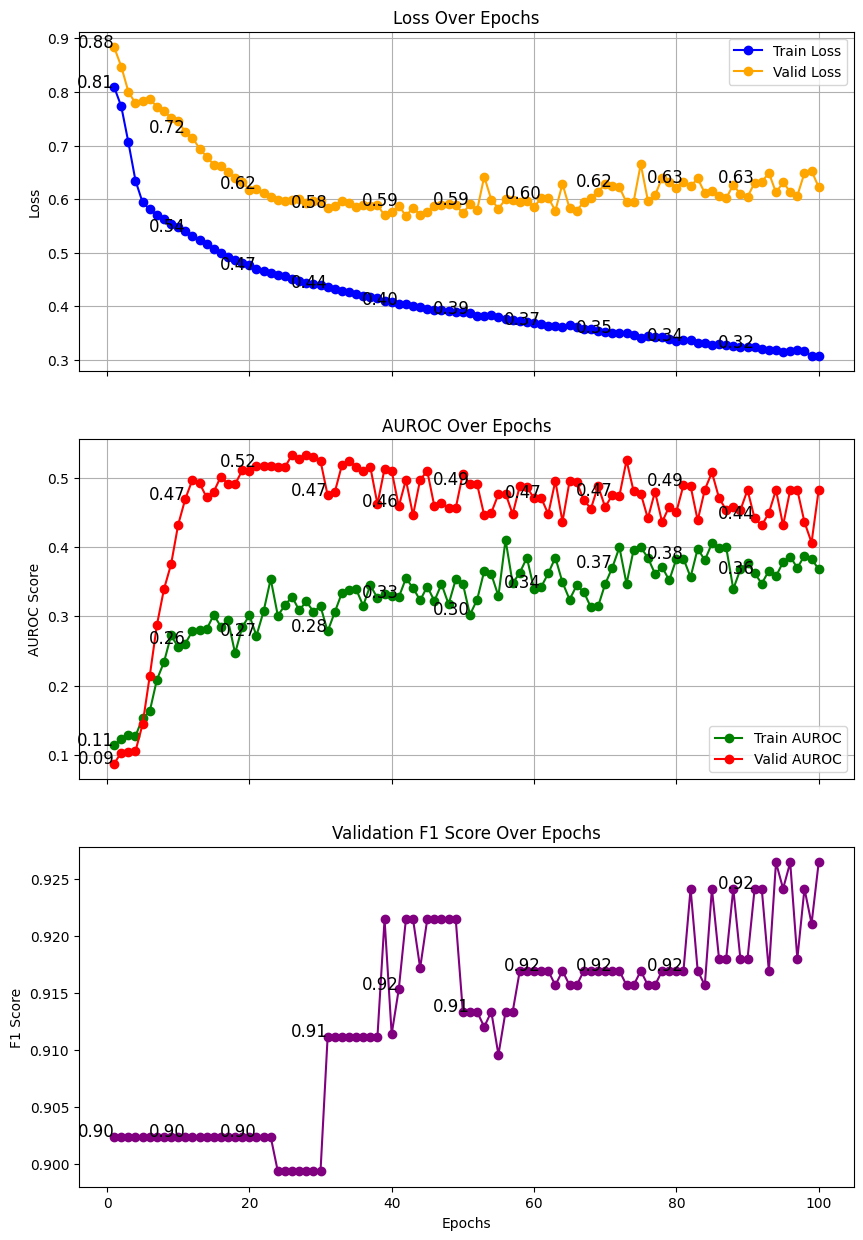

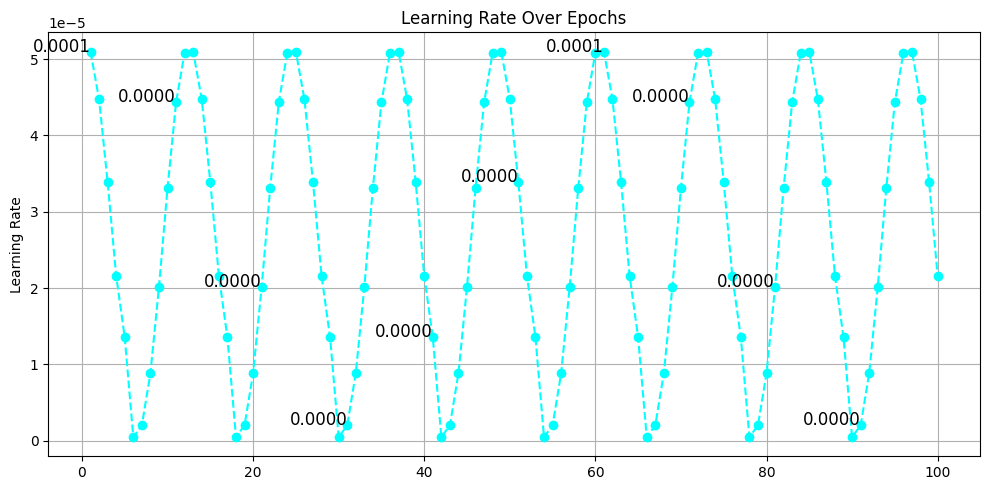

In [31]:
plot_metrics(history)

In [32]:
torch.softmax(model(gt.to(CONFIG['device']), pred.to(CONFIG['device'])), dim=1)

RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)